# Training

## Setup

In [1]:
import torch
import torchvision
from torchvision import datasets, transforms
import pandas as pd
from torch.utils.data import random_split
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
#from torch.autograd import Variable

In [2]:
if torch.cuda.is_available():
    device = torch.device('cuda')
elif torch.backends.mps.is_available():
    device = torch.device('mps')
else:
    device = torch.device('cpu')
#torch.backends.cudnn.enabled = False
val_size = 5000
test_size = 5000
batch_size = 16
num_workers = 4

transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))])
transform_valid_test = transforms.Compose([transforms.Resize((299, 299)), 
                                           transforms.ToTensor()])

# Downloading MNIST again :) Training (60k) and test(5k) + val(5k) split
train_loader = torch.utils.data.DataLoader(datasets.CIFAR10('./CIFAR_data2',
                                            download=True,
                                            train=True,
                                            transform=transform),
                                            batch_size=batch_size,
                                            shuffle=True, num_workers=num_workers)

test_dataset = datasets.CIFAR10('./CIFAR_data2',
                               download=True,
                               train=False,
                               transform=transform_valid_test)

val_dataset, test_dataset = random_split(test_dataset, [val_size, test_size])

# Test set to compare with DDPM paper
test_loader = torch.utils.data.DataLoader(test_dataset,
                                            batch_size=batch_size,
                                            shuffle=False, num_workers=num_workers)

# Validation set so we can keep track of approximated FID score while training
validation_loader = torch.utils.data.DataLoader(val_dataset,
                                            batch_size=batch_size,
                                            shuffle=False, num_workers=num_workers)
    

Files already downloaded and verified
Files already downloaded and verified


# Ny block: Trækker 5000 CIFAR10 billeder til at beregne training FID

In [19]:
train_FID_dataset = datasets.CIFAR10('./CIFAR_data2',
                               download=True,
                               train=True,
                               transform=transform_valid_test)

train_for_FID, _ = random_split(train_FID_dataset, [5000, 45000])

train_for_FID_loader = torch.utils.data.DataLoader(train_for_FID, batch_size=batch_size, shuffle=False, num_workers=num_workers)


Files already downloaded and verified


In [3]:
# COSINE SCHEDULE

def f(t, s=torch.tensor([0.008]), T=torch.tensor([1000])):
    return (torch.cos((t / T + s) / (1 + s) * (torch.pi / 2)).pow(2)).clamp(max=0.99999)

T = 1000
ts = torch.arange(T)
alpha_bar = torch.tensor([(f(t)/f(torch.tensor([0]))).clamp(max=0.99999) for t in ts]) 
beta = torch.tensor([1 - alpha_bar[t]/(alpha_bar[t-1]) if t > 0 else torch.tensor([0]) for t in ts])
alpha = 1 - beta
alpha = alpha.view((1000, 1, 1, 1)).to(device)
beta = beta.view((1000, 1, 1, 1)).to(device)
alpha_bar = alpha_bar.view((1000, 1, 1, 1)).to(device)

In [3]:
# Sets up alpha_bar for training and test so alpha_bar_t = alpha_bar[t]
# LINEAR SCHEDULE
T = 1000
beta_start, beta_end = [1e-4, 2e-02]
beta = torch.linspace(beta_start, beta_end, T)
alpha = 1-beta
alpha_bar = alpha.clone()
for e in range(T-1):
    alpha_bar[e+1] *= alpha_bar[e]

alpha = alpha.view((1000, 1, 1, 1)).to(device)
beta = beta.view((1000, 1, 1, 1)).to(device)
alpha_bar = alpha_bar.view((1000, 1, 1, 1)).to(device)

## Model

In [4]:
class UNET(torch.nn.Module):
    def __init__(self):
        super(UNET, self).__init__()
        channels = [32, 64, 128, 256]
        self.convs = nn.ModuleList([
            nn.Sequential(
                nn.Conv2d(4, channels[0], kernel_size=3, padding=1),  # (batchsize, 32, 28, 28)
                nn.ReLU(),
            ),
            nn.Sequential(
                nn.MaxPool2d(2),  # (batchsize, 32, 14, 14)
                nn.Conv2d(channels[0], channels[1], kernel_size=3, padding=1),  # (batchsize, 64, 14, 14)
                nn.ReLU(),
            ),
            nn.Sequential(
                nn.MaxPool2d(2),  # (batchsize, 64, 7, 7)
                nn.Conv2d(channels[1], channels[2], kernel_size=3, padding=1),  # (batchsize, 128, 7, 7)
                nn.ReLU(),
            ),
            nn.Sequential(
                nn.MaxPool2d(2, padding=0),  # (batchsize, 128, 4, 4)
                nn.Conv2d(channels[2], channels[3], kernel_size=3, padding=1),  # (batchsize, 256, 4, 4)
                nn.ReLU(),
            )
        ])

        self.tconvs = nn.ModuleList([
            nn.Sequential(
                nn.ConvTranspose2d(channels[3], channels[2], kernel_size=3, 
                                   stride=2, padding=1, output_padding=1),   # (batchsize, 128, 7, 7)
                nn.ReLU()
            ),
            nn.Sequential(
                nn.ConvTranspose2d(channels[2]*2, channels[1], kernel_size=3,
                                   stride=2, padding=1, output_padding=1),   # (batchsize, 64, 14, 14)
                nn.ReLU()
            ),
            nn.Sequential(
                nn.ConvTranspose2d(channels[1]*2, channels[0], kernel_size=3, 
                                   stride=2, padding=1, output_padding=1),   # (batchsize, 32, 28, 28)
                nn.ReLU()
            ),
            nn.Sequential(
                nn.Conv2d(channels[0]*2,channels[0],kernel_size=3,padding=1),  # (batchsize, 32, 28, 28)
                nn.ReLU(),
                nn.Conv2d(channels[0],3,kernel_size=1) # (batchsize, 1, 28, 28)
            )      
        ])
    
    def forward(self, x, t):
        #print(x.shape)
        #print(t.shape)
        x_trans = torch.cat((x, t), dim=-3)

        signal = x_trans

        signals = []

        for i, conv in enumerate(self.convs):
            # print(f"conv {i}")
            #print(signal.shape)
            signal = conv(signal)
            # print(signal.shape)
            if i < len(conv):
                signals.append(signal)
        #for s in signals:
            #print(s.shape)
        #print(signal.shape)
        for i, tconv in enumerate(self.tconvs):
            #print(signal.shape)
            
            # print(f"tconv {i}")
            # print(f"signal shape: {signal.shape}")
            if i == 0:
                #print(signal.shape)
                signal = tconv(signal)
            else:
                #print(signal.shape, signals[-i].shape)
                signal = torch.cat((signal, signals[-i]), dim=-3)
                #print(signal.shape)
                signal = tconv(signal)
        return signal

## Training loop

In [13]:
#from UNET import UNET
epochs = 1707
model = UNET()
model.to(device)
model.train()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
criterion = torch.nn.MSELoss(reduction="sum")
running_loss = 0
batch_size = 16

In [14]:
#model = UNET()
#model.to(device)
#model.load_state_dict(torch.load("DDPM_final_linear_499.pth"))
#model.train()
#optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
#criterion = torch.nn.MSELoss(reduction="sum")
#running_loss = 0
#batch_size = 16

# Træner og gemmer model 1, 100, 200, 300, 400, 500, 800, 1100, 1400 og 1707. Gemmer losses i losses.txt. Kan evt. ændres til at gemme færre modeller hvis det tager lang tid

In [15]:
for epoch in range(epochs+1):
    for e, data in enumerate(train_loader):
        x0, _ = data
        x0 = x0.to(device)
        t = torch.randint(1, T+1, (batch_size,)).to(device)
        #print(t.shape)
        eps = torch.randn(batch_size, 3, 32, 32).to(device)
        # print(eps.shape)
        # print(x0.shape)
        loss = criterion(eps, model(torch.sqrt(alpha_bar[t-1]) * x0 + 
                                    torch.sqrt(1 - alpha_bar[t-1]) * eps, t.view(batch_size, 1, 1, 1).expand(batch_size, 1, 32, 32) / 1000))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
        if e % 100 == 99:
            print(f'{epoch, e+1}, loss: {running_loss:.3f}')
            with open("losses", "a") as file:
                file.write(f"{running_loss:.3f}\n")
            
            running_loss = 0.0
        
    if epoch in [1, 100, 200, 300, 400, 500, 800, 1100, 1400]:
        torch.save(model.state_dict(), f"DDPM_final_linear_{epoch}.pth")
torch.save(model.state_dict(), f"DDPM_final_linear_{epoch}.pth")

(501, 100), loss: 183993.830
(501, 200), loss: 172361.920
(501, 300), loss: 183822.841
(501, 400), loss: 184299.226
(501, 500), loss: 169064.727
(501, 600), loss: 181062.962
(501, 700), loss: 172987.275
(501, 800), loss: 180723.625
(501, 900), loss: 161789.350
(501, 1000), loss: 174691.889
(501, 1100), loss: 173513.123
(501, 1200), loss: 179667.706
(501, 1300), loss: 177570.217
(501, 1400), loss: 181042.098
(501, 1500), loss: 188560.535
(501, 1600), loss: 179016.193
(501, 1700), loss: 172481.851
(501, 1800), loss: 158166.598
(501, 1900), loss: 165684.184
(501, 2000), loss: 185733.591
(501, 2100), loss: 172617.323
(501, 2200), loss: 167681.950
(501, 2300), loss: 187829.121
(501, 2400), loss: 176132.224
(501, 2500), loss: 179447.052
(501, 2600), loss: 174887.238
(501, 2700), loss: 174063.173
(501, 2800), loss: 173675.381
(501, 2900), loss: 170367.504
(501, 3000), loss: 182113.599
(501, 3100), loss: 170309.347
(502, 100), loss: 205559.281
(502, 200), loss: 188246.332
(502, 300), loss: 164

# Sampling

In [7]:
import matplotlib.pyplot as plt
model.eval()

UNET(
  (convs): ModuleList(
    (0): Sequential(
      (0): Conv2d(4, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
    )
    (1): Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (2): ReLU()
    )
    (2): Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (2): ReLU()
    )
    (3): Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (2): ReLU()
    )
  )
  (tconvs): ModuleList(
    (0): Sequential(
      (0): ConvTranspose2d(256, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
      (1): ReLU()
    )
    (1): Sequential(
      (0): ConvTra

In [52]:
#model = UNET()
#model.to(device)
#model.load_state_dict(torch.load("DDPM_final_linear_300.pth"))

<All keys matched successfully>

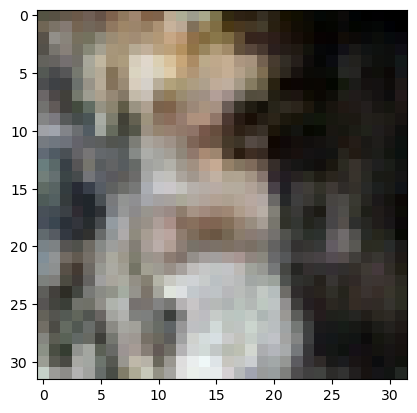

In [57]:
model.eval()
batch_size = 1
xt = torch.randn(batch_size, 3, 32, 32).to(device)
for t in torch.arange(T, 0, -1):
    #print(t)
    t = t.to(device)
    z = torch.randn(batch_size, 3, 32, 32).to(device) if t > 1 else torch.zeros(batch_size, 3, 32, 32).to(device)
    xt_new = 1 / torch.sqrt(alpha[t - 1]) * (xt - (1 - alpha[t - 1])/(torch.sqrt(1 - alpha_bar[t - 1])) * 
                                                   model(xt, t.expand(batch_size).view(batch_size, 1, 1, 1).expand(batch_size, 1, 32, 32)/1000)) + torch.sqrt(beta[t-1]) * z
    xt = xt_new
    #if t == 1:
        #print((xt - (1 - alpha[t - 1])/(torch.sqrt(1 - alpha_bar[t - 1]))))
im = xt[0].permute(1, 2, 0)
im = im.cpu().detach().numpy()
im = (im + 1) / 2 
im = im.clip(0, 1)
#print(im.max())
plt.imshow(im)

# Making test and valid set - commented out, don't touch again

In [ ]:
#print("Test set: ")
#for i, (img, _) in tqdm(enumerate(test_loader)):
#    for j in range(img.size(0)):
#        save_image(img[j], os.path.join(test_dir, f"{i * 16 + j}.png"))

In [19]:
#print("Valid set: ")
#for i, (img, _) in tqdm(enumerate(validation_loader)):
#    for j in range(img.size(0)):
#        save_image(img[j], os.path.join(valid_dir, f"{i * 16 + j}.png"))

Valid set: 


313it [02:34,  2.03it/s]


In [22]:
#print("Train set: ")
#for i, (img, _) in tqdm(enumerate(train_for_FID_loader)):
#    for j in range(img.size(0)):
#        save_image(img[j], os.path.join(train_dir, f"{i * 16 + j}.png"))

Train set: 


5000it [02:37, 31.80it/s]


# Make samples from the models we have trained. Currently set up for batch size 1 and conc. T

In [17]:
pip install pytorch-fid
import os
import torch
from torchvision import datasets, transforms
from torchvision.utils import save_image
from pytorch_fid import fid_score
from tqdm import tqdm

valid_dir = './valid_images'
test_dir = './test_images'
train_dir = './train_images'
gen_dir = './gen_images'
os.makedirs(valid_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)
os.makedirs(train_dir, exist_ok=True)
os.makedirs(gen_dir, exist_ok=True)
#for epoch in [800, 1100, 1400, 1707]:
#    os.makedirs(f"./gen_images/{epoch}", exist_ok=True)

resize_transform = transforms.Resize((299, 299))

for epoch in [1, 100, 200, 300, 400, 500, 800, 1100, 1400, 1707]:
    model = UNET()
    model.to(device)
    model.load_state_dict(torch.load(f"DDPM_final_linear_{epoch}.pth"))
    model.eval()
    batch_size = 1
    
    print("Starting generation set: ")
    for i in tqdm(range(1000)):
        xt = torch.randn(batch_size, 3, 32, 32).to(device)
        
        for t in torch.arange(T, 0, -1):
            #print(t)
            t = t.to(device)
            z = torch.randn(batch_size, 3, 32, 32).to(device) if t > 1 else torch.zeros(batch_size, 3, 32, 32).to(device)
            xt_new = 1 / torch.sqrt(alpha[t - 1]) * (xt - (1 - alpha[t - 1])/(torch.sqrt(1 - alpha_bar[t - 1])) * 
                                                           model(xt, t.expand(batch_size).view(batch_size, 1, 1, 1).expand(batch_size, 1, 32, 32)/1000)) + torch.sqrt(beta[t-1]) * z
            xt = xt_new
            #if t == 1:
                #print((xt - (1 - alpha[t - 1])/(torch.sqrt(1 - alpha_bar[t - 1]))))
        im = xt[0]
        print(im.shape)
        im = resize_transform(im)
        im = (im + 1) / 2
        im = im.clamp(0, 1)
        print(im.shape)
        print("Saving generated image: ")
        save_image(im, os.path.join(f"./gen_images/{epoch}", f"{i}.png"))
        print(epoch, i)

Starting generation set: 


  0%|                                                                                 | 1/1000 [00:02<44:13,  2.66s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 0


  0%|▏                                                                                | 2/1000 [00:05<43:50,  2.64s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 1


  0%|▏                                                                                | 3/1000 [00:07<41:12,  2.48s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 2


  0%|▎                                                                                | 4/1000 [00:10<45:23,  2.73s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 3


  0%|▍                                                                                | 5/1000 [00:13<43:26,  2.62s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 4


  1%|▍                                                                                | 6/1000 [00:15<41:56,  2.53s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 5


  1%|▌                                                                                | 7/1000 [00:18<44:29,  2.69s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 6


  1%|▋                                                                                | 8/1000 [00:20<43:10,  2.61s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 7


  1%|▋                                                                                | 9/1000 [00:23<42:46,  2.59s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 8


  1%|▊                                                                               | 10/1000 [00:25<41:41,  2.53s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 9


  1%|▉                                                                               | 11/1000 [00:28<41:20,  2.51s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 10


  1%|▉                                                                               | 12/1000 [00:30<40:22,  2.45s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 11


  1%|█                                                                               | 13/1000 [00:32<39:41,  2.41s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 12


  1%|█                                                                               | 14/1000 [00:35<39:21,  2.40s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 13


  2%|█▏                                                                              | 15/1000 [00:37<40:17,  2.45s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 14


  2%|█▎                                                                              | 16/1000 [00:40<39:40,  2.42s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 15


  2%|█▎                                                                              | 17/1000 [00:42<39:48,  2.43s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 16


  2%|█▍                                                                              | 18/1000 [00:45<39:45,  2.43s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 17


  2%|█▌                                                                              | 19/1000 [00:47<40:16,  2.46s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 18


  2%|█▌                                                                              | 20/1000 [00:50<40:19,  2.47s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 19


  2%|█▋                                                                              | 21/1000 [00:52<39:29,  2.42s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 20


  2%|█▊                                                                              | 22/1000 [00:54<39:40,  2.43s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 21


  2%|█▊                                                                              | 23/1000 [00:57<39:42,  2.44s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 22


  2%|█▉                                                                              | 24/1000 [00:59<39:20,  2.42s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 23


  2%|██                                                                              | 25/1000 [01:02<39:31,  2.43s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 24


  3%|██                                                                              | 26/1000 [01:05<41:46,  2.57s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 25


  3%|██▏                                                                             | 27/1000 [01:07<40:40,  2.51s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 26


  3%|██▏                                                                             | 28/1000 [01:10<42:42,  2.64s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 27


  3%|██▎                                                                             | 29/1000 [01:12<41:45,  2.58s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 28


  3%|██▍                                                                             | 30/1000 [01:15<40:45,  2.52s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 29


  3%|██▍                                                                             | 31/1000 [01:17<40:17,  2.49s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 30


  3%|██▌                                                                             | 32/1000 [01:20<39:29,  2.45s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 31


  3%|██▋                                                                             | 33/1000 [01:22<39:22,  2.44s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 32


  3%|██▋                                                                             | 34/1000 [01:24<38:36,  2.40s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 33


  4%|██▊                                                                             | 35/1000 [01:27<38:25,  2.39s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 34


  4%|██▉                                                                             | 36/1000 [01:29<40:06,  2.50s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 35


  4%|██▉                                                                             | 37/1000 [01:32<39:41,  2.47s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 36


  4%|███                                                                             | 38/1000 [01:35<41:06,  2.56s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 37


  4%|███                                                                             | 39/1000 [01:37<40:08,  2.51s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 38


  4%|███▏                                                                            | 40/1000 [01:39<40:16,  2.52s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 39


  4%|███▎                                                                            | 41/1000 [01:42<39:23,  2.46s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 40


  4%|███▎                                                                            | 42/1000 [01:45<41:08,  2.58s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 41


  4%|███▍                                                                            | 43/1000 [01:47<40:24,  2.53s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 42


  4%|███▌                                                                            | 44/1000 [01:50<40:42,  2.56s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 43


  4%|███▌                                                                            | 45/1000 [01:52<41:26,  2.60s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 44


  5%|███▋                                                                            | 46/1000 [01:55<40:44,  2.56s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 45


  5%|███▊                                                                            | 47/1000 [01:57<39:46,  2.50s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 46


  5%|███▊                                                                            | 48/1000 [02:00<42:05,  2.65s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 47


  5%|███▉                                                                            | 49/1000 [02:03<42:17,  2.67s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 48


  5%|████                                                                            | 50/1000 [02:05<41:02,  2.59s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 49


  5%|████                                                                            | 51/1000 [02:08<39:42,  2.51s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 50


  5%|████▏                                                                           | 52/1000 [02:10<38:51,  2.46s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 51


  5%|████▏                                                                           | 53/1000 [02:12<38:46,  2.46s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 52


  5%|████▎                                                                           | 54/1000 [02:15<38:05,  2.42s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 53


  6%|████▍                                                                           | 55/1000 [02:17<37:41,  2.39s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 54


  6%|████▍                                                                           | 56/1000 [02:20<37:50,  2.40s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 55


  6%|████▌                                                                           | 57/1000 [02:22<38:35,  2.46s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 56


  6%|████▋                                                                           | 58/1000 [02:24<37:47,  2.41s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 57


  6%|████▋                                                                           | 59/1000 [02:27<37:52,  2.41s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 58


  6%|████▊                                                                           | 60/1000 [02:30<39:36,  2.53s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 59


  6%|████▉                                                                           | 61/1000 [02:32<38:49,  2.48s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 60


  6%|████▉                                                                           | 62/1000 [02:35<39:13,  2.51s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 61


  6%|█████                                                                           | 63/1000 [02:37<39:42,  2.54s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 62


  6%|█████                                                                           | 64/1000 [02:40<39:04,  2.51s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 63


  6%|█████▏                                                                          | 65/1000 [02:42<38:06,  2.45s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 64


  7%|█████▎                                                                          | 66/1000 [02:44<38:27,  2.47s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 65


  7%|█████▎                                                                          | 67/1000 [02:47<38:09,  2.45s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 66


  7%|█████▍                                                                          | 68/1000 [02:49<38:05,  2.45s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 67


  7%|█████▌                                                                          | 69/1000 [02:52<38:59,  2.51s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 68


  7%|█████▌                                                                          | 70/1000 [02:55<40:33,  2.62s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 69


  7%|█████▋                                                                          | 71/1000 [02:57<40:36,  2.62s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 70


  7%|█████▊                                                                          | 72/1000 [03:00<40:07,  2.59s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 71


  7%|█████▊                                                                          | 73/1000 [03:02<39:16,  2.54s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 72


  7%|█████▉                                                                          | 74/1000 [03:05<38:33,  2.50s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 73


  8%|██████                                                                          | 75/1000 [03:07<38:07,  2.47s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 74


  8%|██████                                                                          | 76/1000 [03:10<39:22,  2.56s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 75


  8%|██████▏                                                                         | 77/1000 [03:12<38:36,  2.51s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 76


  8%|██████▏                                                                         | 78/1000 [03:15<38:08,  2.48s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 77


  8%|██████▎                                                                         | 79/1000 [03:17<38:05,  2.48s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 78


  8%|██████▍                                                                         | 80/1000 [03:20<37:59,  2.48s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 79


  8%|██████▍                                                                         | 81/1000 [03:22<37:43,  2.46s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 80


  8%|██████▌                                                                         | 82/1000 [03:25<37:41,  2.46s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 81


  8%|██████▋                                                                         | 83/1000 [03:27<37:00,  2.42s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 82


  8%|██████▋                                                                         | 84/1000 [03:29<36:52,  2.42s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 83


  8%|██████▊                                                                         | 85/1000 [03:32<36:59,  2.43s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 84


  9%|██████▉                                                                         | 86/1000 [03:34<37:37,  2.47s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 85


  9%|██████▉                                                                         | 87/1000 [03:37<37:16,  2.45s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 86


  9%|███████                                                                         | 88/1000 [03:39<38:01,  2.50s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 87


  9%|███████                                                                         | 89/1000 [03:42<37:49,  2.49s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 88


  9%|███████▏                                                                        | 90/1000 [03:44<37:25,  2.47s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 89


  9%|███████▎                                                                        | 91/1000 [03:47<37:39,  2.49s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 90


  9%|███████▎                                                                        | 92/1000 [03:49<37:26,  2.47s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 91


  9%|███████▍                                                                        | 93/1000 [03:52<37:26,  2.48s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 92


  9%|███████▌                                                                        | 94/1000 [03:54<37:16,  2.47s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 93


 10%|███████▌                                                                        | 95/1000 [03:57<37:46,  2.50s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 94


 10%|███████▋                                                                        | 96/1000 [03:59<37:33,  2.49s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 95


 10%|███████▊                                                                        | 97/1000 [04:02<36:54,  2.45s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 96


 10%|███████▊                                                                        | 98/1000 [04:04<38:00,  2.53s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 97


 10%|███████▉                                                                        | 99/1000 [04:07<37:04,  2.47s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 98


 10%|███████▉                                                                       | 100/1000 [04:09<37:21,  2.49s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 99


 10%|███████▉                                                                       | 101/1000 [04:12<38:45,  2.59s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 100


 10%|████████                                                                       | 102/1000 [04:14<37:57,  2.54s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 101


 10%|████████▏                                                                      | 103/1000 [04:17<37:39,  2.52s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 102


 10%|████████▏                                                                      | 104/1000 [04:20<37:56,  2.54s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 103


 10%|████████▎                                                                      | 105/1000 [04:22<37:03,  2.48s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 104


 11%|████████▎                                                                      | 106/1000 [04:24<37:38,  2.53s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 105


 11%|████████▍                                                                      | 107/1000 [04:27<37:14,  2.50s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 106


 11%|████████▌                                                                      | 108/1000 [04:29<36:32,  2.46s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 107


 11%|████████▌                                                                      | 109/1000 [04:32<38:58,  2.62s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 108


 11%|████████▋                                                                      | 110/1000 [04:35<38:59,  2.63s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 109


 11%|████████▊                                                                      | 111/1000 [04:37<38:12,  2.58s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 110


 11%|████████▊                                                                      | 112/1000 [04:40<38:13,  2.58s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 111


 11%|████████▉                                                                      | 113/1000 [04:42<37:51,  2.56s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 112


 11%|█████████                                                                      | 114/1000 [04:45<38:01,  2.57s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 113


 12%|█████████                                                                      | 115/1000 [04:48<38:40,  2.62s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 114


 12%|█████████▏                                                                     | 116/1000 [04:51<38:50,  2.64s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 115


 12%|█████████▏                                                                     | 117/1000 [04:53<38:37,  2.62s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 116


 12%|█████████▎                                                                     | 118/1000 [04:56<38:02,  2.59s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 117


 12%|█████████▍                                                                     | 119/1000 [04:58<36:54,  2.51s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 118


 12%|█████████▍                                                                     | 120/1000 [05:01<37:40,  2.57s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 119


 12%|█████████▌                                                                     | 121/1000 [05:03<36:37,  2.50s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 120


 12%|█████████▋                                                                     | 122/1000 [05:05<36:13,  2.48s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 121


 12%|█████████▋                                                                     | 123/1000 [05:08<35:57,  2.46s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 122


 12%|█████████▊                                                                     | 124/1000 [05:10<36:10,  2.48s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 123


 12%|█████████▉                                                                     | 125/1000 [05:13<35:52,  2.46s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 124


 13%|█████████▉                                                                     | 126/1000 [05:16<37:13,  2.56s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 125


 13%|██████████                                                                     | 127/1000 [05:18<37:24,  2.57s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 126


 13%|██████████                                                                     | 128/1000 [05:21<38:15,  2.63s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 127


 13%|██████████▏                                                                    | 129/1000 [05:24<38:14,  2.63s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 128


 13%|██████████▎                                                                    | 130/1000 [05:26<37:14,  2.57s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 129


 13%|██████████▎                                                                    | 131/1000 [05:29<37:26,  2.58s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 130


 13%|██████████▍                                                                    | 132/1000 [05:31<37:12,  2.57s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 131


 13%|██████████▌                                                                    | 133/1000 [05:34<37:10,  2.57s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 132


 13%|██████████▌                                                                    | 134/1000 [05:37<38:58,  2.70s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 133


 14%|██████████▋                                                                    | 135/1000 [05:39<38:03,  2.64s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 134


 14%|██████████▋                                                                    | 136/1000 [05:42<36:42,  2.55s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 135


 14%|██████████▊                                                                    | 137/1000 [05:44<36:18,  2.52s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 136


 14%|██████████▉                                                                    | 138/1000 [05:47<37:25,  2.61s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 137


 14%|██████████▉                                                                    | 139/1000 [05:50<38:36,  2.69s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 138


 14%|███████████                                                                    | 140/1000 [05:52<37:41,  2.63s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 139


 14%|███████████▏                                                                   | 141/1000 [05:55<37:10,  2.60s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 140


 14%|███████████▏                                                                   | 142/1000 [05:57<35:57,  2.51s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 141


 14%|███████████▎                                                                   | 143/1000 [05:59<35:22,  2.48s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 142


 14%|███████████▍                                                                   | 144/1000 [06:02<35:04,  2.46s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 143


 14%|███████████▍                                                                   | 145/1000 [06:04<35:23,  2.48s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 144


 15%|███████████▌                                                                   | 146/1000 [06:07<34:43,  2.44s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 145


 15%|███████████▌                                                                   | 147/1000 [06:09<34:19,  2.41s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 146


 15%|███████████▋                                                                   | 148/1000 [06:11<33:57,  2.39s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 147


 15%|███████████▊                                                                   | 149/1000 [06:14<33:45,  2.38s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 148


 15%|███████████▊                                                                   | 150/1000 [06:16<33:56,  2.40s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 149


 15%|███████████▉                                                                   | 151/1000 [06:19<34:15,  2.42s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 150


 15%|████████████                                                                   | 152/1000 [06:21<34:08,  2.42s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 151


 15%|████████████                                                                   | 153/1000 [06:23<33:46,  2.39s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 152


 15%|████████████▏                                                                  | 154/1000 [06:26<33:34,  2.38s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 153


 16%|████████████▏                                                                  | 155/1000 [06:28<33:57,  2.41s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 154


 16%|████████████▎                                                                  | 156/1000 [06:31<33:28,  2.38s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 155


 16%|████████████▍                                                                  | 157/1000 [06:33<35:10,  2.50s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 156


 16%|████████████▍                                                                  | 158/1000 [06:36<35:54,  2.56s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 157


 16%|████████████▌                                                                  | 159/1000 [06:38<35:11,  2.51s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 158


 16%|████████████▋                                                                  | 160/1000 [06:41<35:17,  2.52s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 159


 16%|████████████▋                                                                  | 161/1000 [06:43<34:32,  2.47s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 160


 16%|████████████▊                                                                  | 162/1000 [06:46<34:16,  2.45s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 161


 16%|████████████▉                                                                  | 163/1000 [06:48<34:12,  2.45s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 162


 16%|████████████▉                                                                  | 164/1000 [06:51<34:09,  2.45s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 163


 16%|█████████████                                                                  | 165/1000 [06:53<34:25,  2.47s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 164


 17%|█████████████                                                                  | 166/1000 [06:56<33:53,  2.44s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 165


 17%|█████████████▏                                                                 | 167/1000 [06:58<33:26,  2.41s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 166


 17%|█████████████▎                                                                 | 168/1000 [07:00<33:17,  2.40s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 167


 17%|█████████████▎                                                                 | 169/1000 [07:03<33:03,  2.39s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 168


 17%|█████████████▍                                                                 | 170/1000 [07:05<33:16,  2.41s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 169


 17%|█████████████▌                                                                 | 171/1000 [07:08<33:44,  2.44s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 170


 17%|█████████████▌                                                                 | 172/1000 [07:10<34:38,  2.51s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 171


 17%|█████████████▋                                                                 | 173/1000 [07:13<33:45,  2.45s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 172


 17%|█████████████▋                                                                 | 174/1000 [07:15<33:46,  2.45s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 173


 18%|█████████████▊                                                                 | 175/1000 [07:18<34:13,  2.49s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 174


 18%|█████████████▉                                                                 | 176/1000 [07:20<33:49,  2.46s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 175


 18%|█████████████▉                                                                 | 177/1000 [07:22<33:47,  2.46s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 176


 18%|██████████████                                                                 | 178/1000 [07:25<33:18,  2.43s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 177


 18%|██████████████▏                                                                | 179/1000 [07:27<33:00,  2.41s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 178


 18%|██████████████▏                                                                | 180/1000 [07:29<32:32,  2.38s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 179


 18%|██████████████▎                                                                | 181/1000 [07:32<32:22,  2.37s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 180


 18%|██████████████▍                                                                | 182/1000 [07:34<33:22,  2.45s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 181


 18%|██████████████▍                                                                | 183/1000 [07:37<33:39,  2.47s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 182


 18%|██████████████▌                                                                | 184/1000 [07:39<33:00,  2.43s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 183


 18%|██████████████▌                                                                | 185/1000 [07:42<32:29,  2.39s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 184


 19%|██████████████▋                                                                | 186/1000 [07:44<32:44,  2.41s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 185


 19%|██████████████▊                                                                | 187/1000 [07:46<32:27,  2.40s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 186


 19%|██████████████▊                                                                | 188/1000 [07:49<32:42,  2.42s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 187


 19%|██████████████▉                                                                | 189/1000 [07:52<33:26,  2.47s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 188


 19%|███████████████                                                                | 190/1000 [07:54<33:17,  2.47s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 189


 19%|███████████████                                                                | 191/1000 [07:57<34:00,  2.52s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 190


 19%|███████████████▏                                                               | 192/1000 [07:59<34:25,  2.56s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 191


 19%|███████████████▏                                                               | 193/1000 [08:02<34:23,  2.56s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 192


 19%|███████████████▎                                                               | 194/1000 [08:04<34:25,  2.56s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 193


 20%|███████████████▍                                                               | 195/1000 [08:07<34:48,  2.59s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 194


 20%|███████████████▍                                                               | 196/1000 [08:09<33:59,  2.54s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 195


 20%|███████████████▌                                                               | 197/1000 [08:12<35:32,  2.66s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 196


 20%|███████████████▋                                                               | 198/1000 [08:15<34:10,  2.56s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 197


 20%|███████████████▋                                                               | 199/1000 [08:17<33:56,  2.54s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 198


 20%|███████████████▊                                                               | 200/1000 [08:20<35:24,  2.66s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 199


 20%|███████████████▉                                                               | 201/1000 [08:23<35:10,  2.64s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 200


 20%|███████████████▉                                                               | 202/1000 [08:25<34:32,  2.60s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 201


 20%|████████████████                                                               | 203/1000 [08:28<33:39,  2.53s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 202


 20%|████████████████                                                               | 204/1000 [08:30<33:53,  2.56s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 203


 20%|████████████████▏                                                              | 205/1000 [08:33<33:18,  2.51s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 204


 21%|████████████████▎                                                              | 206/1000 [08:35<32:34,  2.46s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 205


 21%|████████████████▎                                                              | 207/1000 [08:38<32:43,  2.48s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 206


 21%|████████████████▍                                                              | 208/1000 [08:40<34:00,  2.58s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 207


 21%|████████████████▌                                                              | 209/1000 [08:43<34:31,  2.62s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 208


 21%|████████████████▌                                                              | 210/1000 [08:45<33:19,  2.53s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 209


 21%|████████████████▋                                                              | 211/1000 [08:48<34:45,  2.64s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 210


 21%|████████████████▋                                                              | 212/1000 [08:51<34:33,  2.63s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 211


 21%|████████████████▊                                                              | 213/1000 [08:53<33:14,  2.53s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 212


 21%|████████████████▉                                                              | 214/1000 [08:56<33:13,  2.54s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 213


 22%|████████████████▉                                                              | 215/1000 [08:58<33:01,  2.52s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 214


 22%|█████████████████                                                              | 216/1000 [09:01<33:10,  2.54s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 215


 22%|█████████████████▏                                                             | 217/1000 [09:03<32:21,  2.48s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 216


 22%|█████████████████▏                                                             | 218/1000 [09:05<31:42,  2.43s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 217


 22%|█████████████████▎                                                             | 219/1000 [09:08<31:25,  2.41s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 218


 22%|█████████████████▍                                                             | 220/1000 [09:10<31:09,  2.40s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 219


 22%|█████████████████▍                                                             | 221/1000 [09:13<32:06,  2.47s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 220


 22%|█████████████████▌                                                             | 222/1000 [09:15<32:13,  2.48s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 221


 22%|█████████████████▌                                                             | 223/1000 [09:18<32:06,  2.48s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 222


 22%|█████████████████▋                                                             | 224/1000 [09:20<31:34,  2.44s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 223


 22%|█████████████████▊                                                             | 225/1000 [09:23<32:50,  2.54s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 224


 23%|█████████████████▊                                                             | 226/1000 [09:25<32:04,  2.49s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 225


 23%|█████████████████▉                                                             | 227/1000 [09:28<32:58,  2.56s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 226


 23%|██████████████████                                                             | 228/1000 [09:30<32:04,  2.49s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 227


 23%|██████████████████                                                             | 229/1000 [09:33<33:15,  2.59s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 228


 23%|██████████████████▏                                                            | 230/1000 [09:36<32:26,  2.53s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 229


 23%|██████████████████▏                                                            | 231/1000 [09:38<31:36,  2.47s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 230


 23%|██████████████████▎                                                            | 232/1000 [09:40<31:26,  2.46s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 231


 23%|██████████████████▍                                                            | 233/1000 [09:43<31:57,  2.50s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 232


 23%|██████████████████▍                                                            | 234/1000 [09:45<31:43,  2.48s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 233


 24%|██████████████████▌                                                            | 235/1000 [09:48<31:10,  2.45s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 234


 24%|██████████████████▋                                                            | 236/1000 [09:50<31:59,  2.51s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 235


 24%|██████████████████▋                                                            | 237/1000 [09:53<31:57,  2.51s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 236


 24%|██████████████████▊                                                            | 238/1000 [09:56<32:30,  2.56s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 237


 24%|██████████████████▉                                                            | 239/1000 [09:58<33:17,  2.63s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 238


 24%|██████████████████▉                                                            | 240/1000 [10:01<33:50,  2.67s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 239


 24%|███████████████████                                                            | 241/1000 [10:04<33:50,  2.68s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 240


 24%|███████████████████                                                            | 242/1000 [10:06<33:03,  2.62s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 241


 24%|███████████████████▏                                                           | 243/1000 [10:09<31:57,  2.53s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 242


 24%|███████████████████▎                                                           | 244/1000 [10:11<32:32,  2.58s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 243


 24%|███████████████████▎                                                           | 245/1000 [10:14<31:49,  2.53s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 244


 25%|███████████████████▍                                                           | 246/1000 [10:16<31:32,  2.51s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 245


 25%|███████████████████▌                                                           | 247/1000 [10:19<30:47,  2.45s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 246


 25%|███████████████████▌                                                           | 248/1000 [10:21<30:22,  2.42s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 247


 25%|███████████████████▋                                                           | 249/1000 [10:24<31:19,  2.50s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 248


 25%|███████████████████▊                                                           | 250/1000 [10:26<30:46,  2.46s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 249


 25%|███████████████████▊                                                           | 251/1000 [10:29<31:27,  2.52s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 250


 25%|███████████████████▉                                                           | 252/1000 [10:31<31:15,  2.51s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 251


 25%|███████████████████▉                                                           | 253/1000 [10:34<31:35,  2.54s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 252


 25%|████████████████████                                                           | 254/1000 [10:36<32:12,  2.59s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 253


 26%|████████████████████▏                                                          | 255/1000 [10:39<31:31,  2.54s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 254


 26%|████████████████████▏                                                          | 256/1000 [10:41<31:15,  2.52s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 255


 26%|████████████████████▎                                                          | 257/1000 [10:44<31:00,  2.50s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 256


 26%|████████████████████▍                                                          | 258/1000 [10:46<30:35,  2.47s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 257


 26%|████████████████████▍                                                          | 259/1000 [10:49<31:36,  2.56s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 258


 26%|████████████████████▌                                                          | 260/1000 [10:51<30:42,  2.49s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 259


 26%|████████████████████▌                                                          | 261/1000 [10:54<30:02,  2.44s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 260


 26%|████████████████████▋                                                          | 262/1000 [10:56<29:37,  2.41s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 261


 26%|████████████████████▊                                                          | 263/1000 [10:58<29:09,  2.37s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 262


 26%|████████████████████▊                                                          | 264/1000 [11:01<29:13,  2.38s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 263


 26%|████████████████████▉                                                          | 265/1000 [11:03<30:10,  2.46s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 264


 27%|█████████████████████                                                          | 266/1000 [11:06<30:08,  2.46s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 265


 27%|█████████████████████                                                          | 267/1000 [11:08<29:38,  2.43s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 266


 27%|█████████████████████▏                                                         | 268/1000 [11:11<29:58,  2.46s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 267


 27%|█████████████████████▎                                                         | 269/1000 [11:13<29:22,  2.41s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 268


 27%|█████████████████████▎                                                         | 270/1000 [11:15<28:58,  2.38s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 269


 27%|█████████████████████▍                                                         | 271/1000 [11:18<29:58,  2.47s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 270


 27%|█████████████████████▍                                                         | 272/1000 [11:21<30:39,  2.53s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 271


 27%|█████████████████████▌                                                         | 273/1000 [11:23<29:52,  2.47s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 272


 27%|█████████████████████▋                                                         | 274/1000 [11:25<30:00,  2.48s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 273


 28%|█████████████████████▋                                                         | 275/1000 [11:28<29:58,  2.48s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 274


 28%|█████████████████████▊                                                         | 276/1000 [11:30<29:21,  2.43s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 275


 28%|█████████████████████▉                                                         | 277/1000 [11:33<29:25,  2.44s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 276


 28%|█████████████████████▉                                                         | 278/1000 [11:35<29:31,  2.45s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 277


 28%|██████████████████████                                                         | 279/1000 [11:37<29:10,  2.43s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 278


 28%|██████████████████████                                                         | 280/1000 [11:40<28:52,  2.41s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 279


 28%|██████████████████████▏                                                        | 281/1000 [11:42<28:32,  2.38s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 280


 28%|██████████████████████▎                                                        | 282/1000 [11:45<28:27,  2.38s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 281


 28%|██████████████████████▎                                                        | 283/1000 [11:47<28:46,  2.41s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 282


 28%|██████████████████████▍                                                        | 284/1000 [11:50<29:30,  2.47s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 283


 28%|██████████████████████▌                                                        | 285/1000 [11:52<29:19,  2.46s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 284


 29%|██████████████████████▌                                                        | 286/1000 [11:55<29:41,  2.49s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 285


 29%|██████████████████████▋                                                        | 287/1000 [11:57<29:52,  2.51s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 286


 29%|██████████████████████▊                                                        | 288/1000 [12:00<29:59,  2.53s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 287


 29%|██████████████████████▊                                                        | 289/1000 [12:02<29:20,  2.48s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 288


 29%|██████████████████████▉                                                        | 290/1000 [12:05<29:38,  2.50s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 289


 29%|██████████████████████▉                                                        | 291/1000 [12:07<30:00,  2.54s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 290


 29%|███████████████████████                                                        | 292/1000 [12:10<29:02,  2.46s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 291


 29%|███████████████████████▏                                                       | 293/1000 [12:12<28:30,  2.42s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 292


 29%|███████████████████████▏                                                       | 294/1000 [12:14<28:42,  2.44s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 293


 30%|███████████████████████▎                                                       | 295/1000 [12:17<28:20,  2.41s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 294


 30%|███████████████████████▍                                                       | 296/1000 [12:19<28:12,  2.40s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 295


 30%|███████████████████████▍                                                       | 297/1000 [12:22<28:19,  2.42s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 296


 30%|███████████████████████▌                                                       | 298/1000 [12:24<29:09,  2.49s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 297


 30%|███████████████████████▌                                                       | 299/1000 [12:27<29:31,  2.53s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 298


 30%|███████████████████████▋                                                       | 300/1000 [12:29<28:42,  2.46s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 299


 30%|███████████████████████▊                                                       | 301/1000 [12:32<29:30,  2.53s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 300


 30%|███████████████████████▊                                                       | 302/1000 [12:34<28:56,  2.49s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 301


 30%|███████████████████████▉                                                       | 303/1000 [12:37<29:02,  2.50s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 302


 30%|████████████████████████                                                       | 304/1000 [12:39<28:45,  2.48s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 303


 30%|████████████████████████                                                       | 305/1000 [12:42<30:08,  2.60s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 304


 31%|████████████████████████▏                                                      | 306/1000 [12:45<29:47,  2.57s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 305


 31%|████████████████████████▎                                                      | 307/1000 [12:47<28:52,  2.50s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 306


 31%|████████████████████████▎                                                      | 308/1000 [12:49<28:16,  2.45s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 307


 31%|████████████████████████▍                                                      | 309/1000 [12:52<28:22,  2.46s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 308


 31%|████████████████████████▍                                                      | 310/1000 [12:54<28:21,  2.47s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 309


 31%|████████████████████████▌                                                      | 311/1000 [12:57<28:11,  2.46s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 310


 31%|████████████████████████▋                                                      | 312/1000 [12:59<28:21,  2.47s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 311


 31%|████████████████████████▋                                                      | 313/1000 [13:02<28:16,  2.47s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 312


 31%|████████████████████████▊                                                      | 314/1000 [13:04<29:17,  2.56s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 313


 32%|████████████████████████▉                                                      | 315/1000 [13:07<29:11,  2.56s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 314


 32%|████████████████████████▉                                                      | 316/1000 [13:10<30:16,  2.66s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 315


 32%|█████████████████████████                                                      | 317/1000 [13:12<29:02,  2.55s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 316


 32%|█████████████████████████                                                      | 318/1000 [13:15<29:30,  2.60s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 317


 32%|█████████████████████████▏                                                     | 319/1000 [13:17<28:32,  2.51s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 318


 32%|█████████████████████████▎                                                     | 320/1000 [13:20<28:54,  2.55s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 319


 32%|█████████████████████████▎                                                     | 321/1000 [13:22<28:02,  2.48s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 320


 32%|█████████████████████████▍                                                     | 322/1000 [13:25<27:47,  2.46s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 321


 32%|█████████████████████████▌                                                     | 323/1000 [13:27<27:33,  2.44s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 322


 32%|█████████████████████████▌                                                     | 324/1000 [13:29<27:17,  2.42s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 323


 32%|█████████████████████████▋                                                     | 325/1000 [13:32<28:22,  2.52s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 324


 33%|█████████████████████████▊                                                     | 326/1000 [13:35<29:18,  2.61s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 325


 33%|█████████████████████████▊                                                     | 327/1000 [13:37<28:22,  2.53s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 326


 33%|█████████████████████████▉                                                     | 328/1000 [13:40<27:34,  2.46s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 327


 33%|█████████████████████████▉                                                     | 329/1000 [13:42<27:32,  2.46s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 328


 33%|██████████████████████████                                                     | 330/1000 [13:45<27:42,  2.48s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 329


 33%|██████████████████████████▏                                                    | 331/1000 [13:47<27:11,  2.44s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 330


 33%|██████████████████████████▏                                                    | 332/1000 [13:49<27:32,  2.47s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 331


 33%|██████████████████████████▎                                                    | 333/1000 [13:52<27:22,  2.46s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 332


 33%|██████████████████████████▍                                                    | 334/1000 [13:55<28:45,  2.59s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 333


 34%|██████████████████████████▍                                                    | 335/1000 [13:58<29:32,  2.67s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 334


 34%|██████████████████████████▌                                                    | 336/1000 [14:00<28:55,  2.61s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 335


 34%|██████████████████████████▌                                                    | 337/1000 [14:02<27:58,  2.53s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 336


 34%|██████████████████████████▋                                                    | 338/1000 [14:05<27:21,  2.48s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 337


 34%|██████████████████████████▊                                                    | 339/1000 [14:07<28:03,  2.55s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 338


 34%|██████████████████████████▊                                                    | 340/1000 [14:10<27:33,  2.51s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 339


 34%|██████████████████████████▉                                                    | 341/1000 [14:12<27:25,  2.50s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 340


 34%|███████████████████████████                                                    | 342/1000 [14:15<26:58,  2.46s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 341


 34%|███████████████████████████                                                    | 343/1000 [14:18<28:54,  2.64s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 342


 34%|███████████████████████████▏                                                   | 344/1000 [14:20<28:20,  2.59s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 343


 34%|███████████████████████████▎                                                   | 345/1000 [14:23<27:43,  2.54s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 344


 35%|███████████████████████████▎                                                   | 346/1000 [14:25<27:59,  2.57s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 345


 35%|███████████████████████████▍                                                   | 347/1000 [14:28<28:10,  2.59s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 346


 35%|███████████████████████████▍                                                   | 348/1000 [14:31<28:26,  2.62s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 347


 35%|███████████████████████████▌                                                   | 349/1000 [14:33<28:24,  2.62s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 348


 35%|███████████████████████████▋                                                   | 350/1000 [14:36<27:30,  2.54s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 349


 35%|███████████████████████████▋                                                   | 351/1000 [14:38<27:01,  2.50s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 350


 35%|███████████████████████████▊                                                   | 352/1000 [14:41<28:08,  2.61s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 351


 35%|███████████████████████████▉                                                   | 353/1000 [14:44<28:36,  2.65s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 352


 35%|███████████████████████████▉                                                   | 354/1000 [14:46<27:48,  2.58s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 353


 36%|████████████████████████████                                                   | 355/1000 [14:49<27:22,  2.55s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 354


 36%|████████████████████████████                                                   | 356/1000 [14:51<27:04,  2.52s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 355


 36%|████████████████████████████▏                                                  | 357/1000 [14:53<26:29,  2.47s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 356


 36%|████████████████████████████▎                                                  | 358/1000 [14:56<25:55,  2.42s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 357


 36%|████████████████████████████▎                                                  | 359/1000 [14:58<25:54,  2.43s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 358


 36%|████████████████████████████▍                                                  | 360/1000 [15:01<25:56,  2.43s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 359


 36%|████████████████████████████▌                                                  | 361/1000 [15:03<25:39,  2.41s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 360


 36%|████████████████████████████▌                                                  | 362/1000 [15:05<25:23,  2.39s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 361


 36%|████████████████████████████▋                                                  | 363/1000 [15:08<25:08,  2.37s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 362


 36%|████████████████████████████▊                                                  | 364/1000 [15:10<26:09,  2.47s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 363


 36%|████████████████████████████▊                                                  | 365/1000 [15:13<26:27,  2.50s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 364


 37%|████████████████████████████▉                                                  | 366/1000 [15:15<26:41,  2.53s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 365


 37%|████████████████████████████▉                                                  | 367/1000 [15:18<26:51,  2.55s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 366


 37%|█████████████████████████████                                                  | 368/1000 [15:21<27:30,  2.61s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 367


 37%|█████████████████████████████▏                                                 | 369/1000 [15:23<26:38,  2.53s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 368


 37%|█████████████████████████████▏                                                 | 370/1000 [15:25<25:53,  2.47s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 369


 37%|█████████████████████████████▎                                                 | 371/1000 [15:28<25:47,  2.46s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 370


 37%|█████████████████████████████▍                                                 | 372/1000 [15:30<25:52,  2.47s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 371


 37%|█████████████████████████████▍                                                 | 373/1000 [15:33<26:26,  2.53s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 372


 37%|█████████████████████████████▌                                                 | 374/1000 [15:35<25:47,  2.47s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 373


 38%|█████████████████████████████▋                                                 | 375/1000 [15:38<25:14,  2.42s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 374


 38%|█████████████████████████████▋                                                 | 376/1000 [15:40<24:53,  2.39s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 375


 38%|█████████████████████████████▊                                                 | 377/1000 [15:43<26:20,  2.54s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 376


 38%|█████████████████████████████▊                                                 | 378/1000 [15:45<25:46,  2.49s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 377


 38%|█████████████████████████████▉                                                 | 379/1000 [15:48<25:37,  2.48s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 378


 38%|██████████████████████████████                                                 | 380/1000 [15:50<25:09,  2.44s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 379


 38%|██████████████████████████████                                                 | 381/1000 [15:52<24:49,  2.41s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 380


 38%|██████████████████████████████▏                                                | 382/1000 [15:55<24:54,  2.42s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 381


 38%|██████████████████████████████▎                                                | 383/1000 [15:57<24:55,  2.42s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 382


 38%|██████████████████████████████▎                                                | 384/1000 [16:00<25:29,  2.48s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 383


 38%|██████████████████████████████▍                                                | 385/1000 [16:02<25:06,  2.45s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 384


 39%|██████████████████████████████▍                                                | 386/1000 [16:05<25:24,  2.48s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 385


 39%|██████████████████████████████▌                                                | 387/1000 [16:07<25:12,  2.47s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 386


 39%|██████████████████████████████▋                                                | 388/1000 [16:10<25:09,  2.47s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 387


 39%|██████████████████████████████▋                                                | 389/1000 [16:12<25:09,  2.47s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 388


 39%|██████████████████████████████▊                                                | 390/1000 [16:14<24:34,  2.42s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 389


 39%|██████████████████████████████▉                                                | 391/1000 [16:17<24:46,  2.44s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 390


 39%|██████████████████████████████▉                                                | 392/1000 [16:19<24:57,  2.46s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 391


 39%|███████████████████████████████                                                | 393/1000 [16:22<25:03,  2.48s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 392


 39%|███████████████████████████████▏                                               | 394/1000 [16:25<25:15,  2.50s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 393


 40%|███████████████████████████████▏                                               | 395/1000 [16:27<25:03,  2.49s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 394


 40%|███████████████████████████████▎                                               | 396/1000 [16:30<25:03,  2.49s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 395


 40%|███████████████████████████████▎                                               | 397/1000 [16:32<24:56,  2.48s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 396


 40%|███████████████████████████████▍                                               | 398/1000 [16:35<25:13,  2.51s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 397


 40%|███████████████████████████████▌                                               | 399/1000 [16:37<25:02,  2.50s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 398


 40%|███████████████████████████████▌                                               | 400/1000 [16:40<25:18,  2.53s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 399


 40%|███████████████████████████████▋                                               | 401/1000 [16:42<24:38,  2.47s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 400


 40%|███████████████████████████████▊                                               | 402/1000 [16:44<24:04,  2.42s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 401


 40%|███████████████████████████████▊                                               | 403/1000 [16:47<24:16,  2.44s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 402


 40%|███████████████████████████████▉                                               | 404/1000 [16:49<24:37,  2.48s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 403


 40%|███████████████████████████████▉                                               | 405/1000 [16:52<24:35,  2.48s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 404


 41%|████████████████████████████████                                               | 406/1000 [16:54<24:05,  2.43s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 405


 41%|████████████████████████████████▏                                              | 407/1000 [16:57<24:25,  2.47s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 406


 41%|████████████████████████████████▏                                              | 408/1000 [16:59<24:05,  2.44s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 407


 41%|████████████████████████████████▎                                              | 409/1000 [17:02<24:48,  2.52s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 408


 41%|████████████████████████████████▍                                              | 410/1000 [17:04<25:04,  2.55s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 409


 41%|████████████████████████████████▍                                              | 411/1000 [17:07<24:49,  2.53s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 410


 41%|████████████████████████████████▌                                              | 412/1000 [17:09<24:18,  2.48s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 411


 41%|████████████████████████████████▋                                              | 413/1000 [17:12<24:38,  2.52s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 412


 41%|████████████████████████████████▋                                              | 414/1000 [17:14<24:01,  2.46s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 413


 42%|████████████████████████████████▊                                              | 415/1000 [17:16<23:32,  2.41s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 414


 42%|████████████████████████████████▊                                              | 416/1000 [17:19<23:54,  2.46s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 415


 42%|████████████████████████████████▉                                              | 417/1000 [17:21<23:45,  2.44s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 416


 42%|█████████████████████████████████                                              | 418/1000 [17:24<24:27,  2.52s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 417


 42%|█████████████████████████████████                                              | 419/1000 [17:27<24:23,  2.52s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 418


 42%|█████████████████████████████████▏                                             | 420/1000 [17:29<24:22,  2.52s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 419


 42%|█████████████████████████████████▎                                             | 421/1000 [17:32<24:12,  2.51s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 420


 42%|█████████████████████████████████▎                                             | 422/1000 [17:34<24:53,  2.58s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 421


 42%|█████████████████████████████████▍                                             | 423/1000 [17:37<24:34,  2.56s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 422


 42%|█████████████████████████████████▍                                             | 424/1000 [17:39<24:09,  2.52s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 423


 42%|█████████████████████████████████▌                                             | 425/1000 [17:42<23:47,  2.48s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 424


 43%|█████████████████████████████████▋                                             | 426/1000 [17:45<24:51,  2.60s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 425


 43%|█████████████████████████████████▋                                             | 427/1000 [17:47<24:00,  2.51s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 426


 43%|█████████████████████████████████▊                                             | 428/1000 [17:49<23:58,  2.52s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 427


 43%|█████████████████████████████████▉                                             | 429/1000 [17:52<23:37,  2.48s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 428


 43%|█████████████████████████████████▉                                             | 430/1000 [17:54<23:42,  2.50s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 429


 43%|██████████████████████████████████                                             | 431/1000 [17:57<23:42,  2.50s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 430


 43%|██████████████████████████████████▏                                            | 432/1000 [17:59<23:36,  2.49s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 431


 43%|██████████████████████████████████▏                                            | 433/1000 [18:02<23:42,  2.51s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 432


 43%|██████████████████████████████████▎                                            | 434/1000 [18:05<23:56,  2.54s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 433


 44%|██████████████████████████████████▎                                            | 435/1000 [18:07<23:30,  2.50s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 434


 44%|██████████████████████████████████▍                                            | 436/1000 [18:09<23:20,  2.48s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 435


 44%|██████████████████████████████████▌                                            | 437/1000 [18:12<23:09,  2.47s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 436


 44%|██████████████████████████████████▌                                            | 438/1000 [18:14<23:14,  2.48s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 437


 44%|██████████████████████████████████▋                                            | 439/1000 [18:17<22:53,  2.45s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 438


 44%|██████████████████████████████████▊                                            | 440/1000 [18:19<23:43,  2.54s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 439


 44%|██████████████████████████████████▊                                            | 441/1000 [18:22<23:09,  2.49s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 440


 44%|██████████████████████████████████▉                                            | 442/1000 [18:24<22:40,  2.44s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 441


 44%|██████████████████████████████████▉                                            | 443/1000 [18:27<23:00,  2.48s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 442


 44%|███████████████████████████████████                                            | 444/1000 [18:29<22:29,  2.43s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 443


 44%|███████████████████████████████████▏                                           | 445/1000 [18:31<22:12,  2.40s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 444


 45%|███████████████████████████████████▏                                           | 446/1000 [18:34<22:12,  2.41s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 445


 45%|███████████████████████████████████▎                                           | 447/1000 [18:36<22:04,  2.40s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 446


 45%|███████████████████████████████████▍                                           | 448/1000 [18:39<22:05,  2.40s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 447


 45%|███████████████████████████████████▍                                           | 449/1000 [18:41<22:08,  2.41s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 448


 45%|███████████████████████████████████▌                                           | 450/1000 [18:43<22:19,  2.44s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 449


 45%|███████████████████████████████████▋                                           | 451/1000 [18:46<22:24,  2.45s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 450


 45%|███████████████████████████████████▋                                           | 452/1000 [18:48<22:16,  2.44s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 451


 45%|███████████████████████████████████▊                                           | 453/1000 [18:51<22:13,  2.44s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 452


 45%|███████████████████████████████████▊                                           | 454/1000 [18:53<22:41,  2.49s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 453


 46%|███████████████████████████████████▉                                           | 455/1000 [18:56<23:10,  2.55s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 454


 46%|████████████████████████████████████                                           | 456/1000 [18:59<22:48,  2.52s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 455


 46%|████████████████████████████████████                                           | 457/1000 [19:01<22:19,  2.47s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 456


 46%|████████████████████████████████████▏                                          | 458/1000 [19:03<22:32,  2.49s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 457


 46%|████████████████████████████████████▎                                          | 459/1000 [19:06<22:28,  2.49s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 458


 46%|████████████████████████████████████▎                                          | 460/1000 [19:08<22:07,  2.46s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 459


 46%|████████████████████████████████████▍                                          | 461/1000 [19:11<22:26,  2.50s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 460


 46%|████████████████████████████████████▍                                          | 462/1000 [19:13<22:10,  2.47s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 461


 46%|████████████████████████████████████▌                                          | 463/1000 [19:16<22:09,  2.48s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 462


 46%|████████████████████████████████████▋                                          | 464/1000 [19:18<21:50,  2.44s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 463


 46%|████████████████████████████████████▋                                          | 465/1000 [19:21<21:50,  2.45s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 464


 47%|████████████████████████████████████▊                                          | 466/1000 [19:23<21:29,  2.41s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 465


 47%|████████████████████████████████████▉                                          | 467/1000 [19:25<21:13,  2.39s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 466


 47%|████████████████████████████████████▉                                          | 468/1000 [19:28<21:30,  2.43s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 467


 47%|█████████████████████████████████████                                          | 469/1000 [19:30<21:14,  2.40s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 468


 47%|█████████████████████████████████████▏                                         | 470/1000 [19:33<22:24,  2.54s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 469


 47%|█████████████████████████████████████▏                                         | 471/1000 [19:36<22:25,  2.54s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 470


 47%|█████████████████████████████████████▎                                         | 472/1000 [19:38<22:32,  2.56s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 471


 47%|█████████████████████████████████████▎                                         | 473/1000 [19:41<22:29,  2.56s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 472


 47%|█████████████████████████████████████▍                                         | 474/1000 [19:43<22:53,  2.61s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 473


 48%|█████████████████████████████████████▌                                         | 475/1000 [19:46<22:20,  2.55s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 474


 48%|█████████████████████████████████████▌                                         | 476/1000 [19:49<22:41,  2.60s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 475


 48%|█████████████████████████████████████▋                                         | 477/1000 [19:51<22:05,  2.53s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 476


 48%|█████████████████████████████████████▊                                         | 478/1000 [19:53<21:54,  2.52s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 477


 48%|█████████████████████████████████████▊                                         | 479/1000 [19:56<22:07,  2.55s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 478


 48%|█████████████████████████████████████▉                                         | 480/1000 [19:59<22:22,  2.58s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 479


 48%|█████████████████████████████████████▉                                         | 481/1000 [20:01<22:39,  2.62s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 480


 48%|██████████████████████████████████████                                         | 482/1000 [20:04<21:58,  2.54s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 481


 48%|██████████████████████████████████████▏                                        | 483/1000 [20:06<21:28,  2.49s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 482


 48%|██████████████████████████████████████▏                                        | 484/1000 [20:09<21:04,  2.45s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 483


 48%|██████████████████████████████████████▎                                        | 485/1000 [20:11<20:59,  2.45s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 484


 49%|██████████████████████████████████████▍                                        | 486/1000 [20:14<21:16,  2.48s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 485


 49%|██████████████████████████████████████▍                                        | 487/1000 [20:16<21:25,  2.51s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 486


 49%|██████████████████████████████████████▌                                        | 488/1000 [20:18<20:55,  2.45s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 487


 49%|██████████████████████████████████████▋                                        | 489/1000 [20:21<20:51,  2.45s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 488


 49%|██████████████████████████████████████▋                                        | 490/1000 [20:23<20:39,  2.43s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 489


 49%|██████████████████████████████████████▊                                        | 491/1000 [20:26<20:20,  2.40s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 490


 49%|██████████████████████████████████████▊                                        | 492/1000 [20:28<20:07,  2.38s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 491


 49%|██████████████████████████████████████▉                                        | 493/1000 [20:31<20:42,  2.45s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 492


 49%|███████████████████████████████████████                                        | 494/1000 [20:33<20:37,  2.44s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 493


 50%|███████████████████████████████████████                                        | 495/1000 [20:36<21:13,  2.52s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 494


 50%|███████████████████████████████████████▏                                       | 496/1000 [20:38<20:58,  2.50s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 495


 50%|███████████████████████████████████████▎                                       | 497/1000 [20:41<21:04,  2.51s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 496


 50%|███████████████████████████████████████▎                                       | 498/1000 [20:43<20:42,  2.48s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 497


 50%|███████████████████████████████████████▍                                       | 499/1000 [20:45<20:19,  2.43s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 498


 50%|███████████████████████████████████████▌                                       | 500/1000 [20:48<20:49,  2.50s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 499


 50%|███████████████████████████████████████▌                                       | 501/1000 [20:50<20:37,  2.48s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 500


 50%|███████████████████████████████████████▋                                       | 502/1000 [20:53<20:35,  2.48s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 501


 50%|███████████████████████████████████████▋                                       | 503/1000 [20:55<20:13,  2.44s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 502


 50%|███████████████████████████████████████▊                                       | 504/1000 [20:58<20:03,  2.43s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 503


 50%|███████████████████████████████████████▉                                       | 505/1000 [21:00<19:59,  2.42s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 504


 51%|███████████████████████████████████████▉                                       | 506/1000 [21:03<20:38,  2.51s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 505


 51%|████████████████████████████████████████                                       | 507/1000 [21:05<20:10,  2.46s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 506


 51%|████████████████████████████████████████▏                                      | 508/1000 [21:08<20:14,  2.47s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 507


 51%|████████████████████████████████████████▏                                      | 509/1000 [21:10<19:45,  2.42s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 508


 51%|████████████████████████████████████████▎                                      | 510/1000 [21:13<21:09,  2.59s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 509


 51%|████████████████████████████████████████▎                                      | 511/1000 [21:15<20:43,  2.54s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 510


 51%|████████████████████████████████████████▍                                      | 512/1000 [21:18<21:01,  2.59s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 511


 51%|████████████████████████████████████████▌                                      | 513/1000 [21:21<20:41,  2.55s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 512


 51%|████████████████████████████████████████▌                                      | 514/1000 [21:23<20:08,  2.49s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 513


 52%|████████████████████████████████████████▋                                      | 515/1000 [21:25<19:48,  2.45s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 514


 52%|████████████████████████████████████████▊                                      | 516/1000 [21:28<19:41,  2.44s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 515


 52%|████████████████████████████████████████▊                                      | 517/1000 [21:30<19:51,  2.47s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 516


 52%|████████████████████████████████████████▉                                      | 518/1000 [21:33<20:11,  2.51s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 517


 52%|█████████████████████████████████████████                                      | 519/1000 [21:35<20:35,  2.57s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 518


 52%|█████████████████████████████████████████                                      | 520/1000 [21:38<20:04,  2.51s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 519


 52%|█████████████████████████████████████████▏                                     | 521/1000 [21:40<19:36,  2.46s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 520


 52%|█████████████████████████████████████████▏                                     | 522/1000 [21:42<19:09,  2.40s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 521


 52%|█████████████████████████████████████████▎                                     | 523/1000 [21:45<19:49,  2.49s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 522


 52%|█████████████████████████████████████████▍                                     | 524/1000 [21:48<19:44,  2.49s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 523


 52%|█████████████████████████████████████████▍                                     | 525/1000 [21:50<19:45,  2.50s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 524


 53%|█████████████████████████████████████████▌                                     | 526/1000 [21:53<19:50,  2.51s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 525


 53%|█████████████████████████████████████████▋                                     | 527/1000 [21:55<19:29,  2.47s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 526


 53%|█████████████████████████████████████████▋                                     | 528/1000 [21:57<19:10,  2.44s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 527


 53%|█████████████████████████████████████████▊                                     | 529/1000 [22:00<19:36,  2.50s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 528


 53%|█████████████████████████████████████████▊                                     | 530/1000 [22:03<19:47,  2.53s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 529


 53%|█████████████████████████████████████████▉                                     | 531/1000 [22:05<20:04,  2.57s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 530


 53%|██████████████████████████████████████████                                     | 532/1000 [22:08<20:00,  2.57s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 531


 53%|██████████████████████████████████████████                                     | 533/1000 [22:10<19:48,  2.54s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 532


 53%|██████████████████████████████████████████▏                                    | 534/1000 [22:13<19:21,  2.49s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 533


 54%|██████████████████████████████████████████▎                                    | 535/1000 [22:15<18:59,  2.45s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 534


 54%|██████████████████████████████████████████▎                                    | 536/1000 [22:18<19:07,  2.47s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 535


 54%|██████████████████████████████████████████▍                                    | 537/1000 [22:20<18:57,  2.46s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 536


 54%|██████████████████████████████████████████▌                                    | 538/1000 [22:23<19:08,  2.49s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 537


 54%|██████████████████████████████████████████▌                                    | 539/1000 [22:25<19:25,  2.53s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 538


 54%|██████████████████████████████████████████▋                                    | 540/1000 [22:28<19:33,  2.55s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 539


 54%|██████████████████████████████████████████▋                                    | 541/1000 [22:30<19:25,  2.54s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 540


 54%|██████████████████████████████████████████▊                                    | 542/1000 [22:33<18:59,  2.49s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 541


 54%|██████████████████████████████████████████▉                                    | 543/1000 [22:36<19:43,  2.59s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 542


 54%|██████████████████████████████████████████▉                                    | 544/1000 [22:38<19:32,  2.57s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 543


 55%|███████████████████████████████████████████                                    | 545/1000 [22:41<19:10,  2.53s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 544


 55%|███████████████████████████████████████████▏                                   | 546/1000 [22:43<18:46,  2.48s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 545


 55%|███████████████████████████████████████████▏                                   | 547/1000 [22:45<18:26,  2.44s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 546


 55%|███████████████████████████████████████████▎                                   | 548/1000 [22:48<19:07,  2.54s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 547


 55%|███████████████████████████████████████████▎                                   | 549/1000 [22:51<19:16,  2.56s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 548


 55%|███████████████████████████████████████████▍                                   | 550/1000 [22:53<19:42,  2.63s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 549


 55%|███████████████████████████████████████████▌                                   | 551/1000 [22:56<19:01,  2.54s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 550


 55%|███████████████████████████████████████████▌                                   | 552/1000 [22:58<18:41,  2.50s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 551


 55%|███████████████████████████████████████████▋                                   | 553/1000 [23:01<18:19,  2.46s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 552


 55%|███████████████████████████████████████████▊                                   | 554/1000 [23:03<18:32,  2.49s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 553


 56%|███████████████████████████████████████████▊                                   | 555/1000 [23:06<18:40,  2.52s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 554


 56%|███████████████████████████████████████████▉                                   | 556/1000 [23:08<18:11,  2.46s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 555


 56%|████████████████████████████████████████████                                   | 557/1000 [23:11<18:45,  2.54s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 556


 56%|████████████████████████████████████████████                                   | 558/1000 [23:13<18:26,  2.50s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 557


 56%|████████████████████████████████████████████▏                                  | 559/1000 [23:16<18:06,  2.46s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 558


 56%|████████████████████████████████████████████▏                                  | 560/1000 [23:18<17:55,  2.45s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 559


 56%|████████████████████████████████████████████▎                                  | 561/1000 [23:20<17:51,  2.44s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 560


 56%|████████████████████████████████████████████▍                                  | 562/1000 [23:23<18:09,  2.49s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 561


 56%|████████████████████████████████████████████▍                                  | 563/1000 [23:25<17:59,  2.47s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 562


 56%|████████████████████████████████████████████▌                                  | 564/1000 [23:28<18:00,  2.48s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 563


 56%|████████████████████████████████████████████▋                                  | 565/1000 [23:30<18:04,  2.49s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 564


 57%|████████████████████████████████████████████▋                                  | 566/1000 [23:33<17:45,  2.46s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 565


 57%|████████████████████████████████████████████▊                                  | 567/1000 [23:35<17:46,  2.46s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 566


 57%|████████████████████████████████████████████▊                                  | 568/1000 [23:38<17:46,  2.47s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 567


 57%|████████████████████████████████████████████▉                                  | 569/1000 [23:41<18:56,  2.64s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 568


 57%|█████████████████████████████████████████████                                  | 570/1000 [23:43<18:33,  2.59s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 569


 57%|█████████████████████████████████████████████                                  | 571/1000 [23:46<18:22,  2.57s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 570


 57%|█████████████████████████████████████████████▏                                 | 572/1000 [23:48<17:48,  2.50s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 571


 57%|█████████████████████████████████████████████▎                                 | 573/1000 [23:50<17:26,  2.45s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 572


 57%|█████████████████████████████████████████████▎                                 | 574/1000 [23:53<17:17,  2.44s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 573


 57%|█████████████████████████████████████████████▍                                 | 575/1000 [23:55<17:02,  2.41s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 574


 58%|█████████████████████████████████████████████▌                                 | 576/1000 [23:58<18:01,  2.55s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 575


 58%|█████████████████████████████████████████████▌                                 | 577/1000 [24:01<18:38,  2.64s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 576


 58%|█████████████████████████████████████████████▋                                 | 578/1000 [24:04<18:38,  2.65s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 577


 58%|█████████████████████████████████████████████▋                                 | 579/1000 [24:06<18:10,  2.59s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 578


 58%|█████████████████████████████████████████████▊                                 | 580/1000 [24:08<17:46,  2.54s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 579


 58%|█████████████████████████████████████████████▉                                 | 581/1000 [24:11<17:22,  2.49s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 580


 58%|█████████████████████████████████████████████▉                                 | 582/1000 [24:13<17:38,  2.53s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 581


 58%|██████████████████████████████████████████████                                 | 583/1000 [24:16<17:25,  2.51s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 582


 58%|██████████████████████████████████████████████▏                                | 584/1000 [24:19<17:48,  2.57s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 583


 58%|██████████████████████████████████████████████▏                                | 585/1000 [24:21<17:37,  2.55s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 584


 59%|██████████████████████████████████████████████▎                                | 586/1000 [24:23<17:12,  2.49s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 585


 59%|██████████████████████████████████████████████▎                                | 587/1000 [24:26<17:02,  2.48s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 586


 59%|██████████████████████████████████████████████▍                                | 588/1000 [24:28<17:10,  2.50s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 587


 59%|██████████████████████████████████████████████▌                                | 589/1000 [24:31<17:07,  2.50s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 588


 59%|██████████████████████████████████████████████▌                                | 590/1000 [24:33<16:44,  2.45s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 589


 59%|██████████████████████████████████████████████▋                                | 591/1000 [24:36<16:30,  2.42s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 590


 59%|██████████████████████████████████████████████▊                                | 592/1000 [24:38<16:29,  2.43s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 591


 59%|██████████████████████████████████████████████▊                                | 593/1000 [24:41<16:33,  2.44s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 592


 59%|██████████████████████████████████████████████▉                                | 594/1000 [24:43<16:28,  2.43s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 593


 60%|███████████████████████████████████████████████                                | 595/1000 [24:46<16:39,  2.47s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 594


 60%|███████████████████████████████████████████████                                | 596/1000 [24:48<16:48,  2.50s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 595


 60%|███████████████████████████████████████████████▏                               | 597/1000 [24:51<17:04,  2.54s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 596


 60%|███████████████████████████████████████████████▏                               | 598/1000 [24:53<17:02,  2.54s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 597


 60%|███████████████████████████████████████████████▎                               | 599/1000 [24:56<16:55,  2.53s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 598


 60%|███████████████████████████████████████████████▍                               | 600/1000 [24:58<16:37,  2.49s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 599


 60%|███████████████████████████████████████████████▍                               | 601/1000 [25:01<16:39,  2.50s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 600


 60%|███████████████████████████████████████████████▌                               | 602/1000 [25:03<17:07,  2.58s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 601


 60%|███████████████████████████████████████████████▋                               | 603/1000 [25:06<16:36,  2.51s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 602


 60%|███████████████████████████████████████████████▋                               | 604/1000 [25:08<16:45,  2.54s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 603


 60%|███████████████████████████████████████████████▊                               | 605/1000 [25:11<16:15,  2.47s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 604


 61%|███████████████████████████████████████████████▊                               | 606/1000 [25:14<17:11,  2.62s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 605


 61%|███████████████████████████████████████████████▉                               | 607/1000 [25:16<16:54,  2.58s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 606


 61%|████████████████████████████████████████████████                               | 608/1000 [25:19<17:51,  2.73s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 607


 61%|████████████████████████████████████████████████                               | 609/1000 [25:22<17:41,  2.71s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 608


 61%|████████████████████████████████████████████████▏                              | 610/1000 [25:24<16:54,  2.60s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 609


 61%|████████████████████████████████████████████████▎                              | 611/1000 [25:27<16:17,  2.51s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 610


 61%|████████████████████████████████████████████████▎                              | 612/1000 [25:29<16:16,  2.52s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 611


 61%|████████████████████████████████████████████████▍                              | 613/1000 [25:31<15:51,  2.46s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 612


 61%|████████████████████████████████████████████████▌                              | 614/1000 [25:34<15:47,  2.46s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 613


 62%|████████████████████████████████████████████████▌                              | 615/1000 [25:36<15:30,  2.42s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 614


 62%|████████████████████████████████████████████████▋                              | 616/1000 [25:39<15:47,  2.47s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 615


 62%|████████████████████████████████████████████████▋                              | 617/1000 [25:41<15:52,  2.49s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 616


 62%|████████████████████████████████████████████████▊                              | 618/1000 [25:44<16:14,  2.55s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 617


 62%|████████████████████████████████████████████████▉                              | 619/1000 [25:47<16:07,  2.54s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 618


 62%|████████████████████████████████████████████████▉                              | 620/1000 [25:49<15:59,  2.53s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 619


 62%|█████████████████████████████████████████████████                              | 621/1000 [25:52<15:48,  2.50s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 620


 62%|█████████████████████████████████████████████████▏                             | 622/1000 [25:54<16:11,  2.57s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 621


 62%|█████████████████████████████████████████████████▏                             | 623/1000 [25:57<15:50,  2.52s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 622


 62%|█████████████████████████████████████████████████▎                             | 624/1000 [25:59<15:30,  2.48s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 623


 62%|█████████████████████████████████████████████████▍                             | 625/1000 [26:02<15:32,  2.49s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 624


 63%|█████████████████████████████████████████████████▍                             | 626/1000 [26:04<16:07,  2.59s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 625


 63%|█████████████████████████████████████████████████▌                             | 627/1000 [26:07<16:31,  2.66s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 626


 63%|█████████████████████████████████████████████████▌                             | 628/1000 [26:10<16:07,  2.60s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 627


 63%|█████████████████████████████████████████████████▋                             | 629/1000 [26:12<15:39,  2.53s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 628


 63%|█████████████████████████████████████████████████▊                             | 630/1000 [26:14<15:15,  2.47s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 629


 63%|█████████████████████████████████████████████████▊                             | 631/1000 [26:17<15:15,  2.48s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 630


 63%|█████████████████████████████████████████████████▉                             | 632/1000 [26:19<14:58,  2.44s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 631


 63%|██████████████████████████████████████████████████                             | 633/1000 [26:22<15:21,  2.51s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 632


 63%|██████████████████████████████████████████████████                             | 634/1000 [26:24<15:26,  2.53s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 633


 64%|██████████████████████████████████████████████████▏                            | 635/1000 [26:27<15:19,  2.52s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 634


 64%|██████████████████████████████████████████████████▏                            | 636/1000 [26:29<15:14,  2.51s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 635


 64%|██████████████████████████████████████████████████▎                            | 637/1000 [26:32<15:18,  2.53s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 636


 64%|██████████████████████████████████████████████████▍                            | 638/1000 [26:34<14:55,  2.47s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 637


 64%|██████████████████████████████████████████████████▍                            | 639/1000 [26:37<14:50,  2.47s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 638


 64%|██████████████████████████████████████████████████▌                            | 640/1000 [26:39<14:32,  2.42s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 639


 64%|██████████████████████████████████████████████████▋                            | 641/1000 [26:41<14:22,  2.40s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 640


 64%|██████████████████████████████████████████████████▋                            | 642/1000 [26:44<14:28,  2.43s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 641


 64%|██████████████████████████████████████████████████▊                            | 643/1000 [26:46<14:35,  2.45s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 642


 64%|██████████████████████████████████████████████████▉                            | 644/1000 [26:49<15:14,  2.57s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 643


 64%|██████████████████████████████████████████████████▉                            | 645/1000 [26:52<15:02,  2.54s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 644


 65%|███████████████████████████████████████████████████                            | 646/1000 [26:54<14:50,  2.51s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 645


 65%|███████████████████████████████████████████████████                            | 647/1000 [26:57<15:32,  2.64s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 646


 65%|███████████████████████████████████████████████████▏                           | 648/1000 [27:00<15:05,  2.57s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 647


 65%|███████████████████████████████████████████████████▎                           | 649/1000 [27:02<14:48,  2.53s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 648


 65%|███████████████████████████████████████████████████▎                           | 650/1000 [27:05<14:55,  2.56s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 649


 65%|███████████████████████████████████████████████████▍                           | 651/1000 [27:07<14:39,  2.52s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 650


 65%|███████████████████████████████████████████████████▌                           | 652/1000 [27:10<14:42,  2.54s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 651


 65%|███████████████████████████████████████████████████▌                           | 653/1000 [27:12<14:26,  2.50s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 652


 65%|███████████████████████████████████████████████████▋                           | 654/1000 [27:14<14:05,  2.44s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 653


 66%|███████████████████████████████████████████████████▋                           | 655/1000 [27:17<14:08,  2.46s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 654


 66%|███████████████████████████████████████████████████▊                           | 656/1000 [27:19<14:16,  2.49s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 655


 66%|███████████████████████████████████████████████████▉                           | 657/1000 [27:22<14:30,  2.54s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 656


 66%|███████████████████████████████████████████████████▉                           | 658/1000 [27:25<14:17,  2.51s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 657


 66%|████████████████████████████████████████████████████                           | 659/1000 [27:27<14:32,  2.56s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 658


 66%|████████████████████████████████████████████████████▏                          | 660/1000 [27:30<14:49,  2.62s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 659


 66%|████████████████████████████████████████████████████▏                          | 661/1000 [27:33<14:53,  2.64s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 660


 66%|████████████████████████████████████████████████████▎                          | 662/1000 [27:35<14:41,  2.61s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 661


 66%|████████████████████████████████████████████████████▍                          | 663/1000 [27:38<14:33,  2.59s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 662


 66%|████████████████████████████████████████████████████▍                          | 664/1000 [27:40<14:25,  2.58s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 663


 66%|████████████████████████████████████████████████████▌                          | 665/1000 [27:43<14:20,  2.57s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 664


 67%|████████████████████████████████████████████████████▌                          | 666/1000 [27:45<14:15,  2.56s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 665


 67%|████████████████████████████████████████████████████▋                          | 667/1000 [27:48<13:48,  2.49s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 666


 67%|████████████████████████████████████████████████████▊                          | 668/1000 [27:50<14:02,  2.54s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 667


 67%|████████████████████████████████████████████████████▊                          | 669/1000 [27:53<13:45,  2.49s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 668


 67%|████████████████████████████████████████████████████▉                          | 670/1000 [27:56<14:16,  2.60s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 669


 67%|█████████████████████████████████████████████████████                          | 671/1000 [27:58<14:04,  2.57s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 670


 67%|█████████████████████████████████████████████████████                          | 672/1000 [28:01<13:56,  2.55s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 671


 67%|█████████████████████████████████████████████████████▏                         | 673/1000 [28:03<13:56,  2.56s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 672


 67%|█████████████████████████████████████████████████████▏                         | 674/1000 [28:06<13:40,  2.52s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 673


 68%|█████████████████████████████████████████████████████▎                         | 675/1000 [28:08<13:30,  2.49s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 674


 68%|█████████████████████████████████████████████████████▍                         | 676/1000 [28:10<13:19,  2.47s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 675


 68%|█████████████████████████████████████████████████████▍                         | 677/1000 [28:13<13:12,  2.45s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 676


 68%|█████████████████████████████████████████████████████▌                         | 678/1000 [28:15<13:18,  2.48s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 677


 68%|█████████████████████████████████████████████████████▋                         | 679/1000 [28:18<13:08,  2.46s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 678


 68%|█████████████████████████████████████████████████████▋                         | 680/1000 [28:20<13:03,  2.45s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 679


 68%|█████████████████████████████████████████████████████▊                         | 681/1000 [28:23<13:01,  2.45s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 680


 68%|█████████████████████████████████████████████████████▉                         | 682/1000 [28:25<13:22,  2.52s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 681


 68%|█████████████████████████████████████████████████████▉                         | 683/1000 [28:28<13:35,  2.57s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 682


 68%|██████████████████████████████████████████████████████                         | 684/1000 [28:30<13:10,  2.50s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 683


 68%|██████████████████████████████████████████████████████                         | 685/1000 [28:33<12:54,  2.46s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 684


 69%|██████████████████████████████████████████████████████▏                        | 686/1000 [28:35<13:07,  2.51s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 685


 69%|██████████████████████████████████████████████████████▎                        | 687/1000 [28:38<12:48,  2.46s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 686


 69%|██████████████████████████████████████████████████████▎                        | 688/1000 [28:40<13:03,  2.51s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 687


 69%|██████████████████████████████████████████████████████▍                        | 689/1000 [28:43<12:46,  2.46s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 688


 69%|██████████████████████████████████████████████████████▌                        | 690/1000 [28:45<12:43,  2.46s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 689


 69%|██████████████████████████████████████████████████████▌                        | 691/1000 [28:48<12:43,  2.47s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 690


 69%|██████████████████████████████████████████████████████▋                        | 692/1000 [28:50<12:37,  2.46s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 691


 69%|██████████████████████████████████████████████████████▋                        | 693/1000 [28:52<12:27,  2.44s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 692


 69%|██████████████████████████████████████████████████████▊                        | 694/1000 [28:55<12:22,  2.43s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 693


 70%|██████████████████████████████████████████████████████▉                        | 695/1000 [28:57<12:14,  2.41s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 694


 70%|██████████████████████████████████████████████████████▉                        | 696/1000 [29:00<12:18,  2.43s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 695


 70%|███████████████████████████████████████████████████████                        | 697/1000 [29:02<12:45,  2.53s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 696


 70%|███████████████████████████████████████████████████████▏                       | 698/1000 [29:05<12:27,  2.47s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 697


 70%|███████████████████████████████████████████████████████▏                       | 699/1000 [29:07<12:13,  2.44s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 698


 70%|███████████████████████████████████████████████████████▎                       | 700/1000 [29:10<12:50,  2.57s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 699


 70%|███████████████████████████████████████████████████████▍                       | 701/1000 [29:13<13:06,  2.63s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 700


 70%|███████████████████████████████████████████████████████▍                       | 702/1000 [29:15<13:07,  2.64s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 701


 70%|███████████████████████████████████████████████████████▌                       | 703/1000 [29:18<12:44,  2.58s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 702


 70%|███████████████████████████████████████████████████████▌                       | 704/1000 [29:20<12:35,  2.55s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 703


 70%|███████████████████████████████████████████████████████▋                       | 705/1000 [29:23<12:12,  2.48s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 704


 71%|███████████████████████████████████████████████████████▊                       | 706/1000 [29:25<11:54,  2.43s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 705


 71%|███████████████████████████████████████████████████████▊                       | 707/1000 [29:28<12:14,  2.51s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 706


 71%|███████████████████████████████████████████████████████▉                       | 708/1000 [29:30<11:58,  2.46s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 707


 71%|████████████████████████████████████████████████████████                       | 709/1000 [29:33<12:00,  2.48s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 708


 71%|████████████████████████████████████████████████████████                       | 710/1000 [29:35<11:50,  2.45s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 709


 71%|████████████████████████████████████████████████████████▏                      | 711/1000 [29:37<11:42,  2.43s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 710


 71%|████████████████████████████████████████████████████████▏                      | 712/1000 [29:40<11:30,  2.40s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 711


 71%|████████████████████████████████████████████████████████▎                      | 713/1000 [29:42<11:20,  2.37s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 712


 71%|████████████████████████████████████████████████████████▍                      | 714/1000 [29:44<11:28,  2.41s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 713


 72%|████████████████████████████████████████████████████████▍                      | 715/1000 [29:47<11:31,  2.43s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 714


 72%|████████████████████████████████████████████████████████▌                      | 716/1000 [29:49<11:36,  2.45s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 715


 72%|████████████████████████████████████████████████████████▋                      | 717/1000 [29:52<11:26,  2.43s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 716


 72%|████████████████████████████████████████████████████████▋                      | 718/1000 [29:54<11:17,  2.40s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 717


 72%|████████████████████████████████████████████████████████▊                      | 719/1000 [29:57<11:22,  2.43s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 718


 72%|████████████████████████████████████████████████████████▉                      | 720/1000 [29:59<11:27,  2.45s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 719


 72%|████████████████████████████████████████████████████████▉                      | 721/1000 [30:02<11:43,  2.52s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 720


 72%|█████████████████████████████████████████████████████████                      | 722/1000 [30:04<11:50,  2.56s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 721


 72%|█████████████████████████████████████████████████████████                      | 723/1000 [30:07<11:28,  2.49s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 722


 72%|█████████████████████████████████████████████████████████▏                     | 724/1000 [30:09<11:33,  2.51s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 723


 72%|█████████████████████████████████████████████████████████▎                     | 725/1000 [30:12<11:17,  2.47s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 724


 73%|█████████████████████████████████████████████████████████▎                     | 726/1000 [30:14<11:07,  2.44s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 725


 73%|█████████████████████████████████████████████████████████▍                     | 727/1000 [30:17<11:16,  2.48s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 726


 73%|█████████████████████████████████████████████████████████▌                     | 728/1000 [30:19<11:20,  2.50s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 727


 73%|█████████████████████████████████████████████████████████▌                     | 729/1000 [30:22<11:08,  2.47s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 728


 73%|█████████████████████████████████████████████████████████▋                     | 730/1000 [30:24<11:00,  2.45s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 729


 73%|█████████████████████████████████████████████████████████▋                     | 731/1000 [30:27<11:14,  2.51s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 730


 73%|█████████████████████████████████████████████████████████▊                     | 732/1000 [30:29<10:58,  2.46s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 731


 73%|█████████████████████████████████████████████████████████▉                     | 733/1000 [30:32<11:19,  2.54s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 732


 73%|█████████████████████████████████████████████████████████▉                     | 734/1000 [30:35<11:34,  2.61s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 733


 74%|██████████████████████████████████████████████████████████                     | 735/1000 [30:37<11:07,  2.52s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 734


 74%|██████████████████████████████████████████████████████████▏                    | 736/1000 [30:39<10:50,  2.47s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 735


 74%|██████████████████████████████████████████████████████████▏                    | 737/1000 [30:41<10:34,  2.41s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 736


 74%|██████████████████████████████████████████████████████████▎                    | 738/1000 [30:44<10:49,  2.48s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 737


 74%|██████████████████████████████████████████████████████████▍                    | 739/1000 [30:46<10:35,  2.43s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 738


 74%|██████████████████████████████████████████████████████████▍                    | 740/1000 [30:49<10:32,  2.43s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 739


 74%|██████████████████████████████████████████████████████████▌                    | 741/1000 [30:52<10:58,  2.54s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 740


 74%|██████████████████████████████████████████████████████████▌                    | 742/1000 [30:55<11:23,  2.65s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 741


 74%|██████████████████████████████████████████████████████████▋                    | 743/1000 [30:57<10:57,  2.56s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 742


 74%|██████████████████████████████████████████████████████████▊                    | 744/1000 [30:59<10:36,  2.49s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 743


 74%|██████████████████████████████████████████████████████████▊                    | 745/1000 [31:02<10:23,  2.45s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 744


 75%|██████████████████████████████████████████████████████████▉                    | 746/1000 [31:04<10:12,  2.41s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 745


 75%|███████████████████████████████████████████████████████████                    | 747/1000 [31:07<10:35,  2.51s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 746


 75%|███████████████████████████████████████████████████████████                    | 748/1000 [31:09<10:25,  2.48s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 747


 75%|███████████████████████████████████████████████████████████▏                   | 749/1000 [31:12<10:32,  2.52s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 748


 75%|███████████████████████████████████████████████████████████▎                   | 750/1000 [31:14<10:26,  2.51s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 749


 75%|███████████████████████████████████████████████████████████▎                   | 751/1000 [31:17<10:20,  2.49s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 750


 75%|███████████████████████████████████████████████████████████▍                   | 752/1000 [31:19<10:06,  2.44s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 751


 75%|███████████████████████████████████████████████████████████▍                   | 753/1000 [31:22<10:29,  2.55s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 752


 75%|███████████████████████████████████████████████████████████▌                   | 754/1000 [31:24<10:12,  2.49s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 753


 76%|███████████████████████████████████████████████████████████▋                   | 755/1000 [31:26<09:59,  2.45s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 754


 76%|███████████████████████████████████████████████████████████▋                   | 756/1000 [31:29<09:55,  2.44s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 755


 76%|███████████████████████████████████████████████████████████▊                   | 757/1000 [31:32<10:10,  2.51s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 756


 76%|███████████████████████████████████████████████████████████▉                   | 758/1000 [31:34<10:09,  2.52s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 757


 76%|███████████████████████████████████████████████████████████▉                   | 759/1000 [31:37<10:17,  2.56s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 758


 76%|████████████████████████████████████████████████████████████                   | 760/1000 [31:39<10:12,  2.55s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 759


 76%|████████████████████████████████████████████████████████████                   | 761/1000 [31:42<09:53,  2.48s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 760


 76%|████████████████████████████████████████████████████████████▏                  | 762/1000 [31:44<10:16,  2.59s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 761


 76%|████████████████████████████████████████████████████████████▎                  | 763/1000 [31:47<10:10,  2.58s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 762


 76%|████████████████████████████████████████████████████████████▎                  | 764/1000 [31:49<09:55,  2.52s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 763


 76%|████████████████████████████████████████████████████████████▍                  | 765/1000 [31:52<09:51,  2.52s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 764


 77%|████████████████████████████████████████████████████████████▌                  | 766/1000 [31:54<09:54,  2.54s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 765


 77%|████████████████████████████████████████████████████████████▌                  | 767/1000 [31:57<09:49,  2.53s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 766


 77%|████████████████████████████████████████████████████████████▋                  | 768/1000 [32:00<09:47,  2.53s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 767


 77%|████████████████████████████████████████████████████████████▊                  | 769/1000 [32:02<09:57,  2.59s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 768


 77%|████████████████████████████████████████████████████████████▊                  | 770/1000 [32:05<09:50,  2.57s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 769


 77%|████████████████████████████████████████████████████████████▉                  | 771/1000 [32:07<09:36,  2.52s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 770


 77%|████████████████████████████████████████████████████████████▉                  | 772/1000 [32:10<09:35,  2.52s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 771


 77%|█████████████████████████████████████████████████████████████                  | 773/1000 [32:12<09:26,  2.49s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 772


 77%|█████████████████████████████████████████████████████████████▏                 | 774/1000 [32:15<09:34,  2.54s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 773


 78%|█████████████████████████████████████████████████████████████▏                 | 775/1000 [32:17<09:25,  2.51s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 774


 78%|█████████████████████████████████████████████████████████████▎                 | 776/1000 [32:20<09:28,  2.54s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 775


 78%|█████████████████████████████████████████████████████████████▍                 | 777/1000 [32:22<09:31,  2.56s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 776


 78%|█████████████████████████████████████████████████████████████▍                 | 778/1000 [32:25<09:32,  2.58s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 777


 78%|█████████████████████████████████████████████████████████████▌                 | 779/1000 [32:27<09:16,  2.52s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 778


 78%|█████████████████████████████████████████████████████████████▌                 | 780/1000 [32:30<09:06,  2.48s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 779


 78%|█████████████████████████████████████████████████████████████▋                 | 781/1000 [32:32<08:53,  2.43s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 780


 78%|█████████████████████████████████████████████████████████████▊                 | 782/1000 [32:35<08:46,  2.41s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 781


 78%|█████████████████████████████████████████████████████████████▊                 | 783/1000 [32:37<08:51,  2.45s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 782


 78%|█████████████████████████████████████████████████████████████▉                 | 784/1000 [32:39<08:48,  2.45s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 783


 78%|██████████████████████████████████████████████████████████████                 | 785/1000 [32:42<08:56,  2.50s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 784


 79%|██████████████████████████████████████████████████████████████                 | 786/1000 [32:44<08:46,  2.46s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 785


 79%|██████████████████████████████████████████████████████████████▏                | 787/1000 [32:47<08:54,  2.51s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 786


 79%|██████████████████████████████████████████████████████████████▎                | 788/1000 [32:50<08:58,  2.54s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 787


 79%|██████████████████████████████████████████████████████████████▎                | 789/1000 [32:52<08:44,  2.49s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 788


 79%|██████████████████████████████████████████████████████████████▍                | 790/1000 [32:54<08:31,  2.44s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 789


 79%|██████████████████████████████████████████████████████████████▍                | 791/1000 [32:57<08:44,  2.51s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 790


 79%|██████████████████████████████████████████████████████████████▌                | 792/1000 [33:00<08:49,  2.54s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 791


 79%|██████████████████████████████████████████████████████████████▋                | 793/1000 [33:02<08:37,  2.50s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 792


 79%|██████████████████████████████████████████████████████████████▋                | 794/1000 [33:04<08:27,  2.46s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 793


 80%|██████████████████████████████████████████████████████████████▊                | 795/1000 [33:07<08:19,  2.44s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 794


 80%|██████████████████████████████████████████████████████████████▉                | 796/1000 [33:09<08:23,  2.47s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 795


 80%|██████████████████████████████████████████████████████████████▉                | 797/1000 [33:12<08:23,  2.48s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 796


 80%|███████████████████████████████████████████████████████████████                | 798/1000 [33:15<08:32,  2.54s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 797


 80%|███████████████████████████████████████████████████████████████                | 799/1000 [33:17<08:18,  2.48s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 798


 80%|███████████████████████████████████████████████████████████████▏               | 800/1000 [33:19<08:06,  2.43s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 799


 80%|███████████████████████████████████████████████████████████████▎               | 801/1000 [33:22<07:59,  2.41s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 800


 80%|███████████████████████████████████████████████████████████████▎               | 802/1000 [33:24<07:58,  2.42s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 801


 80%|███████████████████████████████████████████████████████████████▍               | 803/1000 [33:27<08:00,  2.44s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 802


 80%|███████████████████████████████████████████████████████████████▌               | 804/1000 [33:29<08:00,  2.45s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 803


 80%|███████████████████████████████████████████████████████████████▌               | 805/1000 [33:32<08:12,  2.53s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 804


 81%|███████████████████████████████████████████████████████████████▋               | 806/1000 [33:34<08:11,  2.53s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 805


 81%|███████████████████████████████████████████████████████████████▊               | 807/1000 [33:37<08:03,  2.51s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 806


 81%|███████████████████████████████████████████████████████████████▊               | 808/1000 [33:39<08:06,  2.53s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 807


 81%|███████████████████████████████████████████████████████████████▉               | 809/1000 [33:42<07:55,  2.49s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 808


 81%|███████████████████████████████████████████████████████████████▉               | 810/1000 [33:44<08:07,  2.57s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 809


 81%|████████████████████████████████████████████████████████████████               | 811/1000 [33:47<08:01,  2.55s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 810


 81%|████████████████████████████████████████████████████████████████▏              | 812/1000 [33:49<07:58,  2.55s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 811


 81%|████████████████████████████████████████████████████████████████▏              | 813/1000 [33:52<07:57,  2.56s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 812


 81%|████████████████████████████████████████████████████████████████▎              | 814/1000 [33:54<07:49,  2.52s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 813


 82%|████████████████████████████████████████████████████████████████▍              | 815/1000 [33:57<07:47,  2.53s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 814


 82%|████████████████████████████████████████████████████████████████▍              | 816/1000 [34:00<07:52,  2.57s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 815


 82%|████████████████████████████████████████████████████████████████▌              | 817/1000 [34:02<07:39,  2.51s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 816


 82%|████████████████████████████████████████████████████████████████▌              | 818/1000 [34:05<07:33,  2.49s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 817


 82%|████████████████████████████████████████████████████████████████▋              | 819/1000 [34:07<07:37,  2.53s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 818


 82%|████████████████████████████████████████████████████████████████▊              | 820/1000 [34:10<07:30,  2.50s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 819


 82%|████████████████████████████████████████████████████████████████▊              | 821/1000 [34:12<07:20,  2.46s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 820


 82%|████████████████████████████████████████████████████████████████▉              | 822/1000 [34:14<07:16,  2.45s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 821


 82%|█████████████████████████████████████████████████████████████████              | 823/1000 [34:17<07:29,  2.54s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 822


 82%|█████████████████████████████████████████████████████████████████              | 824/1000 [34:20<07:24,  2.52s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 823


 82%|█████████████████████████████████████████████████████████████████▏             | 825/1000 [34:22<07:17,  2.50s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 824


 83%|█████████████████████████████████████████████████████████████████▎             | 826/1000 [34:25<07:28,  2.58s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 825


 83%|█████████████████████████████████████████████████████████████████▎             | 827/1000 [34:27<07:20,  2.55s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 826


 83%|█████████████████████████████████████████████████████████████████▍             | 828/1000 [34:30<07:28,  2.61s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 827


 83%|█████████████████████████████████████████████████████████████████▍             | 829/1000 [34:32<07:16,  2.55s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 828


 83%|█████████████████████████████████████████████████████████████████▌             | 830/1000 [34:35<07:21,  2.60s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 829


 83%|█████████████████████████████████████████████████████████████████▋             | 831/1000 [34:38<07:06,  2.52s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 830


 83%|█████████████████████████████████████████████████████████████████▋             | 832/1000 [34:40<07:05,  2.53s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 831


 83%|█████████████████████████████████████████████████████████████████▊             | 833/1000 [34:42<06:54,  2.48s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 832


 83%|█████████████████████████████████████████████████████████████████▉             | 834/1000 [34:45<06:46,  2.45s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 833


 84%|█████████████████████████████████████████████████████████████████▉             | 835/1000 [34:47<06:43,  2.44s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 834


 84%|██████████████████████████████████████████████████████████████████             | 836/1000 [34:50<06:44,  2.47s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 835


 84%|██████████████████████████████████████████████████████████████████             | 837/1000 [34:53<07:06,  2.61s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 836


 84%|██████████████████████████████████████████████████████████████████▏            | 838/1000 [34:55<07:00,  2.60s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 837


 84%|██████████████████████████████████████████████████████████████████▎            | 839/1000 [34:58<06:56,  2.59s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 838


 84%|██████████████████████████████████████████████████████████████████▎            | 840/1000 [35:01<07:10,  2.69s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 839


 84%|██████████████████████████████████████████████████████████████████▍            | 841/1000 [35:03<06:58,  2.63s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 840


 84%|██████████████████████████████████████████████████████████████████▌            | 842/1000 [35:06<06:47,  2.58s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 841


 84%|██████████████████████████████████████████████████████████████████▌            | 843/1000 [35:08<06:34,  2.52s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 842


 84%|██████████████████████████████████████████████████████████████████▋            | 844/1000 [35:10<06:24,  2.47s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 843


 84%|██████████████████████████████████████████████████████████████████▊            | 845/1000 [35:13<06:17,  2.44s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 844


 85%|██████████████████████████████████████████████████████████████████▊            | 846/1000 [35:15<06:15,  2.44s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 845


 85%|██████████████████████████████████████████████████████████████████▉            | 847/1000 [35:18<06:16,  2.46s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 846


 85%|██████████████████████████████████████████████████████████████████▉            | 848/1000 [35:20<06:23,  2.52s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 847


 85%|███████████████████████████████████████████████████████████████████            | 849/1000 [35:23<06:18,  2.51s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 848


 85%|███████████████████████████████████████████████████████████████████▏           | 850/1000 [35:25<06:08,  2.46s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 849


 85%|███████████████████████████████████████████████████████████████████▏           | 851/1000 [35:28<05:59,  2.41s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 850


 85%|███████████████████████████████████████████████████████████████████▎           | 852/1000 [35:30<05:54,  2.40s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 851


 85%|███████████████████████████████████████████████████████████████████▍           | 853/1000 [35:32<05:50,  2.38s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 852


 85%|███████████████████████████████████████████████████████████████████▍           | 854/1000 [35:35<05:52,  2.42s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 853


 86%|███████████████████████████████████████████████████████████████████▌           | 855/1000 [35:37<05:47,  2.40s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 854


 86%|███████████████████████████████████████████████████████████████████▌           | 856/1000 [35:40<05:54,  2.46s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 855


 86%|███████████████████████████████████████████████████████████████████▋           | 857/1000 [35:42<05:59,  2.51s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 856


 86%|███████████████████████████████████████████████████████████████████▊           | 858/1000 [35:45<05:49,  2.46s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 857


 86%|███████████████████████████████████████████████████████████████████▊           | 859/1000 [35:47<05:54,  2.51s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 858


 86%|███████████████████████████████████████████████████████████████████▉           | 860/1000 [35:50<05:43,  2.45s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 859


 86%|████████████████████████████████████████████████████████████████████           | 861/1000 [35:52<05:52,  2.54s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 860


 86%|████████████████████████████████████████████████████████████████████           | 862/1000 [35:55<05:42,  2.48s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 861


 86%|████████████████████████████████████████████████████████████████████▏          | 863/1000 [35:57<05:46,  2.53s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 862


 86%|████████████████████████████████████████████████████████████████████▎          | 864/1000 [36:00<05:37,  2.48s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 863


 86%|████████████████████████████████████████████████████████████████████▎          | 865/1000 [36:02<05:43,  2.54s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 864


 87%|████████████████████████████████████████████████████████████████████▍          | 866/1000 [36:05<05:37,  2.52s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 865


 87%|████████████████████████████████████████████████████████████████████▍          | 867/1000 [36:08<05:45,  2.60s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 866


 87%|████████████████████████████████████████████████████████████████████▌          | 868/1000 [36:10<05:36,  2.55s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 867


 87%|████████████████████████████████████████████████████████████████████▋          | 869/1000 [36:13<05:29,  2.51s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 868


 87%|████████████████████████████████████████████████████████████████████▋          | 870/1000 [36:15<05:26,  2.51s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 869


 87%|████████████████████████████████████████████████████████████████████▊          | 871/1000 [36:18<05:22,  2.50s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 870


 87%|████████████████████████████████████████████████████████████████████▉          | 872/1000 [36:20<05:14,  2.45s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 871


 87%|████████████████████████████████████████████████████████████████████▉          | 873/1000 [36:22<05:10,  2.45s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 872


 87%|█████████████████████████████████████████████████████████████████████          | 874/1000 [36:25<05:03,  2.41s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 873


 88%|█████████████████████████████████████████████████████████████████████▏         | 875/1000 [36:27<05:06,  2.45s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 874


 88%|█████████████████████████████████████████████████████████████████████▏         | 876/1000 [36:30<05:01,  2.43s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 875


 88%|█████████████████████████████████████████████████████████████████████▎         | 877/1000 [36:32<04:57,  2.42s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 876


 88%|█████████████████████████████████████████████████████████████████████▎         | 878/1000 [36:34<04:51,  2.39s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 877


 88%|█████████████████████████████████████████████████████████████████████▍         | 879/1000 [36:37<04:48,  2.38s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 878


 88%|█████████████████████████████████████████████████████████████████████▌         | 880/1000 [36:39<04:56,  2.47s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 879


 88%|█████████████████████████████████████████████████████████████████████▌         | 881/1000 [36:42<04:51,  2.45s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 880


 88%|█████████████████████████████████████████████████████████████████████▋         | 882/1000 [36:44<04:53,  2.49s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 881


 88%|█████████████████████████████████████████████████████████████████████▊         | 883/1000 [36:47<04:45,  2.44s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 882


 88%|█████████████████████████████████████████████████████████████████████▊         | 884/1000 [36:49<04:40,  2.42s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 883


 88%|█████████████████████████████████████████████████████████████████████▉         | 885/1000 [36:51<04:38,  2.42s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 884


 89%|█████████████████████████████████████████████████████████████████████▉         | 886/1000 [36:54<04:35,  2.42s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 885


 89%|██████████████████████████████████████████████████████████████████████         | 887/1000 [36:56<04:32,  2.41s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 886


 89%|██████████████████████████████████████████████████████████████████████▏        | 888/1000 [36:59<04:36,  2.47s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 887


 89%|██████████████████████████████████████████████████████████████████████▏        | 889/1000 [37:01<04:32,  2.46s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 888


 89%|██████████████████████████████████████████████████████████████████████▎        | 890/1000 [37:04<04:35,  2.50s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 889


 89%|██████████████████████████████████████████████████████████████████████▍        | 891/1000 [37:06<04:27,  2.46s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 890


 89%|██████████████████████████████████████████████████████████████████████▍        | 892/1000 [37:09<04:26,  2.47s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 891


 89%|██████████████████████████████████████████████████████████████████████▌        | 893/1000 [37:11<04:28,  2.51s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 892


 89%|██████████████████████████████████████████████████████████████████████▋        | 894/1000 [37:14<04:22,  2.48s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 893


 90%|██████████████████████████████████████████████████████████████████████▋        | 895/1000 [37:16<04:20,  2.48s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 894


 90%|██████████████████████████████████████████████████████████████████████▊        | 896/1000 [37:19<04:29,  2.59s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 895


 90%|██████████████████████████████████████████████████████████████████████▊        | 897/1000 [37:21<04:22,  2.55s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 896


 90%|██████████████████████████████████████████████████████████████████████▉        | 898/1000 [37:24<04:24,  2.59s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 897


 90%|███████████████████████████████████████████████████████████████████████        | 899/1000 [37:27<04:26,  2.64s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 898


 90%|███████████████████████████████████████████████████████████████████████        | 900/1000 [37:29<04:15,  2.55s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 899


 90%|███████████████████████████████████████████████████████████████████████▏       | 901/1000 [37:32<04:09,  2.52s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 900


 90%|███████████████████████████████████████████████████████████████████████▎       | 902/1000 [37:34<04:02,  2.47s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 901


 90%|███████████████████████████████████████████████████████████████████████▎       | 903/1000 [37:37<03:58,  2.46s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 902


 90%|███████████████████████████████████████████████████████████████████████▍       | 904/1000 [37:39<03:55,  2.45s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 903


 90%|███████████████████████████████████████████████████████████████████████▍       | 905/1000 [37:42<04:13,  2.67s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 904


 91%|███████████████████████████████████████████████████████████████████████▌       | 906/1000 [37:44<04:01,  2.57s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 905


 91%|███████████████████████████████████████████████████████████████████████▋       | 907/1000 [37:47<03:52,  2.51s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 906


 91%|███████████████████████████████████████████████████████████████████████▋       | 908/1000 [37:49<03:45,  2.46s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 907


 91%|███████████████████████████████████████████████████████████████████████▊       | 909/1000 [37:51<03:39,  2.42s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 908


 91%|███████████████████████████████████████████████████████████████████████▉       | 910/1000 [37:54<03:35,  2.39s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 909


 91%|███████████████████████████████████████████████████████████████████████▉       | 911/1000 [37:56<03:36,  2.43s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 910


 91%|████████████████████████████████████████████████████████████████████████       | 912/1000 [37:59<03:31,  2.40s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 911


 91%|████████████████████████████████████████████████████████████████████████▏      | 913/1000 [38:01<03:26,  2.37s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 912


 91%|████████████████████████████████████████████████████████████████████████▏      | 914/1000 [38:03<03:26,  2.41s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 913


 92%|████████████████████████████████████████████████████████████████████████▎      | 915/1000 [38:06<03:24,  2.41s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 914


 92%|████████████████████████████████████████████████████████████████████████▎      | 916/1000 [38:08<03:26,  2.46s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 915


 92%|████████████████████████████████████████████████████████████████████████▍      | 917/1000 [38:11<03:25,  2.48s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 916


 92%|████████████████████████████████████████████████████████████████████████▌      | 918/1000 [38:13<03:22,  2.48s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 917


 92%|████████████████████████████████████████████████████████████████████████▌      | 919/1000 [38:16<03:17,  2.43s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 918


 92%|████████████████████████████████████████████████████████████████████████▋      | 920/1000 [38:18<03:12,  2.41s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 919


 92%|████████████████████████████████████████████████████████████████████████▊      | 921/1000 [38:20<03:07,  2.37s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 920


 92%|████████████████████████████████████████████████████████████████████████▊      | 922/1000 [38:23<03:09,  2.43s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 921


 92%|████████████████████████████████████████████████████████████████████████▉      | 923/1000 [38:26<03:20,  2.60s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 922


 92%|████████████████████████████████████████████████████████████████████████▉      | 924/1000 [38:28<03:15,  2.57s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 923


 92%|█████████████████████████████████████████████████████████████████████████      | 925/1000 [38:31<03:11,  2.55s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 924


 93%|█████████████████████████████████████████████████████████████████████████▏     | 926/1000 [38:33<03:03,  2.48s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 925


 93%|█████████████████████████████████████████████████████████████████████████▏     | 927/1000 [38:36<03:04,  2.53s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 926


 93%|█████████████████████████████████████████████████████████████████████████▎     | 928/1000 [38:38<03:00,  2.50s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 927


 93%|█████████████████████████████████████████████████████████████████████████▍     | 929/1000 [38:41<02:55,  2.47s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 928


 93%|█████████████████████████████████████████████████████████████████████████▍     | 930/1000 [38:43<02:52,  2.46s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 929


 93%|█████████████████████████████████████████████████████████████████████████▌     | 931/1000 [38:46<02:47,  2.43s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 930


 93%|█████████████████████████████████████████████████████████████████████████▋     | 932/1000 [38:48<02:44,  2.41s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 931


 93%|█████████████████████████████████████████████████████████████████████████▋     | 933/1000 [38:50<02:40,  2.39s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 932


 93%|█████████████████████████████████████████████████████████████████████████▊     | 934/1000 [38:53<02:38,  2.39s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 933


 94%|█████████████████████████████████████████████████████████████████████████▊     | 935/1000 [38:55<02:36,  2.41s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 934


 94%|█████████████████████████████████████████████████████████████████████████▉     | 936/1000 [38:58<02:43,  2.55s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 935


 94%|██████████████████████████████████████████████████████████████████████████     | 937/1000 [39:01<02:39,  2.54s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 936


 94%|██████████████████████████████████████████████████████████████████████████     | 938/1000 [39:03<02:34,  2.49s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 937


 94%|██████████████████████████████████████████████████████████████████████████▏    | 939/1000 [39:05<02:30,  2.46s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 938


 94%|██████████████████████████████████████████████████████████████████████████▎    | 940/1000 [39:08<02:26,  2.45s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 939


 94%|██████████████████████████████████████████████████████████████████████████▎    | 941/1000 [39:10<02:21,  2.40s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 940


 94%|██████████████████████████████████████████████████████████████████████████▍    | 942/1000 [39:13<02:31,  2.61s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 941


 94%|██████████████████████████████████████████████████████████████████████████▍    | 943/1000 [39:16<02:27,  2.59s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 942


 94%|██████████████████████████████████████████████████████████████████████████▌    | 944/1000 [39:18<02:19,  2.50s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 943


 94%|██████████████████████████████████████████████████████████████████████████▋    | 945/1000 [39:20<02:16,  2.48s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 944


 95%|██████████████████████████████████████████████████████████████████████████▋    | 946/1000 [39:23<02:14,  2.49s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 945


 95%|██████████████████████████████████████████████████████████████████████████▊    | 947/1000 [39:25<02:09,  2.44s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 946


 95%|██████████████████████████████████████████████████████████████████████████▉    | 948/1000 [39:28<02:10,  2.51s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 947


 95%|██████████████████████████████████████████████████████████████████████████▉    | 949/1000 [39:30<02:06,  2.49s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 948


 95%|███████████████████████████████████████████████████████████████████████████    | 950/1000 [39:33<02:02,  2.45s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 949


 95%|███████████████████████████████████████████████████████████████████████████▏   | 951/1000 [39:35<01:58,  2.41s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 950


 95%|███████████████████████████████████████████████████████████████████████████▏   | 952/1000 [39:37<01:55,  2.41s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 951


 95%|███████████████████████████████████████████████████████████████████████████▎   | 953/1000 [39:40<01:53,  2.42s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 952


 95%|███████████████████████████████████████████████████████████████████████████▎   | 954/1000 [39:42<01:50,  2.41s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 953


 96%|███████████████████████████████████████████████████████████████████████████▍   | 955/1000 [39:45<01:48,  2.41s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 954


 96%|███████████████████████████████████████████████████████████████████████████▌   | 956/1000 [39:47<01:49,  2.48s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 955


 96%|███████████████████████████████████████████████████████████████████████████▌   | 957/1000 [39:50<01:48,  2.52s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 956


 96%|███████████████████████████████████████████████████████████████████████████▋   | 958/1000 [39:52<01:44,  2.48s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 957


 96%|███████████████████████████████████████████████████████████████████████████▊   | 959/1000 [39:55<01:41,  2.48s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 958


 96%|███████████████████████████████████████████████████████████████████████████▊   | 960/1000 [39:58<01:43,  2.58s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 959


 96%|███████████████████████████████████████████████████████████████████████████▉   | 961/1000 [40:00<01:42,  2.62s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 960


 96%|███████████████████████████████████████████████████████████████████████████▉   | 962/1000 [40:03<01:41,  2.67s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 961


 96%|████████████████████████████████████████████████████████████████████████████   | 963/1000 [40:06<01:36,  2.60s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 962


 96%|████████████████████████████████████████████████████████████████████████████▏  | 964/1000 [40:08<01:33,  2.59s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 963


 96%|████████████████████████████████████████████████████████████████████████████▏  | 965/1000 [40:11<01:29,  2.56s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 964


 97%|████████████████████████████████████████████████████████████████████████████▎  | 966/1000 [40:13<01:24,  2.48s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 965


 97%|████████████████████████████████████████████████████████████████████████████▍  | 967/1000 [40:15<01:22,  2.50s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 966


 97%|████████████████████████████████████████████████████████████████████████████▍  | 968/1000 [40:18<01:19,  2.47s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 967


 97%|████████████████████████████████████████████████████████████████████████████▌  | 969/1000 [40:20<01:15,  2.45s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 968


 97%|████████████████████████████████████████████████████████████████████████████▋  | 970/1000 [40:23<01:13,  2.44s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 969


 97%|████████████████████████████████████████████████████████████████████████████▋  | 971/1000 [40:25<01:10,  2.42s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 970


 97%|████████████████████████████████████████████████████████████████████████████▊  | 972/1000 [40:27<01:07,  2.40s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 971


 97%|████████████████████████████████████████████████████████████████████████████▊  | 973/1000 [40:30<01:05,  2.41s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 972


 97%|████████████████████████████████████████████████████████████████████████████▉  | 974/1000 [40:32<01:02,  2.39s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 973


 98%|█████████████████████████████████████████████████████████████████████████████  | 975/1000 [40:35<01:00,  2.41s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 974


 98%|█████████████████████████████████████████████████████████████████████████████  | 976/1000 [40:37<00:58,  2.43s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 975


 98%|█████████████████████████████████████████████████████████████████████████████▏ | 977/1000 [40:40<00:57,  2.50s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 976


 98%|█████████████████████████████████████████████████████████████████████████████▎ | 978/1000 [40:42<00:54,  2.47s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 977


 98%|█████████████████████████████████████████████████████████████████████████████▎ | 979/1000 [40:45<00:51,  2.45s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 978


 98%|█████████████████████████████████████████████████████████████████████████████▍ | 980/1000 [40:47<00:48,  2.41s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 979


 98%|█████████████████████████████████████████████████████████████████████████████▍ | 981/1000 [40:49<00:46,  2.42s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 980


 98%|█████████████████████████████████████████████████████████████████████████████▌ | 982/1000 [40:52<00:44,  2.45s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 981


 98%|█████████████████████████████████████████████████████████████████████████████▋ | 983/1000 [40:54<00:41,  2.42s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 982


 98%|█████████████████████████████████████████████████████████████████████████████▋ | 984/1000 [40:57<00:38,  2.40s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 983


 98%|█████████████████████████████████████████████████████████████████████████████▊ | 985/1000 [40:59<00:37,  2.48s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 984


 99%|█████████████████████████████████████████████████████████████████████████████▉ | 986/1000 [41:02<00:34,  2.49s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 985


 99%|█████████████████████████████████████████████████████████████████████████████▉ | 987/1000 [41:04<00:32,  2.47s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 986


 99%|██████████████████████████████████████████████████████████████████████████████ | 988/1000 [41:07<00:29,  2.46s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 987


 99%|██████████████████████████████████████████████████████████████████████████████▏| 989/1000 [41:09<00:26,  2.44s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 988


 99%|██████████████████████████████████████████████████████████████████████████████▏| 990/1000 [41:11<00:23,  2.39s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 989


 99%|██████████████████████████████████████████████████████████████████████████████▎| 991/1000 [41:14<00:22,  2.52s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 990


 99%|██████████████████████████████████████████████████████████████████████████████▎| 992/1000 [41:16<00:19,  2.47s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 991


 99%|██████████████████████████████████████████████████████████████████████████████▍| 993/1000 [41:19<00:17,  2.44s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 992


 99%|██████████████████████████████████████████████████████████████████████████████▌| 994/1000 [41:21<00:14,  2.48s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 993


100%|██████████████████████████████████████████████████████████████████████████████▌| 995/1000 [41:24<00:12,  2.53s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 994


100%|██████████████████████████████████████████████████████████████████████████████▋| 996/1000 [41:27<00:10,  2.63s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 995


100%|██████████████████████████████████████████████████████████████████████████████▊| 997/1000 [41:29<00:07,  2.56s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 996


100%|██████████████████████████████████████████████████████████████████████████████▊| 998/1000 [41:32<00:04,  2.49s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 997


100%|██████████████████████████████████████████████████████████████████████████████▉| 999/1000 [41:34<00:02,  2.44s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 998


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [41:37<00:00,  2.50s/it]


torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
800 999
Starting generation set: 


  0%|                                                                                 | 1/1000 [00:02<38:41,  2.32s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 0


  0%|▏                                                                                | 2/1000 [00:05<43:06,  2.59s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 1


  0%|▏                                                                                | 3/1000 [00:07<42:41,  2.57s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 2


  0%|▎                                                                                | 4/1000 [00:10<42:53,  2.58s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 3


  0%|▍                                                                                | 5/1000 [00:12<42:35,  2.57s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 4


  1%|▍                                                                                | 6/1000 [00:15<42:19,  2.55s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 5


  1%|▌                                                                                | 7/1000 [00:18<43:49,  2.65s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 6


  1%|▋                                                                                | 8/1000 [00:20<42:09,  2.55s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 7


  1%|▋                                                                                | 9/1000 [00:23<43:12,  2.62s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 8


  1%|▊                                                                               | 10/1000 [00:26<44:18,  2.69s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 9


  1%|▉                                                                               | 11/1000 [00:28<43:51,  2.66s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 10


  1%|▉                                                                               | 12/1000 [00:31<43:04,  2.62s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 11


  1%|█                                                                               | 13/1000 [00:33<43:07,  2.62s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 12


  1%|█                                                                               | 14/1000 [00:36<43:51,  2.67s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 13


  2%|█▏                                                                              | 15/1000 [00:39<44:12,  2.69s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 14


  2%|█▎                                                                              | 16/1000 [00:41<43:06,  2.63s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 15


  2%|█▎                                                                              | 17/1000 [00:44<41:38,  2.54s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 16


  2%|█▍                                                                              | 18/1000 [00:46<40:40,  2.49s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 17


  2%|█▌                                                                              | 19/1000 [00:49<40:27,  2.47s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 18


  2%|█▌                                                                              | 20/1000 [00:51<40:58,  2.51s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 19


  2%|█▋                                                                              | 21/1000 [00:54<41:06,  2.52s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 20


  2%|█▊                                                                              | 22/1000 [00:56<40:31,  2.49s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 21


  2%|█▊                                                                              | 23/1000 [00:58<40:15,  2.47s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 22


  2%|█▉                                                                              | 24/1000 [01:01<40:15,  2.48s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 23


  2%|██                                                                              | 25/1000 [01:04<41:51,  2.58s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 24


  3%|██                                                                              | 26/1000 [01:06<41:48,  2.58s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 25


  3%|██▏                                                                             | 27/1000 [01:09<41:40,  2.57s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 26


  3%|██▏                                                                             | 28/1000 [01:11<41:16,  2.55s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 27


  3%|██▎                                                                             | 29/1000 [01:14<40:18,  2.49s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 28


  3%|██▍                                                                             | 30/1000 [01:16<39:40,  2.45s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 29


  3%|██▍                                                                             | 31/1000 [01:18<38:55,  2.41s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 30


  3%|██▌                                                                             | 32/1000 [01:21<40:40,  2.52s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 31


  3%|██▋                                                                             | 33/1000 [01:24<39:40,  2.46s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 32


  3%|██▋                                                                             | 34/1000 [01:26<40:55,  2.54s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 33


  4%|██▊                                                                             | 35/1000 [01:29<39:41,  2.47s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 34


  4%|██▉                                                                             | 36/1000 [01:31<41:08,  2.56s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 35


  4%|██▉                                                                             | 37/1000 [01:34<39:53,  2.49s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 36


  4%|███                                                                             | 38/1000 [01:36<39:58,  2.49s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 37


  4%|███                                                                             | 39/1000 [01:39<39:38,  2.47s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 38


  4%|███▏                                                                            | 40/1000 [01:41<38:56,  2.43s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 39


  4%|███▎                                                                            | 41/1000 [01:43<38:40,  2.42s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 40


  4%|███▎                                                                            | 42/1000 [01:46<38:05,  2.39s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 41


  4%|███▍                                                                            | 43/1000 [01:48<37:49,  2.37s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 42


  4%|███▌                                                                            | 44/1000 [01:51<38:50,  2.44s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 43


  4%|███▌                                                                            | 45/1000 [01:53<39:31,  2.48s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 44


  5%|███▋                                                                            | 46/1000 [01:55<38:47,  2.44s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 45


  5%|███▊                                                                            | 47/1000 [01:58<38:52,  2.45s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 46


  5%|███▊                                                                            | 48/1000 [02:01<40:10,  2.53s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 47


  5%|███▉                                                                            | 49/1000 [02:03<40:42,  2.57s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 48


  5%|████                                                                            | 50/1000 [02:06<39:39,  2.50s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 49


  5%|████                                                                            | 51/1000 [02:08<40:45,  2.58s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 50


  5%|████▏                                                                           | 52/1000 [02:11<39:53,  2.52s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 51


  5%|████▏                                                                           | 53/1000 [02:13<39:25,  2.50s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 52


  5%|████▎                                                                           | 54/1000 [02:16<39:50,  2.53s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 53


  6%|████▍                                                                           | 55/1000 [02:18<38:57,  2.47s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 54


  6%|████▍                                                                           | 56/1000 [02:21<38:25,  2.44s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 55


  6%|████▌                                                                           | 57/1000 [02:23<39:27,  2.51s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 56


  6%|████▋                                                                           | 58/1000 [02:26<41:33,  2.65s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 57


  6%|████▋                                                                           | 59/1000 [02:29<40:12,  2.56s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 58


  6%|████▊                                                                           | 60/1000 [02:31<39:15,  2.51s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 59


  6%|████▉                                                                           | 61/1000 [02:33<39:14,  2.51s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 60


  6%|████▉                                                                           | 62/1000 [02:36<38:55,  2.49s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 61


  6%|█████                                                                           | 63/1000 [02:39<40:36,  2.60s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 62


  6%|█████                                                                           | 64/1000 [02:41<39:46,  2.55s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 63


  6%|█████▏                                                                          | 65/1000 [02:44<38:40,  2.48s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 64


  7%|█████▎                                                                          | 66/1000 [02:46<38:02,  2.44s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 65


  7%|█████▎                                                                          | 67/1000 [02:48<38:18,  2.46s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 66


  7%|█████▍                                                                          | 68/1000 [02:51<37:32,  2.42s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 67


  7%|█████▌                                                                          | 69/1000 [02:53<38:22,  2.47s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 68


  7%|█████▌                                                                          | 70/1000 [02:56<38:04,  2.46s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 69


  7%|█████▋                                                                          | 71/1000 [02:58<37:16,  2.41s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 70


  7%|█████▊                                                                          | 72/1000 [03:00<36:59,  2.39s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 71


  7%|█████▊                                                                          | 73/1000 [03:03<37:56,  2.46s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 72


  7%|█████▉                                                                          | 74/1000 [03:06<38:23,  2.49s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 73


  8%|██████                                                                          | 75/1000 [03:08<37:38,  2.44s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 74


  8%|██████                                                                          | 76/1000 [03:10<37:42,  2.45s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 75


  8%|██████▏                                                                         | 77/1000 [03:13<37:05,  2.41s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 76


  8%|██████▏                                                                         | 78/1000 [03:15<37:39,  2.45s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 77


  8%|██████▎                                                                         | 79/1000 [03:18<37:32,  2.45s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 78


  8%|██████▍                                                                         | 80/1000 [03:20<37:04,  2.42s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 79


  8%|██████▍                                                                         | 81/1000 [03:22<37:23,  2.44s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 80


  8%|██████▌                                                                         | 82/1000 [03:25<38:54,  2.54s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 81


  8%|██████▋                                                                         | 83/1000 [03:28<37:59,  2.49s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 82


  8%|██████▋                                                                         | 84/1000 [03:30<37:51,  2.48s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 83


  8%|██████▊                                                                         | 85/1000 [03:33<37:35,  2.47s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 84


  9%|██████▉                                                                         | 86/1000 [03:35<37:24,  2.46s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 85


  9%|██████▉                                                                         | 87/1000 [03:38<40:12,  2.64s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 86


  9%|███████                                                                         | 88/1000 [03:40<38:55,  2.56s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 87


  9%|███████                                                                         | 89/1000 [03:43<39:30,  2.60s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 88


  9%|███████▏                                                                        | 90/1000 [03:45<38:11,  2.52s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 89


  9%|███████▎                                                                        | 91/1000 [03:48<38:45,  2.56s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 90


  9%|███████▎                                                                        | 92/1000 [03:51<39:51,  2.63s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 91


  9%|███████▍                                                                        | 93/1000 [03:53<39:15,  2.60s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 92


  9%|███████▌                                                                        | 94/1000 [03:56<38:02,  2.52s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 93


 10%|███████▌                                                                        | 95/1000 [03:58<38:19,  2.54s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 94


 10%|███████▋                                                                        | 96/1000 [04:01<37:26,  2.48s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 95


 10%|███████▊                                                                        | 97/1000 [04:03<36:56,  2.46s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 96


 10%|███████▊                                                                        | 98/1000 [04:06<37:14,  2.48s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 97


 10%|███████▉                                                                        | 99/1000 [04:08<38:41,  2.58s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 98


 10%|███████▉                                                                       | 100/1000 [04:11<37:42,  2.51s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 99


 10%|███████▉                                                                       | 101/1000 [04:13<38:26,  2.57s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 100


 10%|████████                                                                       | 102/1000 [04:16<37:14,  2.49s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 101


 10%|████████▏                                                                      | 103/1000 [04:18<36:23,  2.43s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 102


 10%|████████▏                                                                      | 104/1000 [04:20<35:55,  2.41s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 103


 10%|████████▎                                                                      | 105/1000 [04:23<35:34,  2.39s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 104


 11%|████████▎                                                                      | 106/1000 [04:25<35:49,  2.40s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 105


 11%|████████▍                                                                      | 107/1000 [04:28<35:29,  2.38s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 106


 11%|████████▌                                                                      | 108/1000 [04:30<36:38,  2.47s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 107


 11%|████████▌                                                                      | 109/1000 [04:33<38:25,  2.59s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 108


 11%|████████▋                                                                      | 110/1000 [04:36<38:10,  2.57s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 109


 11%|████████▊                                                                      | 111/1000 [04:38<39:11,  2.64s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 110


 11%|████████▊                                                                      | 112/1000 [04:41<38:49,  2.62s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 111


 11%|████████▉                                                                      | 113/1000 [04:43<37:26,  2.53s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 112


 11%|█████████                                                                      | 114/1000 [04:46<37:35,  2.55s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 113


 12%|█████████                                                                      | 115/1000 [04:48<36:42,  2.49s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 114


 12%|█████████▏                                                                     | 116/1000 [04:51<36:33,  2.48s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 115


 12%|█████████▏                                                                     | 117/1000 [04:53<36:39,  2.49s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 116


 12%|█████████▎                                                                     | 118/1000 [04:56<37:59,  2.58s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 117


 12%|█████████▍                                                                     | 119/1000 [04:59<39:01,  2.66s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 118


 12%|█████████▍                                                                     | 120/1000 [05:01<38:07,  2.60s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 119


 12%|█████████▌                                                                     | 121/1000 [05:04<37:00,  2.53s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 120


 12%|█████████▋                                                                     | 122/1000 [05:06<36:16,  2.48s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 121


 12%|█████████▋                                                                     | 123/1000 [05:08<35:41,  2.44s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 122


 12%|█████████▊                                                                     | 124/1000 [05:11<35:41,  2.45s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 123


 12%|█████████▉                                                                     | 125/1000 [05:13<35:39,  2.45s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 124


 13%|█████████▉                                                                     | 126/1000 [05:16<35:17,  2.42s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 125


 13%|██████████                                                                     | 127/1000 [05:19<37:17,  2.56s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 126


 13%|██████████                                                                     | 128/1000 [05:21<36:15,  2.50s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 127


 13%|██████████▏                                                                    | 129/1000 [05:23<36:05,  2.49s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 128


 13%|██████████▎                                                                    | 130/1000 [05:26<35:20,  2.44s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 129


 13%|██████████▎                                                                    | 131/1000 [05:28<35:12,  2.43s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 130


 13%|██████████▍                                                                    | 132/1000 [05:30<34:42,  2.40s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 131


 13%|██████████▌                                                                    | 133/1000 [05:33<35:58,  2.49s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 132


 13%|██████████▌                                                                    | 134/1000 [05:35<35:20,  2.45s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 133


 14%|██████████▋                                                                    | 135/1000 [05:38<34:41,  2.41s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 134


 14%|██████████▋                                                                    | 136/1000 [05:40<34:21,  2.39s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 135


 14%|██████████▊                                                                    | 137/1000 [05:43<34:30,  2.40s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 136


 14%|██████████▉                                                                    | 138/1000 [05:45<35:21,  2.46s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 137


 14%|██████████▉                                                                    | 139/1000 [05:48<36:37,  2.55s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 138


 14%|███████████                                                                    | 140/1000 [05:51<37:49,  2.64s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 139


 14%|███████████▏                                                                   | 141/1000 [05:53<37:58,  2.65s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 140


 14%|███████████▏                                                                   | 142/1000 [05:56<36:42,  2.57s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 141


 14%|███████████▎                                                                   | 143/1000 [05:58<36:01,  2.52s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 142


 14%|███████████▍                                                                   | 144/1000 [06:01<35:32,  2.49s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 143


 14%|███████████▍                                                                   | 145/1000 [06:03<35:02,  2.46s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 144


 15%|███████████▌                                                                   | 146/1000 [06:06<35:13,  2.48s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 145


 15%|███████████▌                                                                   | 147/1000 [06:09<37:13,  2.62s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 146


 15%|███████████▋                                                                   | 148/1000 [06:11<35:51,  2.53s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 147


 15%|███████████▊                                                                   | 149/1000 [06:14<37:05,  2.62s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 148


 15%|███████████▊                                                                   | 150/1000 [06:16<36:44,  2.59s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 149


 15%|███████████▉                                                                   | 151/1000 [06:19<35:45,  2.53s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 150


 15%|████████████                                                                   | 152/1000 [06:21<36:46,  2.60s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 151


 15%|████████████                                                                   | 153/1000 [06:24<35:37,  2.52s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 152


 15%|████████████▏                                                                  | 154/1000 [06:26<35:03,  2.49s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 153


 16%|████████████▏                                                                  | 155/1000 [06:29<34:51,  2.48s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 154


 16%|████████████▎                                                                  | 156/1000 [06:31<34:50,  2.48s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 155


 16%|████████████▍                                                                  | 157/1000 [06:33<34:23,  2.45s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 156


 16%|████████████▍                                                                  | 158/1000 [06:36<35:57,  2.56s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 157


 16%|████████████▌                                                                  | 159/1000 [06:39<35:10,  2.51s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 158


 16%|████████████▋                                                                  | 160/1000 [06:41<34:48,  2.49s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 159


 16%|████████████▋                                                                  | 161/1000 [06:44<35:00,  2.50s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 160


 16%|████████████▊                                                                  | 162/1000 [06:46<34:48,  2.49s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 161


 16%|████████████▉                                                                  | 163/1000 [06:49<34:46,  2.49s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 162


 16%|████████████▉                                                                  | 164/1000 [06:51<34:05,  2.45s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 163


 16%|█████████████                                                                  | 165/1000 [06:53<33:59,  2.44s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 164


 17%|█████████████                                                                  | 166/1000 [06:56<34:10,  2.46s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 165


 17%|█████████████▏                                                                 | 167/1000 [06:58<34:32,  2.49s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 166


 17%|█████████████▎                                                                 | 168/1000 [07:01<33:57,  2.45s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 167


 17%|█████████████▎                                                                 | 169/1000 [07:03<33:39,  2.43s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 168


 17%|█████████████▍                                                                 | 170/1000 [07:06<34:59,  2.53s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 169


 17%|█████████████▌                                                                 | 171/1000 [07:08<34:43,  2.51s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 170


 17%|█████████████▌                                                                 | 172/1000 [07:11<35:47,  2.59s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 171


 17%|█████████████▋                                                                 | 173/1000 [07:14<36:07,  2.62s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 172


 17%|█████████████▋                                                                 | 174/1000 [07:16<35:53,  2.61s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 173


 18%|█████████████▊                                                                 | 175/1000 [07:19<36:33,  2.66s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 174


 18%|█████████████▉                                                                 | 176/1000 [07:21<34:59,  2.55s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 175


 18%|█████████████▉                                                                 | 177/1000 [07:24<35:19,  2.57s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 176


 18%|██████████████                                                                 | 178/1000 [07:27<34:56,  2.55s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 177


 18%|██████████████▏                                                                | 179/1000 [07:29<34:21,  2.51s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 178


 18%|██████████████▏                                                                | 180/1000 [07:32<34:45,  2.54s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 179


 18%|██████████████▎                                                                | 181/1000 [07:34<33:41,  2.47s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 180


 18%|██████████████▍                                                                | 182/1000 [07:36<33:07,  2.43s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 181


 18%|██████████████▍                                                                | 183/1000 [07:39<33:17,  2.44s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 182


 18%|██████████████▌                                                                | 184/1000 [07:41<33:42,  2.48s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 183


 18%|██████████████▌                                                                | 185/1000 [07:44<33:55,  2.50s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 184


 19%|██████████████▋                                                                | 186/1000 [07:46<33:45,  2.49s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 185


 19%|██████████████▊                                                                | 187/1000 [07:49<35:39,  2.63s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 186


 19%|██████████████▊                                                                | 188/1000 [07:52<35:57,  2.66s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 187


 19%|██████████████▉                                                                | 189/1000 [07:54<35:15,  2.61s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 188


 19%|███████████████                                                                | 190/1000 [07:57<34:37,  2.57s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 189


 19%|███████████████                                                                | 191/1000 [07:59<33:40,  2.50s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 190


 19%|███████████████▏                                                               | 192/1000 [08:02<33:52,  2.52s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 191


 19%|███████████████▏                                                               | 193/1000 [08:05<35:23,  2.63s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 192


 19%|███████████████▎                                                               | 194/1000 [08:07<34:21,  2.56s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 193


 20%|███████████████▍                                                               | 195/1000 [08:09<33:26,  2.49s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 194


 20%|███████████████▍                                                               | 196/1000 [08:12<33:17,  2.48s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 195


 20%|███████████████▌                                                               | 197/1000 [08:15<33:44,  2.52s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 196


 20%|███████████████▋                                                               | 198/1000 [08:17<33:01,  2.47s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 197


 20%|███████████████▋                                                               | 199/1000 [08:19<33:24,  2.50s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 198


 20%|███████████████▊                                                               | 200/1000 [08:22<32:50,  2.46s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 199


 20%|███████████████▉                                                               | 201/1000 [08:24<32:06,  2.41s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 200


 20%|███████████████▉                                                               | 202/1000 [08:27<33:09,  2.49s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 201


 20%|████████████████                                                               | 203/1000 [08:30<33:56,  2.56s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 202


 20%|████████████████                                                               | 204/1000 [08:32<33:02,  2.49s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 203


 20%|████████████████▏                                                              | 205/1000 [08:35<33:42,  2.54s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 204


 21%|████████████████▎                                                              | 206/1000 [08:37<34:16,  2.59s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 205


 21%|████████████████▎                                                              | 207/1000 [08:40<34:47,  2.63s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 206


 21%|████████████████▍                                                              | 208/1000 [08:43<35:00,  2.65s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 207


 21%|████████████████▌                                                              | 209/1000 [08:45<34:17,  2.60s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 208


 21%|████████████████▌                                                              | 210/1000 [08:48<33:27,  2.54s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 209


 21%|████████████████▋                                                              | 211/1000 [08:50<32:36,  2.48s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 210


 21%|████████████████▋                                                              | 212/1000 [08:52<32:41,  2.49s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 211


 21%|████████████████▊                                                              | 213/1000 [08:55<31:59,  2.44s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 212


 21%|████████████████▉                                                              | 214/1000 [08:57<31:44,  2.42s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 213


 22%|████████████████▉                                                              | 215/1000 [09:00<32:28,  2.48s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 214


 22%|█████████████████                                                              | 216/1000 [09:02<31:52,  2.44s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 215


 22%|█████████████████▏                                                             | 217/1000 [09:05<32:07,  2.46s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 216


 22%|█████████████████▏                                                             | 218/1000 [09:07<32:31,  2.50s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 217


 22%|█████████████████▎                                                             | 219/1000 [09:10<32:35,  2.50s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 218


 22%|█████████████████▍                                                             | 220/1000 [09:12<31:58,  2.46s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 219


 22%|█████████████████▍                                                             | 221/1000 [09:14<31:31,  2.43s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 220


 22%|█████████████████▌                                                             | 222/1000 [09:17<32:54,  2.54s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 221


 22%|█████████████████▌                                                             | 223/1000 [09:20<32:20,  2.50s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 222


 22%|█████████████████▋                                                             | 224/1000 [09:22<32:49,  2.54s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 223


 22%|█████████████████▊                                                             | 225/1000 [09:25<32:51,  2.54s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 224


 23%|█████████████████▊                                                             | 226/1000 [09:27<31:55,  2.47s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 225


 23%|█████████████████▉                                                             | 227/1000 [09:29<31:36,  2.45s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 226


 23%|██████████████████                                                             | 228/1000 [09:32<31:24,  2.44s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 227


 23%|██████████████████                                                             | 229/1000 [09:34<31:02,  2.42s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 228


 23%|██████████████████▏                                                            | 230/1000 [09:37<31:00,  2.42s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 229


 23%|██████████████████▏                                                            | 231/1000 [09:39<31:27,  2.45s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 230


 23%|██████████████████▎                                                            | 232/1000 [09:42<31:01,  2.42s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 231


 23%|██████████████████▍                                                            | 233/1000 [09:44<31:33,  2.47s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 232


 23%|██████████████████▍                                                            | 234/1000 [09:47<31:26,  2.46s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 233


 24%|██████████████████▌                                                            | 235/1000 [09:49<32:43,  2.57s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 234


 24%|██████████████████▋                                                            | 236/1000 [09:52<31:55,  2.51s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 235


 24%|██████████████████▋                                                            | 237/1000 [09:54<32:41,  2.57s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 236


 24%|██████████████████▊                                                            | 238/1000 [09:57<31:52,  2.51s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 237


 24%|██████████████████▉                                                            | 239/1000 [09:59<31:57,  2.52s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 238


 24%|██████████████████▉                                                            | 240/1000 [10:02<31:24,  2.48s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 239


 24%|███████████████████                                                            | 241/1000 [10:04<32:05,  2.54s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 240


 24%|███████████████████                                                            | 242/1000 [10:07<33:22,  2.64s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 241


 24%|███████████████████▏                                                           | 243/1000 [10:10<32:43,  2.59s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 242


 24%|███████████████████▎                                                           | 244/1000 [10:12<33:01,  2.62s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 243


 24%|███████████████████▎                                                           | 245/1000 [10:15<33:49,  2.69s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 244


 25%|███████████████████▍                                                           | 246/1000 [10:18<32:34,  2.59s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 245


 25%|███████████████████▌                                                           | 247/1000 [10:20<32:07,  2.56s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 246


 25%|███████████████████▌                                                           | 248/1000 [10:23<31:14,  2.49s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 247


 25%|███████████████████▋                                                           | 249/1000 [10:25<32:34,  2.60s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 248


 25%|███████████████████▊                                                           | 250/1000 [10:28<32:50,  2.63s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 249


 25%|███████████████████▊                                                           | 251/1000 [10:30<32:00,  2.56s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 250


 25%|███████████████████▉                                                           | 252/1000 [10:33<33:08,  2.66s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 251


 25%|███████████████████▉                                                           | 253/1000 [10:36<32:41,  2.63s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 252


 25%|████████████████████                                                           | 254/1000 [10:38<32:13,  2.59s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 253


 26%|████████████████████▏                                                          | 255/1000 [10:41<31:21,  2.53s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 254


 26%|████████████████████▏                                                          | 256/1000 [10:43<31:36,  2.55s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 255


 26%|████████████████████▎                                                          | 257/1000 [10:46<31:15,  2.52s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 256


 26%|████████████████████▍                                                          | 258/1000 [10:48<30:52,  2.50s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 257


 26%|████████████████████▍                                                          | 259/1000 [10:51<30:11,  2.44s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 258


 26%|████████████████████▌                                                          | 260/1000 [10:53<29:59,  2.43s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 259


 26%|████████████████████▌                                                          | 261/1000 [10:55<29:36,  2.40s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 260


 26%|████████████████████▋                                                          | 262/1000 [10:58<29:23,  2.39s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 261


 26%|████████████████████▊                                                          | 263/1000 [11:00<29:33,  2.41s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 262


 26%|████████████████████▊                                                          | 264/1000 [11:03<29:23,  2.40s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 263


 26%|████████████████████▉                                                          | 265/1000 [11:06<31:37,  2.58s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 264


 27%|█████████████████████                                                          | 266/1000 [11:08<31:15,  2.56s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 265


 27%|█████████████████████                                                          | 267/1000 [11:10<30:22,  2.49s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 266


 27%|█████████████████████▏                                                         | 268/1000 [11:13<30:52,  2.53s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 267


 27%|█████████████████████▎                                                         | 269/1000 [11:16<31:20,  2.57s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 268


 27%|█████████████████████▎                                                         | 270/1000 [11:18<30:30,  2.51s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 269


 27%|█████████████████████▍                                                         | 271/1000 [11:20<29:50,  2.46s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 270


 27%|█████████████████████▍                                                         | 272/1000 [11:23<31:05,  2.56s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 271


 27%|█████████████████████▌                                                         | 273/1000 [11:26<31:29,  2.60s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 272


 27%|█████████████████████▋                                                         | 274/1000 [11:28<30:43,  2.54s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 273


 28%|█████████████████████▋                                                         | 275/1000 [11:31<30:35,  2.53s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 274


 28%|█████████████████████▊                                                         | 276/1000 [11:33<30:24,  2.52s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 275


 28%|█████████████████████▉                                                         | 277/1000 [11:36<30:58,  2.57s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 276


 28%|█████████████████████▉                                                         | 278/1000 [11:39<31:09,  2.59s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 277


 28%|██████████████████████                                                         | 279/1000 [11:41<31:07,  2.59s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 278


 28%|██████████████████████                                                         | 280/1000 [11:44<30:07,  2.51s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 279


 28%|██████████████████████▏                                                        | 281/1000 [11:46<30:18,  2.53s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 280


 28%|██████████████████████▎                                                        | 282/1000 [11:49<29:58,  2.50s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 281


 28%|██████████████████████▎                                                        | 283/1000 [11:51<29:47,  2.49s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 282


 28%|██████████████████████▍                                                        | 284/1000 [11:53<29:38,  2.48s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 283


 28%|██████████████████████▌                                                        | 285/1000 [11:56<30:08,  2.53s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 284


 29%|██████████████████████▌                                                        | 286/1000 [11:59<29:55,  2.52s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 285


 29%|██████████████████████▋                                                        | 287/1000 [12:01<30:22,  2.56s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 286


 29%|██████████████████████▊                                                        | 288/1000 [12:04<29:53,  2.52s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 287


 29%|██████████████████████▊                                                        | 289/1000 [12:06<29:06,  2.46s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 288


 29%|██████████████████████▉                                                        | 290/1000 [12:08<28:45,  2.43s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 289


 29%|██████████████████████▉                                                        | 291/1000 [12:11<28:40,  2.43s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 290


 29%|███████████████████████                                                        | 292/1000 [12:13<29:27,  2.50s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 291


 29%|███████████████████████▏                                                       | 293/1000 [12:16<29:00,  2.46s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 292


 29%|███████████████████████▏                                                       | 294/1000 [12:19<30:05,  2.56s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 293


 30%|███████████████████████▎                                                       | 295/1000 [12:21<29:59,  2.55s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 294


 30%|███████████████████████▍                                                       | 296/1000 [12:23<29:11,  2.49s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 295


 30%|███████████████████████▍                                                       | 297/1000 [12:26<30:13,  2.58s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 296


 30%|███████████████████████▌                                                       | 298/1000 [12:29<30:59,  2.65s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 297


 30%|███████████████████████▌                                                       | 299/1000 [12:32<30:34,  2.62s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 298


 30%|███████████████████████▋                                                       | 300/1000 [12:34<31:12,  2.68s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 299


 30%|███████████████████████▊                                                       | 301/1000 [12:37<30:12,  2.59s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 300


 30%|███████████████████████▊                                                       | 302/1000 [12:39<29:43,  2.55s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 301


 30%|███████████████████████▉                                                       | 303/1000 [12:42<30:11,  2.60s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 302


 30%|████████████████████████                                                       | 304/1000 [12:44<29:40,  2.56s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 303


 30%|████████████████████████                                                       | 305/1000 [12:47<29:08,  2.52s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 304


 31%|████████████████████████▏                                                      | 306/1000 [12:49<28:22,  2.45s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 305


 31%|████████████████████████▎                                                      | 307/1000 [12:52<28:42,  2.49s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 306


 31%|████████████████████████▎                                                      | 308/1000 [12:54<28:55,  2.51s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 307


 31%|████████████████████████▍                                                      | 309/1000 [12:57<28:17,  2.46s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 308


 31%|████████████████████████▍                                                      | 310/1000 [12:59<28:10,  2.45s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 309


 31%|████████████████████████▌                                                      | 311/1000 [13:02<28:24,  2.47s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 310


 31%|████████████████████████▋                                                      | 312/1000 [13:04<28:19,  2.47s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 311


 31%|████████████████████████▋                                                      | 313/1000 [13:07<29:17,  2.56s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 312


 31%|████████████████████████▊                                                      | 314/1000 [13:09<28:46,  2.52s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 313


 32%|████████████████████████▉                                                      | 315/1000 [13:12<28:04,  2.46s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 314


 32%|████████████████████████▉                                                      | 316/1000 [13:14<28:45,  2.52s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 315


 32%|█████████████████████████                                                      | 317/1000 [13:17<28:27,  2.50s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 316


 32%|█████████████████████████                                                      | 318/1000 [13:19<28:17,  2.49s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 317


 32%|█████████████████████████▏                                                     | 319/1000 [13:21<27:44,  2.44s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 318


 32%|█████████████████████████▎                                                     | 320/1000 [13:24<27:20,  2.41s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 319


 32%|█████████████████████████▎                                                     | 321/1000 [13:26<27:57,  2.47s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 320


 32%|█████████████████████████▍                                                     | 322/1000 [13:29<28:45,  2.54s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 321


 32%|█████████████████████████▌                                                     | 323/1000 [13:32<28:32,  2.53s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 322


 32%|█████████████████████████▌                                                     | 324/1000 [13:34<28:23,  2.52s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 323


 32%|█████████████████████████▋                                                     | 325/1000 [13:36<27:38,  2.46s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 324


 33%|█████████████████████████▊                                                     | 326/1000 [13:39<28:08,  2.51s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 325


 33%|█████████████████████████▊                                                     | 327/1000 [13:42<28:10,  2.51s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 326


 33%|█████████████████████████▉                                                     | 328/1000 [13:44<27:33,  2.46s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 327


 33%|█████████████████████████▉                                                     | 329/1000 [13:46<27:43,  2.48s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 328


 33%|██████████████████████████                                                     | 330/1000 [13:49<27:10,  2.43s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 329


 33%|██████████████████████████▏                                                    | 331/1000 [13:52<28:17,  2.54s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 330


 33%|██████████████████████████▏                                                    | 332/1000 [13:54<29:31,  2.65s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 331


 33%|██████████████████████████▎                                                    | 333/1000 [13:57<29:06,  2.62s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 332


 33%|██████████████████████████▍                                                    | 334/1000 [13:59<28:08,  2.54s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 333


 34%|██████████████████████████▍                                                    | 335/1000 [14:02<28:16,  2.55s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 334


 34%|██████████████████████████▌                                                    | 336/1000 [14:04<27:53,  2.52s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 335


 34%|██████████████████████████▌                                                    | 337/1000 [14:07<27:17,  2.47s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 336


 34%|██████████████████████████▋                                                    | 338/1000 [14:09<27:23,  2.48s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 337


 34%|██████████████████████████▊                                                    | 339/1000 [14:12<27:23,  2.49s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 338


 34%|██████████████████████████▊                                                    | 340/1000 [14:14<26:52,  2.44s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 339


 34%|██████████████████████████▉                                                    | 341/1000 [14:16<26:25,  2.41s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 340


 34%|███████████████████████████                                                    | 342/1000 [14:19<26:39,  2.43s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 341


 34%|███████████████████████████                                                    | 343/1000 [14:21<26:17,  2.40s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 342


 34%|███████████████████████████▏                                                   | 344/1000 [14:24<25:59,  2.38s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 343


 34%|███████████████████████████▎                                                   | 345/1000 [14:26<26:20,  2.41s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 344


 35%|███████████████████████████▎                                                   | 346/1000 [14:29<26:56,  2.47s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 345


 35%|███████████████████████████▍                                                   | 347/1000 [14:31<26:33,  2.44s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 346


 35%|███████████████████████████▍                                                   | 348/1000 [14:34<26:39,  2.45s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 347


 35%|███████████████████████████▌                                                   | 349/1000 [14:36<26:35,  2.45s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 348


 35%|███████████████████████████▋                                                   | 350/1000 [14:39<27:21,  2.53s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 349


 35%|███████████████████████████▋                                                   | 351/1000 [14:41<26:55,  2.49s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 350


 35%|███████████████████████████▊                                                   | 352/1000 [14:44<27:31,  2.55s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 351


 35%|███████████████████████████▉                                                   | 353/1000 [14:46<27:21,  2.54s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 352


 35%|███████████████████████████▉                                                   | 354/1000 [14:49<27:47,  2.58s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 353


 36%|████████████████████████████                                                   | 355/1000 [14:51<27:22,  2.55s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 354


 36%|████████████████████████████                                                   | 356/1000 [14:54<26:48,  2.50s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 355


 36%|████████████████████████████▏                                                  | 357/1000 [14:56<27:21,  2.55s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 356


 36%|████████████████████████████▎                                                  | 358/1000 [14:59<26:49,  2.51s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 357


 36%|████████████████████████████▎                                                  | 359/1000 [15:02<27:18,  2.56s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 358


 36%|████████████████████████████▍                                                  | 360/1000 [15:04<26:34,  2.49s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 359


 36%|████████████████████████████▌                                                  | 361/1000 [15:06<26:32,  2.49s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 360


 36%|████████████████████████████▌                                                  | 362/1000 [15:09<26:36,  2.50s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 361


 36%|████████████████████████████▋                                                  | 363/1000 [15:12<27:23,  2.58s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 362


 36%|████████████████████████████▊                                                  | 364/1000 [15:14<26:53,  2.54s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 363


 36%|████████████████████████████▊                                                  | 365/1000 [15:17<26:31,  2.51s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 364


 37%|████████████████████████████▉                                                  | 366/1000 [15:19<25:59,  2.46s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 365


 37%|████████████████████████████▉                                                  | 367/1000 [15:21<25:55,  2.46s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 366


 37%|█████████████████████████████                                                  | 368/1000 [15:24<25:36,  2.43s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 367


 37%|█████████████████████████████▏                                                 | 369/1000 [15:26<25:13,  2.40s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 368


 37%|█████████████████████████████▏                                                 | 370/1000 [15:28<25:14,  2.40s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 369


 37%|█████████████████████████████▎                                                 | 371/1000 [15:31<25:11,  2.40s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 370


 37%|█████████████████████████████▍                                                 | 372/1000 [15:33<24:48,  2.37s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 371


 37%|█████████████████████████████▍                                                 | 373/1000 [15:35<24:40,  2.36s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 372


 37%|█████████████████████████████▌                                                 | 374/1000 [15:38<25:32,  2.45s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 373


 38%|█████████████████████████████▋                                                 | 375/1000 [15:40<25:06,  2.41s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 374


 38%|█████████████████████████████▋                                                 | 376/1000 [15:43<25:15,  2.43s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 375


 38%|█████████████████████████████▊                                                 | 377/1000 [15:45<24:52,  2.40s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 376


 38%|█████████████████████████████▊                                                 | 378/1000 [15:48<24:48,  2.39s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 377


 38%|█████████████████████████████▉                                                 | 379/1000 [15:50<25:30,  2.47s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 378


 38%|██████████████████████████████                                                 | 380/1000 [15:53<25:57,  2.51s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 379


 38%|██████████████████████████████                                                 | 381/1000 [15:55<25:28,  2.47s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 380


 38%|██████████████████████████████▏                                                | 382/1000 [15:58<25:34,  2.48s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 381


 38%|██████████████████████████████▎                                                | 383/1000 [16:00<25:28,  2.48s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 382


 38%|██████████████████████████████▎                                                | 384/1000 [16:03<25:55,  2.53s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 383


 38%|██████████████████████████████▍                                                | 385/1000 [16:05<25:36,  2.50s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 384


 39%|██████████████████████████████▍                                                | 386/1000 [16:08<25:21,  2.48s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 385


 39%|██████████████████████████████▌                                                | 387/1000 [16:10<24:59,  2.45s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 386


 39%|██████████████████████████████▋                                                | 388/1000 [16:13<25:46,  2.53s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 387


 39%|██████████████████████████████▋                                                | 389/1000 [16:15<25:10,  2.47s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 388


 39%|██████████████████████████████▊                                                | 390/1000 [16:18<24:43,  2.43s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 389


 39%|██████████████████████████████▉                                                | 391/1000 [16:20<24:29,  2.41s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 390


 39%|██████████████████████████████▉                                                | 392/1000 [16:23<25:30,  2.52s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 391


 39%|███████████████████████████████                                                | 393/1000 [16:25<25:44,  2.54s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 392


 39%|███████████████████████████████▏                                               | 394/1000 [16:28<25:07,  2.49s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 393


 40%|███████████████████████████████▏                                               | 395/1000 [16:30<25:20,  2.51s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 394


 40%|███████████████████████████████▎                                               | 396/1000 [16:33<25:40,  2.55s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 395


 40%|███████████████████████████████▎                                               | 397/1000 [16:35<25:22,  2.52s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 396


 40%|███████████████████████████████▍                                               | 398/1000 [16:38<24:49,  2.47s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 397


 40%|███████████████████████████████▌                                               | 399/1000 [16:40<25:05,  2.51s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 398


 40%|███████████████████████████████▌                                               | 400/1000 [16:43<24:57,  2.50s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 399


 40%|███████████████████████████████▋                                               | 401/1000 [16:45<25:06,  2.52s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 400


 40%|███████████████████████████████▊                                               | 402/1000 [16:48<24:29,  2.46s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 401


 40%|███████████████████████████████▊                                               | 403/1000 [16:50<24:51,  2.50s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 402


 40%|███████████████████████████████▉                                               | 404/1000 [16:53<25:07,  2.53s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 403


 40%|███████████████████████████████▉                                               | 405/1000 [16:55<24:51,  2.51s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 404


 41%|████████████████████████████████                                               | 406/1000 [16:58<24:44,  2.50s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 405


 41%|████████████████████████████████▏                                              | 407/1000 [17:00<25:08,  2.54s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 406


 41%|████████████████████████████████▏                                              | 408/1000 [17:03<24:49,  2.52s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 407


 41%|████████████████████████████████▎                                              | 409/1000 [17:05<24:32,  2.49s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 408


 41%|████████████████████████████████▍                                              | 410/1000 [17:08<24:08,  2.45s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 409


 41%|████████████████████████████████▍                                              | 411/1000 [17:10<24:37,  2.51s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 410


 41%|████████████████████████████████▌                                              | 412/1000 [17:13<25:50,  2.64s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 411


 41%|████████████████████████████████▋                                              | 413/1000 [17:16<24:58,  2.55s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 412


 41%|████████████████████████████████▋                                              | 414/1000 [17:18<24:18,  2.49s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 413


 42%|████████████████████████████████▊                                              | 415/1000 [17:21<25:03,  2.57s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 414


 42%|████████████████████████████████▊                                              | 416/1000 [17:23<25:42,  2.64s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 415


 42%|████████████████████████████████▉                                              | 417/1000 [17:26<25:12,  2.59s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 416


 42%|█████████████████████████████████                                              | 418/1000 [17:28<24:41,  2.55s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 417


 42%|█████████████████████████████████                                              | 419/1000 [17:31<25:08,  2.60s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 418


 42%|█████████████████████████████████▏                                             | 420/1000 [17:33<24:32,  2.54s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 419


 42%|█████████████████████████████████▎                                             | 421/1000 [17:36<24:00,  2.49s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 420


 42%|█████████████████████████████████▎                                             | 422/1000 [17:38<23:34,  2.45s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 421


 42%|█████████████████████████████████▍                                             | 423/1000 [17:41<23:13,  2.42s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 422


 42%|█████████████████████████████████▍                                             | 424/1000 [17:43<23:27,  2.44s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 423


 42%|█████████████████████████████████▌                                             | 425/1000 [17:46<23:48,  2.48s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 424


 43%|█████████████████████████████████▋                                             | 426/1000 [17:48<24:44,  2.59s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 425


 43%|█████████████████████████████████▋                                             | 427/1000 [17:51<24:26,  2.56s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 426


 43%|█████████████████████████████████▊                                             | 428/1000 [17:53<23:48,  2.50s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 427


 43%|█████████████████████████████████▉                                             | 429/1000 [17:56<23:29,  2.47s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 428


 43%|█████████████████████████████████▉                                             | 430/1000 [17:58<23:15,  2.45s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 429


 43%|██████████████████████████████████                                             | 431/1000 [18:01<23:08,  2.44s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 430


 43%|██████████████████████████████████▏                                            | 432/1000 [18:03<23:31,  2.48s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 431


 43%|██████████████████████████████████▏                                            | 433/1000 [18:06<24:10,  2.56s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 432


 43%|██████████████████████████████████▎                                            | 434/1000 [18:08<24:13,  2.57s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 433


 44%|██████████████████████████████████▎                                            | 435/1000 [18:11<23:45,  2.52s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 434


 44%|██████████████████████████████████▍                                            | 436/1000 [18:13<23:12,  2.47s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 435


 44%|██████████████████████████████████▌                                            | 437/1000 [18:16<23:06,  2.46s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 436


 44%|██████████████████████████████████▌                                            | 438/1000 [18:18<23:20,  2.49s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 437


 44%|██████████████████████████████████▋                                            | 439/1000 [18:21<23:45,  2.54s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 438


 44%|██████████████████████████████████▊                                            | 440/1000 [18:23<23:06,  2.48s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 439


 44%|██████████████████████████████████▊                                            | 441/1000 [18:26<23:28,  2.52s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 440


 44%|██████████████████████████████████▉                                            | 442/1000 [18:28<23:01,  2.48s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 441


 44%|██████████████████████████████████▉                                            | 443/1000 [18:31<22:51,  2.46s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 442


 44%|███████████████████████████████████                                            | 444/1000 [18:33<22:51,  2.47s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 443


 44%|███████████████████████████████████▏                                           | 445/1000 [18:36<22:43,  2.46s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 444


 45%|███████████████████████████████████▏                                           | 446/1000 [18:38<22:39,  2.45s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 445


 45%|███████████████████████████████████▎                                           | 447/1000 [18:41<23:39,  2.57s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 446


 45%|███████████████████████████████████▍                                           | 448/1000 [18:43<23:37,  2.57s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 447


 45%|███████████████████████████████████▍                                           | 449/1000 [18:46<22:59,  2.50s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 448


 45%|███████████████████████████████████▌                                           | 450/1000 [18:48<22:55,  2.50s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 449


 45%|███████████████████████████████████▋                                           | 451/1000 [18:51<22:34,  2.47s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 450


 45%|███████████████████████████████████▋                                           | 452/1000 [18:53<22:08,  2.42s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 451


 45%|███████████████████████████████████▊                                           | 453/1000 [18:55<22:07,  2.43s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 452


 45%|███████████████████████████████████▊                                           | 454/1000 [18:58<22:52,  2.51s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 453


 46%|███████████████████████████████████▉                                           | 455/1000 [19:00<22:31,  2.48s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 454


 46%|████████████████████████████████████                                           | 456/1000 [19:03<22:29,  2.48s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 455


 46%|████████████████████████████████████                                           | 457/1000 [19:05<22:11,  2.45s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 456


 46%|████████████████████████████████████▏                                          | 458/1000 [19:08<22:13,  2.46s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 457


 46%|████████████████████████████████████▎                                          | 459/1000 [19:10<22:31,  2.50s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 458


 46%|████████████████████████████████████▎                                          | 460/1000 [19:13<23:02,  2.56s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 459


 46%|████████████████████████████████████▍                                          | 461/1000 [19:16<22:41,  2.53s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 460


 46%|████████████████████████████████████▍                                          | 462/1000 [19:18<23:17,  2.60s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 461


 46%|████████████████████████████████████▌                                          | 463/1000 [19:21<22:30,  2.51s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 462


 46%|████████████████████████████████████▋                                          | 464/1000 [19:23<21:59,  2.46s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 463


 46%|████████████████████████████████████▋                                          | 465/1000 [19:25<21:52,  2.45s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 464


 47%|████████████████████████████████████▊                                          | 466/1000 [19:28<22:34,  2.54s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 465


 47%|████████████████████████████████████▉                                          | 467/1000 [19:31<23:30,  2.65s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 466


 47%|████████████████████████████████████▉                                          | 468/1000 [19:33<22:46,  2.57s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 467


 47%|█████████████████████████████████████                                          | 469/1000 [19:36<22:24,  2.53s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 468


 47%|█████████████████████████████████████▏                                         | 470/1000 [19:38<22:01,  2.49s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 469


 47%|█████████████████████████████████████▏                                         | 471/1000 [19:41<21:49,  2.48s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 470


 47%|█████████████████████████████████████▎                                         | 472/1000 [19:43<21:20,  2.42s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 471


 47%|█████████████████████████████████████▎                                         | 473/1000 [19:46<22:03,  2.51s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 472


 47%|█████████████████████████████████████▍                                         | 474/1000 [19:48<21:36,  2.47s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 473


 48%|█████████████████████████████████████▌                                         | 475/1000 [19:51<21:48,  2.49s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 474


 48%|█████████████████████████████████████▌                                         | 476/1000 [19:53<21:34,  2.47s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 475


 48%|█████████████████████████████████████▋                                         | 477/1000 [19:56<21:45,  2.50s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 476


 48%|█████████████████████████████████████▊                                         | 478/1000 [19:58<21:21,  2.45s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 477


 48%|█████████████████████████████████████▊                                         | 479/1000 [20:00<21:08,  2.43s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 478


 48%|█████████████████████████████████████▉                                         | 480/1000 [20:03<21:32,  2.49s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 479


 48%|█████████████████████████████████████▉                                         | 481/1000 [20:05<21:19,  2.47s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 480


 48%|██████████████████████████████████████                                         | 482/1000 [20:08<21:04,  2.44s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 481


 48%|██████████████████████████████████████▏                                        | 483/1000 [20:10<21:25,  2.49s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 482


 48%|██████████████████████████████████████▏                                        | 484/1000 [20:13<21:14,  2.47s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 483


 48%|██████████████████████████████████████▎                                        | 485/1000 [20:16<21:45,  2.54s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 484


 49%|██████████████████████████████████████▍                                        | 486/1000 [20:18<21:05,  2.46s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 485


 49%|██████████████████████████████████████▍                                        | 487/1000 [20:20<21:06,  2.47s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 486


 49%|██████████████████████████████████████▌                                        | 488/1000 [20:23<20:58,  2.46s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 487


 49%|██████████████████████████████████████▋                                        | 489/1000 [20:25<20:40,  2.43s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 488


 49%|██████████████████████████████████████▋                                        | 490/1000 [20:27<20:26,  2.41s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 489


 49%|██████████████████████████████████████▊                                        | 491/1000 [20:30<20:33,  2.42s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 490


 49%|██████████████████████████████████████▊                                        | 492/1000 [20:32<20:39,  2.44s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 491


 49%|██████████████████████████████████████▉                                        | 493/1000 [20:35<20:24,  2.41s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 492


 49%|███████████████████████████████████████                                        | 494/1000 [20:38<21:45,  2.58s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 493


 50%|███████████████████████████████████████                                        | 495/1000 [20:40<21:20,  2.54s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 494


 50%|███████████████████████████████████████▏                                       | 496/1000 [20:43<21:54,  2.61s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 495


 50%|███████████████████████████████████████▎                                       | 497/1000 [20:46<21:51,  2.61s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 496


 50%|███████████████████████████████████████▎                                       | 498/1000 [20:48<21:41,  2.59s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 497


 50%|███████████████████████████████████████▍                                       | 499/1000 [20:51<21:15,  2.55s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 498


 50%|███████████████████████████████████████▌                                       | 500/1000 [20:53<20:51,  2.50s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 499


 50%|███████████████████████████████████████▌                                       | 501/1000 [20:55<20:35,  2.48s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 500


 50%|███████████████████████████████████████▋                                       | 502/1000 [20:58<20:51,  2.51s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 501


 50%|███████████████████████████████████████▋                                       | 503/1000 [21:01<21:29,  2.59s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 502


 50%|███████████████████████████████████████▊                                       | 504/1000 [21:03<20:49,  2.52s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 503


 50%|███████████████████████████████████████▉                                       | 505/1000 [21:05<20:22,  2.47s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 504


 51%|███████████████████████████████████████▉                                       | 506/1000 [21:08<21:26,  2.60s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 505


 51%|████████████████████████████████████████                                       | 507/1000 [21:11<21:07,  2.57s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 506


 51%|████████████████████████████████████████▏                                      | 508/1000 [21:13<20:33,  2.51s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 507


 51%|████████████████████████████████████████▏                                      | 509/1000 [21:16<20:15,  2.48s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 508


 51%|████████████████████████████████████████▎                                      | 510/1000 [21:18<19:52,  2.43s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 509


 51%|████████████████████████████████████████▎                                      | 511/1000 [21:21<20:47,  2.55s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 510


 51%|████████████████████████████████████████▍                                      | 512/1000 [21:23<20:09,  2.48s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 511


 51%|████████████████████████████████████████▌                                      | 513/1000 [21:25<20:02,  2.47s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 512


 51%|████████████████████████████████████████▌                                      | 514/1000 [21:28<19:41,  2.43s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 513


 52%|████████████████████████████████████████▋                                      | 515/1000 [21:30<19:43,  2.44s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 514


 52%|████████████████████████████████████████▊                                      | 516/1000 [21:33<19:40,  2.44s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 515


 52%|████████████████████████████████████████▊                                      | 517/1000 [21:35<19:16,  2.39s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 516


 52%|████████████████████████████████████████▉                                      | 518/1000 [21:37<19:05,  2.38s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 517


 52%|█████████████████████████████████████████                                      | 519/1000 [21:40<19:13,  2.40s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 518


 52%|█████████████████████████████████████████                                      | 520/1000 [21:42<19:07,  2.39s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 519


 52%|█████████████████████████████████████████▏                                     | 521/1000 [21:45<19:06,  2.39s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 520


 52%|█████████████████████████████████████████▏                                     | 522/1000 [21:47<18:58,  2.38s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 521


 52%|█████████████████████████████████████████▎                                     | 523/1000 [21:50<19:35,  2.46s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 522


 52%|█████████████████████████████████████████▍                                     | 524/1000 [21:52<19:26,  2.45s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 523


 52%|█████████████████████████████████████████▍                                     | 525/1000 [21:54<19:18,  2.44s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 524


 53%|█████████████████████████████████████████▌                                     | 526/1000 [21:57<19:15,  2.44s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 525


 53%|█████████████████████████████████████████▋                                     | 527/1000 [21:59<19:41,  2.50s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 526


 53%|█████████████████████████████████████████▋                                     | 528/1000 [22:02<19:29,  2.48s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 527


 53%|█████████████████████████████████████████▊                                     | 529/1000 [22:04<19:36,  2.50s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 528


 53%|█████████████████████████████████████████▊                                     | 530/1000 [22:07<19:15,  2.46s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 529


 53%|█████████████████████████████████████████▉                                     | 531/1000 [22:09<19:40,  2.52s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 530


 53%|██████████████████████████████████████████                                     | 532/1000 [22:12<19:37,  2.52s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 531


 53%|██████████████████████████████████████████                                     | 533/1000 [22:15<19:45,  2.54s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 532


 53%|██████████████████████████████████████████▏                                    | 534/1000 [22:17<20:05,  2.59s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 533


 54%|██████████████████████████████████████████▎                                    | 535/1000 [22:20<19:21,  2.50s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 534


 54%|██████████████████████████████████████████▎                                    | 536/1000 [22:22<19:58,  2.58s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 535


 54%|██████████████████████████████████████████▍                                    | 537/1000 [22:25<19:19,  2.50s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 536


 54%|██████████████████████████████████████████▌                                    | 538/1000 [22:27<19:44,  2.56s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 537


 54%|██████████████████████████████████████████▌                                    | 539/1000 [22:30<19:25,  2.53s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 538


 54%|██████████████████████████████████████████▋                                    | 540/1000 [22:32<18:59,  2.48s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 539


 54%|██████████████████████████████████████████▋                                    | 541/1000 [22:35<18:37,  2.44s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 540


 54%|██████████████████████████████████████████▊                                    | 542/1000 [22:37<18:20,  2.40s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 541


 54%|██████████████████████████████████████████▉                                    | 543/1000 [22:39<18:09,  2.38s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 542


 54%|██████████████████████████████████████████▉                                    | 544/1000 [22:42<18:24,  2.42s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 543


 55%|███████████████████████████████████████████                                    | 545/1000 [22:44<18:46,  2.48s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 544


 55%|███████████████████████████████████████████▏                                   | 546/1000 [22:47<18:44,  2.48s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 545


 55%|███████████████████████████████████████████▏                                   | 547/1000 [22:49<18:40,  2.47s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 546


 55%|███████████████████████████████████████████▎                                   | 548/1000 [22:52<18:45,  2.49s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 547


 55%|███████████████████████████████████████████▎                                   | 549/1000 [22:54<18:24,  2.45s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 548


 55%|███████████████████████████████████████████▍                                   | 550/1000 [22:57<18:22,  2.45s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 549


 55%|███████████████████████████████████████████▌                                   | 551/1000 [22:59<18:44,  2.51s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 550


 55%|███████████████████████████████████████████▌                                   | 552/1000 [23:02<18:24,  2.46s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 551


 55%|███████████████████████████████████████████▋                                   | 553/1000 [23:04<19:05,  2.56s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 552


 55%|███████████████████████████████████████████▊                                   | 554/1000 [23:07<19:04,  2.57s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 553


 56%|███████████████████████████████████████████▊                                   | 555/1000 [23:10<19:38,  2.65s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 554


 56%|███████████████████████████████████████████▉                                   | 556/1000 [23:12<19:03,  2.57s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 555


 56%|████████████████████████████████████████████                                   | 557/1000 [23:15<19:00,  2.57s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 556


 56%|████████████████████████████████████████████                                   | 558/1000 [23:18<19:41,  2.67s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 557


 56%|████████████████████████████████████████████▏                                  | 559/1000 [23:20<19:15,  2.62s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 558


 56%|████████████████████████████████████████████▏                                  | 560/1000 [23:23<20:02,  2.73s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 559


 56%|████████████████████████████████████████████▎                                  | 561/1000 [23:26<19:16,  2.63s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 560


 56%|████████████████████████████████████████████▍                                  | 562/1000 [23:28<18:51,  2.58s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 561


 56%|████████████████████████████████████████████▍                                  | 563/1000 [23:31<18:35,  2.55s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 562


 56%|████████████████████████████████████████████▌                                  | 564/1000 [23:33<18:21,  2.53s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 563


 56%|████████████████████████████████████████████▋                                  | 565/1000 [23:35<18:04,  2.49s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 564


 57%|████████████████████████████████████████████▋                                  | 566/1000 [23:38<17:48,  2.46s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 565


 57%|████████████████████████████████████████████▊                                  | 567/1000 [23:41<18:30,  2.57s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 566


 57%|████████████████████████████████████████████▊                                  | 568/1000 [23:43<18:57,  2.63s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 567


 57%|████████████████████████████████████████████▉                                  | 569/1000 [23:46<18:21,  2.55s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 568


 57%|█████████████████████████████████████████████                                  | 570/1000 [23:48<18:31,  2.58s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 569


 57%|█████████████████████████████████████████████                                  | 571/1000 [23:51<17:59,  2.52s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 570


 57%|█████████████████████████████████████████████▏                                 | 572/1000 [23:53<17:32,  2.46s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 571


 57%|█████████████████████████████████████████████▎                                 | 573/1000 [23:56<17:26,  2.45s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 572


 57%|█████████████████████████████████████████████▎                                 | 574/1000 [23:58<17:45,  2.50s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 573


 57%|█████████████████████████████████████████████▍                                 | 575/1000 [24:00<17:22,  2.45s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 574


 58%|█████████████████████████████████████████████▌                                 | 576/1000 [24:03<17:31,  2.48s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 575


 58%|█████████████████████████████████████████████▌                                 | 577/1000 [24:05<17:21,  2.46s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 576


 58%|█████████████████████████████████████████████▋                                 | 578/1000 [24:08<17:13,  2.45s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 577


 58%|█████████████████████████████████████████████▋                                 | 579/1000 [24:10<17:12,  2.45s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 578


 58%|█████████████████████████████████████████████▊                                 | 580/1000 [24:13<16:51,  2.41s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 579


 58%|█████████████████████████████████████████████▉                                 | 581/1000 [24:15<16:42,  2.39s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 580


 58%|█████████████████████████████████████████████▉                                 | 582/1000 [24:18<16:57,  2.43s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 581


 58%|██████████████████████████████████████████████                                 | 583/1000 [24:20<17:05,  2.46s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 582


 58%|██████████████████████████████████████████████▏                                | 584/1000 [24:22<16:45,  2.42s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 583


 58%|██████████████████████████████████████████████▏                                | 585/1000 [24:25<17:27,  2.52s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 584


 59%|██████████████████████████████████████████████▎                                | 586/1000 [24:28<17:13,  2.50s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 585


 59%|██████████████████████████████████████████████▎                                | 587/1000 [24:30<17:24,  2.53s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 586


 59%|██████████████████████████████████████████████▍                                | 588/1000 [24:32<16:54,  2.46s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 587


 59%|██████████████████████████████████████████████▌                                | 589/1000 [24:35<17:15,  2.52s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 588


 59%|██████████████████████████████████████████████▌                                | 590/1000 [24:38<17:00,  2.49s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 589


 59%|██████████████████████████████████████████████▋                                | 591/1000 [24:40<16:53,  2.48s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 590


 59%|██████████████████████████████████████████████▊                                | 592/1000 [24:43<17:04,  2.51s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 591


 59%|██████████████████████████████████████████████▊                                | 593/1000 [24:45<17:19,  2.55s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 592


 59%|██████████████████████████████████████████████▉                                | 594/1000 [24:48<16:58,  2.51s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 593


 60%|███████████████████████████████████████████████                                | 595/1000 [24:50<16:50,  2.49s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 594


 60%|███████████████████████████████████████████████                                | 596/1000 [24:52<16:25,  2.44s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 595


 60%|███████████████████████████████████████████████▏                               | 597/1000 [24:55<16:46,  2.50s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 596


 60%|███████████████████████████████████████████████▏                               | 598/1000 [24:57<16:34,  2.47s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 597


 60%|███████████████████████████████████████████████▎                               | 599/1000 [25:00<16:36,  2.49s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 598


 60%|███████████████████████████████████████████████▍                               | 600/1000 [25:02<16:29,  2.47s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 599


 60%|███████████████████████████████████████████████▍                               | 601/1000 [25:05<16:31,  2.49s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 600


 60%|███████████████████████████████████████████████▌                               | 602/1000 [25:07<16:37,  2.51s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 601


 60%|███████████████████████████████████████████████▋                               | 603/1000 [25:10<16:34,  2.50s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 602


 60%|███████████████████████████████████████████████▋                               | 604/1000 [25:13<16:39,  2.52s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 603


 60%|███████████████████████████████████████████████▊                               | 605/1000 [25:15<17:05,  2.60s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 604


 61%|███████████████████████████████████████████████▊                               | 606/1000 [25:18<16:34,  2.52s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 605


 61%|███████████████████████████████████████████████▉                               | 607/1000 [25:20<16:10,  2.47s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 606


 61%|████████████████████████████████████████████████                               | 608/1000 [25:22<16:03,  2.46s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 607


 61%|████████████████████████████████████████████████                               | 609/1000 [25:25<16:12,  2.49s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 608


 61%|████████████████████████████████████████████████▏                              | 610/1000 [25:27<16:00,  2.46s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 609


 61%|████████████████████████████████████████████████▎                              | 611/1000 [25:30<16:05,  2.48s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 610


 61%|████████████████████████████████████████████████▎                              | 612/1000 [25:33<16:26,  2.54s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 611


 61%|████████████████████████████████████████████████▍                              | 613/1000 [25:35<16:00,  2.48s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 612


 61%|████████████████████████████████████████████████▌                              | 614/1000 [25:38<16:26,  2.56s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 613


 62%|████████████████████████████████████████████████▌                              | 615/1000 [25:40<16:35,  2.59s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 614


 62%|████████████████████████████████████████████████▋                              | 616/1000 [25:43<16:24,  2.56s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 615


 62%|████████████████████████████████████████████████▋                              | 617/1000 [25:45<16:12,  2.54s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 616


 62%|████████████████████████████████████████████████▊                              | 618/1000 [25:48<15:45,  2.47s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 617


 62%|████████████████████████████████████████████████▉                              | 619/1000 [25:50<15:26,  2.43s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 618


 62%|████████████████████████████████████████████████▉                              | 620/1000 [25:52<15:15,  2.41s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 619


 62%|█████████████████████████████████████████████████                              | 621/1000 [25:55<15:37,  2.47s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 620


 62%|█████████████████████████████████████████████████▏                             | 622/1000 [25:58<16:44,  2.66s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 621


 62%|█████████████████████████████████████████████████▏                             | 623/1000 [26:01<16:20,  2.60s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 622


 62%|█████████████████████████████████████████████████▎                             | 624/1000 [26:03<16:05,  2.57s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 623


 62%|█████████████████████████████████████████████████▍                             | 625/1000 [26:06<15:56,  2.55s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 624


 63%|█████████████████████████████████████████████████▍                             | 626/1000 [26:08<15:39,  2.51s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 625


 63%|█████████████████████████████████████████████████▌                             | 627/1000 [26:11<15:47,  2.54s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 626


 63%|█████████████████████████████████████████████████▌                             | 628/1000 [26:13<15:27,  2.49s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 627


 63%|█████████████████████████████████████████████████▋                             | 629/1000 [26:16<15:41,  2.54s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 628


 63%|█████████████████████████████████████████████████▊                             | 630/1000 [26:18<15:16,  2.48s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 629


 63%|█████████████████████████████████████████████████▊                             | 631/1000 [26:20<15:15,  2.48s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 630


 63%|█████████████████████████████████████████████████▉                             | 632/1000 [26:23<14:56,  2.44s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 631


 63%|██████████████████████████████████████████████████                             | 633/1000 [26:25<14:53,  2.44s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 632


 63%|██████████████████████████████████████████████████                             | 634/1000 [26:28<15:20,  2.51s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 633


 64%|██████████████████████████████████████████████████▏                            | 635/1000 [26:30<15:00,  2.47s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 634


 64%|██████████████████████████████████████████████████▏                            | 636/1000 [26:33<14:55,  2.46s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 635


 64%|██████████████████████████████████████████████████▎                            | 637/1000 [26:35<14:43,  2.43s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 636


 64%|██████████████████████████████████████████████████▍                            | 638/1000 [26:38<15:06,  2.50s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 637


 64%|██████████████████████████████████████████████████▍                            | 639/1000 [26:40<14:46,  2.45s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 638


 64%|██████████████████████████████████████████████████▌                            | 640/1000 [26:43<14:53,  2.48s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 639


 64%|██████████████████████████████████████████████████▋                            | 641/1000 [26:45<15:31,  2.59s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 640


 64%|██████████████████████████████████████████████████▋                            | 642/1000 [26:48<15:23,  2.58s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 641


 64%|██████████████████████████████████████████████████▊                            | 643/1000 [26:51<15:15,  2.56s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 642


 64%|██████████████████████████████████████████████████▉                            | 644/1000 [26:53<14:48,  2.50s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 643


 64%|██████████████████████████████████████████████████▉                            | 645/1000 [26:55<14:32,  2.46s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 644


 65%|███████████████████████████████████████████████████                            | 646/1000 [26:58<14:27,  2.45s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 645


 65%|███████████████████████████████████████████████████                            | 647/1000 [27:00<14:26,  2.45s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 646


 65%|███████████████████████████████████████████████████▏                           | 648/1000 [27:03<14:26,  2.46s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 647


 65%|███████████████████████████████████████████████████▎                           | 649/1000 [27:05<14:11,  2.43s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 648


 65%|███████████████████████████████████████████████████▎                           | 650/1000 [27:07<14:16,  2.45s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 649


 65%|███████████████████████████████████████████████████▍                           | 651/1000 [27:10<14:12,  2.44s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 650


 65%|███████████████████████████████████████████████████▌                           | 652/1000 [27:12<14:12,  2.45s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 651


 65%|███████████████████████████████████████████████████▌                           | 653/1000 [27:15<14:13,  2.46s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 652


 65%|███████████████████████████████████████████████████▋                           | 654/1000 [27:17<14:04,  2.44s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 653


 66%|███████████████████████████████████████████████████▋                           | 655/1000 [27:20<14:24,  2.50s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 654


 66%|███████████████████████████████████████████████████▊                           | 656/1000 [27:22<14:06,  2.46s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 655


 66%|███████████████████████████████████████████████████▉                           | 657/1000 [27:25<14:12,  2.48s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 656


 66%|███████████████████████████████████████████████████▉                           | 658/1000 [27:27<14:01,  2.46s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 657


 66%|████████████████████████████████████████████████████                           | 659/1000 [27:30<13:59,  2.46s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 658


 66%|████████████████████████████████████████████████████▏                          | 660/1000 [27:32<14:03,  2.48s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 659


 66%|████████████████████████████████████████████████████▏                          | 661/1000 [27:35<14:49,  2.62s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 660


 66%|████████████████████████████████████████████████████▎                          | 662/1000 [27:37<14:15,  2.53s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 661


 66%|████████████████████████████████████████████████████▍                          | 663/1000 [27:40<14:46,  2.63s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 662


 66%|████████████████████████████████████████████████████▍                          | 664/1000 [27:43<14:50,  2.65s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 663


 66%|████████████████████████████████████████████████████▌                          | 665/1000 [27:46<14:52,  2.67s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 664


 67%|████████████████████████████████████████████████████▌                          | 666/1000 [27:48<14:45,  2.65s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 665


 67%|████████████████████████████████████████████████████▋                          | 667/1000 [27:51<14:31,  2.62s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 666


 67%|████████████████████████████████████████████████████▊                          | 668/1000 [27:53<14:01,  2.54s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 667


 67%|████████████████████████████████████████████████████▊                          | 669/1000 [27:56<14:12,  2.58s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 668


 67%|████████████████████████████████████████████████████▉                          | 670/1000 [27:58<14:08,  2.57s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 669


 67%|█████████████████████████████████████████████████████                          | 671/1000 [28:01<13:53,  2.53s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 670


 67%|█████████████████████████████████████████████████████                          | 672/1000 [28:04<14:04,  2.57s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 671


 67%|█████████████████████████████████████████████████████▏                         | 673/1000 [28:06<13:44,  2.52s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 672


 67%|█████████████████████████████████████████████████████▏                         | 674/1000 [28:08<13:22,  2.46s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 673


 68%|█████████████████████████████████████████████████████▎                         | 675/1000 [28:11<13:49,  2.55s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 674


 68%|█████████████████████████████████████████████████████▍                         | 676/1000 [28:13<13:28,  2.49s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 675


 68%|█████████████████████████████████████████████████████▍                         | 677/1000 [28:16<13:21,  2.48s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 676


 68%|█████████████████████████████████████████████████████▌                         | 678/1000 [28:18<13:21,  2.49s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 677


 68%|█████████████████████████████████████████████████████▋                         | 679/1000 [28:21<13:33,  2.53s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 678


 68%|█████████████████████████████████████████████████████▋                         | 680/1000 [28:24<13:36,  2.55s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 679


 68%|█████████████████████████████████████████████████████▊                         | 681/1000 [28:26<13:13,  2.49s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 680


 68%|█████████████████████████████████████████████████████▉                         | 682/1000 [28:28<12:58,  2.45s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 681


 68%|█████████████████████████████████████████████████████▉                         | 683/1000 [28:31<13:51,  2.62s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 682


 68%|██████████████████████████████████████████████████████                         | 684/1000 [28:34<13:35,  2.58s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 683


 68%|██████████████████████████████████████████████████████                         | 685/1000 [28:36<13:39,  2.60s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 684


 69%|██████████████████████████████████████████████████████▏                        | 686/1000 [28:39<13:44,  2.63s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 685


 69%|██████████████████████████████████████████████████████▎                        | 687/1000 [28:41<13:16,  2.55s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 686


 69%|██████████████████████████████████████████████████████▎                        | 688/1000 [28:44<12:56,  2.49s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 687


 69%|██████████████████████████████████████████████████████▍                        | 689/1000 [28:46<12:57,  2.50s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 688


 69%|██████████████████████████████████████████████████████▌                        | 690/1000 [28:49<13:07,  2.54s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 689


 69%|██████████████████████████████████████████████████████▌                        | 691/1000 [28:51<12:47,  2.48s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 690


 69%|██████████████████████████████████████████████████████▋                        | 692/1000 [28:54<12:44,  2.48s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 691


 69%|██████████████████████████████████████████████████████▋                        | 693/1000 [28:56<12:30,  2.44s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 692


 69%|██████████████████████████████████████████████████████▊                        | 694/1000 [28:59<12:44,  2.50s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 693


 70%|██████████████████████████████████████████████████████▉                        | 695/1000 [29:01<12:31,  2.46s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 694


 70%|██████████████████████████████████████████████████████▉                        | 696/1000 [29:04<12:34,  2.48s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 695


 70%|███████████████████████████████████████████████████████                        | 697/1000 [29:06<12:36,  2.50s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 696


 70%|███████████████████████████████████████████████████████▏                       | 698/1000 [29:09<12:30,  2.49s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 697


 70%|███████████████████████████████████████████████████████▏                       | 699/1000 [29:11<12:46,  2.55s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 698


 70%|███████████████████████████████████████████████████████▎                       | 700/1000 [29:14<12:30,  2.50s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 699


 70%|███████████████████████████████████████████████████████▍                       | 701/1000 [29:16<12:40,  2.54s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 700


 70%|███████████████████████████████████████████████████████▍                       | 702/1000 [29:19<12:35,  2.53s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 701


 70%|███████████████████████████████████████████████████████▌                       | 703/1000 [29:22<12:52,  2.60s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 702


 70%|███████████████████████████████████████████████████████▌                       | 704/1000 [29:24<12:32,  2.54s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 703


 70%|███████████████████████████████████████████████████████▋                       | 705/1000 [29:26<12:11,  2.48s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 704


 71%|███████████████████████████████████████████████████████▊                       | 706/1000 [29:29<12:02,  2.46s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 705


 71%|███████████████████████████████████████████████████████▊                       | 707/1000 [29:32<12:19,  2.53s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 706


 71%|███████████████████████████████████████████████████████▉                       | 708/1000 [29:34<11:59,  2.46s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 707


 71%|████████████████████████████████████████████████████████                       | 709/1000 [29:36<12:12,  2.52s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 708


 71%|████████████████████████████████████████████████████████                       | 710/1000 [29:39<11:53,  2.46s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 709


 71%|████████████████████████████████████████████████████████▏                      | 711/1000 [29:41<11:44,  2.44s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 710


 71%|████████████████████████████████████████████████████████▏                      | 712/1000 [29:44<11:41,  2.44s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 711


 71%|████████████████████████████████████████████████████████▎                      | 713/1000 [29:46<11:42,  2.45s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 712


 71%|████████████████████████████████████████████████████████▍                      | 714/1000 [29:48<11:26,  2.40s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 713


 72%|████████████████████████████████████████████████████████▍                      | 715/1000 [29:51<11:44,  2.47s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 714


 72%|████████████████████████████████████████████████████████▌                      | 716/1000 [29:53<11:40,  2.47s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 715


 72%|████████████████████████████████████████████████████████▋                      | 717/1000 [29:56<11:45,  2.49s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 716


 72%|████████████████████████████████████████████████████████▋                      | 718/1000 [29:59<11:52,  2.53s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 717


 72%|████████████████████████████████████████████████████████▊                      | 719/1000 [30:01<11:36,  2.48s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 718


 72%|████████████████████████████████████████████████████████▉                      | 720/1000 [30:03<11:31,  2.47s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 719


 72%|████████████████████████████████████████████████████████▉                      | 721/1000 [30:06<11:48,  2.54s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 720


 72%|█████████████████████████████████████████████████████████                      | 722/1000 [30:09<12:07,  2.62s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 721


 72%|█████████████████████████████████████████████████████████                      | 723/1000 [30:12<11:58,  2.59s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 722


 72%|█████████████████████████████████████████████████████████▏                     | 724/1000 [30:14<11:49,  2.57s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 723


 72%|█████████████████████████████████████████████████████████▎                     | 725/1000 [30:16<11:37,  2.54s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 724


 73%|█████████████████████████████████████████████████████████▎                     | 726/1000 [30:19<11:43,  2.57s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 725


 73%|█████████████████████████████████████████████████████████▍                     | 727/1000 [30:22<11:24,  2.51s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 726


 73%|█████████████████████████████████████████████████████████▌                     | 728/1000 [30:24<11:26,  2.52s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 727


 73%|█████████████████████████████████████████████████████████▌                     | 729/1000 [30:27<11:22,  2.52s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 728


 73%|█████████████████████████████████████████████████████████▋                     | 730/1000 [30:29<11:33,  2.57s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 729


 73%|█████████████████████████████████████████████████████████▋                     | 731/1000 [30:32<11:32,  2.58s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 730


 73%|█████████████████████████████████████████████████████████▊                     | 732/1000 [30:34<11:35,  2.59s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 731


 73%|█████████████████████████████████████████████████████████▉                     | 733/1000 [30:37<11:36,  2.61s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 732


 73%|█████████████████████████████████████████████████████████▉                     | 734/1000 [30:40<11:24,  2.57s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 733


 74%|██████████████████████████████████████████████████████████                     | 735/1000 [30:42<11:34,  2.62s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 734


 74%|██████████████████████████████████████████████████████████▏                    | 736/1000 [30:45<11:13,  2.55s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 735


 74%|██████████████████████████████████████████████████████████▏                    | 737/1000 [30:47<11:13,  2.56s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 736


 74%|██████████████████████████████████████████████████████████▎                    | 738/1000 [30:50<11:04,  2.54s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 737


 74%|██████████████████████████████████████████████████████████▍                    | 739/1000 [30:52<10:51,  2.50s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 738


 74%|██████████████████████████████████████████████████████████▍                    | 740/1000 [30:55<10:53,  2.52s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 739


 74%|██████████████████████████████████████████████████████████▌                    | 741/1000 [30:58<11:19,  2.62s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 740


 74%|██████████████████████████████████████████████████████████▌                    | 742/1000 [31:00<10:59,  2.56s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 741


 74%|██████████████████████████████████████████████████████████▋                    | 743/1000 [31:03<10:51,  2.53s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 742


 74%|██████████████████████████████████████████████████████████▊                    | 744/1000 [31:05<11:07,  2.61s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 743


 74%|██████████████████████████████████████████████████████████▊                    | 745/1000 [31:08<10:56,  2.57s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 744


 75%|██████████████████████████████████████████████████████████▉                    | 746/1000 [31:10<10:35,  2.50s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 745


 75%|███████████████████████████████████████████████████████████                    | 747/1000 [31:13<10:27,  2.48s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 746


 75%|███████████████████████████████████████████████████████████                    | 748/1000 [31:15<10:17,  2.45s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 747


 75%|███████████████████████████████████████████████████████████▏                   | 749/1000 [31:17<10:20,  2.47s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 748


 75%|███████████████████████████████████████████████████████████▎                   | 750/1000 [31:20<10:08,  2.43s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 749


 75%|███████████████████████████████████████████████████████████▎                   | 751/1000 [31:23<10:39,  2.57s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 750


 75%|███████████████████████████████████████████████████████████▍                   | 752/1000 [31:25<10:23,  2.51s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 751


 75%|███████████████████████████████████████████████████████████▍                   | 753/1000 [31:28<10:26,  2.54s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 752


 75%|███████████████████████████████████████████████████████████▌                   | 754/1000 [31:30<10:22,  2.53s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 753


 76%|███████████████████████████████████████████████████████████▋                   | 755/1000 [31:33<10:18,  2.52s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 754


 76%|███████████████████████████████████████████████████████████▋                   | 756/1000 [31:35<10:29,  2.58s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 755


 76%|███████████████████████████████████████████████████████████▊                   | 757/1000 [31:38<10:17,  2.54s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 756


 76%|███████████████████████████████████████████████████████████▉                   | 758/1000 [31:40<09:56,  2.47s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 757


 76%|███████████████████████████████████████████████████████████▉                   | 759/1000 [31:43<09:55,  2.47s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 758


 76%|████████████████████████████████████████████████████████████                   | 760/1000 [31:45<10:02,  2.51s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 759


 76%|████████████████████████████████████████████████████████████                   | 761/1000 [31:48<10:08,  2.54s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 760


 76%|████████████████████████████████████████████████████████████▏                  | 762/1000 [31:50<09:50,  2.48s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 761


 76%|████████████████████████████████████████████████████████████▎                  | 763/1000 [31:53<09:43,  2.46s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 762


 76%|████████████████████████████████████████████████████████████▎                  | 764/1000 [31:55<09:39,  2.45s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 763


 76%|████████████████████████████████████████████████████████████▍                  | 765/1000 [31:58<09:38,  2.46s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 764


 77%|████████████████████████████████████████████████████████████▌                  | 766/1000 [32:00<09:37,  2.47s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 765


 77%|████████████████████████████████████████████████████████████▌                  | 767/1000 [32:03<09:45,  2.51s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 766


 77%|████████████████████████████████████████████████████████████▋                  | 768/1000 [32:05<09:36,  2.48s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 767


 77%|████████████████████████████████████████████████████████████▊                  | 769/1000 [32:08<10:03,  2.61s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 768


 77%|████████████████████████████████████████████████████████████▊                  | 770/1000 [32:10<09:51,  2.57s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 769


 77%|████████████████████████████████████████████████████████████▉                  | 771/1000 [32:13<10:09,  2.66s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 770


 77%|████████████████████████████████████████████████████████████▉                  | 772/1000 [32:16<09:53,  2.60s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 771


 77%|█████████████████████████████████████████████████████████████                  | 773/1000 [32:18<09:40,  2.56s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 772


 77%|█████████████████████████████████████████████████████████████▏                 | 774/1000 [32:21<09:52,  2.62s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 773


 78%|█████████████████████████████████████████████████████████████▏                 | 775/1000 [32:23<09:39,  2.58s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 774


 78%|█████████████████████████████████████████████████████████████▎                 | 776/1000 [32:26<09:21,  2.51s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 775


 78%|█████████████████████████████████████████████████████████████▍                 | 777/1000 [32:28<09:14,  2.49s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 776


 78%|█████████████████████████████████████████████████████████████▍                 | 778/1000 [32:31<09:24,  2.54s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 777


 78%|█████████████████████████████████████████████████████████████▌                 | 779/1000 [32:34<09:35,  2.60s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 778


 78%|█████████████████████████████████████████████████████████████▌                 | 780/1000 [32:36<09:28,  2.58s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 779


 78%|█████████████████████████████████████████████████████████████▋                 | 781/1000 [32:39<09:11,  2.52s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 780


 78%|█████████████████████████████████████████████████████████████▊                 | 782/1000 [32:41<09:03,  2.50s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 781


 78%|█████████████████████████████████████████████████████████████▊                 | 783/1000 [32:43<08:56,  2.47s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 782


 78%|█████████████████████████████████████████████████████████████▉                 | 784/1000 [32:46<08:46,  2.44s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 783


 78%|██████████████████████████████████████████████████████████████                 | 785/1000 [32:49<09:04,  2.53s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 784


 79%|██████████████████████████████████████████████████████████████                 | 786/1000 [32:51<09:00,  2.53s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 785


 79%|██████████████████████████████████████████████████████████████▏                | 787/1000 [32:53<08:47,  2.48s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 786


 79%|██████████████████████████████████████████████████████████████▎                | 788/1000 [32:56<08:34,  2.42s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 787


 79%|██████████████████████████████████████████████████████████████▎                | 789/1000 [32:58<08:37,  2.45s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 788


 79%|██████████████████████████████████████████████████████████████▍                | 790/1000 [33:01<08:25,  2.41s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 789


 79%|██████████████████████████████████████████████████████████████▍                | 791/1000 [33:03<08:26,  2.42s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 790


 79%|██████████████████████████████████████████████████████████████▌                | 792/1000 [33:05<08:23,  2.42s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 791


 79%|██████████████████████████████████████████████████████████████▋                | 793/1000 [33:08<08:27,  2.45s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 792


 79%|██████████████████████████████████████████████████████████████▋                | 794/1000 [33:10<08:19,  2.43s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 793


 80%|██████████████████████████████████████████████████████████████▊                | 795/1000 [33:13<08:12,  2.40s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 794


 80%|██████████████████████████████████████████████████████████████▉                | 796/1000 [33:15<08:16,  2.43s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 795


 80%|██████████████████████████████████████████████████████████████▉                | 797/1000 [33:18<08:14,  2.44s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 796


 80%|███████████████████████████████████████████████████████████████                | 798/1000 [33:20<08:30,  2.53s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 797


 80%|███████████████████████████████████████████████████████████████                | 799/1000 [33:23<08:41,  2.59s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 798


 80%|███████████████████████████████████████████████████████████████▏               | 800/1000 [33:26<08:34,  2.57s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 799


 80%|███████████████████████████████████████████████████████████████▎               | 801/1000 [33:28<08:29,  2.56s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 800


 80%|███████████████████████████████████████████████████████████████▎               | 802/1000 [33:30<08:13,  2.49s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 801


 80%|███████████████████████████████████████████████████████████████▍               | 803/1000 [33:33<08:10,  2.49s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 802


 80%|███████████████████████████████████████████████████████████████▌               | 804/1000 [33:35<08:04,  2.47s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 803


 80%|███████████████████████████████████████████████████████████████▌               | 805/1000 [33:38<08:25,  2.59s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 804


 81%|███████████████████████████████████████████████████████████████▋               | 806/1000 [33:41<08:29,  2.62s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 805


 81%|███████████████████████████████████████████████████████████████▊               | 807/1000 [33:43<08:15,  2.57s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 806


 81%|███████████████████████████████████████████████████████████████▊               | 808/1000 [33:46<08:16,  2.58s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 807


 81%|███████████████████████████████████████████████████████████████▉               | 809/1000 [33:49<08:09,  2.56s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 808


 81%|███████████████████████████████████████████████████████████████▉               | 810/1000 [33:51<08:02,  2.54s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 809


 81%|████████████████████████████████████████████████████████████████               | 811/1000 [33:54<08:15,  2.62s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 810


 81%|████████████████████████████████████████████████████████████████▏              | 812/1000 [33:56<07:58,  2.55s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 811


 81%|████████████████████████████████████████████████████████████████▏              | 813/1000 [33:59<07:52,  2.53s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 812


 81%|████████████████████████████████████████████████████████████████▎              | 814/1000 [34:01<07:48,  2.52s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 813


 82%|████████████████████████████████████████████████████████████████▍              | 815/1000 [34:04<07:56,  2.58s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 814


 82%|████████████████████████████████████████████████████████████████▍              | 816/1000 [34:06<07:41,  2.51s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 815


 82%|████████████████████████████████████████████████████████████████▌              | 817/1000 [34:09<07:37,  2.50s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 816


 82%|████████████████████████████████████████████████████████████████▌              | 818/1000 [34:11<07:31,  2.48s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 817


 82%|████████████████████████████████████████████████████████████████▋              | 819/1000 [34:14<07:27,  2.47s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 818


 82%|████████████████████████████████████████████████████████████████▊              | 820/1000 [34:16<07:24,  2.47s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 819


 82%|████████████████████████████████████████████████████████████████▊              | 821/1000 [34:19<07:36,  2.55s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 820


 82%|████████████████████████████████████████████████████████████████▉              | 822/1000 [34:21<07:32,  2.54s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 821


 82%|█████████████████████████████████████████████████████████████████              | 823/1000 [34:24<07:32,  2.56s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 822


 82%|█████████████████████████████████████████████████████████████████              | 824/1000 [34:26<07:30,  2.56s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 823


 82%|█████████████████████████████████████████████████████████████████▏             | 825/1000 [34:29<07:19,  2.51s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 824


 83%|█████████████████████████████████████████████████████████████████▎             | 826/1000 [34:31<07:09,  2.47s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 825


 83%|█████████████████████████████████████████████████████████████████▎             | 827/1000 [34:34<07:00,  2.43s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 826


 83%|█████████████████████████████████████████████████████████████████▍             | 828/1000 [34:36<06:52,  2.40s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 827


 83%|█████████████████████████████████████████████████████████████████▍             | 829/1000 [34:38<06:57,  2.44s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 828


 83%|█████████████████████████████████████████████████████████████████▌             | 830/1000 [34:41<06:55,  2.44s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 829


 83%|█████████████████████████████████████████████████████████████████▋             | 831/1000 [34:43<06:47,  2.41s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 830


 83%|█████████████████████████████████████████████████████████████████▋             | 832/1000 [34:46<06:51,  2.45s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 831


 83%|█████████████████████████████████████████████████████████████████▊             | 833/1000 [34:48<06:55,  2.49s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 832


 83%|█████████████████████████████████████████████████████████████████▉             | 834/1000 [34:51<06:52,  2.49s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 833


 84%|█████████████████████████████████████████████████████████████████▉             | 835/1000 [34:54<07:10,  2.61s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 834


 84%|██████████████████████████████████████████████████████████████████             | 836/1000 [34:56<07:03,  2.58s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 835


 84%|██████████████████████████████████████████████████████████████████             | 837/1000 [34:59<07:03,  2.60s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 836


 84%|██████████████████████████████████████████████████████████████████▏            | 838/1000 [35:01<06:49,  2.53s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 837


 84%|██████████████████████████████████████████████████████████████████▎            | 839/1000 [35:04<06:44,  2.52s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 838


 84%|██████████████████████████████████████████████████████████████████▎            | 840/1000 [35:06<06:43,  2.52s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 839


 84%|██████████████████████████████████████████████████████████████████▍            | 841/1000 [35:09<06:34,  2.48s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 840


 84%|██████████████████████████████████████████████████████████████████▌            | 842/1000 [35:11<06:40,  2.54s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 841


 84%|██████████████████████████████████████████████████████████████████▌            | 843/1000 [35:14<06:39,  2.55s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 842


 84%|██████████████████████████████████████████████████████████████████▋            | 844/1000 [35:16<06:32,  2.52s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 843


 84%|██████████████████████████████████████████████████████████████████▊            | 845/1000 [35:19<06:22,  2.47s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 844


 85%|██████████████████████████████████████████████████████████████████▊            | 846/1000 [35:21<06:15,  2.44s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 845


 85%|██████████████████████████████████████████████████████████████████▉            | 847/1000 [35:23<06:10,  2.42s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 846


 85%|██████████████████████████████████████████████████████████████████▉            | 848/1000 [35:26<06:08,  2.43s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 847


 85%|███████████████████████████████████████████████████████████████████            | 849/1000 [35:29<06:33,  2.60s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 848


 85%|███████████████████████████████████████████████████████████████████▏           | 850/1000 [35:31<06:19,  2.53s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 849


 85%|███████████████████████████████████████████████████████████████████▏           | 851/1000 [35:34<06:32,  2.64s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 850


 85%|███████████████████████████████████████████████████████████████████▎           | 852/1000 [35:37<06:35,  2.67s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 851


 85%|███████████████████████████████████████████████████████████████████▍           | 853/1000 [35:39<06:19,  2.58s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 852


 85%|███████████████████████████████████████████████████████████████████▍           | 854/1000 [35:42<06:21,  2.61s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 853


 86%|███████████████████████████████████████████████████████████████████▌           | 855/1000 [35:44<06:14,  2.58s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 854


 86%|███████████████████████████████████████████████████████████████████▌           | 856/1000 [35:47<06:02,  2.52s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 855


 86%|███████████████████████████████████████████████████████████████████▋           | 857/1000 [35:49<05:50,  2.45s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 856


 86%|███████████████████████████████████████████████████████████████████▊           | 858/1000 [35:52<05:46,  2.44s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 857


 86%|███████████████████████████████████████████████████████████████████▊           | 859/1000 [35:54<05:57,  2.54s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 858


 86%|███████████████████████████████████████████████████████████████████▉           | 860/1000 [35:57<05:59,  2.57s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 859


 86%|████████████████████████████████████████████████████████████████████           | 861/1000 [36:00<05:57,  2.57s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 860


 86%|████████████████████████████████████████████████████████████████████           | 862/1000 [36:02<05:51,  2.55s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 861


 86%|████████████████████████████████████████████████████████████████████▏          | 863/1000 [36:05<05:48,  2.54s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 862


 86%|████████████████████████████████████████████████████████████████████▎          | 864/1000 [36:07<05:38,  2.49s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 863


 86%|████████████████████████████████████████████████████████████████████▎          | 865/1000 [36:09<05:32,  2.46s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 864


 87%|████████████████████████████████████████████████████████████████████▍          | 866/1000 [36:12<05:33,  2.49s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 865


 87%|████████████████████████████████████████████████████████████████████▍          | 867/1000 [36:14<05:33,  2.51s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 866


 87%|████████████████████████████████████████████████████████████████████▌          | 868/1000 [36:17<05:27,  2.48s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 867


 87%|████████████████████████████████████████████████████████████████████▋          | 869/1000 [36:19<05:26,  2.49s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 868


 87%|████████████████████████████████████████████████████████████████████▋          | 870/1000 [36:22<05:17,  2.44s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 869


 87%|████████████████████████████████████████████████████████████████████▊          | 871/1000 [36:24<05:12,  2.42s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 870


 87%|████████████████████████████████████████████████████████████████████▉          | 872/1000 [36:27<05:14,  2.46s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 871


 87%|████████████████████████████████████████████████████████████████████▉          | 873/1000 [36:29<05:10,  2.44s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 872


 87%|█████████████████████████████████████████████████████████████████████          | 874/1000 [36:32<05:23,  2.57s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 873


 88%|█████████████████████████████████████████████████████████████████████▏         | 875/1000 [36:34<05:12,  2.50s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 874


 88%|█████████████████████████████████████████████████████████████████████▏         | 876/1000 [36:37<05:08,  2.49s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 875


 88%|█████████████████████████████████████████████████████████████████████▎         | 877/1000 [36:39<05:07,  2.50s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 876


 88%|█████████████████████████████████████████████████████████████████████▎         | 878/1000 [36:42<04:59,  2.45s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 877


 88%|█████████████████████████████████████████████████████████████████████▍         | 879/1000 [36:44<04:59,  2.47s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 878


 88%|█████████████████████████████████████████████████████████████████████▌         | 880/1000 [36:47<04:59,  2.50s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 879


 88%|█████████████████████████████████████████████████████████████████████▌         | 881/1000 [36:49<04:57,  2.50s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 880


 88%|█████████████████████████████████████████████████████████████████████▋         | 882/1000 [36:52<05:01,  2.55s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 881


 88%|█████████████████████████████████████████████████████████████████████▊         | 883/1000 [36:54<05:00,  2.56s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 882


 88%|█████████████████████████████████████████████████████████████████████▊         | 884/1000 [36:57<04:49,  2.50s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 883


 88%|█████████████████████████████████████████████████████████████████████▉         | 885/1000 [36:59<04:51,  2.53s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 884


 89%|█████████████████████████████████████████████████████████████████████▉         | 886/1000 [37:02<04:42,  2.48s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 885


 89%|██████████████████████████████████████████████████████████████████████         | 887/1000 [37:04<04:38,  2.46s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 886


 89%|██████████████████████████████████████████████████████████████████████▏        | 888/1000 [37:07<04:32,  2.43s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 887


 89%|██████████████████████████████████████████████████████████████████████▏        | 889/1000 [37:09<04:38,  2.51s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 888


 89%|██████████████████████████████████████████████████████████████████████▎        | 890/1000 [37:12<04:36,  2.52s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 889


 89%|██████████████████████████████████████████████████████████████████████▍        | 891/1000 [37:14<04:28,  2.46s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 890


 89%|██████████████████████████████████████████████████████████████████████▍        | 892/1000 [37:16<04:24,  2.45s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 891


 89%|██████████████████████████████████████████████████████████████████████▌        | 893/1000 [37:19<04:25,  2.48s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 892


 89%|██████████████████████████████████████████████████████████████████████▋        | 894/1000 [37:22<04:26,  2.51s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 893


 90%|██████████████████████████████████████████████████████████████████████▋        | 895/1000 [37:24<04:19,  2.47s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 894


 90%|██████████████████████████████████████████████████████████████████████▊        | 896/1000 [37:26<04:13,  2.44s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 895


 90%|██████████████████████████████████████████████████████████████████████▊        | 897/1000 [37:29<04:07,  2.41s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 896


 90%|██████████████████████████████████████████████████████████████████████▉        | 898/1000 [37:31<04:15,  2.50s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 897


 90%|███████████████████████████████████████████████████████████████████████        | 899/1000 [37:34<04:20,  2.58s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 898


 90%|███████████████████████████████████████████████████████████████████████        | 900/1000 [37:37<04:22,  2.63s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 899


 90%|███████████████████████████████████████████████████████████████████████▏       | 901/1000 [37:39<04:11,  2.54s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 900


 90%|███████████████████████████████████████████████████████████████████████▎       | 902/1000 [37:42<04:05,  2.51s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 901


 90%|███████████████████████████████████████████████████████████████████████▎       | 903/1000 [37:44<04:06,  2.54s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 902


 90%|███████████████████████████████████████████████████████████████████████▍       | 904/1000 [37:47<03:59,  2.49s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 903


 90%|███████████████████████████████████████████████████████████████████████▍       | 905/1000 [37:50<04:07,  2.61s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 904


 91%|███████████████████████████████████████████████████████████████████████▌       | 906/1000 [37:52<04:00,  2.56s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 905


 91%|███████████████████████████████████████████████████████████████████████▋       | 907/1000 [37:54<03:55,  2.53s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 906


 91%|███████████████████████████████████████████████████████████████████████▋       | 908/1000 [37:57<04:06,  2.68s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 907


 91%|███████████████████████████████████████████████████████████████████████▊       | 909/1000 [38:00<03:55,  2.59s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 908


 91%|███████████████████████████████████████████████████████████████████████▉       | 910/1000 [38:02<03:45,  2.51s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 909


 91%|███████████████████████████████████████████████████████████████████████▉       | 911/1000 [38:05<03:39,  2.47s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 910


 91%|████████████████████████████████████████████████████████████████████████       | 912/1000 [38:07<03:36,  2.46s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 911


 91%|████████████████████████████████████████████████████████████████████████▏      | 913/1000 [38:09<03:30,  2.42s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 912


 91%|████████████████████████████████████████████████████████████████████████▏      | 914/1000 [38:12<03:26,  2.40s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 913


 92%|████████████████████████████████████████████████████████████████████████▎      | 915/1000 [38:14<03:24,  2.41s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 914


 92%|████████████████████████████████████████████████████████████████████████▎      | 916/1000 [38:17<03:23,  2.43s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 915


 92%|████████████████████████████████████████████████████████████████████████▍      | 917/1000 [38:19<03:18,  2.40s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 916


 92%|████████████████████████████████████████████████████████████████████████▌      | 918/1000 [38:22<03:26,  2.52s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 917


 92%|████████████████████████████████████████████████████████████████████████▌      | 919/1000 [38:24<03:19,  2.46s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 918


 92%|████████████████████████████████████████████████████████████████████████▋      | 920/1000 [38:26<03:16,  2.46s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 919


 92%|████████████████████████████████████████████████████████████████████████▊      | 921/1000 [38:29<03:14,  2.46s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 920


 92%|████████████████████████████████████████████████████████████████████████▊      | 922/1000 [38:31<03:12,  2.47s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 921


 92%|████████████████████████████████████████████████████████████████████████▉      | 923/1000 [38:34<03:09,  2.46s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 922


 92%|████████████████████████████████████████████████████████████████████████▉      | 924/1000 [38:36<03:04,  2.43s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 923


 92%|█████████████████████████████████████████████████████████████████████████      | 925/1000 [38:39<03:02,  2.44s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 924


 93%|█████████████████████████████████████████████████████████████████████████▏     | 926/1000 [38:41<02:58,  2.41s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 925


 93%|█████████████████████████████████████████████████████████████████████████▏     | 927/1000 [38:44<02:58,  2.45s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 926


 93%|█████████████████████████████████████████████████████████████████████████▎     | 928/1000 [38:46<02:54,  2.42s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 927


 93%|█████████████████████████████████████████████████████████████████████████▍     | 929/1000 [38:48<02:48,  2.38s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 928


 93%|█████████████████████████████████████████████████████████████████████████▍     | 930/1000 [38:51<02:50,  2.43s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 929


 93%|█████████████████████████████████████████████████████████████████████████▌     | 931/1000 [38:53<02:48,  2.45s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 930


 93%|█████████████████████████████████████████████████████████████████████████▋     | 932/1000 [38:56<02:44,  2.42s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 931


 93%|█████████████████████████████████████████████████████████████████████████▋     | 933/1000 [38:58<02:42,  2.43s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 932


 93%|█████████████████████████████████████████████████████████████████████████▊     | 934/1000 [39:00<02:38,  2.40s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 933


 94%|█████████████████████████████████████████████████████████████████████████▊     | 935/1000 [39:03<02:39,  2.45s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 934


 94%|█████████████████████████████████████████████████████████████████████████▉     | 936/1000 [39:05<02:35,  2.42s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 935


 94%|██████████████████████████████████████████████████████████████████████████     | 937/1000 [39:08<02:35,  2.47s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 936


 94%|██████████████████████████████████████████████████████████████████████████     | 938/1000 [39:10<02:30,  2.42s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 937


 94%|██████████████████████████████████████████████████████████████████████████▏    | 939/1000 [39:13<02:33,  2.52s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 938


 94%|██████████████████████████████████████████████████████████████████████████▎    | 940/1000 [39:15<02:27,  2.46s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 939


 94%|██████████████████████████████████████████████████████████████████████████▎    | 941/1000 [39:18<02:24,  2.44s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 940


 94%|██████████████████████████████████████████████████████████████████████████▍    | 942/1000 [39:20<02:23,  2.47s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 941


 94%|██████████████████████████████████████████████████████████████████████████▍    | 943/1000 [39:23<02:19,  2.45s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 942


 94%|██████████████████████████████████████████████████████████████████████████▌    | 944/1000 [39:25<02:19,  2.49s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 943


 94%|██████████████████████████████████████████████████████████████████████████▋    | 945/1000 [39:28<02:22,  2.59s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 944


 95%|██████████████████████████████████████████████████████████████████████████▋    | 946/1000 [39:30<02:17,  2.54s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 945


 95%|██████████████████████████████████████████████████████████████████████████▊    | 947/1000 [39:33<02:13,  2.53s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 946


 95%|██████████████████████████████████████████████████████████████████████████▉    | 948/1000 [39:35<02:08,  2.47s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 947


 95%|██████████████████████████████████████████████████████████████████████████▉    | 949/1000 [39:38<02:04,  2.44s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 948


 95%|███████████████████████████████████████████████████████████████████████████    | 950/1000 [39:41<02:11,  2.63s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 949


 95%|███████████████████████████████████████████████████████████████████████████▏   | 951/1000 [39:43<02:04,  2.55s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 950


 95%|███████████████████████████████████████████████████████████████████████████▏   | 952/1000 [39:45<02:00,  2.51s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 951


 95%|███████████████████████████████████████████████████████████████████████████▎   | 953/1000 [39:48<01:56,  2.47s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 952


 95%|███████████████████████████████████████████████████████████████████████████▎   | 954/1000 [39:51<01:58,  2.58s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 953


 96%|███████████████████████████████████████████████████████████████████████████▍   | 955/1000 [39:53<01:55,  2.56s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 954


 96%|███████████████████████████████████████████████████████████████████████████▌   | 956/1000 [39:56<01:51,  2.54s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 955


 96%|███████████████████████████████████████████████████████████████████████████▌   | 957/1000 [39:58<01:48,  2.52s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 956


 96%|███████████████████████████████████████████████████████████████████████████▋   | 958/1000 [40:01<01:43,  2.48s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 957


 96%|███████████████████████████████████████████████████████████████████████████▊   | 959/1000 [40:03<01:40,  2.44s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 958


 96%|███████████████████████████████████████████████████████████████████████████▊   | 960/1000 [40:05<01:36,  2.40s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 959


 96%|███████████████████████████████████████████████████████████████████████████▉   | 961/1000 [40:08<01:35,  2.45s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 960


 96%|███████████████████████████████████████████████████████████████████████████▉   | 962/1000 [40:10<01:34,  2.50s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 961


 96%|████████████████████████████████████████████████████████████████████████████   | 963/1000 [40:13<01:33,  2.52s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 962


 96%|████████████████████████████████████████████████████████████████████████████▏  | 964/1000 [40:15<01:30,  2.52s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 963


 96%|████████████████████████████████████████████████████████████████████████████▏  | 965/1000 [40:18<01:26,  2.48s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 964


 97%|████████████████████████████████████████████████████████████████████████████▎  | 966/1000 [40:20<01:24,  2.50s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 965


 97%|████████████████████████████████████████████████████████████████████████████▍  | 967/1000 [40:23<01:21,  2.48s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 966


 97%|████████████████████████████████████████████████████████████████████████████▍  | 968/1000 [40:25<01:18,  2.46s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 967


 97%|████████████████████████████████████████████████████████████████████████████▌  | 969/1000 [40:28<01:16,  2.46s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 968


 97%|████████████████████████████████████████████████████████████████████████████▋  | 970/1000 [40:30<01:15,  2.52s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 969


 97%|████████████████████████████████████████████████████████████████████████████▋  | 971/1000 [40:33<01:11,  2.46s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 970


 97%|████████████████████████████████████████████████████████████████████████████▊  | 972/1000 [40:35<01:10,  2.51s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 971


 97%|████████████████████████████████████████████████████████████████████████████▊  | 973/1000 [40:38<01:08,  2.54s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 972


 97%|████████████████████████████████████████████████████████████████████████████▉  | 974/1000 [40:40<01:05,  2.53s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 973


 98%|█████████████████████████████████████████████████████████████████████████████  | 975/1000 [40:43<01:02,  2.50s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 974


 98%|█████████████████████████████████████████████████████████████████████████████  | 976/1000 [40:46<01:01,  2.56s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 975


 98%|█████████████████████████████████████████████████████████████████████████████▏ | 977/1000 [40:48<00:57,  2.49s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 976


 98%|█████████████████████████████████████████████████████████████████████████████▎ | 978/1000 [40:50<00:54,  2.48s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 977


 98%|█████████████████████████████████████████████████████████████████████████████▎ | 979/1000 [40:53<00:52,  2.49s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 978


 98%|█████████████████████████████████████████████████████████████████████████████▍ | 980/1000 [40:55<00:49,  2.46s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 979


 98%|█████████████████████████████████████████████████████████████████████████████▍ | 981/1000 [40:58<00:47,  2.49s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 980


 98%|█████████████████████████████████████████████████████████████████████████████▌ | 982/1000 [41:00<00:45,  2.52s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 981


 98%|█████████████████████████████████████████████████████████████████████████████▋ | 983/1000 [41:03<00:42,  2.52s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 982


 98%|█████████████████████████████████████████████████████████████████████████████▋ | 984/1000 [41:06<00:40,  2.54s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 983


 98%|█████████████████████████████████████████████████████████████████████████████▊ | 985/1000 [41:08<00:37,  2.48s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 984


 99%|█████████████████████████████████████████████████████████████████████████████▉ | 986/1000 [41:11<00:36,  2.64s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 985


 99%|█████████████████████████████████████████████████████████████████████████████▉ | 987/1000 [41:14<00:34,  2.64s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 986


 99%|██████████████████████████████████████████████████████████████████████████████ | 988/1000 [41:16<00:31,  2.60s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 987


 99%|██████████████████████████████████████████████████████████████████████████████▏| 989/1000 [41:19<00:29,  2.72s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 988


 99%|██████████████████████████████████████████████████████████████████████████████▏| 990/1000 [41:22<00:26,  2.68s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 989


 99%|██████████████████████████████████████████████████████████████████████████████▎| 991/1000 [41:24<00:23,  2.62s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 990


 99%|██████████████████████████████████████████████████████████████████████████████▎| 992/1000 [41:26<00:20,  2.52s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 991


 99%|██████████████████████████████████████████████████████████████████████████████▍| 993/1000 [41:29<00:17,  2.54s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 992


 99%|██████████████████████████████████████████████████████████████████████████████▌| 994/1000 [41:32<00:15,  2.55s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 993


100%|██████████████████████████████████████████████████████████████████████████████▌| 995/1000 [41:34<00:12,  2.51s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 994


100%|██████████████████████████████████████████████████████████████████████████████▋| 996/1000 [41:36<00:10,  2.51s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 995


100%|██████████████████████████████████████████████████████████████████████████████▊| 997/1000 [41:39<00:07,  2.47s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 996


100%|██████████████████████████████████████████████████████████████████████████████▊| 998/1000 [41:42<00:05,  2.69s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 997


100%|██████████████████████████████████████████████████████████████████████████████▉| 999/1000 [41:44<00:02,  2.59s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 998


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [41:47<00:00,  2.51s/it]


torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1100 999
Starting generation set: 


  0%|                                                                                 | 1/1000 [00:02<46:16,  2.78s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 0


  0%|▏                                                                                | 2/1000 [00:05<42:14,  2.54s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 1


  0%|▏                                                                                | 3/1000 [00:07<41:15,  2.48s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 2


  0%|▎                                                                                | 4/1000 [00:10<42:01,  2.53s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 3


  0%|▍                                                                                | 5/1000 [00:12<41:12,  2.48s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 4


  1%|▍                                                                                | 6/1000 [00:15<42:27,  2.56s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 5


  1%|▌                                                                                | 7/1000 [00:18<43:50,  2.65s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 6


  1%|▋                                                                                | 8/1000 [00:21<45:57,  2.78s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 7


  1%|▋                                                                                | 9/1000 [00:23<45:01,  2.73s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 8


  1%|▊                                                                               | 10/1000 [00:26<44:02,  2.67s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 9


  1%|▉                                                                               | 11/1000 [00:28<42:48,  2.60s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 10


  1%|▉                                                                               | 12/1000 [00:31<42:38,  2.59s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 11


  1%|█                                                                               | 13/1000 [00:34<43:23,  2.64s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 12


  1%|█                                                                               | 14/1000 [00:36<43:57,  2.68s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 13


  2%|█▏                                                                              | 15/1000 [00:39<43:02,  2.62s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 14


  2%|█▎                                                                              | 16/1000 [00:41<43:08,  2.63s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 15


  2%|█▎                                                                              | 17/1000 [00:44<41:53,  2.56s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 16


  2%|█▍                                                                              | 18/1000 [00:46<40:56,  2.50s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 17


  2%|█▌                                                                              | 19/1000 [00:49<41:38,  2.55s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 18


  2%|█▌                                                                              | 20/1000 [00:52<43:03,  2.64s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 19


  2%|█▋                                                                              | 21/1000 [00:54<43:19,  2.66s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 20


  2%|█▊                                                                              | 22/1000 [00:57<42:25,  2.60s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 21


  2%|█▊                                                                              | 23/1000 [01:00<43:42,  2.68s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 22


  2%|█▉                                                                              | 24/1000 [01:02<42:59,  2.64s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 23


  2%|██                                                                              | 25/1000 [01:05<43:53,  2.70s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 24


  3%|██                                                                              | 26/1000 [01:08<43:18,  2.67s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 25


  3%|██▏                                                                             | 27/1000 [01:10<42:25,  2.62s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 26


  3%|██▏                                                                             | 28/1000 [01:13<41:24,  2.56s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 27


  3%|██▎                                                                             | 29/1000 [01:15<40:41,  2.51s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 28


  3%|██▍                                                                             | 30/1000 [01:17<39:57,  2.47s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 29


  3%|██▍                                                                             | 31/1000 [01:20<39:52,  2.47s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 30


  3%|██▌                                                                             | 32/1000 [01:22<40:16,  2.50s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 31


  3%|██▋                                                                             | 33/1000 [01:25<39:41,  2.46s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 32


  3%|██▋                                                                             | 34/1000 [01:27<39:50,  2.48s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 33


  4%|██▊                                                                             | 35/1000 [01:30<40:01,  2.49s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 34


  4%|██▉                                                                             | 36/1000 [01:32<39:06,  2.43s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 35


  4%|██▉                                                                             | 37/1000 [01:35<39:40,  2.47s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 36


  4%|███                                                                             | 38/1000 [01:38<41:01,  2.56s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 37


  4%|███                                                                             | 39/1000 [01:40<40:23,  2.52s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 38


  4%|███▏                                                                            | 40/1000 [01:42<39:50,  2.49s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 39


  4%|███▎                                                                            | 41/1000 [01:45<41:11,  2.58s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 40


  4%|███▎                                                                            | 42/1000 [01:48<41:21,  2.59s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 41


  4%|███▍                                                                            | 43/1000 [01:50<41:45,  2.62s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 42


  4%|███▌                                                                            | 44/1000 [01:53<42:06,  2.64s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 43


  4%|███▌                                                                            | 45/1000 [01:56<41:03,  2.58s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 44


  5%|███▋                                                                            | 46/1000 [01:58<40:23,  2.54s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 45


  5%|███▊                                                                            | 47/1000 [02:01<40:48,  2.57s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 46


  5%|███▊                                                                            | 48/1000 [02:03<39:31,  2.49s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 47


  5%|███▉                                                                            | 49/1000 [02:05<38:54,  2.45s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 48


  5%|████                                                                            | 50/1000 [02:08<39:16,  2.48s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 49


  5%|████                                                                            | 51/1000 [02:11<40:21,  2.55s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 50


  5%|████▏                                                                           | 52/1000 [02:13<39:18,  2.49s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 51


  5%|████▏                                                                           | 53/1000 [02:15<38:33,  2.44s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 52


  5%|████▎                                                                           | 54/1000 [02:18<38:01,  2.41s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 53


  6%|████▍                                                                           | 55/1000 [02:20<38:36,  2.45s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 54


  6%|████▍                                                                           | 56/1000 [02:23<39:26,  2.51s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 55


  6%|████▌                                                                           | 57/1000 [02:25<39:25,  2.51s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 56


  6%|████▋                                                                           | 58/1000 [02:28<39:04,  2.49s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 57


  6%|████▋                                                                           | 59/1000 [02:30<38:37,  2.46s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 58


  6%|████▊                                                                           | 60/1000 [02:33<38:28,  2.46s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 59


  6%|████▉                                                                           | 61/1000 [02:35<38:05,  2.43s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 60


  6%|████▉                                                                           | 62/1000 [02:37<37:40,  2.41s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 61


  6%|█████                                                                           | 63/1000 [02:40<37:44,  2.42s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 62


  6%|█████                                                                           | 64/1000 [02:42<38:31,  2.47s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 63


  6%|█████▏                                                                          | 65/1000 [02:45<38:54,  2.50s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 64


  7%|█████▎                                                                          | 66/1000 [02:47<38:11,  2.45s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 65


  7%|█████▎                                                                          | 67/1000 [02:50<38:20,  2.47s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 66


  7%|█████▍                                                                          | 68/1000 [02:52<38:00,  2.45s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 67


  7%|█████▌                                                                          | 69/1000 [02:55<38:24,  2.48s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 68


  7%|█████▌                                                                          | 70/1000 [02:57<38:28,  2.48s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 69


  7%|█████▋                                                                          | 71/1000 [03:00<39:22,  2.54s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 70


  7%|█████▊                                                                          | 72/1000 [03:03<39:54,  2.58s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 71


  7%|█████▊                                                                          | 73/1000 [03:05<39:24,  2.55s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 72


  7%|█████▉                                                                          | 74/1000 [03:08<39:45,  2.58s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 73


  8%|██████                                                                          | 75/1000 [03:10<39:15,  2.55s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 74


  8%|██████                                                                          | 76/1000 [03:13<40:04,  2.60s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 75


  8%|██████▏                                                                         | 77/1000 [03:16<40:55,  2.66s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 76


  8%|██████▏                                                                         | 78/1000 [03:18<40:15,  2.62s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 77


  8%|██████▎                                                                         | 79/1000 [03:21<40:19,  2.63s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 78


  8%|██████▍                                                                         | 80/1000 [03:23<39:43,  2.59s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 79


  8%|██████▍                                                                         | 81/1000 [03:26<40:15,  2.63s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 80


  8%|██████▌                                                                         | 82/1000 [03:28<38:53,  2.54s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 81


  8%|██████▋                                                                         | 83/1000 [03:31<39:25,  2.58s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 82


  8%|██████▋                                                                         | 84/1000 [03:34<38:51,  2.54s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 83


  8%|██████▊                                                                         | 85/1000 [03:36<38:17,  2.51s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 84


  9%|██████▉                                                                         | 86/1000 [03:38<37:36,  2.47s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 85


  9%|██████▉                                                                         | 87/1000 [03:41<38:20,  2.52s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 86


  9%|███████                                                                         | 88/1000 [03:43<37:28,  2.47s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 87


  9%|███████                                                                         | 89/1000 [03:46<37:46,  2.49s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 88


  9%|███████▏                                                                        | 90/1000 [03:48<37:42,  2.49s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 89


  9%|███████▎                                                                        | 91/1000 [03:51<37:51,  2.50s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 90


  9%|███████▎                                                                        | 92/1000 [03:54<38:17,  2.53s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 91


  9%|███████▍                                                                        | 93/1000 [03:56<37:40,  2.49s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 92


  9%|███████▌                                                                        | 94/1000 [03:59<38:55,  2.58s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 93


 10%|███████▌                                                                        | 95/1000 [04:01<37:39,  2.50s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 94


 10%|███████▋                                                                        | 96/1000 [04:04<38:32,  2.56s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 95


 10%|███████▊                                                                        | 97/1000 [04:06<38:59,  2.59s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 96


 10%|███████▊                                                                        | 98/1000 [04:09<40:21,  2.68s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 97


 10%|███████▉                                                                        | 99/1000 [04:12<40:10,  2.67s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 98


 10%|███████▉                                                                       | 100/1000 [04:14<39:36,  2.64s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 99


 10%|███████▉                                                                       | 101/1000 [04:17<38:03,  2.54s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 100


 10%|████████                                                                       | 102/1000 [04:19<37:49,  2.53s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 101


 10%|████████▏                                                                      | 103/1000 [04:22<37:17,  2.49s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 102


 10%|████████▏                                                                      | 104/1000 [04:24<38:29,  2.58s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 103


 10%|████████▎                                                                      | 105/1000 [04:27<37:45,  2.53s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 104


 11%|████████▎                                                                      | 106/1000 [04:29<37:33,  2.52s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 105


 11%|████████▍                                                                      | 107/1000 [04:32<37:45,  2.54s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 106


 11%|████████▌                                                                      | 108/1000 [04:35<40:03,  2.69s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 107


 11%|████████▌                                                                      | 109/1000 [04:37<38:33,  2.60s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 108


 11%|████████▋                                                                      | 110/1000 [04:40<39:02,  2.63s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 109


 11%|████████▊                                                                      | 111/1000 [04:42<37:50,  2.55s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 110


 11%|████████▊                                                                      | 112/1000 [04:45<37:02,  2.50s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 111


 11%|████████▉                                                                      | 113/1000 [04:47<36:20,  2.46s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 112


 11%|█████████                                                                      | 114/1000 [04:50<36:57,  2.50s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 113


 12%|█████████                                                                      | 115/1000 [04:52<36:40,  2.49s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 114


 12%|█████████▏                                                                     | 116/1000 [04:55<36:48,  2.50s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 115


 12%|█████████▏                                                                     | 117/1000 [04:57<36:45,  2.50s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 116


 12%|█████████▎                                                                     | 118/1000 [05:00<36:26,  2.48s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 117


 12%|█████████▍                                                                     | 119/1000 [05:03<38:11,  2.60s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 118


 12%|█████████▍                                                                     | 120/1000 [05:05<37:03,  2.53s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 119


 12%|█████████▌                                                                     | 121/1000 [05:08<37:55,  2.59s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 120


 12%|█████████▋                                                                     | 122/1000 [05:10<38:01,  2.60s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 121


 12%|█████████▋                                                                     | 123/1000 [05:13<38:32,  2.64s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 122


 12%|█████████▊                                                                     | 124/1000 [05:16<38:11,  2.62s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 123


 12%|█████████▉                                                                     | 125/1000 [05:18<38:26,  2.64s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 124


 13%|█████████▉                                                                     | 126/1000 [05:21<36:57,  2.54s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 125


 13%|██████████                                                                     | 127/1000 [05:23<37:12,  2.56s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 126


 13%|██████████                                                                     | 128/1000 [05:26<36:21,  2.50s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 127


 13%|██████████▏                                                                    | 129/1000 [05:28<35:53,  2.47s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 128


 13%|██████████▎                                                                    | 130/1000 [05:31<38:06,  2.63s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 129


 13%|██████████▎                                                                    | 131/1000 [05:34<39:33,  2.73s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 130


 13%|██████████▍                                                                    | 132/1000 [05:36<38:29,  2.66s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 131


 13%|██████████▌                                                                    | 133/1000 [05:39<37:19,  2.58s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 132


 13%|██████████▌                                                                    | 134/1000 [05:41<37:23,  2.59s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 133


 14%|██████████▋                                                                    | 135/1000 [05:44<37:12,  2.58s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 134


 14%|██████████▋                                                                    | 136/1000 [05:46<36:19,  2.52s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 135


 14%|██████████▊                                                                    | 137/1000 [05:49<35:45,  2.49s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 136


 14%|██████████▉                                                                    | 138/1000 [05:51<36:14,  2.52s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 137


 14%|██████████▉                                                                    | 139/1000 [05:54<35:27,  2.47s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 138


 14%|███████████                                                                    | 140/1000 [05:56<35:35,  2.48s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 139


 14%|███████████▏                                                                   | 141/1000 [05:59<35:12,  2.46s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 140


 14%|███████████▏                                                                   | 142/1000 [06:01<35:39,  2.49s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 141


 14%|███████████▎                                                                   | 143/1000 [06:04<35:33,  2.49s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 142


 14%|███████████▍                                                                   | 144/1000 [06:06<35:24,  2.48s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 143


 14%|███████████▍                                                                   | 145/1000 [06:09<35:38,  2.50s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 144


 15%|███████████▌                                                                   | 146/1000 [06:11<35:58,  2.53s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 145


 15%|███████████▌                                                                   | 147/1000 [06:14<35:07,  2.47s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 146


 15%|███████████▋                                                                   | 148/1000 [06:16<35:51,  2.53s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 147


 15%|███████████▊                                                                   | 149/1000 [06:19<36:01,  2.54s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 148


 15%|███████████▊                                                                   | 150/1000 [06:21<35:39,  2.52s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 149


 15%|███████████▉                                                                   | 151/1000 [06:24<36:15,  2.56s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 150


 15%|████████████                                                                   | 152/1000 [06:26<35:15,  2.49s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 151


 15%|████████████                                                                   | 153/1000 [06:29<34:50,  2.47s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 152


 15%|████████████▏                                                                  | 154/1000 [06:31<35:23,  2.51s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 153


 16%|████████████▏                                                                  | 155/1000 [06:34<34:41,  2.46s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 154


 16%|████████████▎                                                                  | 156/1000 [06:36<34:03,  2.42s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 155


 16%|████████████▍                                                                  | 157/1000 [06:38<33:40,  2.40s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 156


 16%|████████████▍                                                                  | 158/1000 [06:41<34:06,  2.43s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 157


 16%|████████████▌                                                                  | 159/1000 [06:43<34:20,  2.45s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 158


 16%|████████████▋                                                                  | 160/1000 [06:46<35:09,  2.51s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 159


 16%|████████████▋                                                                  | 161/1000 [06:49<34:54,  2.50s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 160


 16%|████████████▊                                                                  | 162/1000 [06:51<35:03,  2.51s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 161


 16%|████████████▉                                                                  | 163/1000 [06:53<34:22,  2.46s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 162


 16%|████████████▉                                                                  | 164/1000 [06:56<33:44,  2.42s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 163


 16%|█████████████                                                                  | 165/1000 [06:58<34:56,  2.51s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 164


 17%|█████████████                                                                  | 166/1000 [07:01<36:12,  2.60s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 165


 17%|█████████████▏                                                                 | 167/1000 [07:04<36:25,  2.62s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 166


 17%|█████████████▎                                                                 | 168/1000 [07:06<35:19,  2.55s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 167


 17%|█████████████▎                                                                 | 169/1000 [07:09<35:39,  2.57s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 168


 17%|█████████████▍                                                                 | 170/1000 [07:12<35:32,  2.57s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 169


 17%|█████████████▌                                                                 | 171/1000 [07:14<34:52,  2.52s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 170


 17%|█████████████▌                                                                 | 172/1000 [07:16<34:23,  2.49s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 171


 17%|█████████████▋                                                                 | 173/1000 [07:19<33:46,  2.45s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 172


 17%|█████████████▋                                                                 | 174/1000 [07:21<33:20,  2.42s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 173


 18%|█████████████▊                                                                 | 175/1000 [07:24<33:36,  2.44s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 174


 18%|█████████████▉                                                                 | 176/1000 [07:26<33:23,  2.43s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 175


 18%|█████████████▉                                                                 | 177/1000 [07:28<33:32,  2.45s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 176


 18%|██████████████                                                                 | 178/1000 [07:31<33:38,  2.46s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 177


 18%|██████████████▏                                                                | 179/1000 [07:34<34:17,  2.51s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 178


 18%|██████████████▏                                                                | 180/1000 [07:36<35:18,  2.58s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 179


 18%|██████████████▎                                                                | 181/1000 [07:39<35:47,  2.62s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 180


 18%|██████████████▍                                                                | 182/1000 [07:41<35:06,  2.58s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 181


 18%|██████████████▍                                                                | 183/1000 [07:44<36:05,  2.65s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 182


 18%|██████████████▌                                                                | 184/1000 [07:47<35:25,  2.60s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 183


 18%|██████████████▌                                                                | 185/1000 [07:49<34:13,  2.52s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 184


 19%|██████████████▋                                                                | 186/1000 [07:51<33:27,  2.47s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 185


 19%|██████████████▊                                                                | 187/1000 [07:54<34:56,  2.58s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 186


 19%|██████████████▊                                                                | 188/1000 [07:57<35:38,  2.63s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 187


 19%|██████████████▉                                                                | 189/1000 [08:00<35:48,  2.65s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 188


 19%|███████████████                                                                | 190/1000 [08:02<35:04,  2.60s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 189


 19%|███████████████                                                                | 191/1000 [08:05<34:21,  2.55s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 190


 19%|███████████████▏                                                               | 192/1000 [08:07<33:51,  2.51s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 191


 19%|███████████████▏                                                               | 193/1000 [08:10<33:40,  2.50s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 192


 19%|███████████████▎                                                               | 194/1000 [08:12<32:57,  2.45s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 193


 20%|███████████████▍                                                               | 195/1000 [08:14<32:35,  2.43s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 194


 20%|███████████████▍                                                               | 196/1000 [08:17<34:23,  2.57s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 195


 20%|███████████████▌                                                               | 197/1000 [08:20<33:52,  2.53s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 196


 20%|███████████████▋                                                               | 198/1000 [08:22<34:15,  2.56s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 197


 20%|███████████████▋                                                               | 199/1000 [08:25<33:22,  2.50s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 198


 20%|███████████████▊                                                               | 200/1000 [08:27<32:49,  2.46s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 199


 20%|███████████████▉                                                               | 201/1000 [08:29<32:32,  2.44s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 200


 20%|███████████████▉                                                               | 202/1000 [08:32<33:42,  2.53s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 201


 20%|████████████████                                                               | 203/1000 [08:35<33:53,  2.55s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 202


 20%|████████████████                                                               | 204/1000 [08:37<34:03,  2.57s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 203


 20%|████████████████▏                                                              | 205/1000 [08:40<33:37,  2.54s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 204


 21%|████████████████▎                                                              | 206/1000 [08:42<32:47,  2.48s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 205


 21%|████████████████▎                                                              | 207/1000 [08:45<32:37,  2.47s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 206


 21%|████████████████▍                                                              | 208/1000 [08:47<32:38,  2.47s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 207


 21%|████████████████▌                                                              | 209/1000 [08:49<32:26,  2.46s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 208


 21%|████████████████▌                                                              | 210/1000 [08:52<32:32,  2.47s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 209


 21%|████████████████▋                                                              | 211/1000 [08:54<32:11,  2.45s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 210


 21%|████████████████▋                                                              | 212/1000 [08:57<32:03,  2.44s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 211


 21%|████████████████▊                                                              | 213/1000 [09:00<33:21,  2.54s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 212


 21%|████████████████▉                                                              | 214/1000 [09:02<33:47,  2.58s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 213


 22%|████████████████▉                                                              | 215/1000 [09:05<34:42,  2.65s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 214


 22%|█████████████████                                                              | 216/1000 [09:08<34:47,  2.66s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 215


 22%|█████████████████▏                                                             | 217/1000 [09:10<34:49,  2.67s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 216


 22%|█████████████████▏                                                             | 218/1000 [09:13<34:06,  2.62s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 217


 22%|█████████████████▎                                                             | 219/1000 [09:15<33:20,  2.56s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 218


 22%|█████████████████▍                                                             | 220/1000 [09:18<33:50,  2.60s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 219


 22%|█████████████████▍                                                             | 221/1000 [09:20<32:47,  2.53s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 220


 22%|█████████████████▌                                                             | 222/1000 [09:23<32:29,  2.51s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 221


 22%|█████████████████▌                                                             | 223/1000 [09:25<31:44,  2.45s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 222


 22%|█████████████████▋                                                             | 224/1000 [09:28<32:07,  2.48s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 223


 22%|█████████████████▊                                                             | 225/1000 [09:30<31:41,  2.45s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 224


 23%|█████████████████▊                                                             | 226/1000 [09:33<32:54,  2.55s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 225


 23%|█████████████████▉                                                             | 227/1000 [09:36<33:48,  2.62s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 226


 23%|██████████████████                                                             | 228/1000 [09:38<33:05,  2.57s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 227


 23%|██████████████████                                                             | 229/1000 [09:41<32:34,  2.53s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 228


 23%|██████████████████▏                                                            | 230/1000 [09:43<32:00,  2.49s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 229


 23%|██████████████████▏                                                            | 231/1000 [09:46<32:09,  2.51s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 230


 23%|██████████████████▎                                                            | 232/1000 [09:48<32:07,  2.51s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 231


 23%|██████████████████▍                                                            | 233/1000 [09:50<31:32,  2.47s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 232


 23%|██████████████████▍                                                            | 234/1000 [09:53<31:04,  2.43s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 233


 24%|██████████████████▌                                                            | 235/1000 [09:56<32:46,  2.57s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 234


 24%|██████████████████▋                                                            | 236/1000 [09:58<32:19,  2.54s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 235


 24%|██████████████████▋                                                            | 237/1000 [10:01<31:34,  2.48s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 236


 24%|██████████████████▊                                                            | 238/1000 [10:03<32:43,  2.58s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 237


 24%|██████████████████▉                                                            | 239/1000 [10:06<32:08,  2.53s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 238


 24%|██████████████████▉                                                            | 240/1000 [10:08<32:46,  2.59s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 239


 24%|███████████████████                                                            | 241/1000 [10:11<32:12,  2.55s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 240


 24%|███████████████████                                                            | 242/1000 [10:14<32:30,  2.57s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 241


 24%|███████████████████▏                                                           | 243/1000 [10:16<31:56,  2.53s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 242


 24%|███████████████████▎                                                           | 244/1000 [10:18<31:38,  2.51s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 243


 24%|███████████████████▎                                                           | 245/1000 [10:21<30:57,  2.46s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 244


 25%|███████████████████▍                                                           | 246/1000 [10:23<31:38,  2.52s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 245


 25%|███████████████████▌                                                           | 247/1000 [10:26<31:09,  2.48s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 246


 25%|███████████████████▌                                                           | 248/1000 [10:28<30:52,  2.46s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 247


 25%|███████████████████▋                                                           | 249/1000 [10:31<30:18,  2.42s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 248


 25%|███████████████████▊                                                           | 250/1000 [10:33<29:53,  2.39s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 249


 25%|███████████████████▊                                                           | 251/1000 [10:35<29:39,  2.38s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 250


 25%|███████████████████▉                                                           | 252/1000 [10:38<29:46,  2.39s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 251


 25%|███████████████████▉                                                           | 253/1000 [10:40<30:11,  2.42s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 252


 25%|████████████████████                                                           | 254/1000 [10:43<30:17,  2.44s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 253


 26%|████████████████████▏                                                          | 255/1000 [10:46<32:31,  2.62s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 254


 26%|████████████████████▏                                                          | 256/1000 [10:48<32:46,  2.64s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 255


 26%|████████████████████▎                                                          | 257/1000 [10:51<32:46,  2.65s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 256


 26%|████████████████████▍                                                          | 258/1000 [10:53<31:36,  2.56s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 257


 26%|████████████████████▍                                                          | 259/1000 [10:56<32:01,  2.59s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 258


 26%|████████████████████▌                                                          | 260/1000 [10:59<32:01,  2.60s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 259


 26%|████████████████████▌                                                          | 261/1000 [11:01<32:21,  2.63s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 260


 26%|████████████████████▋                                                          | 262/1000 [11:04<32:28,  2.64s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 261


 26%|████████████████████▊                                                          | 263/1000 [11:07<32:11,  2.62s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 262


 26%|████████████████████▊                                                          | 264/1000 [11:09<31:20,  2.55s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 263


 26%|████████████████████▉                                                          | 265/1000 [11:12<31:59,  2.61s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 264


 27%|█████████████████████                                                          | 266/1000 [11:14<31:17,  2.56s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 265


 27%|█████████████████████                                                          | 267/1000 [11:17<31:22,  2.57s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 266


 27%|█████████████████████▏                                                         | 268/1000 [11:19<30:32,  2.50s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 267


 27%|█████████████████████▎                                                         | 269/1000 [11:22<31:09,  2.56s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 268


 27%|█████████████████████▎                                                         | 270/1000 [11:25<31:41,  2.60s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 269


 27%|█████████████████████▍                                                         | 271/1000 [11:27<31:29,  2.59s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 270


 27%|█████████████████████▍                                                         | 272/1000 [11:29<30:32,  2.52s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 271


 27%|█████████████████████▌                                                         | 273/1000 [11:32<30:47,  2.54s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 272


 27%|█████████████████████▋                                                         | 274/1000 [11:35<30:31,  2.52s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 273


 28%|█████████████████████▋                                                         | 275/1000 [11:37<30:16,  2.51s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 274


 28%|█████████████████████▊                                                         | 276/1000 [11:39<30:08,  2.50s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 275


 28%|█████████████████████▉                                                         | 277/1000 [11:42<30:01,  2.49s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 276


 28%|█████████████████████▉                                                         | 278/1000 [11:44<29:32,  2.46s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 277


 28%|██████████████████████                                                         | 279/1000 [11:47<29:42,  2.47s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 278


 28%|██████████████████████                                                         | 280/1000 [11:49<29:07,  2.43s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 279


 28%|██████████████████████▏                                                        | 281/1000 [11:52<29:54,  2.50s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 280


 28%|██████████████████████▎                                                        | 282/1000 [11:55<30:45,  2.57s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 281


 28%|██████████████████████▎                                                        | 283/1000 [11:57<30:13,  2.53s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 282


 28%|██████████████████████▍                                                        | 284/1000 [11:59<29:33,  2.48s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 283


 28%|██████████████████████▌                                                        | 285/1000 [12:02<29:48,  2.50s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 284


 29%|██████████████████████▌                                                        | 286/1000 [12:05<31:05,  2.61s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 285


 29%|██████████████████████▋                                                        | 287/1000 [12:08<31:34,  2.66s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 286


 29%|██████████████████████▊                                                        | 288/1000 [12:10<31:37,  2.67s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 287


 29%|██████████████████████▊                                                        | 289/1000 [12:13<31:15,  2.64s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 288


 29%|██████████████████████▉                                                        | 290/1000 [12:15<30:09,  2.55s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 289


 29%|██████████████████████▉                                                        | 291/1000 [12:17<29:25,  2.49s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 290


 29%|███████████████████████                                                        | 292/1000 [12:20<29:14,  2.48s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 291


 29%|███████████████████████▏                                                       | 293/1000 [12:23<30:15,  2.57s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 292


 29%|███████████████████████▏                                                       | 294/1000 [12:25<29:24,  2.50s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 293


 30%|███████████████████████▎                                                       | 295/1000 [12:27<28:48,  2.45s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 294


 30%|███████████████████████▍                                                       | 296/1000 [12:30<28:28,  2.43s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 295


 30%|███████████████████████▍                                                       | 297/1000 [12:32<28:27,  2.43s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 296


 30%|███████████████████████▌                                                       | 298/1000 [12:35<28:26,  2.43s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 297


 30%|███████████████████████▌                                                       | 299/1000 [12:37<28:07,  2.41s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 298


 30%|███████████████████████▋                                                       | 300/1000 [12:40<28:46,  2.47s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 299


 30%|███████████████████████▊                                                       | 301/1000 [12:42<29:00,  2.49s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 300


 30%|███████████████████████▊                                                       | 302/1000 [12:45<31:34,  2.71s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 301


 30%|███████████████████████▉                                                       | 303/1000 [12:48<31:39,  2.73s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 302


 30%|████████████████████████                                                       | 304/1000 [12:51<31:15,  2.69s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 303


 30%|████████████████████████                                                       | 305/1000 [12:53<31:18,  2.70s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 304


 31%|████████████████████████▏                                                      | 306/1000 [12:56<30:33,  2.64s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 305


 31%|████████████████████████▎                                                      | 307/1000 [12:59<30:22,  2.63s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 306


 31%|████████████████████████▎                                                      | 308/1000 [13:01<29:37,  2.57s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 307


 31%|████████████████████████▍                                                      | 309/1000 [13:03<29:02,  2.52s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 308


 31%|████████████████████████▍                                                      | 310/1000 [13:06<29:07,  2.53s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 309


 31%|████████████████████████▌                                                      | 311/1000 [13:09<29:27,  2.56s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 310


 31%|████████████████████████▋                                                      | 312/1000 [13:11<29:40,  2.59s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 311


 31%|████████████████████████▋                                                      | 313/1000 [13:14<29:36,  2.59s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 312


 31%|████████████████████████▊                                                      | 314/1000 [13:16<29:02,  2.54s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 313


 32%|████████████████████████▉                                                      | 315/1000 [13:19<28:49,  2.53s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 314


 32%|████████████████████████▉                                                      | 316/1000 [13:21<28:38,  2.51s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 315


 32%|█████████████████████████                                                      | 317/1000 [13:24<29:16,  2.57s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 316


 32%|█████████████████████████                                                      | 318/1000 [13:26<29:03,  2.56s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 317


 32%|█████████████████████████▏                                                     | 319/1000 [13:29<28:41,  2.53s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 318


 32%|█████████████████████████▎                                                     | 320/1000 [13:31<28:41,  2.53s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 319


 32%|█████████████████████████▎                                                     | 321/1000 [13:34<28:26,  2.51s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 320


 32%|█████████████████████████▍                                                     | 322/1000 [13:36<28:00,  2.48s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 321


 32%|█████████████████████████▌                                                     | 323/1000 [13:39<28:20,  2.51s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 322


 32%|█████████████████████████▌                                                     | 324/1000 [13:41<28:16,  2.51s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 323


 32%|█████████████████████████▋                                                     | 325/1000 [13:44<27:47,  2.47s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 324


 33%|█████████████████████████▊                                                     | 326/1000 [13:46<27:46,  2.47s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 325


 33%|█████████████████████████▊                                                     | 327/1000 [13:49<28:04,  2.50s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 326


 33%|█████████████████████████▉                                                     | 328/1000 [13:51<28:02,  2.50s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 327


 33%|█████████████████████████▉                                                     | 329/1000 [13:54<28:01,  2.51s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 328


 33%|██████████████████████████                                                     | 330/1000 [13:56<27:58,  2.51s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 329


 33%|██████████████████████████▏                                                    | 331/1000 [13:59<27:51,  2.50s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 330


 33%|██████████████████████████▏                                                    | 332/1000 [14:01<27:31,  2.47s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 331


 33%|██████████████████████████▎                                                    | 333/1000 [14:04<27:13,  2.45s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 332


 33%|██████████████████████████▍                                                    | 334/1000 [14:06<27:41,  2.49s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 333


 34%|██████████████████████████▍                                                    | 335/1000 [14:09<27:26,  2.48s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 334


 34%|██████████████████████████▌                                                    | 336/1000 [14:12<28:46,  2.60s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 335


 34%|██████████████████████████▌                                                    | 337/1000 [14:14<28:37,  2.59s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 336


 34%|██████████████████████████▋                                                    | 338/1000 [14:17<27:52,  2.53s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 337


 34%|██████████████████████████▊                                                    | 339/1000 [14:19<28:35,  2.60s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 338


 34%|██████████████████████████▊                                                    | 340/1000 [14:22<28:30,  2.59s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 339


 34%|██████████████████████████▉                                                    | 341/1000 [14:24<27:59,  2.55s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 340


 34%|███████████████████████████                                                    | 342/1000 [14:27<27:38,  2.52s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 341


 34%|███████████████████████████                                                    | 343/1000 [14:29<27:22,  2.50s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 342


 34%|███████████████████████████▏                                                   | 344/1000 [14:32<27:33,  2.52s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 343


 34%|███████████████████████████▎                                                   | 345/1000 [14:34<27:14,  2.50s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 344


 35%|███████████████████████████▎                                                   | 346/1000 [14:37<27:26,  2.52s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 345


 35%|███████████████████████████▍                                                   | 347/1000 [14:39<27:13,  2.50s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 346


 35%|███████████████████████████▍                                                   | 348/1000 [14:42<26:55,  2.48s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 347


 35%|███████████████████████████▌                                                   | 349/1000 [14:44<27:05,  2.50s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 348


 35%|███████████████████████████▋                                                   | 350/1000 [14:47<26:39,  2.46s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 349


 35%|███████████████████████████▋                                                   | 351/1000 [14:49<27:09,  2.51s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 350


 35%|███████████████████████████▊                                                   | 352/1000 [14:52<27:46,  2.57s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 351


 35%|███████████████████████████▉                                                   | 353/1000 [14:54<27:25,  2.54s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 352


 35%|███████████████████████████▉                                                   | 354/1000 [14:57<27:10,  2.52s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 353


 36%|████████████████████████████                                                   | 355/1000 [15:00<28:06,  2.61s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 354


 36%|████████████████████████████                                                   | 356/1000 [15:02<27:29,  2.56s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 355


 36%|████████████████████████████▏                                                  | 357/1000 [15:05<27:03,  2.52s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 356


 36%|████████████████████████████▎                                                  | 358/1000 [15:07<27:00,  2.52s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 357


 36%|████████████████████████████▎                                                  | 359/1000 [15:10<26:45,  2.51s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 358


 36%|████████████████████████████▍                                                  | 360/1000 [15:12<26:48,  2.51s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 359


 36%|████████████████████████████▌                                                  | 361/1000 [15:15<27:13,  2.56s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 360


 36%|████████████████████████████▌                                                  | 362/1000 [15:17<27:16,  2.56s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 361


 36%|████████████████████████████▋                                                  | 363/1000 [15:20<26:56,  2.54s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 362


 36%|████████████████████████████▊                                                  | 364/1000 [15:22<26:32,  2.50s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 363


 36%|████████████████████████████▊                                                  | 365/1000 [15:25<26:26,  2.50s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 364


 37%|████████████████████████████▉                                                  | 366/1000 [15:27<26:00,  2.46s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 365


 37%|████████████████████████████▉                                                  | 367/1000 [15:30<25:46,  2.44s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 366


 37%|█████████████████████████████                                                  | 368/1000 [15:32<25:57,  2.47s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 367


 37%|█████████████████████████████▏                                                 | 369/1000 [15:34<25:41,  2.44s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 368


 37%|█████████████████████████████▏                                                 | 370/1000 [15:37<25:35,  2.44s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 369


 37%|█████████████████████████████▎                                                 | 371/1000 [15:39<25:27,  2.43s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 370


 37%|█████████████████████████████▍                                                 | 372/1000 [15:42<25:52,  2.47s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 371


 37%|█████████████████████████████▍                                                 | 373/1000 [15:44<25:40,  2.46s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 372


 37%|█████████████████████████████▌                                                 | 374/1000 [15:47<25:54,  2.48s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 373


 38%|█████████████████████████████▋                                                 | 375/1000 [15:49<25:47,  2.48s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 374


 38%|█████████████████████████████▋                                                 | 376/1000 [15:52<25:32,  2.46s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 375


 38%|█████████████████████████████▊                                                 | 377/1000 [15:54<25:56,  2.50s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 376


 38%|█████████████████████████████▊                                                 | 378/1000 [15:57<25:50,  2.49s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 377


 38%|█████████████████████████████▉                                                 | 379/1000 [15:59<25:27,  2.46s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 378


 38%|██████████████████████████████                                                 | 380/1000 [16:02<25:40,  2.49s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 379


 38%|██████████████████████████████                                                 | 381/1000 [16:04<25:53,  2.51s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 380


 38%|██████████████████████████████▏                                                | 382/1000 [16:07<25:38,  2.49s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 381


 38%|██████████████████████████████▎                                                | 383/1000 [16:09<25:21,  2.47s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 382


 38%|██████████████████████████████▎                                                | 384/1000 [16:12<25:22,  2.47s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 383


 38%|██████████████████████████████▍                                                | 385/1000 [16:14<25:09,  2.45s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 384


 39%|██████████████████████████████▍                                                | 386/1000 [16:16<25:02,  2.45s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 385


 39%|██████████████████████████████▌                                                | 387/1000 [16:19<25:35,  2.50s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 386


 39%|██████████████████████████████▋                                                | 388/1000 [16:21<25:23,  2.49s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 387


 39%|██████████████████████████████▋                                                | 389/1000 [16:24<25:27,  2.50s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 388


 39%|██████████████████████████████▊                                                | 390/1000 [16:27<25:22,  2.50s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 389


 39%|██████████████████████████████▉                                                | 391/1000 [16:29<25:21,  2.50s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 390


 39%|██████████████████████████████▉                                                | 392/1000 [16:31<25:02,  2.47s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 391


 39%|███████████████████████████████                                                | 393/1000 [16:34<25:16,  2.50s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 392


 39%|███████████████████████████████▏                                               | 394/1000 [16:36<25:01,  2.48s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 393


 40%|███████████████████████████████▏                                               | 395/1000 [16:39<25:03,  2.49s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 394


 40%|███████████████████████████████▎                                               | 396/1000 [16:42<25:44,  2.56s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 395


 40%|███████████████████████████████▎                                               | 397/1000 [16:44<25:49,  2.57s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 396


 40%|███████████████████████████████▍                                               | 398/1000 [16:47<25:56,  2.58s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 397


 40%|███████████████████████████████▌                                               | 399/1000 [16:49<25:28,  2.54s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 398


 40%|███████████████████████████████▌                                               | 400/1000 [16:52<25:44,  2.57s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 399


 40%|███████████████████████████████▋                                               | 401/1000 [16:55<25:51,  2.59s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 400


 40%|███████████████████████████████▊                                               | 402/1000 [16:57<25:12,  2.53s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 401


 40%|███████████████████████████████▊                                               | 403/1000 [16:59<25:08,  2.53s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 402


 40%|███████████████████████████████▉                                               | 404/1000 [17:02<25:03,  2.52s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 403


 40%|███████████████████████████████▉                                               | 405/1000 [17:05<25:32,  2.58s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 404


 41%|████████████████████████████████                                               | 406/1000 [17:08<26:23,  2.67s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 405


 41%|████████████████████████████████▏                                              | 407/1000 [17:10<26:00,  2.63s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 406


 41%|████████████████████████████████▏                                              | 408/1000 [17:13<25:42,  2.61s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 407


 41%|████████████████████████████████▎                                              | 409/1000 [17:15<25:01,  2.54s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 408


 41%|████████████████████████████████▍                                              | 410/1000 [17:18<25:18,  2.57s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 409


 41%|████████████████████████████████▍                                              | 411/1000 [17:20<24:54,  2.54s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 410


 41%|████████████████████████████████▌                                              | 412/1000 [17:23<25:14,  2.58s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 411


 41%|████████████████████████████████▋                                              | 413/1000 [17:25<25:08,  2.57s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 412


 41%|████████████████████████████████▋                                              | 414/1000 [17:28<25:03,  2.57s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 413


 42%|████████████████████████████████▊                                              | 415/1000 [17:30<24:28,  2.51s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 414


 42%|████████████████████████████████▊                                              | 416/1000 [17:33<25:22,  2.61s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 415


 42%|████████████████████████████████▉                                              | 417/1000 [17:36<24:55,  2.56s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 416


 42%|█████████████████████████████████                                              | 418/1000 [17:38<25:09,  2.59s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 417


 42%|█████████████████████████████████                                              | 419/1000 [17:41<25:57,  2.68s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 418


 42%|█████████████████████████████████▏                                             | 420/1000 [17:44<26:00,  2.69s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 419


 42%|█████████████████████████████████▎                                             | 421/1000 [17:47<25:47,  2.67s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 420


 42%|█████████████████████████████████▎                                             | 422/1000 [17:49<25:23,  2.64s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 421


 42%|█████████████████████████████████▍                                             | 423/1000 [17:52<25:22,  2.64s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 422


 42%|█████████████████████████████████▍                                             | 424/1000 [17:54<25:06,  2.62s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 423


 42%|█████████████████████████████████▌                                             | 425/1000 [17:57<25:51,  2.70s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 424


 43%|█████████████████████████████████▋                                             | 426/1000 [18:00<25:56,  2.71s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 425


 43%|█████████████████████████████████▋                                             | 427/1000 [18:03<26:08,  2.74s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 426


 43%|█████████████████████████████████▊                                             | 428/1000 [18:06<26:51,  2.82s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 427


 43%|█████████████████████████████████▉                                             | 429/1000 [18:08<26:39,  2.80s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 428


 43%|█████████████████████████████████▉                                             | 430/1000 [18:11<26:10,  2.76s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 429


 43%|██████████████████████████████████                                             | 431/1000 [18:14<26:39,  2.81s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 430


 43%|██████████████████████████████████▏                                            | 432/1000 [18:17<26:23,  2.79s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 431


 43%|██████████████████████████████████▏                                            | 433/1000 [18:20<26:13,  2.77s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 432


 43%|██████████████████████████████████▎                                            | 434/1000 [18:22<26:15,  2.78s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 433


 44%|██████████████████████████████████▎                                            | 435/1000 [18:25<26:22,  2.80s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 434


 44%|██████████████████████████████████▍                                            | 436/1000 [18:28<26:02,  2.77s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 435


 44%|██████████████████████████████████▌                                            | 437/1000 [18:31<25:54,  2.76s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 436


 44%|██████████████████████████████████▌                                            | 438/1000 [18:34<26:17,  2.81s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 437


 44%|██████████████████████████████████▋                                            | 439/1000 [18:36<26:40,  2.85s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 438


 44%|██████████████████████████████████▊                                            | 440/1000 [18:40<27:14,  2.92s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 439


 44%|██████████████████████████████████▊                                            | 441/1000 [18:42<26:47,  2.87s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 440


 44%|██████████████████████████████████▉                                            | 442/1000 [18:45<26:11,  2.82s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 441


 44%|██████████████████████████████████▉                                            | 443/1000 [18:48<25:39,  2.76s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 442


 44%|███████████████████████████████████                                            | 444/1000 [18:50<25:41,  2.77s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 443


 44%|███████████████████████████████████▏                                           | 445/1000 [18:53<25:43,  2.78s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 444


 45%|███████████████████████████████████▏                                           | 446/1000 [18:56<25:53,  2.81s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 445


 45%|███████████████████████████████████▎                                           | 447/1000 [18:59<25:35,  2.78s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 446


 45%|███████████████████████████████████▍                                           | 448/1000 [19:01<24:29,  2.66s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 447


 45%|███████████████████████████████████▍                                           | 449/1000 [19:04<24:19,  2.65s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 448


 45%|███████████████████████████████████▌                                           | 450/1000 [19:06<23:59,  2.62s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 449


 45%|███████████████████████████████████▋                                           | 451/1000 [19:09<23:25,  2.56s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 450


 45%|███████████████████████████████████▋                                           | 452/1000 [19:11<23:42,  2.60s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 451


 45%|███████████████████████████████████▊                                           | 453/1000 [19:14<23:36,  2.59s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 452


 45%|███████████████████████████████████▊                                           | 454/1000 [19:16<23:01,  2.53s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 453


 46%|███████████████████████████████████▉                                           | 455/1000 [19:19<22:32,  2.48s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 454


 46%|████████████████████████████████████                                           | 456/1000 [19:21<22:59,  2.54s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 455


 46%|████████████████████████████████████                                           | 457/1000 [19:24<23:20,  2.58s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 456


 46%|████████████████████████████████████▏                                          | 458/1000 [19:27<22:39,  2.51s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 457


 46%|████████████████████████████████████▎                                          | 459/1000 [19:29<22:36,  2.51s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 458


 46%|████████████████████████████████████▎                                          | 460/1000 [19:31<22:27,  2.50s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 459


 46%|████████████████████████████████████▍                                          | 461/1000 [19:34<22:14,  2.48s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 460


 46%|████████████████████████████████████▍                                          | 462/1000 [19:37<23:00,  2.57s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 461


 46%|████████████████████████████████████▌                                          | 463/1000 [19:39<22:51,  2.55s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 462


 46%|████████████████████████████████████▋                                          | 464/1000 [19:42<22:34,  2.53s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 463


 46%|████████████████████████████████████▋                                          | 465/1000 [19:44<22:27,  2.52s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 464


 47%|████████████████████████████████████▊                                          | 466/1000 [19:47<22:02,  2.48s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 465


 47%|████████████████████████████████████▉                                          | 467/1000 [19:49<22:16,  2.51s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 466


 47%|████████████████████████████████████▉                                          | 468/1000 [19:52<21:58,  2.48s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 467


 47%|█████████████████████████████████████                                          | 469/1000 [19:54<22:17,  2.52s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 468


 47%|█████████████████████████████████████▏                                         | 470/1000 [19:57<22:01,  2.49s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 469


 47%|█████████████████████████████████████▏                                         | 471/1000 [19:59<22:13,  2.52s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 470


 47%|█████████████████████████████████████▎                                         | 472/1000 [20:02<21:53,  2.49s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 471


 47%|█████████████████████████████████████▎                                         | 473/1000 [20:04<21:42,  2.47s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 472


 47%|█████████████████████████████████████▍                                         | 474/1000 [20:07<21:53,  2.50s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 473


 48%|█████████████████████████████████████▌                                         | 475/1000 [20:09<21:28,  2.45s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 474


 48%|█████████████████████████████████████▌                                         | 476/1000 [20:12<21:45,  2.49s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 475


 48%|█████████████████████████████████████▋                                         | 477/1000 [20:14<21:58,  2.52s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 476


 48%|█████████████████████████████████████▊                                         | 478/1000 [20:17<22:01,  2.53s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 477


 48%|█████████████████████████████████████▊                                         | 479/1000 [20:19<22:17,  2.57s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 478


 48%|█████████████████████████████████████▉                                         | 480/1000 [20:22<21:58,  2.54s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 479


 48%|█████████████████████████████████████▉                                         | 481/1000 [20:24<22:18,  2.58s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 480


 48%|██████████████████████████████████████                                         | 482/1000 [20:27<22:00,  2.55s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 481


 48%|██████████████████████████████████████▏                                        | 483/1000 [20:29<21:38,  2.51s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 482


 48%|██████████████████████████████████████▏                                        | 484/1000 [20:32<21:50,  2.54s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 483


 48%|██████████████████████████████████████▎                                        | 485/1000 [20:35<22:00,  2.56s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 484


 49%|██████████████████████████████████████▍                                        | 486/1000 [20:37<21:43,  2.54s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 485


 49%|██████████████████████████████████████▍                                        | 487/1000 [20:39<21:22,  2.50s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 486


 49%|██████████████████████████████████████▌                                        | 488/1000 [20:42<21:56,  2.57s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 487


 49%|██████████████████████████████████████▋                                        | 489/1000 [20:45<21:52,  2.57s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 488


 49%|██████████████████████████████████████▋                                        | 490/1000 [20:47<21:43,  2.56s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 489


 49%|██████████████████████████████████████▊                                        | 491/1000 [20:50<21:32,  2.54s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 490


 49%|██████████████████████████████████████▊                                        | 492/1000 [20:52<21:23,  2.53s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 491


 49%|██████████████████████████████████████▉                                        | 493/1000 [20:55<21:26,  2.54s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 492


 49%|███████████████████████████████████████                                        | 494/1000 [20:58<21:47,  2.58s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 493


 50%|███████████████████████████████████████                                        | 495/1000 [21:00<22:36,  2.69s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 494


 50%|███████████████████████████████████████▏                                       | 496/1000 [21:03<22:03,  2.63s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 495


 50%|███████████████████████████████████████▎                                       | 497/1000 [21:06<21:57,  2.62s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 496


 50%|███████████████████████████████████████▎                                       | 498/1000 [21:08<21:59,  2.63s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 497


 50%|███████████████████████████████████████▍                                       | 499/1000 [21:11<21:35,  2.59s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 498


 50%|███████████████████████████████████████▌                                       | 500/1000 [21:13<21:02,  2.53s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 499


 50%|███████████████████████████████████████▌                                       | 501/1000 [21:16<21:09,  2.54s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 500


 50%|███████████████████████████████████████▋                                       | 502/1000 [21:18<20:46,  2.50s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 501


 50%|███████████████████████████████████████▋                                       | 503/1000 [21:21<21:13,  2.56s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 502


 50%|███████████████████████████████████████▊                                       | 504/1000 [21:23<20:43,  2.51s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 503


 50%|███████████████████████████████████████▉                                       | 505/1000 [21:26<20:42,  2.51s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 504


 51%|███████████████████████████████████████▉                                       | 506/1000 [21:28<20:18,  2.47s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 505


 51%|████████████████████████████████████████                                       | 507/1000 [21:31<20:47,  2.53s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 506


 51%|████████████████████████████████████████▏                                      | 508/1000 [21:33<20:22,  2.48s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 507


 51%|████████████████████████████████████████▏                                      | 509/1000 [21:36<21:03,  2.57s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 508


 51%|████████████████████████████████████████▎                                      | 510/1000 [21:38<20:56,  2.56s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 509


 51%|████████████████████████████████████████▎                                      | 511/1000 [21:41<21:06,  2.59s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 510


 51%|████████████████████████████████████████▍                                      | 512/1000 [21:43<20:24,  2.51s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 511


 51%|████████████████████████████████████████▌                                      | 513/1000 [21:46<20:34,  2.54s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 512


 51%|████████████████████████████████████████▌                                      | 514/1000 [21:49<20:52,  2.58s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 513


 52%|████████████████████████████████████████▋                                      | 515/1000 [21:51<20:18,  2.51s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 514


 52%|████████████████████████████████████████▊                                      | 516/1000 [21:53<20:12,  2.50s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 515


 52%|████████████████████████████████████████▊                                      | 517/1000 [21:56<20:16,  2.52s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 516


 52%|████████████████████████████████████████▉                                      | 518/1000 [21:59<20:20,  2.53s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 517


 52%|█████████████████████████████████████████                                      | 519/1000 [22:01<20:22,  2.54s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 518


 52%|█████████████████████████████████████████                                      | 520/1000 [22:04<20:05,  2.51s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 519


 52%|█████████████████████████████████████████▏                                     | 521/1000 [22:06<20:29,  2.57s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 520


 52%|█████████████████████████████████████████▏                                     | 522/1000 [22:09<20:12,  2.54s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 521


 52%|█████████████████████████████████████████▎                                     | 523/1000 [22:11<19:47,  2.49s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 522


 52%|█████████████████████████████████████████▍                                     | 524/1000 [22:14<20:05,  2.53s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 523


 52%|█████████████████████████████████████████▍                                     | 525/1000 [22:16<19:48,  2.50s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 524


 53%|█████████████████████████████████████████▌                                     | 526/1000 [22:19<20:26,  2.59s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 525


 53%|█████████████████████████████████████████▋                                     | 527/1000 [22:21<20:07,  2.55s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 526


 53%|█████████████████████████████████████████▋                                     | 528/1000 [22:24<19:43,  2.51s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 527


 53%|█████████████████████████████████████████▊                                     | 529/1000 [22:27<19:59,  2.55s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 528


 53%|█████████████████████████████████████████▊                                     | 530/1000 [22:29<19:48,  2.53s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 529


 53%|█████████████████████████████████████████▉                                     | 531/1000 [22:31<19:41,  2.52s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 530


 53%|██████████████████████████████████████████                                     | 532/1000 [22:34<19:29,  2.50s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 531


 53%|██████████████████████████████████████████                                     | 533/1000 [22:37<19:59,  2.57s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 532


 53%|██████████████████████████████████████████▏                                    | 534/1000 [22:39<19:28,  2.51s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 533


 54%|██████████████████████████████████████████▎                                    | 535/1000 [22:42<19:43,  2.54s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 534


 54%|██████████████████████████████████████████▎                                    | 536/1000 [22:44<20:10,  2.61s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 535


 54%|██████████████████████████████████████████▍                                    | 537/1000 [22:47<19:51,  2.57s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 536


 54%|██████████████████████████████████████████▌                                    | 538/1000 [22:50<20:27,  2.66s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 537


 54%|██████████████████████████████████████████▌                                    | 539/1000 [22:53<21:11,  2.76s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 538


 54%|██████████████████████████████████████████▋                                    | 540/1000 [22:55<20:14,  2.64s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 539


 54%|██████████████████████████████████████████▋                                    | 541/1000 [22:58<20:06,  2.63s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 540


 54%|██████████████████████████████████████████▊                                    | 542/1000 [23:00<19:33,  2.56s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 541


 54%|██████████████████████████████████████████▉                                    | 543/1000 [23:03<19:16,  2.53s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 542


 54%|██████████████████████████████████████████▉                                    | 544/1000 [23:05<19:01,  2.50s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 543


 55%|███████████████████████████████████████████                                    | 545/1000 [23:07<18:52,  2.49s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 544


 55%|███████████████████████████████████████████▏                                   | 546/1000 [23:10<19:05,  2.52s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 545


 55%|███████████████████████████████████████████▏                                   | 547/1000 [23:13<19:08,  2.54s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 546


 55%|███████████████████████████████████████████▎                                   | 548/1000 [23:15<19:11,  2.55s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 547


 55%|███████████████████████████████████████████▎                                   | 549/1000 [23:18<18:46,  2.50s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 548


 55%|███████████████████████████████████████████▍                                   | 550/1000 [23:20<19:00,  2.54s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 549


 55%|███████████████████████████████████████████▌                                   | 551/1000 [23:23<18:38,  2.49s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 550


 55%|███████████████████████████████████████████▌                                   | 552/1000 [23:25<18:56,  2.54s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 551


 55%|███████████████████████████████████████████▋                                   | 553/1000 [23:28<18:33,  2.49s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 552


 55%|███████████████████████████████████████████▊                                   | 554/1000 [23:30<18:31,  2.49s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 553


 56%|███████████████████████████████████████████▊                                   | 555/1000 [23:33<18:16,  2.46s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 554


 56%|███████████████████████████████████████████▉                                   | 556/1000 [23:35<18:37,  2.52s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 555


 56%|████████████████████████████████████████████                                   | 557/1000 [23:38<18:16,  2.47s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 556


 56%|████████████████████████████████████████████                                   | 558/1000 [23:40<19:08,  2.60s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 557


 56%|████████████████████████████████████████████▏                                  | 559/1000 [23:43<18:56,  2.58s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 558


 56%|████████████████████████████████████████████▏                                  | 560/1000 [23:45<18:36,  2.54s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 559


 56%|████████████████████████████████████████████▎                                  | 561/1000 [23:48<18:42,  2.56s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 560


 56%|████████████████████████████████████████████▍                                  | 562/1000 [23:50<18:10,  2.49s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 561


 56%|████████████████████████████████████████████▍                                  | 563/1000 [23:53<17:59,  2.47s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 562


 56%|████████████████████████████████████████████▌                                  | 564/1000 [23:55<18:00,  2.48s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 563


 56%|████████████████████████████████████████████▋                                  | 565/1000 [23:58<18:03,  2.49s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 564


 57%|████████████████████████████████████████████▋                                  | 566/1000 [24:00<18:14,  2.52s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 565


 57%|████████████████████████████████████████████▊                                  | 567/1000 [24:03<18:37,  2.58s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 566


 57%|████████████████████████████████████████████▊                                  | 568/1000 [24:06<18:11,  2.53s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 567


 57%|████████████████████████████████████████████▉                                  | 569/1000 [24:08<18:35,  2.59s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 568


 57%|█████████████████████████████████████████████                                  | 570/1000 [24:11<18:06,  2.53s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 569


 57%|█████████████████████████████████████████████                                  | 571/1000 [24:13<17:55,  2.51s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 570


 57%|█████████████████████████████████████████████▏                                 | 572/1000 [24:16<18:16,  2.56s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 571


 57%|█████████████████████████████████████████████▎                                 | 573/1000 [24:18<17:44,  2.49s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 572


 57%|█████████████████████████████████████████████▎                                 | 574/1000 [24:21<17:57,  2.53s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 573


 57%|█████████████████████████████████████████████▍                                 | 575/1000 [24:23<17:54,  2.53s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 574


 58%|█████████████████████████████████████████████▌                                 | 576/1000 [24:26<17:38,  2.50s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 575


 58%|█████████████████████████████████████████████▌                                 | 577/1000 [24:28<17:45,  2.52s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 576


 58%|█████████████████████████████████████████████▋                                 | 578/1000 [24:31<17:28,  2.49s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 577


 58%|█████████████████████████████████████████████▋                                 | 579/1000 [24:33<17:14,  2.46s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 578


 58%|█████████████████████████████████████████████▊                                 | 580/1000 [24:36<17:14,  2.46s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 579


 58%|█████████████████████████████████████████████▉                                 | 581/1000 [24:38<17:04,  2.44s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 580


 58%|█████████████████████████████████████████████▉                                 | 582/1000 [24:40<16:50,  2.42s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 581


 58%|██████████████████████████████████████████████                                 | 583/1000 [24:43<17:02,  2.45s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 582


 58%|██████████████████████████████████████████████▏                                | 584/1000 [24:45<17:14,  2.49s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 583


 58%|██████████████████████████████████████████████▏                                | 585/1000 [24:48<17:33,  2.54s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 584


 59%|██████████████████████████████████████████████▎                                | 586/1000 [24:50<17:12,  2.49s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 585


 59%|██████████████████████████████████████████████▎                                | 587/1000 [24:53<17:33,  2.55s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 586


 59%|██████████████████████████████████████████████▍                                | 588/1000 [24:56<18:15,  2.66s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 587


 59%|██████████████████████████████████████████████▌                                | 589/1000 [24:59<18:16,  2.67s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 588


 59%|██████████████████████████████████████████████▌                                | 590/1000 [25:01<17:48,  2.61s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 589


 59%|██████████████████████████████████████████████▋                                | 591/1000 [25:04<17:31,  2.57s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 590


 59%|██████████████████████████████████████████████▊                                | 592/1000 [25:06<17:18,  2.54s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 591


 59%|██████████████████████████████████████████████▊                                | 593/1000 [25:09<16:53,  2.49s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 592


 59%|██████████████████████████████████████████████▉                                | 594/1000 [25:11<16:32,  2.45s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 593


 60%|███████████████████████████████████████████████                                | 595/1000 [25:13<16:46,  2.49s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 594


 60%|███████████████████████████████████████████████                                | 596/1000 [25:16<16:52,  2.51s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 595


 60%|███████████████████████████████████████████████▏                               | 597/1000 [25:18<16:38,  2.48s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 596


 60%|███████████████████████████████████████████████▏                               | 598/1000 [25:21<17:02,  2.54s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 597


 60%|███████████████████████████████████████████████▎                               | 599/1000 [25:24<17:26,  2.61s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 598


 60%|███████████████████████████████████████████████▍                               | 600/1000 [25:26<17:15,  2.59s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 599


 60%|███████████████████████████████████████████████▍                               | 601/1000 [25:29<17:31,  2.63s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 600


 60%|███████████████████████████████████████████████▌                               | 602/1000 [25:32<17:30,  2.64s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 601


 60%|███████████████████████████████████████████████▋                               | 603/1000 [25:34<17:06,  2.59s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 602


 60%|███████████████████████████████████████████████▋                               | 604/1000 [25:37<16:38,  2.52s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 603


 60%|███████████████████████████████████████████████▊                               | 605/1000 [25:39<16:50,  2.56s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 604


 61%|███████████████████████████████████████████████▊                               | 606/1000 [25:42<16:26,  2.50s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 605


 61%|███████████████████████████████████████████████▉                               | 607/1000 [25:44<16:26,  2.51s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 606


 61%|████████████████████████████████████████████████                               | 608/1000 [25:47<16:19,  2.50s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 607


 61%|████████████████████████████████████████████████                               | 609/1000 [25:49<16:23,  2.51s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 608


 61%|████████████████████████████████████████████████▏                              | 610/1000 [25:52<16:06,  2.48s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 609


 61%|████████████████████████████████████████████████▎                              | 611/1000 [25:54<15:54,  2.45s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 610


 61%|████████████████████████████████████████████████▎                              | 612/1000 [25:56<15:51,  2.45s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 611


 61%|████████████████████████████████████████████████▍                              | 613/1000 [25:59<16:07,  2.50s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 612


 61%|████████████████████████████████████████████████▌                              | 614/1000 [26:01<15:50,  2.46s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 613


 62%|████████████████████████████████████████████████▌                              | 615/1000 [26:04<15:56,  2.49s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 614


 62%|████████████████████████████████████████████████▋                              | 616/1000 [26:06<15:38,  2.44s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 615


 62%|████████████████████████████████████████████████▋                              | 617/1000 [26:09<15:25,  2.42s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 616


 62%|████████████████████████████████████████████████▊                              | 618/1000 [26:11<15:36,  2.45s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 617


 62%|████████████████████████████████████████████████▉                              | 619/1000 [26:14<15:59,  2.52s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 618


 62%|████████████████████████████████████████████████▉                              | 620/1000 [26:16<15:45,  2.49s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 619


 62%|█████████████████████████████████████████████████                              | 621/1000 [26:19<15:52,  2.51s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 620


 62%|█████████████████████████████████████████████████▏                             | 622/1000 [26:21<15:56,  2.53s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 621


 62%|█████████████████████████████████████████████████▏                             | 623/1000 [26:24<15:55,  2.54s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 622


 62%|█████████████████████████████████████████████████▎                             | 624/1000 [26:27<16:01,  2.56s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 623


 62%|█████████████████████████████████████████████████▍                             | 625/1000 [26:29<16:22,  2.62s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 624


 63%|█████████████████████████████████████████████████▍                             | 626/1000 [26:32<16:00,  2.57s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 625


 63%|█████████████████████████████████████████████████▌                             | 627/1000 [26:34<15:56,  2.56s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 626


 63%|█████████████████████████████████████████████████▌                             | 628/1000 [26:37<16:36,  2.68s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 627


 63%|█████████████████████████████████████████████████▋                             | 629/1000 [26:40<16:23,  2.65s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 628


 63%|█████████████████████████████████████████████████▊                             | 630/1000 [26:43<16:20,  2.65s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 629


 63%|█████████████████████████████████████████████████▊                             | 631/1000 [26:45<16:05,  2.62s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 630


 63%|█████████████████████████████████████████████████▉                             | 632/1000 [26:48<15:49,  2.58s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 631


 63%|██████████████████████████████████████████████████                             | 633/1000 [26:50<15:41,  2.57s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 632


 63%|██████████████████████████████████████████████████                             | 634/1000 [26:53<15:34,  2.55s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 633


 64%|██████████████████████████████████████████████████▏                            | 635/1000 [26:55<15:21,  2.52s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 634


 64%|██████████████████████████████████████████████████▏                            | 636/1000 [26:57<15:00,  2.47s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 635


 64%|██████████████████████████████████████████████████▎                            | 637/1000 [27:00<15:34,  2.57s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 636


 64%|██████████████████████████████████████████████████▍                            | 638/1000 [27:03<15:15,  2.53s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 637


 64%|██████████████████████████████████████████████████▍                            | 639/1000 [27:05<15:01,  2.50s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 638


 64%|██████████████████████████████████████████████████▌                            | 640/1000 [27:08<15:05,  2.51s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 639


 64%|██████████████████████████████████████████████████▋                            | 641/1000 [27:10<14:42,  2.46s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 640


 64%|██████████████████████████████████████████████████▋                            | 642/1000 [27:12<14:46,  2.48s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 641


 64%|██████████████████████████████████████████████████▊                            | 643/1000 [27:15<14:53,  2.50s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 642


 64%|██████████████████████████████████████████████████▉                            | 644/1000 [27:17<14:37,  2.46s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 643


 64%|██████████████████████████████████████████████████▉                            | 645/1000 [27:20<14:36,  2.47s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 644


 65%|███████████████████████████████████████████████████                            | 646/1000 [27:23<14:48,  2.51s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 645


 65%|███████████████████████████████████████████████████                            | 647/1000 [27:25<14:52,  2.53s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 646


 65%|███████████████████████████████████████████████████▏                           | 648/1000 [27:28<14:41,  2.50s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 647


 65%|███████████████████████████████████████████████████▎                           | 649/1000 [27:30<14:44,  2.52s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 648


 65%|███████████████████████████████████████████████████▎                           | 650/1000 [27:33<14:31,  2.49s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 649


 65%|███████████████████████████████████████████████████▍                           | 651/1000 [27:35<14:32,  2.50s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 650


 65%|███████████████████████████████████████████████████▌                           | 652/1000 [27:38<14:36,  2.52s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 651


 65%|███████████████████████████████████████████████████▌                           | 653/1000 [27:40<14:57,  2.59s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 652


 65%|███████████████████████████████████████████████████▋                           | 654/1000 [27:43<14:57,  2.59s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 653


 66%|███████████████████████████████████████████████████▋                           | 655/1000 [27:46<14:55,  2.60s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 654


 66%|███████████████████████████████████████████████████▊                           | 656/1000 [27:48<14:44,  2.57s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 655


 66%|███████████████████████████████████████████████████▉                           | 657/1000 [27:51<14:39,  2.57s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 656


 66%|███████████████████████████████████████████████████▉                           | 658/1000 [27:53<15:01,  2.63s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 657


 66%|████████████████████████████████████████████████████                           | 659/1000 [27:56<14:48,  2.61s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 658


 66%|████████████████████████████████████████████████████▏                          | 660/1000 [27:58<14:22,  2.54s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 659


 66%|████████████████████████████████████████████████████▏                          | 661/1000 [28:01<14:11,  2.51s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 660


 66%|████████████████████████████████████████████████████▎                          | 662/1000 [28:03<14:08,  2.51s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 661


 66%|████████████████████████████████████████████████████▍                          | 663/1000 [28:06<13:50,  2.47s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 662


 66%|████████████████████████████████████████████████████▍                          | 664/1000 [28:08<13:46,  2.46s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 663


 66%|████████████████████████████████████████████████████▌                          | 665/1000 [28:10<13:35,  2.43s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 664


 67%|████████████████████████████████████████████████████▌                          | 666/1000 [28:13<13:58,  2.51s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 665


 67%|████████████████████████████████████████████████████▋                          | 667/1000 [28:16<13:39,  2.46s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 666


 67%|████████████████████████████████████████████████████▊                          | 668/1000 [28:18<13:56,  2.52s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 667


 67%|████████████████████████████████████████████████████▊                          | 669/1000 [28:21<13:43,  2.49s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 668


 67%|████████████████████████████████████████████████████▉                          | 670/1000 [28:23<13:26,  2.44s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 669


 67%|█████████████████████████████████████████████████████                          | 671/1000 [28:25<13:13,  2.41s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 670


 67%|█████████████████████████████████████████████████████                          | 672/1000 [28:28<13:38,  2.49s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 671


 67%|█████████████████████████████████████████████████████▏                         | 673/1000 [28:30<13:32,  2.49s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 672


 67%|█████████████████████████████████████████████████████▏                         | 674/1000 [28:33<13:52,  2.55s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 673


 68%|█████████████████████████████████████████████████████▎                         | 675/1000 [28:35<13:31,  2.50s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 674


 68%|█████████████████████████████████████████████████████▍                         | 676/1000 [28:38<13:42,  2.54s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 675


 68%|█████████████████████████████████████████████████████▍                         | 677/1000 [28:41<13:45,  2.55s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 676


 68%|█████████████████████████████████████████████████████▌                         | 678/1000 [28:43<13:40,  2.55s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 677


 68%|█████████████████████████████████████████████████████▋                         | 679/1000 [28:46<13:35,  2.54s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 678


 68%|█████████████████████████████████████████████████████▋                         | 680/1000 [28:48<13:20,  2.50s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 679


 68%|█████████████████████████████████████████████████████▊                         | 681/1000 [28:51<13:27,  2.53s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 680


 68%|█████████████████████████████████████████████████████▉                         | 682/1000 [28:53<13:22,  2.52s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 681


 68%|█████████████████████████████████████████████████████▉                         | 683/1000 [28:56<13:10,  2.49s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 682


 68%|██████████████████████████████████████████████████████                         | 684/1000 [28:58<13:32,  2.57s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 683


 68%|██████████████████████████████████████████████████████                         | 685/1000 [29:01<13:40,  2.61s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 684


 69%|██████████████████████████████████████████████████████▏                        | 686/1000 [29:04<13:28,  2.57s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 685


 69%|██████████████████████████████████████████████████████▎                        | 687/1000 [29:06<13:09,  2.52s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 686


 69%|██████████████████████████████████████████████████████▎                        | 688/1000 [29:08<12:53,  2.48s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 687


 69%|██████████████████████████████████████████████████████▍                        | 689/1000 [29:11<12:53,  2.49s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 688


 69%|██████████████████████████████████████████████████████▌                        | 690/1000 [29:14<13:16,  2.57s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 689


 69%|██████████████████████████████████████████████████████▌                        | 691/1000 [29:17<13:36,  2.64s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 690


 69%|██████████████████████████████████████████████████████▋                        | 692/1000 [29:19<13:09,  2.56s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 691


 69%|██████████████████████████████████████████████████████▋                        | 693/1000 [29:22<13:15,  2.59s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 692


 69%|██████████████████████████████████████████████████████▊                        | 694/1000 [29:24<12:55,  2.53s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 693


 70%|██████████████████████████████████████████████████████▉                        | 695/1000 [29:27<13:02,  2.56s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 694


 70%|██████████████████████████████████████████████████████▉                        | 696/1000 [29:29<13:03,  2.58s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 695


 70%|███████████████████████████████████████████████████████                        | 697/1000 [29:32<12:57,  2.57s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 696


 70%|███████████████████████████████████████████████████████▏                       | 698/1000 [29:34<12:40,  2.52s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 697


 70%|███████████████████████████████████████████████████████▏                       | 699/1000 [29:37<12:30,  2.49s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 698


 70%|███████████████████████████████████████████████████████▎                       | 700/1000 [29:39<12:17,  2.46s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 699


 70%|███████████████████████████████████████████████████████▍                       | 701/1000 [29:41<12:18,  2.47s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 700


 70%|███████████████████████████████████████████████████████▍                       | 702/1000 [29:44<12:21,  2.49s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 701


 70%|███████████████████████████████████████████████████████▌                       | 703/1000 [29:47<12:32,  2.53s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 702


 70%|███████████████████████████████████████████████████████▌                       | 704/1000 [29:49<12:21,  2.51s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 703


 70%|███████████████████████████████████████████████████████▋                       | 705/1000 [29:51<12:11,  2.48s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 704


 71%|███████████████████████████████████████████████████████▊                       | 706/1000 [29:54<12:03,  2.46s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 705


 71%|███████████████████████████████████████████████████████▊                       | 707/1000 [29:56<12:06,  2.48s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 706


 71%|███████████████████████████████████████████████████████▉                       | 708/1000 [29:59<12:13,  2.51s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 707


 71%|████████████████████████████████████████████████████████                       | 709/1000 [30:01<12:01,  2.48s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 708


 71%|████████████████████████████████████████████████████████                       | 710/1000 [30:04<12:09,  2.51s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 709


 71%|████████████████████████████████████████████████████████▏                      | 711/1000 [30:06<11:54,  2.47s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 710


 71%|████████████████████████████████████████████████████████▏                      | 712/1000 [30:09<11:53,  2.48s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 711


 71%|████████████████████████████████████████████████████████▎                      | 713/1000 [30:11<12:01,  2.52s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 712


 71%|████████████████████████████████████████████████████████▍                      | 714/1000 [30:14<11:54,  2.50s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 713


 72%|████████████████████████████████████████████████████████▍                      | 715/1000 [30:16<11:53,  2.50s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 714


 72%|████████████████████████████████████████████████████████▌                      | 716/1000 [30:19<11:49,  2.50s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 715


 72%|████████████████████████████████████████████████████████▋                      | 717/1000 [30:22<12:02,  2.55s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 716


 72%|████████████████████████████████████████████████████████▋                      | 718/1000 [30:24<11:49,  2.51s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 717


 72%|████████████████████████████████████████████████████████▊                      | 719/1000 [30:26<11:33,  2.47s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 718


 72%|████████████████████████████████████████████████████████▉                      | 720/1000 [30:29<11:46,  2.52s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 719


 72%|████████████████████████████████████████████████████████▉                      | 721/1000 [30:32<11:53,  2.56s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 720


 72%|█████████████████████████████████████████████████████████                      | 722/1000 [30:35<12:17,  2.65s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 721


 72%|█████████████████████████████████████████████████████████                      | 723/1000 [30:37<12:07,  2.63s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 722


 72%|█████████████████████████████████████████████████████████▏                     | 724/1000 [30:40<11:53,  2.59s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 723


 72%|█████████████████████████████████████████████████████████▎                     | 725/1000 [30:42<11:40,  2.55s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 724


 73%|█████████████████████████████████████████████████████████▎                     | 726/1000 [30:45<11:44,  2.57s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 725


 73%|█████████████████████████████████████████████████████████▍                     | 727/1000 [30:47<11:43,  2.58s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 726


 73%|█████████████████████████████████████████████████████████▌                     | 728/1000 [30:50<11:27,  2.53s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 727


 73%|█████████████████████████████████████████████████████████▌                     | 729/1000 [30:52<11:44,  2.60s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 728


 73%|█████████████████████████████████████████████████████████▋                     | 730/1000 [30:55<11:38,  2.59s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 729


 73%|█████████████████████████████████████████████████████████▋                     | 731/1000 [30:57<11:24,  2.54s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 730


 73%|█████████████████████████████████████████████████████████▊                     | 732/1000 [31:00<11:17,  2.53s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 731


 73%|█████████████████████████████████████████████████████████▉                     | 733/1000 [31:02<11:14,  2.53s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 732


 73%|█████████████████████████████████████████████████████████▉                     | 734/1000 [31:05<11:26,  2.58s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 733


 74%|██████████████████████████████████████████████████████████                     | 735/1000 [31:08<11:50,  2.68s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 734


 74%|██████████████████████████████████████████████████████████▏                    | 736/1000 [31:11<12:00,  2.73s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 735


 74%|██████████████████████████████████████████████████████████▏                    | 737/1000 [31:13<11:32,  2.63s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 736


 74%|██████████████████████████████████████████████████████████▎                    | 738/1000 [31:16<11:16,  2.58s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 737


 74%|██████████████████████████████████████████████████████████▍                    | 739/1000 [31:18<11:06,  2.55s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 738


 74%|██████████████████████████████████████████████████████████▍                    | 740/1000 [31:21<11:20,  2.62s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 739


 74%|██████████████████████████████████████████████████████████▌                    | 741/1000 [31:23<11:00,  2.55s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 740


 74%|██████████████████████████████████████████████████████████▌                    | 742/1000 [31:26<11:03,  2.57s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 741


 74%|██████████████████████████████████████████████████████████▋                    | 743/1000 [31:28<10:47,  2.52s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 742


 74%|██████████████████████████████████████████████████████████▊                    | 744/1000 [31:31<10:53,  2.55s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 743


 74%|██████████████████████████████████████████████████████████▊                    | 745/1000 [31:34<10:50,  2.55s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 744


 75%|██████████████████████████████████████████████████████████▉                    | 746/1000 [31:36<10:56,  2.58s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 745


 75%|███████████████████████████████████████████████████████████                    | 747/1000 [31:39<10:52,  2.58s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 746


 75%|███████████████████████████████████████████████████████████                    | 748/1000 [31:41<10:40,  2.54s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 747


 75%|███████████████████████████████████████████████████████████▏                   | 749/1000 [31:44<10:25,  2.49s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 748


 75%|███████████████████████████████████████████████████████████▎                   | 750/1000 [31:46<10:21,  2.48s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 749


 75%|███████████████████████████████████████████████████████████▎                   | 751/1000 [31:49<10:22,  2.50s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 750


 75%|███████████████████████████████████████████████████████████▍                   | 752/1000 [31:51<10:23,  2.51s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 751


 75%|███████████████████████████████████████████████████████████▍                   | 753/1000 [31:54<10:09,  2.47s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 752


 75%|███████████████████████████████████████████████████████████▌                   | 754/1000 [31:56<10:11,  2.49s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 753


 76%|███████████████████████████████████████████████████████████▋                   | 755/1000 [31:59<10:07,  2.48s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 754


 76%|███████████████████████████████████████████████████████████▋                   | 756/1000 [32:01<10:02,  2.47s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 755


 76%|███████████████████████████████████████████████████████████▊                   | 757/1000 [32:03<09:56,  2.46s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 756


 76%|███████████████████████████████████████████████████████████▉                   | 758/1000 [32:06<09:51,  2.44s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 757


 76%|███████████████████████████████████████████████████████████▉                   | 759/1000 [32:08<09:48,  2.44s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 758


 76%|████████████████████████████████████████████████████████████                   | 760/1000 [32:11<09:43,  2.43s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 759


 76%|████████████████████████████████████████████████████████████                   | 761/1000 [32:13<09:49,  2.47s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 760


 76%|████████████████████████████████████████████████████████████▏                  | 762/1000 [32:16<09:43,  2.45s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 761


 76%|████████████████████████████████████████████████████████████▎                  | 763/1000 [32:18<09:38,  2.44s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 762


 76%|████████████████████████████████████████████████████████████▎                  | 764/1000 [32:21<09:33,  2.43s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 763


 76%|████████████████████████████████████████████████████████████▍                  | 765/1000 [32:23<09:30,  2.43s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 764


 77%|████████████████████████████████████████████████████████████▌                  | 766/1000 [32:25<09:35,  2.46s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 765


 77%|████████████████████████████████████████████████████████████▌                  | 767/1000 [32:28<09:39,  2.49s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 766


 77%|████████████████████████████████████████████████████████████▋                  | 768/1000 [32:31<09:37,  2.49s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 767


 77%|████████████████████████████████████████████████████████████▊                  | 769/1000 [32:33<09:44,  2.53s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 768


 77%|████████████████████████████████████████████████████████████▊                  | 770/1000 [32:36<09:36,  2.51s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 769


 77%|████████████████████████████████████████████████████████████▉                  | 771/1000 [32:38<09:25,  2.47s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 770


 77%|████████████████████████████████████████████████████████████▉                  | 772/1000 [32:40<09:14,  2.43s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 771


 77%|█████████████████████████████████████████████████████████████                  | 773/1000 [32:43<09:25,  2.49s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 772


 77%|█████████████████████████████████████████████████████████████▏                 | 774/1000 [32:45<09:21,  2.49s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 773


 78%|█████████████████████████████████████████████████████████████▏                 | 775/1000 [32:48<09:14,  2.47s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 774


 78%|█████████████████████████████████████████████████████████████▎                 | 776/1000 [32:50<09:04,  2.43s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 775


 78%|█████████████████████████████████████████████████████████████▍                 | 777/1000 [32:53<09:10,  2.47s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 776


 78%|█████████████████████████████████████████████████████████████▍                 | 778/1000 [32:55<09:08,  2.47s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 777


 78%|█████████████████████████████████████████████████████████████▌                 | 779/1000 [32:58<08:59,  2.44s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 778


 78%|█████████████████████████████████████████████████████████████▌                 | 780/1000 [33:00<09:05,  2.48s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 779


 78%|█████████████████████████████████████████████████████████████▋                 | 781/1000 [33:03<09:03,  2.48s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 780


 78%|█████████████████████████████████████████████████████████████▊                 | 782/1000 [33:05<08:54,  2.45s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 781


 78%|█████████████████████████████████████████████████████████████▊                 | 783/1000 [33:08<08:54,  2.46s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 782


 78%|█████████████████████████████████████████████████████████████▉                 | 784/1000 [33:10<08:48,  2.45s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 783


 78%|██████████████████████████████████████████████████████████████                 | 785/1000 [33:12<08:44,  2.44s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 784


 79%|██████████████████████████████████████████████████████████████                 | 786/1000 [33:15<08:48,  2.47s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 785


 79%|██████████████████████████████████████████████████████████████▏                | 787/1000 [33:18<09:02,  2.55s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 786


 79%|██████████████████████████████████████████████████████████████▎                | 788/1000 [33:20<09:11,  2.60s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 787


 79%|██████████████████████████████████████████████████████████████▎                | 789/1000 [33:23<09:09,  2.60s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 788


 79%|██████████████████████████████████████████████████████████████▍                | 790/1000 [33:26<09:23,  2.68s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 789


 79%|██████████████████████████████████████████████████████████████▍                | 791/1000 [33:29<09:21,  2.69s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 790


 79%|██████████████████████████████████████████████████████████████▌                | 792/1000 [33:31<09:29,  2.74s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 791


 79%|██████████████████████████████████████████████████████████████▋                | 793/1000 [33:34<09:28,  2.75s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 792


 79%|██████████████████████████████████████████████████████████████▋                | 794/1000 [33:37<09:13,  2.69s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 793


 80%|██████████████████████████████████████████████████████████████▊                | 795/1000 [33:39<09:07,  2.67s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 794


 80%|██████████████████████████████████████████████████████████████▉                | 796/1000 [33:42<09:09,  2.69s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 795


 80%|██████████████████████████████████████████████████████████████▉                | 797/1000 [33:45<09:05,  2.69s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 796


 80%|███████████████████████████████████████████████████████████████                | 798/1000 [33:47<08:57,  2.66s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 797


 80%|███████████████████████████████████████████████████████████████                | 799/1000 [33:50<09:05,  2.72s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 798


 80%|███████████████████████████████████████████████████████████████▏               | 800/1000 [33:53<09:02,  2.71s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 799


 80%|███████████████████████████████████████████████████████████████▎               | 801/1000 [33:55<08:51,  2.67s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 800


 80%|███████████████████████████████████████████████████████████████▎               | 802/1000 [33:58<08:47,  2.66s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 801


 80%|███████████████████████████████████████████████████████████████▍               | 803/1000 [34:01<08:40,  2.64s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 802


 80%|███████████████████████████████████████████████████████████████▌               | 804/1000 [34:03<08:34,  2.63s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 803


 80%|███████████████████████████████████████████████████████████████▌               | 805/1000 [34:06<08:40,  2.67s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 804


 81%|███████████████████████████████████████████████████████████████▋               | 806/1000 [34:09<08:29,  2.63s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 805


 81%|███████████████████████████████████████████████████████████████▊               | 807/1000 [34:11<08:24,  2.61s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 806


 81%|███████████████████████████████████████████████████████████████▊               | 808/1000 [34:14<08:24,  2.63s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 807


 81%|███████████████████████████████████████████████████████████████▉               | 809/1000 [34:17<08:24,  2.64s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 808


 81%|███████████████████████████████████████████████████████████████▉               | 810/1000 [34:19<08:16,  2.61s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 809


 81%|████████████████████████████████████████████████████████████████               | 811/1000 [34:22<08:16,  2.63s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 810


 81%|████████████████████████████████████████████████████████████████▏              | 812/1000 [34:24<08:03,  2.57s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 811


 81%|████████████████████████████████████████████████████████████████▏              | 813/1000 [34:27<07:55,  2.54s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 812


 81%|████████████████████████████████████████████████████████████████▎              | 814/1000 [34:30<08:27,  2.73s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 813


 82%|████████████████████████████████████████████████████████████████▍              | 815/1000 [34:33<08:23,  2.72s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 814


 82%|████████████████████████████████████████████████████████████████▍              | 816/1000 [34:35<08:16,  2.70s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 815


 82%|████████████████████████████████████████████████████████████████▌              | 817/1000 [34:38<08:10,  2.68s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 816


 82%|████████████████████████████████████████████████████████████████▌              | 818/1000 [34:41<08:15,  2.72s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 817


 82%|████████████████████████████████████████████████████████████████▋              | 819/1000 [34:43<08:20,  2.76s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 818


 82%|████████████████████████████████████████████████████████████████▊              | 820/1000 [34:46<08:12,  2.74s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 819


 82%|████████████████████████████████████████████████████████████████▊              | 821/1000 [34:49<08:05,  2.71s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 820


 82%|████████████████████████████████████████████████████████████████▉              | 822/1000 [34:51<07:59,  2.70s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 821


 82%|█████████████████████████████████████████████████████████████████              | 823/1000 [34:54<07:59,  2.71s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 822


 82%|█████████████████████████████████████████████████████████████████              | 824/1000 [34:57<08:03,  2.75s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 823


 82%|█████████████████████████████████████████████████████████████████▏             | 825/1000 [35:00<08:35,  2.95s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 824


 83%|█████████████████████████████████████████████████████████████████▎             | 826/1000 [35:03<08:20,  2.88s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 825


 83%|█████████████████████████████████████████████████████████████████▎             | 827/1000 [35:06<08:16,  2.87s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 826


 83%|█████████████████████████████████████████████████████████████████▍             | 828/1000 [35:09<08:00,  2.80s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 827


 83%|█████████████████████████████████████████████████████████████████▍             | 829/1000 [35:11<07:47,  2.73s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 828


 83%|█████████████████████████████████████████████████████████████████▌             | 830/1000 [35:14<07:41,  2.71s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 829


 83%|█████████████████████████████████████████████████████████████████▋             | 831/1000 [35:17<07:35,  2.70s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 830


 83%|█████████████████████████████████████████████████████████████████▋             | 832/1000 [35:19<07:19,  2.62s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 831


 83%|█████████████████████████████████████████████████████████████████▊             | 833/1000 [35:21<07:06,  2.55s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 832


 83%|█████████████████████████████████████████████████████████████████▉             | 834/1000 [35:24<07:08,  2.58s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 833


 84%|█████████████████████████████████████████████████████████████████▉             | 835/1000 [35:27<07:02,  2.56s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 834


 84%|██████████████████████████████████████████████████████████████████             | 836/1000 [35:29<06:58,  2.55s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 835


 84%|██████████████████████████████████████████████████████████████████             | 837/1000 [35:32<07:01,  2.58s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 836


 84%|██████████████████████████████████████████████████████████████████▏            | 838/1000 [35:34<06:53,  2.55s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 837


 84%|██████████████████████████████████████████████████████████████████▎            | 839/1000 [35:37<06:49,  2.55s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 838


 84%|██████████████████████████████████████████████████████████████████▎            | 840/1000 [35:39<06:45,  2.54s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 839


 84%|██████████████████████████████████████████████████████████████████▍            | 841/1000 [35:42<06:38,  2.51s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 840


 84%|██████████████████████████████████████████████████████████████████▌            | 842/1000 [35:44<06:38,  2.52s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 841


 84%|██████████████████████████████████████████████████████████████████▌            | 843/1000 [35:47<06:42,  2.56s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 842


 84%|██████████████████████████████████████████████████████████████████▋            | 844/1000 [35:49<06:37,  2.55s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 843


 84%|██████████████████████████████████████████████████████████████████▊            | 845/1000 [35:52<06:31,  2.53s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 844


 85%|██████████████████████████████████████████████████████████████████▊            | 846/1000 [35:54<06:25,  2.50s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 845


 85%|██████████████████████████████████████████████████████████████████▉            | 847/1000 [35:57<06:18,  2.47s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 846


 85%|██████████████████████████████████████████████████████████████████▉            | 848/1000 [35:59<06:15,  2.47s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 847


 85%|███████████████████████████████████████████████████████████████████            | 849/1000 [36:02<06:19,  2.51s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 848


 85%|███████████████████████████████████████████████████████████████████▏           | 850/1000 [36:04<06:15,  2.50s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 849


 85%|███████████████████████████████████████████████████████████████████▏           | 851/1000 [36:07<06:07,  2.47s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 850


 85%|███████████████████████████████████████████████████████████████████▎           | 852/1000 [36:09<06:09,  2.50s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 851


 85%|███████████████████████████████████████████████████████████████████▍           | 853/1000 [36:12<06:04,  2.48s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 852


 85%|███████████████████████████████████████████████████████████████████▍           | 854/1000 [36:14<06:02,  2.48s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 853


 86%|███████████████████████████████████████████████████████████████████▌           | 855/1000 [36:17<05:54,  2.45s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 854


 86%|███████████████████████████████████████████████████████████████████▌           | 856/1000 [36:19<05:55,  2.47s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 855


 86%|███████████████████████████████████████████████████████████████████▋           | 857/1000 [36:22<05:51,  2.46s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 856


 86%|███████████████████████████████████████████████████████████████████▊           | 858/1000 [36:24<05:46,  2.44s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 857


 86%|███████████████████████████████████████████████████████████████████▊           | 859/1000 [36:26<05:40,  2.42s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 858


 86%|███████████████████████████████████████████████████████████████████▉           | 860/1000 [36:29<05:39,  2.43s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 859


 86%|████████████████████████████████████████████████████████████████████           | 861/1000 [36:31<05:34,  2.40s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 860


 86%|████████████████████████████████████████████████████████████████████           | 862/1000 [36:34<05:37,  2.45s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 861


 86%|████████████████████████████████████████████████████████████████████▏          | 863/1000 [36:36<05:31,  2.42s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 862


 86%|████████████████████████████████████████████████████████████████████▎          | 864/1000 [36:38<05:29,  2.42s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 863


 86%|████████████████████████████████████████████████████████████████████▎          | 865/1000 [36:41<05:29,  2.44s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 864


 87%|████████████████████████████████████████████████████████████████████▍          | 866/1000 [36:43<05:28,  2.45s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 865


 87%|████████████████████████████████████████████████████████████████████▍          | 867/1000 [36:46<05:25,  2.45s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 866


 87%|████████████████████████████████████████████████████████████████████▌          | 868/1000 [36:48<05:22,  2.45s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 867


 87%|████████████████████████████████████████████████████████████████████▋          | 869/1000 [36:51<05:16,  2.42s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 868


 87%|████████████████████████████████████████████████████████████████████▋          | 870/1000 [36:53<05:15,  2.43s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 869


 87%|████████████████████████████████████████████████████████████████████▊          | 871/1000 [36:55<05:11,  2.41s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 870


 87%|████████████████████████████████████████████████████████████████████▉          | 872/1000 [36:58<05:10,  2.43s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 871


 87%|████████████████████████████████████████████████████████████████████▉          | 873/1000 [37:00<05:09,  2.44s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 872


 87%|█████████████████████████████████████████████████████████████████████          | 874/1000 [37:03<05:11,  2.47s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 873


 88%|█████████████████████████████████████████████████████████████████████▏         | 875/1000 [37:05<05:10,  2.48s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 874


 88%|█████████████████████████████████████████████████████████████████████▏         | 876/1000 [37:08<05:10,  2.50s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 875


 88%|█████████████████████████████████████████████████████████████████████▎         | 877/1000 [37:11<05:09,  2.52s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 876


 88%|█████████████████████████████████████████████████████████████████████▎         | 878/1000 [37:13<05:04,  2.50s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 877


 88%|█████████████████████████████████████████████████████████████████████▍         | 879/1000 [37:15<04:56,  2.45s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 878


 88%|█████████████████████████████████████████████████████████████████████▌         | 880/1000 [37:18<04:55,  2.46s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 879


 88%|█████████████████████████████████████████████████████████████████████▌         | 881/1000 [37:20<04:53,  2.47s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 880


 88%|█████████████████████████████████████████████████████████████████████▋         | 882/1000 [37:23<04:49,  2.45s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 881


 88%|█████████████████████████████████████████████████████████████████████▊         | 883/1000 [37:25<04:47,  2.46s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 882


 88%|█████████████████████████████████████████████████████████████████████▊         | 884/1000 [37:28<04:42,  2.44s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 883


 88%|█████████████████████████████████████████████████████████████████████▉         | 885/1000 [37:30<04:41,  2.45s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 884


 89%|█████████████████████████████████████████████████████████████████████▉         | 886/1000 [37:32<04:35,  2.42s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 885


 89%|██████████████████████████████████████████████████████████████████████         | 887/1000 [37:35<04:35,  2.44s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 886


 89%|██████████████████████████████████████████████████████████████████████▏        | 888/1000 [37:37<04:33,  2.44s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 887


 89%|██████████████████████████████████████████████████████████████████████▏        | 889/1000 [37:40<04:31,  2.45s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 888


 89%|██████████████████████████████████████████████████████████████████████▎        | 890/1000 [37:42<04:28,  2.44s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 889


 89%|██████████████████████████████████████████████████████████████████████▍        | 891/1000 [37:45<04:28,  2.46s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 890


 89%|██████████████████████████████████████████████████████████████████████▍        | 892/1000 [37:47<04:29,  2.50s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 891


 89%|██████████████████████████████████████████████████████████████████████▌        | 893/1000 [37:50<04:25,  2.48s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 892


 89%|██████████████████████████████████████████████████████████████████████▋        | 894/1000 [37:52<04:31,  2.56s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 893


 90%|██████████████████████████████████████████████████████████████████████▋        | 895/1000 [37:55<04:32,  2.60s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 894


 90%|██████████████████████████████████████████████████████████████████████▊        | 896/1000 [37:58<04:25,  2.55s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 895


 90%|██████████████████████████████████████████████████████████████████████▊        | 897/1000 [38:00<04:23,  2.56s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 896


 90%|██████████████████████████████████████████████████████████████████████▉        | 898/1000 [38:03<04:21,  2.57s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 897


 90%|███████████████████████████████████████████████████████████████████████        | 899/1000 [38:05<04:14,  2.52s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 898


 90%|███████████████████████████████████████████████████████████████████████        | 900/1000 [38:08<04:12,  2.53s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 899


 90%|███████████████████████████████████████████████████████████████████████▏       | 901/1000 [38:10<04:07,  2.50s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 900


 90%|███████████████████████████████████████████████████████████████████████▎       | 902/1000 [38:13<04:02,  2.47s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 901


 90%|███████████████████████████████████████████████████████████████████████▎       | 903/1000 [38:15<03:56,  2.44s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 902


 90%|███████████████████████████████████████████████████████████████████████▍       | 904/1000 [38:17<03:53,  2.43s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 903


 90%|███████████████████████████████████████████████████████████████████████▍       | 905/1000 [38:20<03:49,  2.41s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 904


 91%|███████████████████████████████████████████████████████████████████████▌       | 906/1000 [38:22<03:48,  2.43s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 905


 91%|███████████████████████████████████████████████████████████████████████▋       | 907/1000 [38:25<03:47,  2.44s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 906


 91%|███████████████████████████████████████████████████████████████████████▋       | 908/1000 [38:27<03:43,  2.43s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 907


 91%|███████████████████████████████████████████████████████████████████████▊       | 909/1000 [38:30<03:49,  2.52s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 908


 91%|███████████████████████████████████████████████████████████████████████▉       | 910/1000 [38:32<03:45,  2.50s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 909


 91%|███████████████████████████████████████████████████████████████████████▉       | 911/1000 [38:35<03:41,  2.49s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 910


 91%|████████████████████████████████████████████████████████████████████████       | 912/1000 [38:37<03:36,  2.47s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 911


 91%|████████████████████████████████████████████████████████████████████████▏      | 913/1000 [38:40<03:34,  2.46s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 912


 91%|████████████████████████████████████████████████████████████████████████▏      | 914/1000 [38:42<03:31,  2.46s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 913


 92%|████████████████████████████████████████████████████████████████████████▎      | 915/1000 [38:45<03:29,  2.47s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 914


 92%|████████████████████████████████████████████████████████████████████████▎      | 916/1000 [38:47<03:24,  2.43s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 915


 92%|████████████████████████████████████████████████████████████████████████▍      | 917/1000 [38:49<03:22,  2.44s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 916


 92%|████████████████████████████████████████████████████████████████████████▌      | 918/1000 [38:52<03:20,  2.44s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 917


 92%|████████████████████████████████████████████████████████████████████████▌      | 919/1000 [38:54<03:21,  2.49s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 918


 92%|████████████████████████████████████████████████████████████████████████▋      | 920/1000 [38:57<03:15,  2.45s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 919


 92%|████████████████████████████████████████████████████████████████████████▊      | 921/1000 [38:59<03:11,  2.42s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 920


 92%|████████████████████████████████████████████████████████████████████████▊      | 922/1000 [39:02<03:09,  2.43s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 921


 92%|████████████████████████████████████████████████████████████████████████▉      | 923/1000 [39:04<03:09,  2.46s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 922


 92%|████████████████████████████████████████████████████████████████████████▉      | 924/1000 [39:06<03:05,  2.44s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 923


 92%|█████████████████████████████████████████████████████████████████████████      | 925/1000 [39:09<03:03,  2.45s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 924


 93%|█████████████████████████████████████████████████████████████████████████▏     | 926/1000 [39:11<03:01,  2.45s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 925


 93%|█████████████████████████████████████████████████████████████████████████▏     | 927/1000 [39:14<03:04,  2.52s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 926


 93%|█████████████████████████████████████████████████████████████████████████▎     | 928/1000 [39:17<03:00,  2.51s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 927


 93%|█████████████████████████████████████████████████████████████████████████▍     | 929/1000 [39:19<02:58,  2.52s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 928


 93%|█████████████████████████████████████████████████████████████████████████▍     | 930/1000 [39:22<02:55,  2.51s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 929


 93%|█████████████████████████████████████████████████████████████████████████▌     | 931/1000 [39:24<02:50,  2.48s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 930


 93%|█████████████████████████████████████████████████████████████████████████▋     | 932/1000 [39:26<02:49,  2.49s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 931


 93%|█████████████████████████████████████████████████████████████████████████▋     | 933/1000 [39:29<02:46,  2.48s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 932


 93%|█████████████████████████████████████████████████████████████████████████▊     | 934/1000 [39:31<02:42,  2.46s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 933


 94%|█████████████████████████████████████████████████████████████████████████▊     | 935/1000 [39:34<02:40,  2.47s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 934


 94%|█████████████████████████████████████████████████████████████████████████▉     | 936/1000 [39:36<02:37,  2.46s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 935


 94%|██████████████████████████████████████████████████████████████████████████     | 937/1000 [39:39<02:33,  2.44s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 936


 94%|██████████████████████████████████████████████████████████████████████████     | 938/1000 [39:41<02:31,  2.44s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 937


 94%|██████████████████████████████████████████████████████████████████████████▏    | 939/1000 [39:43<02:27,  2.42s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 938


 94%|██████████████████████████████████████████████████████████████████████████▎    | 940/1000 [39:46<02:26,  2.44s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 939


 94%|██████████████████████████████████████████████████████████████████████████▎    | 941/1000 [39:48<02:23,  2.43s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 940


 94%|██████████████████████████████████████████████████████████████████████████▍    | 942/1000 [39:51<02:19,  2.41s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 941


 94%|██████████████████████████████████████████████████████████████████████████▍    | 943/1000 [39:53<02:19,  2.45s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 942


 94%|██████████████████████████████████████████████████████████████████████████▌    | 944/1000 [39:56<02:19,  2.49s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 943


 94%|██████████████████████████████████████████████████████████████████████████▋    | 945/1000 [39:58<02:15,  2.46s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 944


 95%|██████████████████████████████████████████████████████████████████████████▋    | 946/1000 [40:01<02:14,  2.49s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 945


 95%|██████████████████████████████████████████████████████████████████████████▊    | 947/1000 [40:03<02:10,  2.47s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 946


 95%|██████████████████████████████████████████████████████████████████████████▉    | 948/1000 [40:06<02:07,  2.46s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 947


 95%|██████████████████████████████████████████████████████████████████████████▉    | 949/1000 [40:08<02:05,  2.45s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 948


 95%|███████████████████████████████████████████████████████████████████████████    | 950/1000 [40:11<02:02,  2.44s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 949


 95%|███████████████████████████████████████████████████████████████████████████▏   | 951/1000 [40:13<01:59,  2.44s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 950


 95%|███████████████████████████████████████████████████████████████████████████▏   | 952/1000 [40:15<01:56,  2.42s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 951


 95%|███████████████████████████████████████████████████████████████████████████▎   | 953/1000 [40:18<01:53,  2.41s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 952


 95%|███████████████████████████████████████████████████████████████████████████▎   | 954/1000 [40:20<01:50,  2.39s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 953


 96%|███████████████████████████████████████████████████████████████████████████▍   | 955/1000 [40:23<01:48,  2.40s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 954


 96%|███████████████████████████████████████████████████████████████████████████▌   | 956/1000 [40:25<01:46,  2.42s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 955


 96%|███████████████████████████████████████████████████████████████████████████▌   | 957/1000 [40:28<01:46,  2.48s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 956


 96%|███████████████████████████████████████████████████████████████████████████▋   | 958/1000 [40:30<01:43,  2.47s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 957


 96%|███████████████████████████████████████████████████████████████████████████▊   | 959/1000 [40:32<01:40,  2.44s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 958


 96%|███████████████████████████████████████████████████████████████████████████▊   | 960/1000 [40:35<01:39,  2.48s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 959


 96%|███████████████████████████████████████████████████████████████████████████▉   | 961/1000 [40:38<01:37,  2.50s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 960


 96%|███████████████████████████████████████████████████████████████████████████▉   | 962/1000 [40:40<01:34,  2.48s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 961


 96%|████████████████████████████████████████████████████████████████████████████   | 963/1000 [40:43<01:32,  2.51s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 962


 96%|████████████████████████████████████████████████████████████████████████████▏  | 964/1000 [40:45<01:30,  2.53s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 963


 96%|████████████████████████████████████████████████████████████████████████████▏  | 965/1000 [40:48<01:27,  2.50s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 964


 97%|████████████████████████████████████████████████████████████████████████████▎  | 966/1000 [40:50<01:24,  2.48s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 965


 97%|████████████████████████████████████████████████████████████████████████████▍  | 967/1000 [40:52<01:21,  2.47s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 966


 97%|████████████████████████████████████████████████████████████████████████████▍  | 968/1000 [40:55<01:19,  2.48s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 967


 97%|████████████████████████████████████████████████████████████████████████████▌  | 969/1000 [40:57<01:15,  2.45s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 968


 97%|████████████████████████████████████████████████████████████████████████████▋  | 970/1000 [41:00<01:13,  2.46s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 969


 97%|████████████████████████████████████████████████████████████████████████████▋  | 971/1000 [41:02<01:10,  2.43s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 970


 97%|████████████████████████████████████████████████████████████████████████████▊  | 972/1000 [41:05<01:07,  2.42s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 971


 97%|████████████████████████████████████████████████████████████████████████████▊  | 973/1000 [41:07<01:06,  2.45s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 972


 97%|████████████████████████████████████████████████████████████████████████████▉  | 974/1000 [41:09<01:03,  2.43s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 973


 98%|█████████████████████████████████████████████████████████████████████████████  | 975/1000 [41:12<01:00,  2.41s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 974


 98%|█████████████████████████████████████████████████████████████████████████████  | 976/1000 [41:14<00:59,  2.46s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 975


 98%|█████████████████████████████████████████████████████████████████████████████▏ | 977/1000 [41:17<00:55,  2.43s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 976


 98%|█████████████████████████████████████████████████████████████████████████████▎ | 978/1000 [41:19<00:53,  2.43s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 977


 98%|█████████████████████████████████████████████████████████████████████████████▎ | 979/1000 [41:22<00:51,  2.44s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 978


 98%|█████████████████████████████████████████████████████████████████████████████▍ | 980/1000 [41:24<00:48,  2.41s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 979


 98%|█████████████████████████████████████████████████████████████████████████████▍ | 981/1000 [41:26<00:45,  2.41s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 980


 98%|█████████████████████████████████████████████████████████████████████████████▌ | 982/1000 [41:29<00:43,  2.42s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 981


 98%|█████████████████████████████████████████████████████████████████████████████▋ | 983/1000 [41:31<00:41,  2.41s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 982


 98%|█████████████████████████████████████████████████████████████████████████████▋ | 984/1000 [41:34<00:39,  2.47s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 983


 98%|█████████████████████████████████████████████████████████████████████████████▊ | 985/1000 [41:36<00:36,  2.43s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 984


 99%|█████████████████████████████████████████████████████████████████████████████▉ | 986/1000 [41:39<00:33,  2.41s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 985


 99%|█████████████████████████████████████████████████████████████████████████████▉ | 987/1000 [41:41<00:31,  2.42s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 986


 99%|██████████████████████████████████████████████████████████████████████████████ | 988/1000 [41:43<00:28,  2.41s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 987


 99%|██████████████████████████████████████████████████████████████████████████████▏| 989/1000 [41:46<00:26,  2.44s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 988


 99%|██████████████████████████████████████████████████████████████████████████████▏| 990/1000 [41:48<00:24,  2.40s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 989


 99%|██████████████████████████████████████████████████████████████████████████████▎| 991/1000 [41:51<00:21,  2.43s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 990


 99%|██████████████████████████████████████████████████████████████████████████████▎| 992/1000 [41:53<00:19,  2.43s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 991


 99%|██████████████████████████████████████████████████████████████████████████████▍| 993/1000 [41:56<00:17,  2.44s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 992


 99%|██████████████████████████████████████████████████████████████████████████████▌| 994/1000 [41:58<00:14,  2.48s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 993


100%|██████████████████████████████████████████████████████████████████████████████▌| 995/1000 [42:01<00:12,  2.48s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 994


100%|██████████████████████████████████████████████████████████████████████████████▋| 996/1000 [42:03<00:09,  2.44s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 995


100%|██████████████████████████████████████████████████████████████████████████████▊| 997/1000 [42:05<00:07,  2.43s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 996


100%|██████████████████████████████████████████████████████████████████████████████▊| 998/1000 [42:08<00:04,  2.45s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 997


100%|██████████████████████████████████████████████████████████████████████████████▉| 999/1000 [42:10<00:02,  2.46s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 998


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [42:13<00:00,  2.53s/it]


torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1400 999
Starting generation set: 


  0%|                                                                                 | 1/1000 [00:02<44:44,  2.69s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 0


  0%|▏                                                                                | 2/1000 [00:05<42:42,  2.57s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 1


  0%|▏                                                                                | 3/1000 [00:07<40:55,  2.46s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 2


  0%|▎                                                                                | 4/1000 [00:09<40:43,  2.45s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 3


  0%|▍                                                                                | 5/1000 [00:12<41:02,  2.47s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 4


  1%|▍                                                                                | 6/1000 [00:14<40:05,  2.42s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 5


  1%|▌                                                                                | 7/1000 [00:17<40:19,  2.44s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 6


  1%|▋                                                                                | 8/1000 [00:19<40:56,  2.48s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 7


  1%|▋                                                                                | 9/1000 [00:22<40:42,  2.47s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 8


  1%|▊                                                                               | 10/1000 [00:24<39:59,  2.42s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 9


  1%|▉                                                                               | 11/1000 [00:27<40:01,  2.43s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 10


  1%|▉                                                                               | 12/1000 [00:29<41:24,  2.51s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 11


  1%|█                                                                               | 13/1000 [00:32<40:56,  2.49s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 12


  1%|█                                                                               | 14/1000 [00:34<41:55,  2.55s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 13


  2%|█▏                                                                              | 15/1000 [00:37<41:28,  2.53s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 14


  2%|█▎                                                                              | 16/1000 [00:39<41:41,  2.54s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 15


  2%|█▎                                                                              | 17/1000 [00:42<41:06,  2.51s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 16


  2%|█▍                                                                              | 18/1000 [00:44<40:41,  2.49s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 17


  2%|█▌                                                                              | 19/1000 [00:47<40:02,  2.45s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 18


  2%|█▌                                                                              | 20/1000 [00:49<39:53,  2.44s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 19


  2%|█▋                                                                              | 21/1000 [00:52<40:18,  2.47s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 20


  2%|█▊                                                                              | 22/1000 [00:54<39:47,  2.44s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 21


  2%|█▊                                                                              | 23/1000 [00:56<39:09,  2.40s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 22


  2%|█▉                                                                              | 24/1000 [00:59<39:07,  2.41s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 23


  2%|██                                                                              | 25/1000 [01:01<39:07,  2.41s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 24


  3%|██                                                                              | 26/1000 [01:03<38:48,  2.39s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 25


  3%|██▏                                                                             | 27/1000 [01:06<39:34,  2.44s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 26


  3%|██▏                                                                             | 28/1000 [01:08<39:15,  2.42s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 27


  3%|██▎                                                                             | 29/1000 [01:11<38:51,  2.40s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 28


  3%|██▍                                                                             | 30/1000 [01:13<39:22,  2.44s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 29


  3%|██▍                                                                             | 31/1000 [01:16<39:34,  2.45s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 30


  3%|██▌                                                                             | 32/1000 [01:18<39:19,  2.44s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 31


  3%|██▋                                                                             | 33/1000 [01:21<39:21,  2.44s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 32


  3%|██▋                                                                             | 34/1000 [01:23<38:59,  2.42s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 33


  4%|██▊                                                                             | 35/1000 [01:25<38:45,  2.41s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 34


  4%|██▉                                                                             | 36/1000 [01:28<38:49,  2.42s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 35


  4%|██▉                                                                             | 37/1000 [01:30<38:48,  2.42s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 36


  4%|███                                                                             | 38/1000 [01:33<38:24,  2.40s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 37


  4%|███                                                                             | 39/1000 [01:35<38:40,  2.41s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 38


  4%|███▏                                                                            | 40/1000 [01:37<38:22,  2.40s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 39


  4%|███▎                                                                            | 41/1000 [01:40<38:15,  2.39s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 40


  4%|███▎                                                                            | 42/1000 [01:42<38:09,  2.39s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 41


  4%|███▍                                                                            | 43/1000 [01:44<37:56,  2.38s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 42


  4%|███▌                                                                            | 44/1000 [01:47<38:06,  2.39s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 43


  4%|███▌                                                                            | 45/1000 [01:49<38:37,  2.43s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 44


  5%|███▋                                                                            | 46/1000 [01:52<38:38,  2.43s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 45


  5%|███▊                                                                            | 47/1000 [01:54<39:20,  2.48s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 46


  5%|███▊                                                                            | 48/1000 [01:57<39:05,  2.46s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 47


  5%|███▉                                                                            | 49/1000 [01:59<39:06,  2.47s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 48


  5%|████                                                                            | 50/1000 [02:02<38:52,  2.46s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 49


  5%|████                                                                            | 51/1000 [02:04<39:02,  2.47s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 50


  5%|████▏                                                                           | 52/1000 [02:07<38:47,  2.46s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 51


  5%|████▏                                                                           | 53/1000 [02:09<38:59,  2.47s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 52


  5%|████▎                                                                           | 54/1000 [02:12<38:30,  2.44s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 53


  6%|████▍                                                                           | 55/1000 [02:14<37:50,  2.40s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 54


  6%|████▍                                                                           | 56/1000 [02:16<38:07,  2.42s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 55


  6%|████▌                                                                           | 57/1000 [02:19<37:33,  2.39s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 56


  6%|████▋                                                                           | 58/1000 [02:21<38:59,  2.48s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 57


  6%|████▋                                                                           | 59/1000 [02:24<38:40,  2.47s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 58


  6%|████▊                                                                           | 60/1000 [02:26<38:07,  2.43s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 59


  6%|████▉                                                                           | 61/1000 [02:28<37:33,  2.40s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 60


  6%|████▉                                                                           | 62/1000 [02:31<37:12,  2.38s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 61


  6%|█████                                                                           | 63/1000 [02:33<37:13,  2.38s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 62


  6%|█████                                                                           | 64/1000 [02:36<37:10,  2.38s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 63


  6%|█████▏                                                                          | 65/1000 [02:38<37:52,  2.43s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 64


  7%|█████▎                                                                          | 66/1000 [02:41<37:56,  2.44s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 65


  7%|█████▎                                                                          | 67/1000 [02:43<37:22,  2.40s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 66


  7%|█████▍                                                                          | 68/1000 [02:45<37:38,  2.42s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 67


  7%|█████▌                                                                          | 69/1000 [02:48<37:14,  2.40s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 68


  7%|█████▌                                                                          | 70/1000 [02:50<36:40,  2.37s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 69


  7%|█████▋                                                                          | 71/1000 [02:52<37:07,  2.40s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 70


  7%|█████▊                                                                          | 72/1000 [02:55<37:02,  2.39s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 71


  7%|█████▊                                                                          | 73/1000 [02:57<37:18,  2.41s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 72


  7%|█████▉                                                                          | 74/1000 [03:00<37:05,  2.40s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 73


  8%|██████                                                                          | 75/1000 [03:02<36:48,  2.39s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 74


  8%|██████                                                                          | 76/1000 [03:04<36:31,  2.37s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 75


  8%|██████▏                                                                         | 77/1000 [03:07<36:55,  2.40s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 76


  8%|██████▏                                                                         | 78/1000 [03:09<36:59,  2.41s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 77


  8%|██████▎                                                                         | 79/1000 [03:12<36:34,  2.38s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 78


  8%|██████▍                                                                         | 80/1000 [03:14<37:33,  2.45s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 79


  8%|██████▍                                                                         | 81/1000 [03:17<37:19,  2.44s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 80


  8%|██████▌                                                                         | 82/1000 [03:19<37:09,  2.43s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 81


  8%|██████▋                                                                         | 83/1000 [03:21<36:28,  2.39s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 82


  8%|██████▋                                                                         | 84/1000 [03:24<36:31,  2.39s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 83


  8%|██████▊                                                                         | 85/1000 [03:26<36:35,  2.40s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 84


  9%|██████▉                                                                         | 86/1000 [03:28<36:12,  2.38s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 85


  9%|██████▉                                                                         | 87/1000 [03:31<36:16,  2.38s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 86


  9%|███████                                                                         | 88/1000 [03:33<36:01,  2.37s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 87


  9%|███████                                                                         | 89/1000 [03:36<36:30,  2.40s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 88


  9%|███████▏                                                                        | 90/1000 [03:38<37:41,  2.49s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 89


  9%|███████▎                                                                        | 91/1000 [03:41<38:24,  2.54s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 90


  9%|███████▎                                                                        | 92/1000 [03:43<37:19,  2.47s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 91


  9%|███████▍                                                                        | 93/1000 [03:46<36:59,  2.45s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 92


  9%|███████▌                                                                        | 94/1000 [03:48<37:47,  2.50s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 93


 10%|███████▌                                                                        | 95/1000 [03:51<37:08,  2.46s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 94


 10%|███████▋                                                                        | 96/1000 [03:53<37:06,  2.46s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 95


 10%|███████▊                                                                        | 97/1000 [03:56<36:44,  2.44s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 96


 10%|███████▊                                                                        | 98/1000 [03:58<36:31,  2.43s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 97


 10%|███████▉                                                                        | 99/1000 [04:00<36:03,  2.40s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 98


 10%|███████▉                                                                       | 100/1000 [04:03<35:58,  2.40s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 99


 10%|███████▉                                                                       | 101/1000 [04:05<35:36,  2.38s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 100


 10%|████████                                                                       | 102/1000 [04:08<36:00,  2.41s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 101


 10%|████████▏                                                                      | 103/1000 [04:10<36:32,  2.44s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 102


 10%|████████▏                                                                      | 104/1000 [04:12<36:15,  2.43s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 103


 10%|████████▎                                                                      | 105/1000 [04:15<35:49,  2.40s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 104


 11%|████████▎                                                                      | 106/1000 [04:17<35:40,  2.39s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 105


 11%|████████▍                                                                      | 107/1000 [04:19<35:21,  2.38s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 106


 11%|████████▌                                                                      | 108/1000 [04:22<35:35,  2.39s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 107


 11%|████████▌                                                                      | 109/1000 [04:24<35:50,  2.41s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 108


 11%|████████▋                                                                      | 110/1000 [04:27<35:17,  2.38s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 109


 11%|████████▊                                                                      | 111/1000 [04:29<34:58,  2.36s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 110


 11%|████████▊                                                                      | 112/1000 [04:31<34:47,  2.35s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 111


 11%|████████▉                                                                      | 113/1000 [04:34<34:58,  2.37s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 112


 11%|█████████                                                                      | 114/1000 [04:36<34:49,  2.36s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 113


 12%|█████████                                                                      | 115/1000 [04:38<34:56,  2.37s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 114


 12%|█████████▏                                                                     | 116/1000 [04:41<35:17,  2.40s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 115


 12%|█████████▏                                                                     | 117/1000 [04:43<35:02,  2.38s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 116


 12%|█████████▎                                                                     | 118/1000 [04:46<35:03,  2.39s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 117


 12%|█████████▍                                                                     | 119/1000 [04:48<34:54,  2.38s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 118


 12%|█████████▍                                                                     | 120/1000 [04:51<35:17,  2.41s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 119


 12%|█████████▌                                                                     | 121/1000 [04:53<35:08,  2.40s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 120


 12%|█████████▋                                                                     | 122/1000 [04:55<35:55,  2.45s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 121


 12%|█████████▋                                                                     | 123/1000 [04:58<36:04,  2.47s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 122


 12%|█████████▊                                                                     | 124/1000 [05:00<35:28,  2.43s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 123


 12%|█████████▉                                                                     | 125/1000 [05:03<35:10,  2.41s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 124


 13%|█████████▉                                                                     | 126/1000 [05:05<35:04,  2.41s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 125


 13%|██████████                                                                     | 127/1000 [05:07<34:45,  2.39s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 126


 13%|██████████                                                                     | 128/1000 [05:10<35:09,  2.42s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 127


 13%|██████████▏                                                                    | 129/1000 [05:12<35:19,  2.43s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 128


 13%|██████████▎                                                                    | 130/1000 [05:15<35:12,  2.43s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 129


 13%|██████████▎                                                                    | 131/1000 [05:17<34:52,  2.41s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 130


 13%|██████████▍                                                                    | 132/1000 [05:20<35:20,  2.44s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 131


 13%|██████████▌                                                                    | 133/1000 [05:22<35:08,  2.43s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 132


 13%|██████████▌                                                                    | 134/1000 [05:25<35:05,  2.43s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 133


 14%|██████████▋                                                                    | 135/1000 [05:27<35:21,  2.45s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 134


 14%|██████████▋                                                                    | 136/1000 [05:29<35:25,  2.46s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 135


 14%|██████████▊                                                                    | 137/1000 [05:32<34:55,  2.43s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 136


 14%|██████████▉                                                                    | 138/1000 [05:34<34:40,  2.41s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 137


 14%|██████████▉                                                                    | 139/1000 [05:37<35:07,  2.45s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 138


 14%|███████████                                                                    | 140/1000 [05:39<35:03,  2.45s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 139


 14%|███████████▏                                                                   | 141/1000 [05:42<35:29,  2.48s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 140


 14%|███████████▏                                                                   | 142/1000 [05:44<35:49,  2.51s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 141


 14%|███████████▎                                                                   | 143/1000 [05:47<35:40,  2.50s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 142


 14%|███████████▍                                                                   | 144/1000 [05:49<35:03,  2.46s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 143


 14%|███████████▍                                                                   | 145/1000 [05:52<35:16,  2.48s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 144


 15%|███████████▌                                                                   | 146/1000 [05:54<35:27,  2.49s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 145


 15%|███████████▌                                                                   | 147/1000 [05:57<35:13,  2.48s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 146


 15%|███████████▋                                                                   | 148/1000 [05:59<34:54,  2.46s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 147


 15%|███████████▊                                                                   | 149/1000 [06:02<35:09,  2.48s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 148


 15%|███████████▊                                                                   | 150/1000 [06:04<35:20,  2.49s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 149


 15%|███████████▉                                                                   | 151/1000 [06:06<34:29,  2.44s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 150


 15%|████████████                                                                   | 152/1000 [06:09<35:42,  2.53s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 151


 15%|████████████                                                                   | 153/1000 [06:12<36:07,  2.56s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 152


 15%|████████████▏                                                                  | 154/1000 [06:14<36:09,  2.56s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 153


 16%|████████████▏                                                                  | 155/1000 [06:17<35:58,  2.55s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 154


 16%|████████████▎                                                                  | 156/1000 [06:19<35:00,  2.49s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 155


 16%|████████████▍                                                                  | 157/1000 [06:22<34:35,  2.46s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 156


 16%|████████████▍                                                                  | 158/1000 [06:24<34:47,  2.48s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 157


 16%|████████████▌                                                                  | 159/1000 [06:27<34:39,  2.47s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 158


 16%|████████████▋                                                                  | 160/1000 [06:29<35:16,  2.52s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 159


 16%|████████████▋                                                                  | 161/1000 [06:32<35:15,  2.52s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 160


 16%|████████████▊                                                                  | 162/1000 [06:34<34:28,  2.47s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 161


 16%|████████████▉                                                                  | 163/1000 [06:37<35:35,  2.55s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 162


 16%|████████████▉                                                                  | 164/1000 [06:39<34:39,  2.49s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 163


 16%|█████████████                                                                  | 165/1000 [06:42<35:08,  2.53s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 164


 17%|█████████████                                                                  | 166/1000 [06:45<36:00,  2.59s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 165


 17%|█████████████▏                                                                 | 167/1000 [06:47<34:44,  2.50s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 166


 17%|█████████████▎                                                                 | 168/1000 [06:49<34:50,  2.51s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 167


 17%|█████████████▎                                                                 | 169/1000 [06:52<34:50,  2.52s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 168


 17%|█████████████▍                                                                 | 170/1000 [06:54<34:12,  2.47s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 169


 17%|█████████████▌                                                                 | 171/1000 [06:57<34:34,  2.50s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 170


 17%|█████████████▌                                                                 | 172/1000 [06:59<34:24,  2.49s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 171


 17%|█████████████▋                                                                 | 173/1000 [07:02<34:49,  2.53s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 172


 17%|█████████████▋                                                                 | 174/1000 [07:04<34:43,  2.52s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 173


 18%|█████████████▊                                                                 | 175/1000 [07:07<33:52,  2.46s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 174


 18%|█████████████▉                                                                 | 176/1000 [07:09<33:23,  2.43s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 175


 18%|█████████████▉                                                                 | 177/1000 [07:12<33:31,  2.44s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 176


 18%|██████████████                                                                 | 178/1000 [07:14<32:55,  2.40s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 177


 18%|██████████████▏                                                                | 179/1000 [07:16<33:14,  2.43s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 178


 18%|██████████████▏                                                                | 180/1000 [07:19<33:19,  2.44s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 179


 18%|██████████████▎                                                                | 181/1000 [07:21<32:53,  2.41s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 180


 18%|██████████████▍                                                                | 182/1000 [07:24<32:59,  2.42s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 181


 18%|██████████████▍                                                                | 183/1000 [07:26<32:34,  2.39s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 182


 18%|██████████████▌                                                                | 184/1000 [07:28<32:24,  2.38s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 183


 18%|██████████████▌                                                                | 185/1000 [07:31<32:39,  2.40s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 184


 19%|██████████████▋                                                                | 186/1000 [07:33<32:18,  2.38s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 185


 19%|██████████████▊                                                                | 187/1000 [07:35<32:04,  2.37s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 186


 19%|██████████████▊                                                                | 188/1000 [07:38<31:52,  2.36s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 187


 19%|██████████████▉                                                                | 189/1000 [07:40<31:40,  2.34s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 188


 19%|███████████████                                                                | 190/1000 [07:43<32:06,  2.38s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 189


 19%|███████████████                                                                | 191/1000 [07:45<32:14,  2.39s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 190


 19%|███████████████▏                                                               | 192/1000 [07:47<32:27,  2.41s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 191


 19%|███████████████▏                                                               | 193/1000 [07:50<32:01,  2.38s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 192


 19%|███████████████▎                                                               | 194/1000 [07:52<31:51,  2.37s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 193


 20%|███████████████▍                                                               | 195/1000 [07:55<32:05,  2.39s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 194


 20%|███████████████▍                                                               | 196/1000 [07:57<32:12,  2.40s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 195


 20%|███████████████▌                                                               | 197/1000 [07:59<32:25,  2.42s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 196


 20%|███████████████▋                                                               | 198/1000 [08:02<33:13,  2.49s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 197


 20%|███████████████▋                                                               | 199/1000 [08:05<33:09,  2.48s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 198


 20%|███████████████▊                                                               | 200/1000 [08:07<32:31,  2.44s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 199


 20%|███████████████▉                                                               | 201/1000 [08:09<32:48,  2.46s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 200


 20%|███████████████▉                                                               | 202/1000 [08:12<32:14,  2.42s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 201


 20%|████████████████                                                               | 203/1000 [08:14<32:48,  2.47s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 202


 20%|████████████████                                                               | 204/1000 [08:17<32:51,  2.48s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 203


 20%|████████████████▏                                                              | 205/1000 [08:19<32:22,  2.44s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 204


 21%|████████████████▎                                                              | 206/1000 [08:22<31:56,  2.41s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 205


 21%|████████████████▎                                                              | 207/1000 [08:24<31:23,  2.37s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 206


 21%|████████████████▍                                                              | 208/1000 [08:26<31:38,  2.40s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 207


 21%|████████████████▌                                                              | 209/1000 [08:29<32:29,  2.46s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 208


 21%|████████████████▌                                                              | 210/1000 [08:31<32:14,  2.45s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 209


 21%|████████████████▋                                                              | 211/1000 [08:34<32:28,  2.47s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 210


 21%|████████████████▋                                                              | 212/1000 [08:36<32:11,  2.45s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 211


 21%|████████████████▊                                                              | 213/1000 [08:39<31:46,  2.42s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 212


 21%|████████████████▉                                                              | 214/1000 [08:41<31:20,  2.39s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 213


 22%|████████████████▉                                                              | 215/1000 [08:43<31:24,  2.40s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 214


 22%|█████████████████                                                              | 216/1000 [08:46<31:00,  2.37s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 215


 22%|█████████████████▏                                                             | 217/1000 [08:48<31:54,  2.45s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 216


 22%|█████████████████▏                                                             | 218/1000 [08:51<31:28,  2.41s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 217


 22%|█████████████████▎                                                             | 219/1000 [08:53<31:25,  2.41s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 218


 22%|█████████████████▍                                                             | 220/1000 [08:55<31:05,  2.39s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 219


 22%|█████████████████▍                                                             | 221/1000 [08:58<32:34,  2.51s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 220


 22%|█████████████████▌                                                             | 222/1000 [09:01<32:11,  2.48s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 221


 22%|█████████████████▌                                                             | 223/1000 [09:03<31:55,  2.47s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 222


 22%|█████████████████▋                                                             | 224/1000 [09:06<34:00,  2.63s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 223


 22%|█████████████████▊                                                             | 225/1000 [09:09<34:06,  2.64s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 224


 23%|█████████████████▊                                                             | 226/1000 [09:11<34:53,  2.70s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 225


 23%|█████████████████▉                                                             | 227/1000 [09:14<33:27,  2.60s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 226


 23%|██████████████████                                                             | 228/1000 [09:16<32:28,  2.52s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 227


 23%|██████████████████                                                             | 229/1000 [09:19<32:11,  2.51s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 228


 23%|██████████████████▏                                                            | 230/1000 [09:21<32:20,  2.52s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 229


 23%|██████████████████▏                                                            | 231/1000 [09:24<31:48,  2.48s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 230


 23%|██████████████████▎                                                            | 232/1000 [09:26<32:41,  2.55s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 231


 23%|██████████████████▍                                                            | 233/1000 [09:29<32:10,  2.52s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 232


 23%|██████████████████▍                                                            | 234/1000 [09:31<32:44,  2.56s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 233


 24%|██████████████████▌                                                            | 235/1000 [09:34<31:53,  2.50s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 234


 24%|██████████████████▋                                                            | 236/1000 [09:36<31:24,  2.47s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 235


 24%|██████████████████▋                                                            | 237/1000 [09:39<30:55,  2.43s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 236


 24%|██████████████████▊                                                            | 238/1000 [09:41<30:56,  2.44s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 237


 24%|██████████████████▉                                                            | 239/1000 [09:44<31:30,  2.48s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 238


 24%|██████████████████▉                                                            | 240/1000 [09:46<30:44,  2.43s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 239


 24%|███████████████████                                                            | 241/1000 [09:48<31:06,  2.46s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 240


 24%|███████████████████                                                            | 242/1000 [09:51<31:10,  2.47s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 241


 24%|███████████████████▏                                                           | 243/1000 [09:53<31:18,  2.48s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 242


 24%|███████████████████▎                                                           | 244/1000 [09:56<30:42,  2.44s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 243


 24%|███████████████████▎                                                           | 245/1000 [09:58<30:29,  2.42s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 244


 25%|███████████████████▍                                                           | 246/1000 [10:00<30:17,  2.41s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 245


 25%|███████████████████▌                                                           | 247/1000 [10:03<30:00,  2.39s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 246


 25%|███████████████████▌                                                           | 248/1000 [10:05<30:28,  2.43s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 247


 25%|███████████████████▋                                                           | 249/1000 [10:08<30:11,  2.41s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 248


 25%|███████████████████▊                                                           | 250/1000 [10:10<30:12,  2.42s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 249


 25%|███████████████████▊                                                           | 251/1000 [10:13<30:55,  2.48s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 250


 25%|███████████████████▉                                                           | 252/1000 [10:15<30:08,  2.42s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 251


 25%|███████████████████▉                                                           | 253/1000 [10:17<29:45,  2.39s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 252


 25%|████████████████████                                                           | 254/1000 [10:20<31:18,  2.52s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 253


 26%|████████████████████▏                                                          | 255/1000 [10:23<31:00,  2.50s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 254


 26%|████████████████████▏                                                          | 256/1000 [10:25<30:32,  2.46s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 255


 26%|████████████████████▎                                                          | 257/1000 [10:28<30:49,  2.49s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 256


 26%|████████████████████▍                                                          | 258/1000 [10:30<30:12,  2.44s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 257


 26%|████████████████████▍                                                          | 259/1000 [10:33<31:10,  2.52s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 258


 26%|████████████████████▌                                                          | 260/1000 [10:35<30:16,  2.46s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 259


 26%|████████████████████▌                                                          | 261/1000 [10:37<30:00,  2.44s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 260


 26%|████████████████████▋                                                          | 262/1000 [10:40<30:41,  2.49s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 261


 26%|████████████████████▊                                                          | 263/1000 [10:42<29:56,  2.44s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 262


 26%|████████████████████▊                                                          | 264/1000 [10:45<29:51,  2.43s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 263


 26%|████████████████████▉                                                          | 265/1000 [10:47<29:29,  2.41s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 264


 27%|█████████████████████                                                          | 266/1000 [10:49<29:05,  2.38s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 265


 27%|█████████████████████                                                          | 267/1000 [10:52<29:44,  2.44s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 266


 27%|█████████████████████▏                                                         | 268/1000 [10:54<30:06,  2.47s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 267


 27%|█████████████████████▎                                                         | 269/1000 [10:57<31:20,  2.57s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 268


 27%|█████████████████████▎                                                         | 270/1000 [11:00<30:33,  2.51s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 269


 27%|█████████████████████▍                                                         | 271/1000 [11:02<30:03,  2.47s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 270


 27%|█████████████████████▍                                                         | 272/1000 [11:04<29:24,  2.42s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 271


 27%|█████████████████████▌                                                         | 273/1000 [11:07<28:51,  2.38s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 272


 27%|█████████████████████▋                                                         | 274/1000 [11:09<28:55,  2.39s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 273


 28%|█████████████████████▋                                                         | 275/1000 [11:12<29:15,  2.42s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 274


 28%|█████████████████████▊                                                         | 276/1000 [11:14<28:45,  2.38s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 275


 28%|█████████████████████▉                                                         | 277/1000 [11:16<28:27,  2.36s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 276


 28%|█████████████████████▉                                                         | 278/1000 [11:19<28:55,  2.40s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 277


 28%|██████████████████████                                                         | 279/1000 [11:21<28:37,  2.38s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 278


 28%|██████████████████████                                                         | 280/1000 [11:23<28:40,  2.39s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 279


 28%|██████████████████████▏                                                        | 281/1000 [11:26<28:31,  2.38s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 280


 28%|██████████████████████▎                                                        | 282/1000 [11:28<28:11,  2.36s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 281


 28%|██████████████████████▎                                                        | 283/1000 [11:31<28:58,  2.42s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 282


 28%|██████████████████████▍                                                        | 284/1000 [11:33<28:26,  2.38s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 283


 28%|██████████████████████▌                                                        | 285/1000 [11:35<28:13,  2.37s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 284


 29%|██████████████████████▌                                                        | 286/1000 [11:38<28:36,  2.40s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 285


 29%|██████████████████████▋                                                        | 287/1000 [11:40<28:54,  2.43s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 286


 29%|██████████████████████▊                                                        | 288/1000 [11:43<28:29,  2.40s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 287


 29%|██████████████████████▊                                                        | 289/1000 [11:45<28:06,  2.37s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 288


 29%|██████████████████████▉                                                        | 290/1000 [11:48<29:09,  2.46s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 289


 29%|██████████████████████▉                                                        | 291/1000 [11:50<29:46,  2.52s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 290


 29%|███████████████████████                                                        | 292/1000 [11:53<29:09,  2.47s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 291


 29%|███████████████████████▏                                                       | 293/1000 [11:55<29:07,  2.47s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 292


 29%|███████████████████████▏                                                       | 294/1000 [11:57<28:49,  2.45s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 293


 30%|███████████████████████▎                                                       | 295/1000 [12:00<29:06,  2.48s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 294


 30%|███████████████████████▍                                                       | 296/1000 [12:02<28:44,  2.45s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 295


 30%|███████████████████████▍                                                       | 297/1000 [12:05<29:20,  2.50s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 296


 30%|███████████████████████▌                                                       | 298/1000 [12:07<29:19,  2.51s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 297


 30%|███████████████████████▌                                                       | 299/1000 [12:10<29:05,  2.49s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 298


 30%|███████████████████████▋                                                       | 300/1000 [12:12<28:31,  2.45s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 299


 30%|███████████████████████▊                                                       | 301/1000 [12:15<28:05,  2.41s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 300


 30%|███████████████████████▊                                                       | 302/1000 [12:17<27:34,  2.37s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 301


 30%|███████████████████████▉                                                       | 303/1000 [12:19<28:05,  2.42s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 302


 30%|████████████████████████                                                       | 304/1000 [12:22<27:42,  2.39s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 303


 30%|████████████████████████                                                       | 305/1000 [12:24<28:21,  2.45s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 304


 31%|████████████████████████▏                                                      | 306/1000 [12:27<27:44,  2.40s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 305


 31%|████████████████████████▎                                                      | 307/1000 [12:29<27:36,  2.39s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 306


 31%|████████████████████████▎                                                      | 308/1000 [12:31<27:31,  2.39s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 307


 31%|████████████████████████▍                                                      | 309/1000 [12:34<28:44,  2.50s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 308


 31%|████████████████████████▍                                                      | 310/1000 [12:36<28:10,  2.45s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 309


 31%|████████████████████████▌                                                      | 311/1000 [12:39<27:49,  2.42s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 310


 31%|████████████████████████▋                                                      | 312/1000 [12:41<27:38,  2.41s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 311


 31%|████████████████████████▋                                                      | 313/1000 [12:43<27:11,  2.37s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 312


 31%|████████████████████████▊                                                      | 314/1000 [12:46<27:29,  2.40s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 313


 32%|████████████████████████▉                                                      | 315/1000 [12:48<27:13,  2.38s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 314


 32%|████████████████████████▉                                                      | 316/1000 [12:51<26:55,  2.36s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 315


 32%|█████████████████████████                                                      | 317/1000 [12:53<27:41,  2.43s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 316


 32%|█████████████████████████                                                      | 318/1000 [12:56<27:44,  2.44s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 317


 32%|█████████████████████████▏                                                     | 319/1000 [12:58<27:09,  2.39s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 318


 32%|█████████████████████████▎                                                     | 320/1000 [13:01<28:20,  2.50s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 319


 32%|█████████████████████████▎                                                     | 321/1000 [13:03<27:37,  2.44s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 320


 32%|█████████████████████████▍                                                     | 322/1000 [13:06<28:34,  2.53s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 321


 32%|█████████████████████████▌                                                     | 323/1000 [13:08<27:52,  2.47s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 322


 32%|█████████████████████████▌                                                     | 324/1000 [13:11<28:18,  2.51s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 323


 32%|█████████████████████████▋                                                     | 325/1000 [13:13<27:36,  2.45s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 324


 33%|█████████████████████████▊                                                     | 326/1000 [13:16<28:03,  2.50s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 325


 33%|█████████████████████████▊                                                     | 327/1000 [13:18<27:30,  2.45s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 326


 33%|█████████████████████████▉                                                     | 328/1000 [13:21<28:26,  2.54s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 327


 33%|█████████████████████████▉                                                     | 329/1000 [13:24<30:13,  2.70s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 328


 33%|██████████████████████████                                                     | 330/1000 [13:26<29:45,  2.66s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 329


 33%|██████████████████████████▏                                                    | 331/1000 [13:29<30:10,  2.71s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 330


 33%|██████████████████████████▏                                                    | 332/1000 [13:31<28:58,  2.60s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 331


 33%|██████████████████████████▎                                                    | 333/1000 [13:34<29:19,  2.64s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 332


 33%|██████████████████████████▍                                                    | 334/1000 [13:36<28:05,  2.53s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 333


 34%|██████████████████████████▍                                                    | 335/1000 [13:39<27:27,  2.48s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 334


 34%|██████████████████████████▌                                                    | 336/1000 [13:41<26:45,  2.42s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 335


 34%|██████████████████████████▌                                                    | 337/1000 [13:44<27:59,  2.53s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 336


 34%|██████████████████████████▋                                                    | 338/1000 [13:46<27:06,  2.46s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 337


 34%|██████████████████████████▊                                                    | 339/1000 [13:49<26:53,  2.44s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 338


 34%|██████████████████████████▊                                                    | 340/1000 [13:51<26:52,  2.44s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 339


 34%|██████████████████████████▉                                                    | 341/1000 [13:53<26:45,  2.44s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 340


 34%|███████████████████████████                                                    | 342/1000 [13:56<26:36,  2.43s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 341


 34%|███████████████████████████                                                    | 343/1000 [13:58<26:52,  2.45s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 342


 34%|███████████████████████████▏                                                   | 344/1000 [14:01<26:54,  2.46s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 343


 34%|███████████████████████████▎                                                   | 345/1000 [14:03<26:42,  2.45s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 344


 35%|███████████████████████████▎                                                   | 346/1000 [14:06<26:05,  2.39s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 345


 35%|███████████████████████████▍                                                   | 347/1000 [14:08<26:40,  2.45s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 346


 35%|███████████████████████████▍                                                   | 348/1000 [14:10<26:07,  2.40s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 347


 35%|███████████████████████████▌                                                   | 349/1000 [14:13<25:43,  2.37s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 348


 35%|███████████████████████████▋                                                   | 350/1000 [14:15<25:50,  2.39s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 349


 35%|███████████████████████████▋                                                   | 351/1000 [14:17<25:28,  2.36s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 350


 35%|███████████████████████████▊                                                   | 352/1000 [14:20<25:18,  2.34s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 351


 35%|███████████████████████████▉                                                   | 353/1000 [14:22<25:34,  2.37s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 352


 35%|███████████████████████████▉                                                   | 354/1000 [14:25<26:32,  2.47s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 353


 36%|████████████████████████████                                                   | 355/1000 [14:27<26:51,  2.50s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 354


 36%|████████████████████████████                                                   | 356/1000 [14:30<26:34,  2.48s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 355


 36%|████████████████████████████▏                                                  | 357/1000 [14:32<26:40,  2.49s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 356


 36%|████████████████████████████▎                                                  | 358/1000 [14:35<27:55,  2.61s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 357


 36%|████████████████████████████▎                                                  | 359/1000 [14:38<27:10,  2.54s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 358


 36%|████████████████████████████▍                                                  | 360/1000 [14:40<27:07,  2.54s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 359


 36%|████████████████████████████▌                                                  | 361/1000 [14:43<26:23,  2.48s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 360


 36%|████████████████████████████▌                                                  | 362/1000 [14:45<26:04,  2.45s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 361


 36%|████████████████████████████▋                                                  | 363/1000 [14:47<26:13,  2.47s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 362


 36%|████████████████████████████▊                                                  | 364/1000 [14:50<25:33,  2.41s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 363


 36%|████████████████████████████▊                                                  | 365/1000 [14:52<25:28,  2.41s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 364


 37%|████████████████████████████▉                                                  | 366/1000 [14:55<26:05,  2.47s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 365


 37%|████████████████████████████▉                                                  | 367/1000 [14:57<25:50,  2.45s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 366


 37%|█████████████████████████████                                                  | 368/1000 [15:00<26:23,  2.51s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 367


 37%|█████████████████████████████▏                                                 | 369/1000 [15:02<26:40,  2.54s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 368


 37%|█████████████████████████████▏                                                 | 370/1000 [15:05<26:07,  2.49s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 369


 37%|█████████████████████████████▎                                                 | 371/1000 [15:07<26:17,  2.51s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 370


 37%|█████████████████████████████▍                                                 | 372/1000 [15:10<26:07,  2.50s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 371


 37%|█████████████████████████████▍                                                 | 373/1000 [15:12<25:52,  2.48s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 372


 37%|█████████████████████████████▌                                                 | 374/1000 [15:14<25:14,  2.42s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 373


 38%|█████████████████████████████▋                                                 | 375/1000 [15:17<25:20,  2.43s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 374


 38%|█████████████████████████████▋                                                 | 376/1000 [15:20<26:40,  2.56s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 375


 38%|█████████████████████████████▊                                                 | 377/1000 [15:22<25:43,  2.48s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 376


 38%|█████████████████████████████▊                                                 | 378/1000 [15:24<25:07,  2.42s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 377


 38%|█████████████████████████████▉                                                 | 379/1000 [15:27<24:34,  2.37s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 378


 38%|██████████████████████████████                                                 | 380/1000 [15:29<24:28,  2.37s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 379


 38%|██████████████████████████████                                                 | 381/1000 [15:31<24:43,  2.40s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 380


 38%|██████████████████████████████▏                                                | 382/1000 [15:34<24:39,  2.39s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 381


 38%|██████████████████████████████▎                                                | 383/1000 [15:36<24:18,  2.36s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 382


 38%|██████████████████████████████▎                                                | 384/1000 [15:39<24:18,  2.37s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 383


 38%|██████████████████████████████▍                                                | 385/1000 [15:41<25:11,  2.46s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 384


 39%|██████████████████████████████▍                                                | 386/1000 [15:44<25:51,  2.53s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 385


 39%|██████████████████████████████▌                                                | 387/1000 [15:47<26:33,  2.60s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 386


 39%|██████████████████████████████▋                                                | 388/1000 [15:49<25:58,  2.55s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 387


 39%|██████████████████████████████▋                                                | 389/1000 [15:52<26:50,  2.64s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 388


 39%|██████████████████████████████▊                                                | 390/1000 [15:54<25:48,  2.54s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 389


 39%|██████████████████████████████▉                                                | 391/1000 [15:57<25:13,  2.48s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 390


 39%|██████████████████████████████▉                                                | 392/1000 [15:59<25:01,  2.47s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 391


 39%|███████████████████████████████                                                | 393/1000 [16:01<24:29,  2.42s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 392


 39%|███████████████████████████████▏                                               | 394/1000 [16:04<25:29,  2.52s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 393


 40%|███████████████████████████████▏                                               | 395/1000 [16:07<25:23,  2.52s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 394


 40%|███████████████████████████████▎                                               | 396/1000 [16:09<24:42,  2.46s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 395


 40%|███████████████████████████████▎                                               | 397/1000 [16:11<24:27,  2.43s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 396


 40%|███████████████████████████████▍                                               | 398/1000 [16:14<24:34,  2.45s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 397


 40%|███████████████████████████████▌                                               | 399/1000 [16:16<24:04,  2.40s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 398


 40%|███████████████████████████████▌                                               | 400/1000 [16:19<24:22,  2.44s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 399


 40%|███████████████████████████████▋                                               | 401/1000 [16:21<24:05,  2.41s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 400


 40%|███████████████████████████████▊                                               | 402/1000 [16:23<24:01,  2.41s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 401


 40%|███████████████████████████████▊                                               | 403/1000 [16:26<24:45,  2.49s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 402


 40%|███████████████████████████████▉                                               | 404/1000 [16:28<24:30,  2.47s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 403


 40%|███████████████████████████████▉                                               | 405/1000 [16:31<24:13,  2.44s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 404


 41%|████████████████████████████████                                               | 406/1000 [16:33<24:29,  2.47s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 405


 41%|████████████████████████████████▏                                              | 407/1000 [16:36<24:21,  2.46s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 406


 41%|████████████████████████████████▏                                              | 408/1000 [16:38<23:53,  2.42s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 407


 41%|████████████████████████████████▎                                              | 409/1000 [16:41<23:43,  2.41s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 408


 41%|████████████████████████████████▍                                              | 410/1000 [16:43<23:59,  2.44s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 409


 41%|████████████████████████████████▍                                              | 411/1000 [16:45<23:34,  2.40s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 410


 41%|████████████████████████████████▌                                              | 412/1000 [16:48<23:37,  2.41s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 411


 41%|████████████████████████████████▋                                              | 413/1000 [16:50<23:32,  2.41s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 412


 41%|████████████████████████████████▋                                              | 414/1000 [16:53<23:33,  2.41s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 413


 42%|████████████████████████████████▊                                              | 415/1000 [16:55<23:22,  2.40s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 414


 42%|████████████████████████████████▊                                              | 416/1000 [16:57<23:09,  2.38s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 415


 42%|████████████████████████████████▉                                              | 417/1000 [17:00<22:48,  2.35s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 416


 42%|█████████████████████████████████                                              | 418/1000 [17:02<22:40,  2.34s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 417


 42%|█████████████████████████████████                                              | 419/1000 [17:04<22:52,  2.36s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 418


 42%|█████████████████████████████████▏                                             | 420/1000 [17:07<23:35,  2.44s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 419


 42%|█████████████████████████████████▎                                             | 421/1000 [17:09<23:39,  2.45s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 420


 42%|█████████████████████████████████▎                                             | 422/1000 [17:12<23:25,  2.43s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 421


 42%|█████████████████████████████████▍                                             | 423/1000 [17:14<23:40,  2.46s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 422


 42%|█████████████████████████████████▍                                             | 424/1000 [17:17<23:05,  2.41s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 423


 42%|█████████████████████████████████▌                                             | 425/1000 [17:19<22:46,  2.38s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 424


 43%|█████████████████████████████████▋                                             | 426/1000 [17:21<22:53,  2.39s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 425


 43%|█████████████████████████████████▋                                             | 427/1000 [17:24<22:49,  2.39s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 426


 43%|█████████████████████████████████▊                                             | 428/1000 [17:26<23:49,  2.50s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 427


 43%|█████████████████████████████████▉                                             | 429/1000 [17:29<23:29,  2.47s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 428


 43%|█████████████████████████████████▉                                             | 430/1000 [17:31<23:31,  2.48s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 429


 43%|██████████████████████████████████                                             | 431/1000 [17:34<23:27,  2.47s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 430


 43%|██████████████████████████████████▏                                            | 432/1000 [17:36<23:28,  2.48s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 431


 43%|██████████████████████████████████▏                                            | 433/1000 [17:39<22:50,  2.42s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 432


 43%|██████████████████████████████████▎                                            | 434/1000 [17:41<22:24,  2.38s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 433


 44%|██████████████████████████████████▎                                            | 435/1000 [17:43<22:15,  2.36s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 434


 44%|██████████████████████████████████▍                                            | 436/1000 [17:46<22:06,  2.35s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 435


 44%|██████████████████████████████████▌                                            | 437/1000 [17:48<21:49,  2.33s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 436


 44%|██████████████████████████████████▌                                            | 438/1000 [17:51<23:06,  2.47s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 437


 44%|██████████████████████████████████▋                                            | 439/1000 [17:53<22:33,  2.41s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 438


 44%|██████████████████████████████████▊                                            | 440/1000 [17:55<22:15,  2.39s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 439


 44%|██████████████████████████████████▊                                            | 441/1000 [17:58<22:11,  2.38s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 440


 44%|██████████████████████████████████▉                                            | 442/1000 [18:00<22:02,  2.37s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 441


 44%|██████████████████████████████████▉                                            | 443/1000 [18:02<22:31,  2.43s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 442


 44%|███████████████████████████████████                                            | 444/1000 [18:05<22:03,  2.38s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 443


 44%|███████████████████████████████████▏                                           | 445/1000 [18:07<22:10,  2.40s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 444


 45%|███████████████████████████████████▏                                           | 446/1000 [18:09<21:50,  2.36s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 445


 45%|███████████████████████████████████▎                                           | 447/1000 [18:12<22:37,  2.45s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 446


 45%|███████████████████████████████████▍                                           | 448/1000 [18:15<22:38,  2.46s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 447


 45%|███████████████████████████████████▍                                           | 449/1000 [18:17<22:47,  2.48s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 448


 45%|███████████████████████████████████▌                                           | 450/1000 [18:19<22:18,  2.43s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 449


 45%|███████████████████████████████████▋                                           | 451/1000 [18:22<22:08,  2.42s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 450


 45%|███████████████████████████████████▋                                           | 452/1000 [18:24<22:07,  2.42s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 451


 45%|███████████████████████████████████▊                                           | 453/1000 [18:27<21:43,  2.38s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 452


 45%|███████████████████████████████████▊                                           | 454/1000 [18:29<21:41,  2.38s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 453


 46%|███████████████████████████████████▉                                           | 455/1000 [18:31<21:52,  2.41s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 454


 46%|████████████████████████████████████                                           | 456/1000 [18:34<21:27,  2.37s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 455


 46%|████████████████████████████████████                                           | 457/1000 [18:36<22:00,  2.43s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 456


 46%|████████████████████████████████████▏                                          | 458/1000 [18:39<21:50,  2.42s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 457


 46%|████████████████████████████████████▎                                          | 459/1000 [18:41<21:43,  2.41s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 458


 46%|████████████████████████████████████▎                                          | 460/1000 [18:43<21:33,  2.39s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 459


 46%|████████████████████████████████████▍                                          | 461/1000 [18:46<21:16,  2.37s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 460


 46%|████████████████████████████████████▍                                          | 462/1000 [18:48<21:08,  2.36s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 461


 46%|████████████████████████████████████▌                                          | 463/1000 [18:50<21:07,  2.36s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 462


 46%|████████████████████████████████████▋                                          | 464/1000 [18:53<21:20,  2.39s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 463


 46%|████████████████████████████████████▋                                          | 465/1000 [18:55<20:59,  2.35s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 464


 47%|████████████████████████████████████▊                                          | 466/1000 [18:57<20:47,  2.34s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 465


 47%|████████████████████████████████████▉                                          | 467/1000 [19:00<20:56,  2.36s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 466


 47%|████████████████████████████████████▉                                          | 468/1000 [19:02<20:51,  2.35s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 467


 47%|█████████████████████████████████████                                          | 469/1000 [19:05<20:53,  2.36s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 468


 47%|█████████████████████████████████████▏                                         | 470/1000 [19:07<21:05,  2.39s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 469


 47%|█████████████████████████████████████▏                                         | 471/1000 [19:09<20:50,  2.36s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 470


 47%|█████████████████████████████████████▎                                         | 472/1000 [19:12<20:42,  2.35s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 471


 47%|█████████████████████████████████████▎                                         | 473/1000 [19:14<21:00,  2.39s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 472


 47%|█████████████████████████████████████▍                                         | 474/1000 [19:16<20:47,  2.37s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 473


 48%|█████████████████████████████████████▌                                         | 475/1000 [19:19<20:34,  2.35s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 474


 48%|█████████████████████████████████████▌                                         | 476/1000 [19:21<21:00,  2.41s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 475


 48%|█████████████████████████████████████▋                                         | 477/1000 [19:24<20:52,  2.39s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 476


 48%|█████████████████████████████████████▊                                         | 478/1000 [19:26<20:37,  2.37s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 477


 48%|█████████████████████████████████████▊                                         | 479/1000 [19:29<21:10,  2.44s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 478


 48%|█████████████████████████████████████▉                                         | 480/1000 [19:31<20:53,  2.41s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 479


 48%|█████████████████████████████████████▉                                         | 481/1000 [19:33<21:00,  2.43s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 480


 48%|██████████████████████████████████████                                         | 482/1000 [19:36<20:53,  2.42s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 481


 48%|██████████████████████████████████████▏                                        | 483/1000 [19:38<21:09,  2.46s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 482


 48%|██████████████████████████████████████▏                                        | 484/1000 [19:41<20:37,  2.40s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 483


 48%|██████████████████████████████████████▎                                        | 485/1000 [19:43<20:28,  2.39s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 484


 49%|██████████████████████████████████████▍                                        | 486/1000 [19:46<20:50,  2.43s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 485


 49%|██████████████████████████████████████▍                                        | 487/1000 [19:48<20:27,  2.39s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 486


 49%|██████████████████████████████████████▌                                        | 488/1000 [19:50<20:11,  2.37s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 487


 49%|██████████████████████████████████████▋                                        | 489/1000 [19:53<20:56,  2.46s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 488


 49%|██████████████████████████████████████▋                                        | 490/1000 [19:55<20:28,  2.41s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 489


 49%|██████████████████████████████████████▊                                        | 491/1000 [19:57<20:16,  2.39s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 490


 49%|██████████████████████████████████████▊                                        | 492/1000 [20:00<20:02,  2.37s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 491


 49%|██████████████████████████████████████▉                                        | 493/1000 [20:02<19:49,  2.35s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 492


 49%|███████████████████████████████████████                                        | 494/1000 [20:04<19:42,  2.34s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 493


 50%|███████████████████████████████████████                                        | 495/1000 [20:07<20:07,  2.39s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 494


 50%|███████████████████████████████████████▏                                       | 496/1000 [20:09<20:05,  2.39s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 495


 50%|███████████████████████████████████████▎                                       | 497/1000 [20:12<19:44,  2.36s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 496


 50%|███████████████████████████████████████▎                                       | 498/1000 [20:14<20:02,  2.39s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 497


 50%|███████████████████████████████████████▍                                       | 499/1000 [20:16<19:39,  2.35s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 498


 50%|███████████████████████████████████████▌                                       | 500/1000 [20:19<19:37,  2.36s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 499


 50%|███████████████████████████████████████▌                                       | 501/1000 [20:21<19:34,  2.35s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 500


 50%|███████████████████████████████████████▋                                       | 502/1000 [20:24<20:32,  2.47s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 501


 50%|███████████████████████████████████████▋                                       | 503/1000 [20:26<20:20,  2.45s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 502


 50%|███████████████████████████████████████▊                                       | 504/1000 [20:29<20:02,  2.42s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 503


 50%|███████████████████████████████████████▉                                       | 505/1000 [20:31<19:48,  2.40s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 504


 51%|███████████████████████████████████████▉                                       | 506/1000 [20:33<19:31,  2.37s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 505


 51%|████████████████████████████████████████                                       | 507/1000 [20:36<19:26,  2.37s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 506


 51%|████████████████████████████████████████▏                                      | 508/1000 [20:38<20:07,  2.45s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 507


 51%|████████████████████████████████████████▏                                      | 509/1000 [20:40<19:41,  2.41s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 508


 51%|████████████████████████████████████████▎                                      | 510/1000 [20:43<19:25,  2.38s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 509


 51%|████████████████████████████████████████▎                                      | 511/1000 [20:45<19:17,  2.37s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 510


 51%|████████████████████████████████████████▍                                      | 512/1000 [20:48<19:24,  2.39s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 511


 51%|████████████████████████████████████████▌                                      | 513/1000 [20:50<19:08,  2.36s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 512


 51%|████████████████████████████████████████▌                                      | 514/1000 [20:53<19:53,  2.46s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 513


 52%|████████████████████████████████████████▋                                      | 515/1000 [20:55<19:31,  2.42s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 514


 52%|████████████████████████████████████████▊                                      | 516/1000 [20:57<19:26,  2.41s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 515


 52%|████████████████████████████████████████▊                                      | 517/1000 [21:00<19:14,  2.39s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 516


 52%|████████████████████████████████████████▉                                      | 518/1000 [21:02<19:07,  2.38s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 517


 52%|█████████████████████████████████████████                                      | 519/1000 [21:04<19:22,  2.42s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 518


 52%|█████████████████████████████████████████                                      | 520/1000 [21:07<19:11,  2.40s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 519


 52%|█████████████████████████████████████████▏                                     | 521/1000 [21:09<19:28,  2.44s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 520


 52%|█████████████████████████████████████████▏                                     | 522/1000 [21:12<19:07,  2.40s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 521


 52%|█████████████████████████████████████████▎                                     | 523/1000 [21:14<19:30,  2.45s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 522


 52%|█████████████████████████████████████████▍                                     | 524/1000 [21:17<19:05,  2.41s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 523


 52%|█████████████████████████████████████████▍                                     | 525/1000 [21:19<19:14,  2.43s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 524


 53%|█████████████████████████████████████████▌                                     | 526/1000 [21:21<18:56,  2.40s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 525


 53%|█████████████████████████████████████████▋                                     | 527/1000 [21:24<19:06,  2.42s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 526


 53%|█████████████████████████████████████████▋                                     | 528/1000 [21:26<19:02,  2.42s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 527


 53%|█████████████████████████████████████████▊                                     | 529/1000 [21:29<18:55,  2.41s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 528


 53%|█████████████████████████████████████████▊                                     | 530/1000 [21:31<18:33,  2.37s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 529


 53%|█████████████████████████████████████████▉                                     | 531/1000 [21:34<19:14,  2.46s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 530


 53%|██████████████████████████████████████████                                     | 532/1000 [21:36<18:48,  2.41s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 531


 53%|██████████████████████████████████████████                                     | 533/1000 [21:38<18:52,  2.42s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 532


 53%|██████████████████████████████████████████▏                                    | 534/1000 [21:41<18:54,  2.44s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 533


 54%|██████████████████████████████████████████▎                                    | 535/1000 [21:43<18:35,  2.40s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 534


 54%|██████████████████████████████████████████▎                                    | 536/1000 [21:45<18:28,  2.39s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 535


 54%|██████████████████████████████████████████▍                                    | 537/1000 [21:48<18:13,  2.36s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 536


 54%|██████████████████████████████████████████▌                                    | 538/1000 [21:50<18:16,  2.37s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 537


 54%|██████████████████████████████████████████▌                                    | 539/1000 [21:53<18:53,  2.46s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 538


 54%|██████████████████████████████████████████▋                                    | 540/1000 [21:55<18:41,  2.44s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 539


 54%|██████████████████████████████████████████▋                                    | 541/1000 [21:58<19:21,  2.53s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 540


 54%|██████████████████████████████████████████▊                                    | 542/1000 [22:01<19:25,  2.54s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 541


 54%|██████████████████████████████████████████▉                                    | 543/1000 [22:03<18:57,  2.49s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 542


 54%|██████████████████████████████████████████▉                                    | 544/1000 [22:05<18:26,  2.43s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 543


 55%|███████████████████████████████████████████                                    | 545/1000 [22:08<18:20,  2.42s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 544


 55%|███████████████████████████████████████████▏                                   | 546/1000 [22:10<18:30,  2.45s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 545


 55%|███████████████████████████████████████████▏                                   | 547/1000 [22:12<18:14,  2.42s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 546


 55%|███████████████████████████████████████████▎                                   | 548/1000 [22:15<18:25,  2.45s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 547


 55%|███████████████████████████████████████████▎                                   | 549/1000 [22:18<18:54,  2.52s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 548


 55%|███████████████████████████████████████████▍                                   | 550/1000 [22:20<18:42,  2.49s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 549


 55%|███████████████████████████████████████████▌                                   | 551/1000 [22:22<18:19,  2.45s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 550


 55%|███████████████████████████████████████████▌                                   | 552/1000 [22:25<18:54,  2.53s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 551


 55%|███████████████████████████████████████████▋                                   | 553/1000 [22:27<18:29,  2.48s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 552


 55%|███████████████████████████████████████████▊                                   | 554/1000 [22:30<18:08,  2.44s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 553


 56%|███████████████████████████████████████████▊                                   | 555/1000 [22:32<17:48,  2.40s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 554


 56%|███████████████████████████████████████████▉                                   | 556/1000 [22:35<18:07,  2.45s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 555


 56%|████████████████████████████████████████████                                   | 557/1000 [22:37<17:46,  2.41s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 556


 56%|████████████████████████████████████████████                                   | 558/1000 [22:39<17:29,  2.37s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 557


 56%|████████████████████████████████████████████▏                                  | 559/1000 [22:42<17:37,  2.40s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 558


 56%|████████████████████████████████████████████▏                                  | 560/1000 [22:44<17:38,  2.41s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 559


 56%|████████████████████████████████████████████▎                                  | 561/1000 [22:47<17:34,  2.40s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 560


 56%|████████████████████████████████████████████▍                                  | 562/1000 [22:49<17:15,  2.36s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 561


 56%|████████████████████████████████████████████▍                                  | 563/1000 [22:51<17:11,  2.36s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 562


 56%|████████████████████████████████████████████▌                                  | 564/1000 [22:54<17:16,  2.38s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 563


 56%|████████████████████████████████████████████▋                                  | 565/1000 [22:57<18:39,  2.57s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 564


 57%|████████████████████████████████████████████▋                                  | 566/1000 [22:59<18:28,  2.56s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 565


 57%|████████████████████████████████████████████▊                                  | 567/1000 [23:01<17:56,  2.49s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 566


 57%|████████████████████████████████████████████▊                                  | 568/1000 [23:04<17:36,  2.44s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 567


 57%|████████████████████████████████████████████▉                                  | 569/1000 [23:06<18:01,  2.51s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 568


 57%|█████████████████████████████████████████████                                  | 570/1000 [23:09<17:33,  2.45s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 569


 57%|█████████████████████████████████████████████                                  | 571/1000 [23:11<17:30,  2.45s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 570


 57%|█████████████████████████████████████████████▏                                 | 572/1000 [23:14<18:09,  2.55s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 571


 57%|█████████████████████████████████████████████▎                                 | 573/1000 [23:16<17:41,  2.49s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 572


 57%|█████████████████████████████████████████████▎                                 | 574/1000 [23:19<17:45,  2.50s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 573


 57%|█████████████████████████████████████████████▍                                 | 575/1000 [23:21<17:14,  2.43s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 574


 58%|█████████████████████████████████████████████▌                                 | 576/1000 [23:24<17:01,  2.41s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 575


 58%|█████████████████████████████████████████████▌                                 | 577/1000 [23:26<16:48,  2.38s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 576


 58%|█████████████████████████████████████████████▋                                 | 578/1000 [23:28<16:47,  2.39s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 577


 58%|█████████████████████████████████████████████▋                                 | 579/1000 [23:31<16:29,  2.35s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 578


 58%|█████████████████████████████████████████████▊                                 | 580/1000 [23:34<18:14,  2.61s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 579


 58%|█████████████████████████████████████████████▉                                 | 581/1000 [23:36<17:40,  2.53s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 580


 58%|█████████████████████████████████████████████▉                                 | 582/1000 [23:38<17:13,  2.47s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 581


 58%|██████████████████████████████████████████████                                 | 583/1000 [23:41<17:02,  2.45s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 582


 58%|██████████████████████████████████████████████▏                                | 584/1000 [23:43<17:08,  2.47s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 583


 58%|██████████████████████████████████████████████▏                                | 585/1000 [23:46<16:44,  2.42s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 584


 59%|██████████████████████████████████████████████▎                                | 586/1000 [23:48<17:20,  2.51s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 585


 59%|██████████████████████████████████████████████▎                                | 587/1000 [23:51<16:49,  2.44s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 586


 59%|██████████████████████████████████████████████▍                                | 588/1000 [23:54<17:42,  2.58s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 587


 59%|██████████████████████████████████████████████▌                                | 589/1000 [23:56<17:08,  2.50s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 588


 59%|██████████████████████████████████████████████▌                                | 590/1000 [23:58<16:57,  2.48s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 589


 59%|██████████████████████████████████████████████▋                                | 591/1000 [24:01<17:44,  2.60s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 590


 59%|██████████████████████████████████████████████▊                                | 592/1000 [24:04<17:32,  2.58s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 591


 59%|██████████████████████████████████████████████▊                                | 593/1000 [24:06<16:59,  2.50s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 592


 59%|██████████████████████████████████████████████▉                                | 594/1000 [24:09<17:07,  2.53s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 593


 60%|███████████████████████████████████████████████                                | 595/1000 [24:11<16:49,  2.49s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 594


 60%|███████████████████████████████████████████████                                | 596/1000 [24:13<16:28,  2.45s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 595


 60%|███████████████████████████████████████████████▏                               | 597/1000 [24:16<16:25,  2.45s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 596


 60%|███████████████████████████████████████████████▏                               | 598/1000 [24:18<16:20,  2.44s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 597


 60%|███████████████████████████████████████████████▎                               | 599/1000 [24:21<16:02,  2.40s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 598


 60%|███████████████████████████████████████████████▍                               | 600/1000 [24:23<15:46,  2.37s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 599


 60%|███████████████████████████████████████████████▍                               | 601/1000 [24:25<16:19,  2.45s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 600


 60%|███████████████████████████████████████████████▌                               | 602/1000 [24:28<16:12,  2.44s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 601


 60%|███████████████████████████████████████████████▋                               | 603/1000 [24:31<16:37,  2.51s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 602


 60%|███████████████████████████████████████████████▋                               | 604/1000 [24:33<16:07,  2.44s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 603


 60%|███████████████████████████████████████████████▊                               | 605/1000 [24:35<15:56,  2.42s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 604


 61%|███████████████████████████████████████████████▊                               | 606/1000 [24:38<15:40,  2.39s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 605


 61%|███████████████████████████████████████████████▉                               | 607/1000 [24:40<15:34,  2.38s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 606


 61%|████████████████████████████████████████████████                               | 608/1000 [24:42<15:21,  2.35s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 607


 61%|████████████████████████████████████████████████                               | 609/1000 [24:45<15:41,  2.41s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 608


 61%|████████████████████████████████████████████████▏                              | 610/1000 [24:47<15:23,  2.37s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 609


 61%|████████████████████████████████████████████████▎                              | 611/1000 [24:49<15:18,  2.36s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 610


 61%|████████████████████████████████████████████████▎                              | 612/1000 [24:52<15:07,  2.34s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 611


 61%|████████████████████████████████████████████████▍                              | 613/1000 [24:54<15:29,  2.40s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 612


 61%|████████████████████████████████████████████████▌                              | 614/1000 [24:56<15:13,  2.37s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 613


 62%|████████████████████████████████████████████████▌                              | 615/1000 [25:00<16:43,  2.61s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 614


 62%|████████████████████████████████████████████████▋                              | 616/1000 [25:02<16:20,  2.55s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 615


 62%|████████████████████████████████████████████████▋                              | 617/1000 [25:04<15:50,  2.48s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 616


 62%|████████████████████████████████████████████████▊                              | 618/1000 [25:07<15:29,  2.43s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 617


 62%|████████████████████████████████████████████████▉                              | 619/1000 [25:09<15:32,  2.45s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 618


 62%|████████████████████████████████████████████████▉                              | 620/1000 [25:12<15:26,  2.44s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 619


 62%|█████████████████████████████████████████████████                              | 621/1000 [25:14<15:15,  2.42s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 620


 62%|█████████████████████████████████████████████████▏                             | 622/1000 [25:17<16:00,  2.54s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 621


 62%|█████████████████████████████████████████████████▏                             | 623/1000 [25:19<15:43,  2.50s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 622


 62%|█████████████████████████████████████████████████▎                             | 624/1000 [25:22<15:23,  2.46s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 623


 62%|█████████████████████████████████████████████████▍                             | 625/1000 [25:24<15:02,  2.41s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 624


 63%|█████████████████████████████████████████████████▍                             | 626/1000 [25:26<15:09,  2.43s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 625


 63%|█████████████████████████████████████████████████▌                             | 627/1000 [25:29<15:16,  2.46s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 626


 63%|█████████████████████████████████████████████████▌                             | 628/1000 [25:31<15:18,  2.47s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 627


 63%|█████████████████████████████████████████████████▋                             | 629/1000 [25:34<14:59,  2.42s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 628


 63%|█████████████████████████████████████████████████▊                             | 630/1000 [25:36<15:00,  2.43s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 629


 63%|█████████████████████████████████████████████████▊                             | 631/1000 [25:38<14:41,  2.39s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 630


 63%|█████████████████████████████████████████████████▉                             | 632/1000 [25:41<14:35,  2.38s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 631


 63%|██████████████████████████████████████████████████                             | 633/1000 [25:43<14:24,  2.36s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 632


 63%|██████████████████████████████████████████████████                             | 634/1000 [25:45<14:26,  2.37s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 633


 64%|██████████████████████████████████████████████████▏                            | 635/1000 [25:48<14:28,  2.38s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 634


 64%|██████████████████████████████████████████████████▏                            | 636/1000 [25:50<14:19,  2.36s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 635


 64%|██████████████████████████████████████████████████▎                            | 637/1000 [25:53<14:48,  2.45s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 636


 64%|██████████████████████████████████████████████████▍                            | 638/1000 [25:55<14:44,  2.44s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 637


 64%|██████████████████████████████████████████████████▍                            | 639/1000 [25:58<15:13,  2.53s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 638


 64%|██████████████████████████████████████████████████▌                            | 640/1000 [26:01<15:31,  2.59s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 639


 64%|██████████████████████████████████████████████████▋                            | 641/1000 [26:03<15:10,  2.54s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 640


 64%|██████████████████████████████████████████████████▋                            | 642/1000 [26:05<14:41,  2.46s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 641


 64%|██████████████████████████████████████████████████▊                            | 643/1000 [26:08<14:34,  2.45s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 642


 64%|██████████████████████████████████████████████████▉                            | 644/1000 [26:10<14:47,  2.49s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 643


 64%|██████████████████████████████████████████████████▉                            | 645/1000 [26:13<14:34,  2.46s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 644


 65%|███████████████████████████████████████████████████                            | 646/1000 [26:15<14:19,  2.43s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 645


 65%|███████████████████████████████████████████████████                            | 647/1000 [26:18<14:15,  2.42s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 646


 65%|███████████████████████████████████████████████████▏                           | 648/1000 [26:20<14:04,  2.40s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 647


 65%|███████████████████████████████████████████████████▎                           | 649/1000 [26:22<14:03,  2.40s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 648


 65%|███████████████████████████████████████████████████▎                           | 650/1000 [26:25<14:38,  2.51s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 649


 65%|███████████████████████████████████████████████████▍                           | 651/1000 [26:27<14:15,  2.45s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 650


 65%|███████████████████████████████████████████████████▌                           | 652/1000 [26:30<14:20,  2.47s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 651


 65%|███████████████████████████████████████████████████▌                           | 653/1000 [26:32<14:00,  2.42s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 652


 65%|███████████████████████████████████████████████████▋                           | 654/1000 [26:35<14:02,  2.43s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 653


 66%|███████████████████████████████████████████████████▋                           | 655/1000 [26:37<13:48,  2.40s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 654


 66%|███████████████████████████████████████████████████▊                           | 656/1000 [26:39<13:33,  2.36s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 655


 66%|███████████████████████████████████████████████████▉                           | 657/1000 [26:42<13:25,  2.35s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 656


 66%|███████████████████████████████████████████████████▉                           | 658/1000 [26:44<13:21,  2.34s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 657


 66%|████████████████████████████████████████████████████                           | 659/1000 [26:46<13:30,  2.38s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 658


 66%|████████████████████████████████████████████████████▏                          | 660/1000 [26:49<13:35,  2.40s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 659


 66%|████████████████████████████████████████████████████▏                          | 661/1000 [26:51<13:33,  2.40s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 660


 66%|████████████████████████████████████████████████████▎                          | 662/1000 [26:54<13:48,  2.45s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 661


 66%|████████████████████████████████████████████████████▍                          | 663/1000 [26:56<13:39,  2.43s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 662


 66%|████████████████████████████████████████████████████▍                          | 664/1000 [26:59<13:38,  2.44s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 663


 66%|████████████████████████████████████████████████████▌                          | 665/1000 [27:01<13:46,  2.47s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 664


 67%|████████████████████████████████████████████████████▌                          | 666/1000 [27:04<13:36,  2.45s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 665


 67%|████████████████████████████████████████████████████▋                          | 667/1000 [27:06<13:31,  2.44s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 666


 67%|████████████████████████████████████████████████████▊                          | 668/1000 [27:08<13:24,  2.42s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 667


 67%|████████████████████████████████████████████████████▊                          | 669/1000 [27:11<13:09,  2.39s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 668


 67%|████████████████████████████████████████████████████▉                          | 670/1000 [27:13<12:59,  2.36s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 669


 67%|█████████████████████████████████████████████████████                          | 671/1000 [27:15<13:03,  2.38s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 670


 67%|█████████████████████████████████████████████████████                          | 672/1000 [27:18<13:11,  2.41s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 671


 67%|█████████████████████████████████████████████████████▏                         | 673/1000 [27:20<13:09,  2.41s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 672


 67%|█████████████████████████████████████████████████████▏                         | 674/1000 [27:23<13:15,  2.44s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 673


 68%|█████████████████████████████████████████████████████▎                         | 675/1000 [27:25<13:08,  2.43s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 674


 68%|█████████████████████████████████████████████████████▍                         | 676/1000 [27:28<13:16,  2.46s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 675


 68%|█████████████████████████████████████████████████████▍                         | 677/1000 [27:30<12:58,  2.41s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 676


 68%|█████████████████████████████████████████████████████▌                         | 678/1000 [27:32<12:49,  2.39s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 677


 68%|█████████████████████████████████████████████████████▋                         | 679/1000 [27:35<13:06,  2.45s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 678


 68%|█████████████████████████████████████████████████████▋                         | 680/1000 [27:37<12:54,  2.42s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 679


 68%|█████████████████████████████████████████████████████▊                         | 681/1000 [27:40<12:55,  2.43s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 680


 68%|█████████████████████████████████████████████████████▉                         | 682/1000 [27:42<12:58,  2.45s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 681


 68%|█████████████████████████████████████████████████████▉                         | 683/1000 [27:45<12:45,  2.41s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 682


 68%|██████████████████████████████████████████████████████                         | 684/1000 [27:47<12:56,  2.46s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 683


 68%|██████████████████████████████████████████████████████                         | 685/1000 [27:50<13:12,  2.52s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 684


 69%|██████████████████████████████████████████████████████▏                        | 686/1000 [27:52<12:49,  2.45s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 685


 69%|██████████████████████████████████████████████████████▎                        | 687/1000 [27:54<12:36,  2.42s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 686


 69%|██████████████████████████████████████████████████████▎                        | 688/1000 [27:57<12:24,  2.39s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 687


 69%|██████████████████████████████████████████████████████▍                        | 689/1000 [27:59<12:32,  2.42s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 688


 69%|██████████████████████████████████████████████████████▌                        | 690/1000 [28:02<12:37,  2.44s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 689


 69%|██████████████████████████████████████████████████████▌                        | 691/1000 [28:04<12:45,  2.48s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 690


 69%|██████████████████████████████████████████████████████▋                        | 692/1000 [28:07<12:46,  2.49s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 691


 69%|██████████████████████████████████████████████████████▋                        | 693/1000 [28:09<12:50,  2.51s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 692


 69%|██████████████████████████████████████████████████████▊                        | 694/1000 [28:12<12:29,  2.45s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 693


 70%|██████████████████████████████████████████████████████▉                        | 695/1000 [28:14<12:14,  2.41s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 694


 70%|██████████████████████████████████████████████████████▉                        | 696/1000 [28:16<12:01,  2.37s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 695


 70%|███████████████████████████████████████████████████████                        | 697/1000 [28:19<12:00,  2.38s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 696


 70%|███████████████████████████████████████████████████████▏                       | 698/1000 [28:21<12:18,  2.45s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 697


 70%|███████████████████████████████████████████████████████▏                       | 699/1000 [28:24<12:21,  2.46s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 698


 70%|███████████████████████████████████████████████████████▎                       | 700/1000 [28:26<12:11,  2.44s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 699


 70%|███████████████████████████████████████████████████████▍                       | 701/1000 [28:29<12:03,  2.42s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 700


 70%|███████████████████████████████████████████████████████▍                       | 702/1000 [28:31<12:25,  2.50s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 701


 70%|███████████████████████████████████████████████████████▌                       | 703/1000 [28:34<12:17,  2.48s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 702


 70%|███████████████████████████████████████████████████████▌                       | 704/1000 [28:36<12:08,  2.46s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 703


 70%|███████████████████████████████████████████████████████▋                       | 705/1000 [28:39<12:02,  2.45s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 704


 71%|███████████████████████████████████████████████████████▊                       | 706/1000 [28:41<11:52,  2.42s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 705


 71%|███████████████████████████████████████████████████████▊                       | 707/1000 [28:43<12:02,  2.47s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 706


 71%|███████████████████████████████████████████████████████▉                       | 708/1000 [28:46<11:47,  2.42s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 707


 71%|████████████████████████████████████████████████████████                       | 709/1000 [28:48<11:35,  2.39s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 708


 71%|████████████████████████████████████████████████████████                       | 710/1000 [28:51<12:14,  2.53s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 709


 71%|████████████████████████████████████████████████████████▏                      | 711/1000 [28:53<12:06,  2.51s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 710


 71%|████████████████████████████████████████████████████████▏                      | 712/1000 [28:56<12:06,  2.52s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 711


 71%|████████████████████████████████████████████████████████▎                      | 713/1000 [28:58<11:48,  2.47s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 712


 71%|████████████████████████████████████████████████████████▍                      | 714/1000 [29:01<11:37,  2.44s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 713


 72%|████████████████████████████████████████████████████████▍                      | 715/1000 [29:03<11:28,  2.42s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 714


 72%|████████████████████████████████████████████████████████▌                      | 716/1000 [29:05<11:16,  2.38s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 715


 72%|████████████████████████████████████████████████████████▋                      | 717/1000 [29:08<11:28,  2.43s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 716


 72%|████████████████████████████████████████████████████████▋                      | 718/1000 [29:10<11:34,  2.46s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 717


 72%|████████████████████████████████████████████████████████▊                      | 719/1000 [29:13<11:28,  2.45s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 718


 72%|████████████████████████████████████████████████████████▉                      | 720/1000 [29:15<11:22,  2.44s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 719


 72%|████████████████████████████████████████████████████████▉                      | 721/1000 [29:18<11:25,  2.46s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 720


 72%|█████████████████████████████████████████████████████████                      | 722/1000 [29:20<11:07,  2.40s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 721


 72%|█████████████████████████████████████████████████████████                      | 723/1000 [29:23<11:11,  2.42s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 722


 72%|█████████████████████████████████████████████████████████▏                     | 724/1000 [29:25<11:02,  2.40s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 723


 72%|█████████████████████████████████████████████████████████▎                     | 725/1000 [29:27<11:00,  2.40s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 724


 73%|█████████████████████████████████████████████████████████▎                     | 726/1000 [29:30<11:09,  2.44s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 725


 73%|█████████████████████████████████████████████████████████▍                     | 727/1000 [29:32<11:02,  2.43s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 726


 73%|█████████████████████████████████████████████████████████▌                     | 728/1000 [29:35<10:52,  2.40s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 727


 73%|█████████████████████████████████████████████████████████▌                     | 729/1000 [29:37<10:48,  2.39s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 728


 73%|█████████████████████████████████████████████████████████▋                     | 730/1000 [29:39<10:52,  2.42s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 729


 73%|█████████████████████████████████████████████████████████▋                     | 731/1000 [29:42<10:48,  2.41s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 730


 73%|█████████████████████████████████████████████████████████▊                     | 732/1000 [29:44<10:41,  2.39s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 731


 73%|█████████████████████████████████████████████████████████▉                     | 733/1000 [29:47<10:43,  2.41s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 732


 73%|█████████████████████████████████████████████████████████▉                     | 734/1000 [29:49<10:38,  2.40s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 733


 74%|██████████████████████████████████████████████████████████                     | 735/1000 [29:51<10:29,  2.38s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 734


 74%|██████████████████████████████████████████████████████████▏                    | 736/1000 [29:54<10:49,  2.46s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 735


 74%|██████████████████████████████████████████████████████████▏                    | 737/1000 [29:56<10:43,  2.45s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 736


 74%|██████████████████████████████████████████████████████████▎                    | 738/1000 [29:59<10:41,  2.45s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 737


 74%|██████████████████████████████████████████████████████████▍                    | 739/1000 [30:01<10:27,  2.40s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 738


 74%|██████████████████████████████████████████████████████████▍                    | 740/1000 [30:04<10:24,  2.40s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 739


 74%|██████████████████████████████████████████████████████████▌                    | 741/1000 [30:06<10:17,  2.38s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 740


 74%|██████████████████████████████████████████████████████████▌                    | 742/1000 [30:08<10:22,  2.41s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 741


 74%|██████████████████████████████████████████████████████████▋                    | 743/1000 [30:11<10:17,  2.40s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 742


 74%|██████████████████████████████████████████████████████████▊                    | 744/1000 [30:13<10:17,  2.41s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 743


 74%|██████████████████████████████████████████████████████████▊                    | 745/1000 [30:16<10:28,  2.47s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 744


 75%|██████████████████████████████████████████████████████████▉                    | 746/1000 [30:18<10:21,  2.45s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 745


 75%|███████████████████████████████████████████████████████████                    | 747/1000 [30:20<10:11,  2.42s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 746


 75%|███████████████████████████████████████████████████████████                    | 748/1000 [30:23<10:27,  2.49s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 747


 75%|███████████████████████████████████████████████████████████▏                   | 749/1000 [30:26<10:25,  2.49s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 748


 75%|███████████████████████████████████████████████████████████▎                   | 750/1000 [30:28<10:14,  2.46s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 749


 75%|███████████████████████████████████████████████████████████▎                   | 751/1000 [30:30<10:04,  2.43s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 750


 75%|███████████████████████████████████████████████████████████▍                   | 752/1000 [30:33<10:16,  2.49s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 751


 75%|███████████████████████████████████████████████████████████▍                   | 753/1000 [30:36<10:35,  2.57s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 752


 75%|███████████████████████████████████████████████████████████▌                   | 754/1000 [30:38<10:15,  2.50s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 753


 76%|███████████████████████████████████████████████████████████▋                   | 755/1000 [30:41<10:12,  2.50s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 754


 76%|███████████████████████████████████████████████████████████▋                   | 756/1000 [30:43<10:16,  2.53s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 755


 76%|███████████████████████████████████████████████████████████▊                   | 757/1000 [30:46<10:15,  2.53s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 756


 76%|███████████████████████████████████████████████████████████▉                   | 758/1000 [30:48<10:12,  2.53s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 757


 76%|███████████████████████████████████████████████████████████▉                   | 759/1000 [30:51<09:58,  2.49s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 758


 76%|████████████████████████████████████████████████████████████                   | 760/1000 [30:53<09:45,  2.44s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 759


 76%|████████████████████████████████████████████████████████████                   | 761/1000 [30:56<10:02,  2.52s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 760


 76%|████████████████████████████████████████████████████████████▏                  | 762/1000 [30:58<09:52,  2.49s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 761


 76%|████████████████████████████████████████████████████████████▎                  | 763/1000 [31:01<09:54,  2.51s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 762


 76%|████████████████████████████████████████████████████████████▎                  | 764/1000 [31:03<09:58,  2.54s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 763


 76%|████████████████████████████████████████████████████████████▍                  | 765/1000 [31:06<10:05,  2.57s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 764


 77%|████████████████████████████████████████████████████████████▌                  | 766/1000 [31:08<09:55,  2.55s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 765


 77%|████████████████████████████████████████████████████████████▌                  | 767/1000 [31:11<09:37,  2.48s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 766


 77%|████████████████████████████████████████████████████████████▋                  | 768/1000 [31:13<09:31,  2.46s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 767


 77%|████████████████████████████████████████████████████████████▊                  | 769/1000 [31:16<09:26,  2.45s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 768


 77%|████████████████████████████████████████████████████████████▊                  | 770/1000 [31:18<09:55,  2.59s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 769


 77%|████████████████████████████████████████████████████████████▉                  | 771/1000 [31:21<09:38,  2.53s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 770


 77%|████████████████████████████████████████████████████████████▉                  | 772/1000 [31:23<09:33,  2.52s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 771


 77%|█████████████████████████████████████████████████████████████                  | 773/1000 [31:26<09:19,  2.47s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 772


 77%|█████████████████████████████████████████████████████████████▏                 | 774/1000 [31:28<09:20,  2.48s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 773


 78%|█████████████████████████████████████████████████████████████▏                 | 775/1000 [31:31<09:28,  2.53s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 774


 78%|█████████████████████████████████████████████████████████████▎                 | 776/1000 [31:33<09:19,  2.50s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 775


 78%|█████████████████████████████████████████████████████████████▍                 | 777/1000 [31:36<09:06,  2.45s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 776


 78%|█████████████████████████████████████████████████████████████▍                 | 778/1000 [31:38<08:54,  2.41s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 777


 78%|█████████████████████████████████████████████████████████████▌                 | 779/1000 [31:40<08:54,  2.42s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 778


 78%|█████████████████████████████████████████████████████████████▌                 | 780/1000 [31:43<09:01,  2.46s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 779


 78%|█████████████████████████████████████████████████████████████▋                 | 781/1000 [31:45<08:46,  2.41s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 780


 78%|█████████████████████████████████████████████████████████████▊                 | 782/1000 [31:48<08:37,  2.37s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 781


 78%|█████████████████████████████████████████████████████████████▊                 | 783/1000 [31:50<08:41,  2.40s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 782


 78%|█████████████████████████████████████████████████████████████▉                 | 784/1000 [31:52<08:38,  2.40s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 783


 78%|██████████████████████████████████████████████████████████████                 | 785/1000 [31:55<08:31,  2.38s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 784


 79%|██████████████████████████████████████████████████████████████                 | 786/1000 [31:57<08:22,  2.35s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 785


 79%|██████████████████████████████████████████████████████████████▏                | 787/1000 [31:59<08:22,  2.36s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 786


 79%|██████████████████████████████████████████████████████████████▎                | 788/1000 [32:02<08:29,  2.41s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 787


 79%|██████████████████████████████████████████████████████████████▎                | 789/1000 [32:04<08:22,  2.38s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 788


 79%|██████████████████████████████████████████████████████████████▍                | 790/1000 [32:07<08:15,  2.36s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 789


 79%|██████████████████████████████████████████████████████████████▍                | 791/1000 [32:09<08:09,  2.34s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 790


 79%|██████████████████████████████████████████████████████████████▌                | 792/1000 [32:11<08:07,  2.35s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 791


 79%|██████████████████████████████████████████████████████████████▋                | 793/1000 [32:14<08:09,  2.37s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 792


 79%|██████████████████████████████████████████████████████████████▋                | 794/1000 [32:16<08:05,  2.36s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 793


 80%|██████████████████████████████████████████████████████████████▊                | 795/1000 [32:18<07:58,  2.33s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 794


 80%|██████████████████████████████████████████████████████████████▉                | 796/1000 [32:21<07:54,  2.33s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 795


 80%|██████████████████████████████████████████████████████████████▉                | 797/1000 [32:23<07:55,  2.34s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 796


 80%|███████████████████████████████████████████████████████████████                | 798/1000 [32:25<07:51,  2.33s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 797


 80%|███████████████████████████████████████████████████████████████                | 799/1000 [32:28<08:21,  2.49s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 798


 80%|███████████████████████████████████████████████████████████████▏               | 800/1000 [32:31<08:18,  2.49s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 799


 80%|███████████████████████████████████████████████████████████████▎               | 801/1000 [32:33<08:08,  2.45s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 800


 80%|███████████████████████████████████████████████████████████████▎               | 802/1000 [32:35<07:56,  2.40s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 801


 80%|███████████████████████████████████████████████████████████████▍               | 803/1000 [32:38<08:03,  2.46s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 802


 80%|███████████████████████████████████████████████████████████████▌               | 804/1000 [32:40<07:55,  2.42s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 803


 80%|███████████████████████████████████████████████████████████████▌               | 805/1000 [32:43<08:11,  2.52s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 804


 81%|███████████████████████████████████████████████████████████████▋               | 806/1000 [32:45<08:04,  2.50s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 805


 81%|███████████████████████████████████████████████████████████████▊               | 807/1000 [32:48<07:52,  2.45s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 806


 81%|███████████████████████████████████████████████████████████████▊               | 808/1000 [32:50<07:57,  2.49s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 807


 81%|███████████████████████████████████████████████████████████████▉               | 809/1000 [32:53<07:46,  2.44s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 808


 81%|███████████████████████████████████████████████████████████████▉               | 810/1000 [32:55<07:42,  2.43s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 809


 81%|████████████████████████████████████████████████████████████████               | 811/1000 [32:57<07:32,  2.40s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 810


 81%|████████████████████████████████████████████████████████████████▏              | 812/1000 [33:00<07:31,  2.40s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 811


 81%|████████████████████████████████████████████████████████████████▏              | 813/1000 [33:02<07:28,  2.40s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 812


 81%|████████████████████████████████████████████████████████████████▎              | 814/1000 [33:04<07:23,  2.38s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 813


 82%|████████████████████████████████████████████████████████████████▍              | 815/1000 [33:07<07:18,  2.37s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 814


 82%|████████████████████████████████████████████████████████████████▍              | 816/1000 [33:09<07:13,  2.36s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 815


 82%|████████████████████████████████████████████████████████████████▌              | 817/1000 [33:11<07:07,  2.34s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 816


 82%|████████████████████████████████████████████████████████████████▌              | 818/1000 [33:14<07:16,  2.40s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 817


 82%|████████████████████████████████████████████████████████████████▋              | 819/1000 [33:17<07:21,  2.44s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 818


 82%|████████████████████████████████████████████████████████████████▊              | 820/1000 [33:19<07:10,  2.39s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 819


 82%|████████████████████████████████████████████████████████████████▊              | 821/1000 [33:21<07:06,  2.38s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 820


 82%|████████████████████████████████████████████████████████████████▉              | 822/1000 [33:24<07:07,  2.40s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 821


 82%|█████████████████████████████████████████████████████████████████              | 823/1000 [33:26<07:00,  2.38s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 822


 82%|█████████████████████████████████████████████████████████████████              | 824/1000 [33:28<06:58,  2.38s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 823


 82%|█████████████████████████████████████████████████████████████████▏             | 825/1000 [33:31<06:56,  2.38s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 824


 83%|█████████████████████████████████████████████████████████████████▎             | 826/1000 [33:33<07:01,  2.42s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 825


 83%|█████████████████████████████████████████████████████████████████▎             | 827/1000 [33:36<06:53,  2.39s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 826


 83%|█████████████████████████████████████████████████████████████████▍             | 828/1000 [33:38<06:50,  2.39s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 827


 83%|█████████████████████████████████████████████████████████████████▍             | 829/1000 [33:40<06:45,  2.37s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 828


 83%|█████████████████████████████████████████████████████████████████▌             | 830/1000 [33:43<06:47,  2.40s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 829


 83%|█████████████████████████████████████████████████████████████████▋             | 831/1000 [33:45<06:46,  2.41s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 830


 83%|█████████████████████████████████████████████████████████████████▋             | 832/1000 [33:47<06:40,  2.39s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 831


 83%|█████████████████████████████████████████████████████████████████▊             | 833/1000 [33:50<06:36,  2.37s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 832


 83%|█████████████████████████████████████████████████████████████████▉             | 834/1000 [33:52<06:33,  2.37s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 833


 84%|█████████████████████████████████████████████████████████████████▉             | 835/1000 [33:54<06:27,  2.35s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 834


 84%|██████████████████████████████████████████████████████████████████             | 836/1000 [33:57<06:26,  2.36s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 835


 84%|██████████████████████████████████████████████████████████████████             | 837/1000 [33:59<06:32,  2.41s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 836


 84%|██████████████████████████████████████████████████████████████████▏            | 838/1000 [34:02<06:26,  2.38s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 837


 84%|██████████████████████████████████████████████████████████████████▎            | 839/1000 [34:04<06:21,  2.37s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 838


 84%|██████████████████████████████████████████████████████████████████▎            | 840/1000 [34:06<06:18,  2.37s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 839


 84%|██████████████████████████████████████████████████████████████████▍            | 841/1000 [34:09<06:26,  2.43s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 840


 84%|██████████████████████████████████████████████████████████████████▌            | 842/1000 [34:12<06:51,  2.60s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 841


 84%|██████████████████████████████████████████████████████████████████▌            | 843/1000 [34:14<06:35,  2.52s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 842


 84%|██████████████████████████████████████████████████████████████████▋            | 844/1000 [34:17<06:28,  2.49s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 843


 84%|██████████████████████████████████████████████████████████████████▊            | 845/1000 [34:20<06:40,  2.59s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 844


 85%|██████████████████████████████████████████████████████████████████▊            | 846/1000 [34:22<06:26,  2.51s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 845


 85%|██████████████████████████████████████████████████████████████████▉            | 847/1000 [34:24<06:15,  2.45s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 846


 85%|██████████████████████████████████████████████████████████████████▉            | 848/1000 [34:26<06:06,  2.41s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 847


 85%|███████████████████████████████████████████████████████████████████            | 849/1000 [34:29<06:03,  2.41s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 848


 85%|███████████████████████████████████████████████████████████████████▏           | 850/1000 [34:31<06:09,  2.46s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 849


 85%|███████████████████████████████████████████████████████████████████▏           | 851/1000 [34:34<06:02,  2.43s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 850


 85%|███████████████████████████████████████████████████████████████████▎           | 852/1000 [34:36<05:57,  2.42s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 851


 85%|███████████████████████████████████████████████████████████████████▍           | 853/1000 [34:39<05:57,  2.43s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 852


 85%|███████████████████████████████████████████████████████████████████▍           | 854/1000 [34:41<05:50,  2.40s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 853


 86%|███████████████████████████████████████████████████████████████████▌           | 855/1000 [34:43<05:46,  2.39s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 854


 86%|███████████████████████████████████████████████████████████████████▌           | 856/1000 [34:46<05:46,  2.40s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 855


 86%|███████████████████████████████████████████████████████████████████▋           | 857/1000 [34:48<05:51,  2.46s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 856


 86%|███████████████████████████████████████████████████████████████████▊           | 858/1000 [34:51<05:46,  2.44s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 857


 86%|███████████████████████████████████████████████████████████████████▊           | 859/1000 [34:53<05:44,  2.44s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 858


 86%|███████████████████████████████████████████████████████████████████▉           | 860/1000 [34:56<05:41,  2.44s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 859


 86%|████████████████████████████████████████████████████████████████████           | 861/1000 [34:58<05:33,  2.40s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 860


 86%|████████████████████████████████████████████████████████████████████           | 862/1000 [35:01<05:38,  2.45s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 861


 86%|████████████████████████████████████████████████████████████████████▏          | 863/1000 [35:03<05:39,  2.48s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 862


 86%|████████████████████████████████████████████████████████████████████▎          | 864/1000 [35:06<05:38,  2.49s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 863


 86%|████████████████████████████████████████████████████████████████████▎          | 865/1000 [35:08<05:31,  2.45s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 864


 87%|████████████████████████████████████████████████████████████████████▍          | 866/1000 [35:10<05:24,  2.42s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 865


 87%|████████████████████████████████████████████████████████████████████▍          | 867/1000 [35:13<05:25,  2.45s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 866


 87%|████████████████████████████████████████████████████████████████████▌          | 868/1000 [35:15<05:22,  2.44s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 867


 87%|████████████████████████████████████████████████████████████████████▋          | 869/1000 [35:18<05:28,  2.50s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 868


 87%|████████████████████████████████████████████████████████████████████▋          | 870/1000 [35:21<05:36,  2.59s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 869


 87%|████████████████████████████████████████████████████████████████████▊          | 871/1000 [35:23<05:22,  2.50s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 870


 87%|████████████████████████████████████████████████████████████████████▉          | 872/1000 [35:25<05:17,  2.48s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 871


 87%|████████████████████████████████████████████████████████████████████▉          | 873/1000 [35:28<05:11,  2.45s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 872


 87%|█████████████████████████████████████████████████████████████████████          | 874/1000 [35:30<05:07,  2.44s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 873


 88%|█████████████████████████████████████████████████████████████████████▏         | 875/1000 [35:33<05:06,  2.46s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 874


 88%|█████████████████████████████████████████████████████████████████████▏         | 876/1000 [35:35<05:00,  2.42s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 875


 88%|█████████████████████████████████████████████████████████████████████▎         | 877/1000 [35:37<04:55,  2.40s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 876


 88%|█████████████████████████████████████████████████████████████████████▎         | 878/1000 [35:40<04:51,  2.39s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 877


 88%|█████████████████████████████████████████████████████████████████████▍         | 879/1000 [35:42<04:48,  2.38s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 878


 88%|█████████████████████████████████████████████████████████████████████▌         | 880/1000 [35:45<04:47,  2.40s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 879


 88%|█████████████████████████████████████████████████████████████████████▌         | 881/1000 [35:47<04:42,  2.38s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 880


 88%|█████████████████████████████████████████████████████████████████████▋         | 882/1000 [35:49<04:43,  2.40s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 881


 88%|█████████████████████████████████████████████████████████████████████▊         | 883/1000 [35:52<04:38,  2.38s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 882


 88%|█████████████████████████████████████████████████████████████████████▊         | 884/1000 [35:54<04:39,  2.41s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 883


 88%|█████████████████████████████████████████████████████████████████████▉         | 885/1000 [35:56<04:33,  2.38s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 884


 89%|█████████████████████████████████████████████████████████████████████▉         | 886/1000 [35:59<04:31,  2.38s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 885


 89%|██████████████████████████████████████████████████████████████████████         | 887/1000 [36:01<04:31,  2.40s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 886


 89%|██████████████████████████████████████████████████████████████████████▏        | 888/1000 [36:04<04:30,  2.41s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 887


 89%|██████████████████████████████████████████████████████████████████████▏        | 889/1000 [36:06<04:25,  2.39s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 888


 89%|██████████████████████████████████████████████████████████████████████▎        | 890/1000 [36:08<04:19,  2.36s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 889


 89%|██████████████████████████████████████████████████████████████████████▍        | 891/1000 [36:11<04:22,  2.41s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 890


 89%|██████████████████████████████████████████████████████████████████████▍        | 892/1000 [36:13<04:18,  2.40s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 891


 89%|██████████████████████████████████████████████████████████████████████▌        | 893/1000 [36:16<04:18,  2.41s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 892


 89%|██████████████████████████████████████████████████████████████████████▋        | 894/1000 [36:18<04:25,  2.50s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 893


 90%|██████████████████████████████████████████████████████████████████████▋        | 895/1000 [36:21<04:16,  2.44s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 894


 90%|██████████████████████████████████████████████████████████████████████▊        | 896/1000 [36:23<04:13,  2.44s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 895


 90%|██████████████████████████████████████████████████████████████████████▊        | 897/1000 [36:26<04:10,  2.43s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 896


 90%|██████████████████████████████████████████████████████████████████████▉        | 898/1000 [36:28<04:06,  2.41s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 897


 90%|███████████████████████████████████████████████████████████████████████        | 899/1000 [36:31<04:08,  2.46s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 898


 90%|███████████████████████████████████████████████████████████████████████        | 900/1000 [36:33<04:07,  2.47s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 899


 90%|███████████████████████████████████████████████████████████████████████▏       | 901/1000 [36:35<04:04,  2.47s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 900


 90%|███████████████████████████████████████████████████████████████████████▎       | 902/1000 [36:38<04:04,  2.50s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 901


 90%|███████████████████████████████████████████████████████████████████████▎       | 903/1000 [36:40<03:57,  2.44s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 902


 90%|███████████████████████████████████████████████████████████████████████▍       | 904/1000 [36:43<03:50,  2.40s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 903


 90%|███████████████████████████████████████████████████████████████████████▍       | 905/1000 [36:45<03:51,  2.44s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 904


 91%|███████████████████████████████████████████████████████████████████████▌       | 906/1000 [36:48<03:47,  2.42s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 905


 91%|███████████████████████████████████████████████████████████████████████▋       | 907/1000 [36:50<03:45,  2.43s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 906


 91%|███████████████████████████████████████████████████████████████████████▋       | 908/1000 [36:52<03:41,  2.40s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 907


 91%|███████████████████████████████████████████████████████████████████████▊       | 909/1000 [36:55<03:35,  2.37s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 908


 91%|███████████████████████████████████████████████████████████████████████▉       | 910/1000 [36:57<03:36,  2.40s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 909


 91%|███████████████████████████████████████████████████████████████████████▉       | 911/1000 [36:59<03:31,  2.38s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 910


 91%|████████████████████████████████████████████████████████████████████████       | 912/1000 [37:02<03:35,  2.44s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 911


 91%|████████████████████████████████████████████████████████████████████████▏      | 913/1000 [37:05<03:44,  2.58s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 912


 91%|████████████████████████████████████████████████████████████████████████▏      | 914/1000 [37:08<03:42,  2.59s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 913


 92%|████████████████████████████████████████████████████████████████████████▎      | 915/1000 [37:10<03:33,  2.51s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 914


 92%|████████████████████████████████████████████████████████████████████████▎      | 916/1000 [37:12<03:25,  2.45s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 915


 92%|████████████████████████████████████████████████████████████████████████▍      | 917/1000 [37:15<03:29,  2.53s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 916


 92%|████████████████████████████████████████████████████████████████████████▌      | 918/1000 [37:17<03:23,  2.49s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 917


 92%|████████████████████████████████████████████████████████████████████████▌      | 919/1000 [37:20<03:17,  2.43s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 918


 92%|████████████████████████████████████████████████████████████████████████▋      | 920/1000 [37:22<03:13,  2.42s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 919


 92%|████████████████████████████████████████████████████████████████████████▊      | 921/1000 [37:24<03:09,  2.40s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 920


 92%|████████████████████████████████████████████████████████████████████████▊      | 922/1000 [37:27<03:05,  2.37s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 921


 92%|████████████████████████████████████████████████████████████████████████▉      | 923/1000 [37:29<03:09,  2.46s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 922


 92%|████████████████████████████████████████████████████████████████████████▉      | 924/1000 [37:32<03:09,  2.49s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 923


 92%|█████████████████████████████████████████████████████████████████████████      | 925/1000 [37:34<03:05,  2.47s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 924


 93%|█████████████████████████████████████████████████████████████████████████▏     | 926/1000 [37:37<03:01,  2.45s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 925


 93%|█████████████████████████████████████████████████████████████████████████▏     | 927/1000 [37:39<02:56,  2.42s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 926


 93%|█████████████████████████████████████████████████████████████████████████▎     | 928/1000 [37:42<02:55,  2.44s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 927


 93%|█████████████████████████████████████████████████████████████████████████▍     | 929/1000 [37:44<02:52,  2.44s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 928


 93%|█████████████████████████████████████████████████████████████████████████▍     | 930/1000 [37:46<02:47,  2.39s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 929


 93%|█████████████████████████████████████████████████████████████████████████▌     | 931/1000 [37:49<02:48,  2.45s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 930


 93%|█████████████████████████████████████████████████████████████████████████▋     | 932/1000 [37:51<02:47,  2.47s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 931


 93%|█████████████████████████████████████████████████████████████████████████▋     | 933/1000 [37:54<02:43,  2.43s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 932


 93%|█████████████████████████████████████████████████████████████████████████▊     | 934/1000 [37:56<02:38,  2.40s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 933


 94%|█████████████████████████████████████████████████████████████████████████▊     | 935/1000 [37:58<02:34,  2.38s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 934


 94%|█████████████████████████████████████████████████████████████████████████▉     | 936/1000 [38:01<02:34,  2.42s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 935


 94%|██████████████████████████████████████████████████████████████████████████     | 937/1000 [38:03<02:29,  2.38s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 936


 94%|██████████████████████████████████████████████████████████████████████████     | 938/1000 [38:05<02:26,  2.37s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 937


 94%|██████████████████████████████████████████████████████████████████████████▏    | 939/1000 [38:08<02:25,  2.39s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 938


 94%|██████████████████████████████████████████████████████████████████████████▎    | 940/1000 [38:10<02:22,  2.37s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 939


 94%|██████████████████████████████████████████████████████████████████████████▎    | 941/1000 [38:13<02:25,  2.46s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 940


 94%|██████████████████████████████████████████████████████████████████████████▍    | 942/1000 [38:15<02:20,  2.43s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 941


 94%|██████████████████████████████████████████████████████████████████████████▍    | 943/1000 [38:18<02:19,  2.44s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 942


 94%|██████████████████████████████████████████████████████████████████████████▌    | 944/1000 [38:20<02:15,  2.41s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 943


 94%|██████████████████████████████████████████████████████████████████████████▋    | 945/1000 [38:23<02:16,  2.48s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 944


 95%|██████████████████████████████████████████████████████████████████████████▋    | 946/1000 [38:25<02:12,  2.45s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 945


 95%|██████████████████████████████████████████████████████████████████████████▊    | 947/1000 [38:27<02:07,  2.40s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 946


 95%|██████████████████████████████████████████████████████████████████████████▉    | 948/1000 [38:30<02:07,  2.45s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 947


 95%|██████████████████████████████████████████████████████████████████████████▉    | 949/1000 [38:32<02:03,  2.43s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 948


 95%|███████████████████████████████████████████████████████████████████████████    | 950/1000 [38:35<02:02,  2.46s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 949


 95%|███████████████████████████████████████████████████████████████████████████▏   | 951/1000 [38:38<02:02,  2.51s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 950


 95%|███████████████████████████████████████████████████████████████████████████▏   | 952/1000 [38:40<01:57,  2.45s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 951


 95%|███████████████████████████████████████████████████████████████████████████▎   | 953/1000 [38:42<01:53,  2.41s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 952


 95%|███████████████████████████████████████████████████████████████████████████▎   | 954/1000 [38:45<01:54,  2.50s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 953


 96%|███████████████████████████████████████████████████████████████████████████▍   | 955/1000 [38:47<01:49,  2.44s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 954


 96%|███████████████████████████████████████████████████████████████████████████▌   | 956/1000 [38:49<01:45,  2.40s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 955


 96%|███████████████████████████████████████████████████████████████████████████▌   | 957/1000 [38:52<01:42,  2.37s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 956


 96%|███████████████████████████████████████████████████████████████████████████▋   | 958/1000 [38:54<01:41,  2.42s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 957


 96%|███████████████████████████████████████████████████████████████████████████▊   | 959/1000 [38:57<01:37,  2.39s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 958


 96%|███████████████████████████████████████████████████████████████████████████▊   | 960/1000 [38:59<01:40,  2.50s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 959


 96%|███████████████████████████████████████████████████████████████████████████▉   | 961/1000 [39:02<01:40,  2.59s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 960


 96%|███████████████████████████████████████████████████████████████████████████▉   | 962/1000 [39:05<01:36,  2.53s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 961


 96%|████████████████████████████████████████████████████████████████████████████   | 963/1000 [39:07<01:31,  2.48s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 962


 96%|████████████████████████████████████████████████████████████████████████████▏  | 964/1000 [39:09<01:28,  2.46s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 963


 96%|████████████████████████████████████████████████████████████████████████████▏  | 965/1000 [39:12<01:24,  2.42s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 964


 97%|████████████████████████████████████████████████████████████████████████████▎  | 966/1000 [39:14<01:21,  2.40s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 965


 97%|████████████████████████████████████████████████████████████████████████████▍  | 967/1000 [39:17<01:21,  2.46s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 966


 97%|████████████████████████████████████████████████████████████████████████████▍  | 968/1000 [39:19<01:18,  2.45s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 967


 97%|████████████████████████████████████████████████████████████████████████████▌  | 969/1000 [39:21<01:14,  2.40s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 968


 97%|████████████████████████████████████████████████████████████████████████████▋  | 970/1000 [39:24<01:12,  2.41s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 969


 97%|████████████████████████████████████████████████████████████████████████████▋  | 971/1000 [39:26<01:09,  2.39s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 970


 97%|████████████████████████████████████████████████████████████████████████████▊  | 972/1000 [39:29<01:07,  2.40s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 971


 97%|████████████████████████████████████████████████████████████████████████████▊  | 973/1000 [39:31<01:06,  2.45s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 972


 97%|████████████████████████████████████████████████████████████████████████████▉  | 974/1000 [39:33<01:02,  2.41s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 973


 98%|█████████████████████████████████████████████████████████████████████████████  | 975/1000 [39:36<00:59,  2.39s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 974


 98%|█████████████████████████████████████████████████████████████████████████████  | 976/1000 [39:38<00:59,  2.48s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 975


 98%|█████████████████████████████████████████████████████████████████████████████▏ | 977/1000 [39:41<00:56,  2.47s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 976


 98%|█████████████████████████████████████████████████████████████████████████████▎ | 978/1000 [39:44<00:55,  2.51s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 977


 98%|█████████████████████████████████████████████████████████████████████████████▎ | 979/1000 [39:46<00:51,  2.48s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 978


 98%|█████████████████████████████████████████████████████████████████████████████▍ | 980/1000 [39:48<00:48,  2.43s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 979


 98%|█████████████████████████████████████████████████████████████████████████████▍ | 981/1000 [39:51<00:46,  2.44s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 980


 98%|█████████████████████████████████████████████████████████████████████████████▌ | 982/1000 [39:53<00:43,  2.43s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 981


 98%|█████████████████████████████████████████████████████████████████████████████▋ | 983/1000 [39:56<00:41,  2.44s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 982


 98%|█████████████████████████████████████████████████████████████████████████████▋ | 984/1000 [39:58<00:39,  2.46s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 983


 98%|█████████████████████████████████████████████████████████████████████████████▊ | 985/1000 [40:00<00:36,  2.41s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 984


 99%|█████████████████████████████████████████████████████████████████████████████▉ | 986/1000 [40:03<00:34,  2.47s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 985


 99%|█████████████████████████████████████████████████████████████████████████████▉ | 987/1000 [40:06<00:32,  2.54s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 986


 99%|██████████████████████████████████████████████████████████████████████████████ | 988/1000 [40:08<00:29,  2.49s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 987


 99%|██████████████████████████████████████████████████████████████████████████████▏| 989/1000 [40:10<00:27,  2.47s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 988


 99%|██████████████████████████████████████████████████████████████████████████████▏| 990/1000 [40:13<00:24,  2.47s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 989


 99%|██████████████████████████████████████████████████████████████████████████████▎| 991/1000 [40:15<00:22,  2.45s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 990


 99%|██████████████████████████████████████████████████████████████████████████████▎| 992/1000 [40:18<00:19,  2.42s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 991


 99%|██████████████████████████████████████████████████████████████████████████████▍| 993/1000 [40:20<00:16,  2.39s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 992


 99%|██████████████████████████████████████████████████████████████████████████████▌| 994/1000 [40:22<00:14,  2.40s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 993


100%|██████████████████████████████████████████████████████████████████████████████▌| 995/1000 [40:25<00:12,  2.49s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 994


100%|██████████████████████████████████████████████████████████████████████████████▋| 996/1000 [40:28<00:09,  2.49s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 995


100%|██████████████████████████████████████████████████████████████████████████████▊| 997/1000 [40:30<00:07,  2.45s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 996


100%|██████████████████████████████████████████████████████████████████████████████▊| 998/1000 [40:32<00:04,  2.42s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 997


100%|██████████████████████████████████████████████████████████████████████████████▉| 999/1000 [40:35<00:02,  2.39s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 998


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [40:37<00:00,  2.44s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1707 999


# Calculate FID scores. 1 validation score per model until the last, where it calculates test and train FID score.

In [24]:
from pytorch_fid import fid_score
validation_scores = []
test_score = []
train_score = []
for epoch in [1, 100, 200, 300, 400, 500, 800, 1100, 1400, 1707]:
        model = UNET()
        model.to(device)
        model.load_state_dict(torch.load(f"DDPM_final_linear_{epoch}.pth"))
        model.eval()
        if epoch != 1707:
            fid_value = fid_score.calculate_fid_given_paths(
                ['./valid_images', f"./gen_images/{epoch}"], 
                batch_size=16,
                device=device,
                dims=2048
            )
            validation_scores.append(fid_value)
        else:
            fid_value = fid_score.calculate_fid_given_paths(
                ['./test_images', f"./gen_images/{epoch}"], 
                batch_size=16,
                device=device,
                dims=2048
            )
            test_score.append(fid_value)
            fid_train_value = fid_score.calculate_fid_given_paths(
                ['./train_images', f"./gen_images/{epoch}"], 
                batch_size=16,
                device=device,
                dims=2048
            )
            train_score.append(fid_train_value)
        print(f"epoch and valid FID Score: {epoch}, {validation_scores[-1]}")
        if epoch == 1707:
            print(f"epoch and test set FID Score: {epoch}, {test_score[0]}")
            print(f"epoch and train set FID Score: {epoch}, {train_score[0]}")

100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [00:14<00:00,  4.33it/s]


epoch and valid / test FID Score: 800, 121.40338087697023


100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [00:14<00:00,  4.25it/s]


epoch and valid / test FID Score: 1100, 123.71948282394982


100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [00:14<00:00,  4.49it/s]


epoch and valid / test FID Score: 1400, 117.25221250102305


100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [00:07<00:00,  8.40it/s]


epoch and valid / test FID Score: 1707, 107.45026541826462
epoch and train set FID Score: 1707, 107.8141066126903


# Get one training loss per epoch

In [47]:
with open("losses.txt", "r") as file:
    lines = file.readlines()
    lines = [float(line.strip()) / 10 for line in lines]
    indices = np.linspace(0, len(lines) - 1, 1707).astype(int)
    all_epochs_loss = [lines[i] for i in indices]

501

In [48]:
#with open("losses_501toandwith1707.txt", "r") as file:
#    lines = file.readlines()
#    lines = [float(line.strip()) / 10 for line in lines]
#    indices = np.linspace(0, len(lines) - 1, 1207).astype(int)
#    last_1207_epochs_loss = [lines[i] for i in indices]
#len(last_1207_epochs_loss)
#first_500_epochs_loss.extend(last_1207_epochs_loss)

# Plot everything, remember to change title

['Solarize_Light2', '_classic_test_patch', '_mpl-gallery', '_mpl-gallery-nogrid', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn-v0_8', 'seaborn-v0_8-bright', 'seaborn-v0_8-colorblind', 'seaborn-v0_8-dark', 'seaborn-v0_8-dark-palette', 'seaborn-v0_8-darkgrid', 'seaborn-v0_8-deep', 'seaborn-v0_8-muted', 'seaborn-v0_8-notebook', 'seaborn-v0_8-paper', 'seaborn-v0_8-pastel', 'seaborn-v0_8-poster', 'seaborn-v0_8-talk', 'seaborn-v0_8-ticks', 'seaborn-v0_8-white', 'seaborn-v0_8-whitegrid', 'tableau-colorblind10']


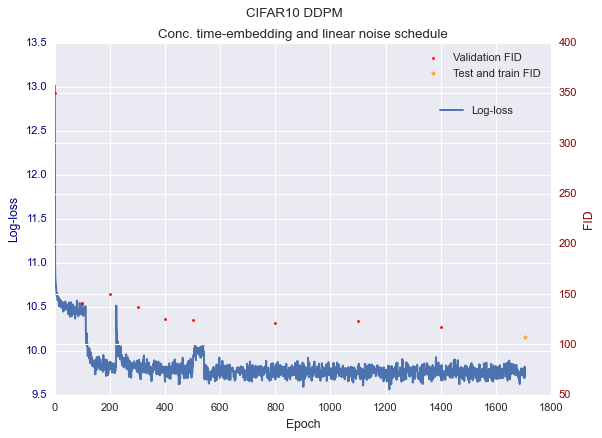

In [106]:
#valid_fid_scores = [349.9, 141.6, 150.1, 137.1, 125.4, 124.3, 121.4, 123.7, 117.3]
#test_fid_score = [107.5]
#train_fid_score = [107.8]

epochs_valid_fid = validation_scores
epochs_loss = list(range(1707+1))
test_fid_score = test_score
train_fid_score = train_score
fig, ax1 = plt.subplots()
plt.suptitle("CIFAR10 DDPM")
plt.title("Conc. time-embedding and linear noise schedule")
ax1.plot(epochs_loss, np.log(np.array(first_500_epochs_loss)), label="Log-loss")
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Log-loss', color='darkblue')
ax1.tick_params(axis='y', labelcolor='darkblue')
ax1.legend(loc="upper left", bbox_to_anchor=(0.757, 0.85))
ax2 = ax1.twinx()
ax2.scatter(epochs_valid_fid, valid_fid_scores, color="red", marker=".", label="Validation FID")
ax2.set_ylabel('FID', color='darkred')
ax2.tick_params(axis='y', labelcolor='darkred')
ax2.scatter([1707], test_fid_score, label="Test and train FID", marker="*", color="orange")
ax2.legend()


# Overfit to one batch

In [8]:
batch_size = 16
model = UNET()
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
single_batch, _ = next(iter(train_loader))
single_batch = single_batch[0].unsqueeze(0).to(device)
single_batchs = single_batch.repeat(batch_size, 1, 1, 1)
# Set the model to training mode
model.train()

for epoch in range(10000):
    x0 = single_batchs
    x0 = x0.to(device)
    t = torch.randint(1, T+1, (batch_size,)).to(device)
    #print(t.shape)
    eps = torch.randn(batch_size, 3, 32, 32).to(device)
    # print(eps.shape)
    # print(x0.shape)
    loss = criterion(eps, model(torch.sqrt(alpha_bar[t-1]) * x0 + 
                                torch.sqrt(1 - alpha_bar[t-1]) * eps, t.view(batch_size, 1, 1, 1).expand(batch_size, 1, 32, 32) / 1000))
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    print(epoch)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

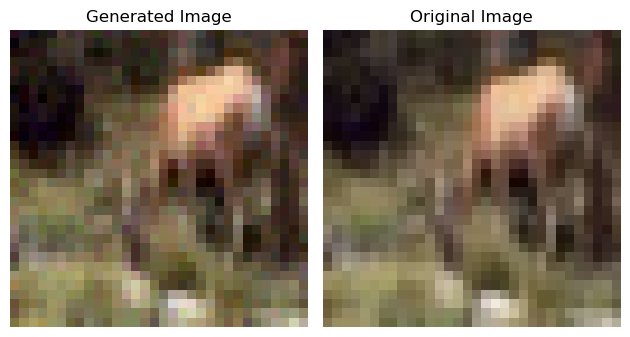

In [9]:
model.eval()
batch_size = 1
xt = torch.randn(batch_size, 3, 32, 32).to(device)

for t in torch.arange(T, 0, -1):
    #print(t)
    t = t.to(device)
    #print(t.view(batch_size, 1, 1, 1).expand(batch_size, 1, 32, 32))
    z = torch.randn(batch_size, 3, 32, 32).to(device) if t > 1 else torch.zeros(batch_size, 3, 32, 32).to(device)
    xt_new = 1 / torch.sqrt(alpha[t - 1]) * (xt - (1 - alpha[t - 1])/(torch.sqrt(1 - alpha_bar[t - 1])) * 
                                                   model(xt, t.view(batch_size, 1, 1, 1).expand(batch_size, 1, 32, 32)/1000)) + torch.sqrt(beta[t-1]) * z
    xt = xt_new

# Plot the generated image
fig,axs = plt.subplots(1, 2, tight_layout=True)
im = xt[0].permute(1, 2, 0)
im = im.cpu().detach().numpy()
#print(im.max(), im.min())
im = (im + 1) / 2 
im = im.clip(0, 1)
axs[0].imshow(im)
axs[0].set_title("Generated Image")
axs[0].axis("off")
im_2 = single_batch[0].permute(1, 2, 0).cpu().detach().numpy()
im_2 = (im_2 + 1)/2
#im_2 = (im_2 - im_2.min()) / (im_2.max() - im_2.min()) 
axs[1].imshow(im_2)
axs[1].set_title("Original Image")
axs[1].axis("off")
plt.show()